# Gensim Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind the open source NMF implementation in [Gensim](https://github.com/RaRe-Technologies/gensim), including code examples for applying NMF to text processing.

## What's in this tutorial?

1. [Introduction: Why NMF?](#1.-Introduction-to-NMF)
2. [Code example on 20 Newsgroups](#2.-Code-example:-NMF-on-20-Newsgroups)
3. [Benchmarks against Sklearn's NMF and Gensim's LDA](#3.-Benchmarks)
4. [Large-scale NMF training on the English Wikipedia (sparse text vectors)](#4.-NMF-on-English-Wikipedia)
5. [NMF on face decomposition (dense image vectors)](#5.-And-now-for-something-completely-different:-Face-decomposition-from-images)

# 1. Introduction to NMF

## What's in a name?

Gensim's Online Non-Negative Matrix Factorization (NMF, NNMF, ONMF) implementation is based on [Renbo Zhao, Vincent Y. F. Tan: Online Nonnegative Matrix Factorization with Outliers, 2016](https://arxiv.org/abs/1604.02634) and is optimized for extremely large, sparse, streamed inputs. Such inputs happen in NLP with **unsupervised training** on massive text corpora.

* Why **Online**? Because corpora and datasets in modern ML can be very large, and RAM is limited. Unlike batch algorithms, online algorithms learn iteratively, streaming through the available training examples, without loading the entire dataset into RAM or requiring random-access to the data examples.

* Why **Non-Negative**? Because non-negativity leads to more interpretable, sparse "human-friendly" topics. This is in contrast to e.g. SVD (another popular matrix factorization method with [super-efficient implementation in Gensim](https://radimrehurek.com/gensim/models/lsimodel.html)), which produces dense negative factors and thus harder-to-interpret topics.

* **Matrix factorizations** are the corner stone of modern machine learning. They can be used either directly (recommendation systems, bi-clustering, image compression, topic modeling…) or as internal routines in more complex deep learning algorithms.

## How ONNMF works

Terminology:
- `corpus` is a stream of input documents = training examples
- `batch` is a chunk of input corpus, a word-document matrix mini-batch that fits in RAM
- `W` is a word-topic matrix (to be learned; stored in the resulting model)
- `h` is a topic-document matrix (to be learned; not stored, but rather inferred for documents on-the-fly)
- `A`, `B` - matrices that accumulate information from consecutive chunks. `A = h.dot(ht)`, `B = v.dot(ht)`.

The idea behind the algorithm is as follows:

```
    Initialize W, A and B matrices

    for batch in input corpus batches:
        infer h:
            do coordinate gradient descent step to find h that minimizes ||batch - Wh|| in L2 norm

            bound h so that it is non-negative

        update A and B:
            A = h.dot(ht)
            B = batch.dot(ht)

        update W:
            do gradient descent step to find W that minimizes ||0.5*trace(WtWA) - trace(WtB)|| in L2 norm
```

# 2. Code example: NMF on 20 Newsgroups

## Preprocessing

Let's import the models we'll be using throughout this tutorial (`numpy==1.14.2`, `matplotlib==3.0.2`, `pandas==0.24.1`, `sklearn==0.19.1`, `gensim==3.7.1`) and set up logging at INFO level.

Gensim uses logging generously to inform users what's going on. Eyeballing the logs is a good sanity check, to make sure everything is working as expected.

Only `numpy` and `gensim` are actually needed to train and use NMF. The other imports are used only to make our life a little easier in this tutorial.

In [1]:
import logging
import time
from contextlib import contextmanager
import os
from multiprocessing import Process
import psutil

import numpy as np
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Dataset preparation

Let's load the notorious [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) from Gensim's [repository of pre-trained models and corpora](https://github.com/RaRe-Technologies/gensim-data):

In [2]:
newsgroups = gensim.downloader.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {name: idx for idx, name in enumerate(categories)}

Create a train/test split:

In [3]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'test'
])
random_state.shuffle(testset)

We'll use very [simple preprocessing with stemming](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string) to tokenize each document. YMMV; in your application, use whatever preprocessing makes sense in your domain. Correctly preparing the input has [major impact](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out) on any subsequent ML training.

In [4]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

Let's create a mapping between tokens and their ids. Another option would be a [HashDictionary](https://radimrehurek.com/gensim/corpora/hashdictionary.html), saving ourselves one pass over the training documents.

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens

2019-03-04 01:54:20,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-03-04 01:54:21,153 : INFO : built Dictionary(25279 unique tokens: ['gladli', 'garrett', 'stuck', 'gov', 'karasi']...) from 2819 documents (total 435328 corpus positions)
2019-03-04 01:54:21,182 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-03-04 01:54:21,183 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-03-04 01:54:21,193 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['gladli', 'run', 'trillion', 'stuck', 'order']...)


### Create training corpus

Let's vectorize the training corpus into the bag-of-words format. We'll train LDA on a BOW and NMFs on an TF-IDF corpus:

In [6]:
tfidf = TfidfModel(dictionary=dictionary)

train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

train_corpus_tfidf = list(tfidf[train_corpus])

test_corpus_tfidf = list(tfidf[test_corpus])

Here we simply stored the bag-of-words vectors into a `list`, but Gensim accepts [any iterable](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) as input, including streamed ones. To learn more about memory-efficient input iterables, see our [Data Streaming in Python: Generators, Iterators, Iterables](https://rare-technologies.com/data-streaming-in-python-generators-iterators-iterables/) tutorial.

## NMF Model Training

The API works in the same way as other Gensim models, such as [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) or [LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html).

Notable model parameters:

- `kappa` float, optional

    Gradient descent step size.
    Larger value makes the model train faster, but could lead to non-convergence if set too large.
    
- `w_max_iter` int, optional

    Maximum number of iterations to train W per each batch.
    
- `w_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``W`` stops for the current batch.
    
- `h_r_max_iter` int, optional

    Maximum number of iterations to train h per each batch.
    
- `h_r_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``h`` stops for the current batch.

Learn an NMF model with 5 topics:

In [7]:
%%time

nmf = GensimNmf(
    corpus=train_corpus_tfidf,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

2019-03-04 01:54:24,559 : INFO : running NMF training, 5 topics, 5 passes over the supplied corpus of 2819 documents, evaluating l2 norm every 2819 documents
2019-03-04 01:54:24,574 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-03-04 01:54:24,589 : INFO : W error diff: -inf
2019-03-04 01:54:24,604 : INFO : PROGRESS: pass 0, at document #2000/2819
2019-03-04 01:54:24,615 : INFO : W error diff: -2.1783593508632997
2019-03-04 01:54:24,626 : INFO : PROGRESS: pass 0, at document #2819/2819
2019-03-04 01:54:24,722 : INFO : L2 norm: 28.137070033533682
2019-03-04 01:54:24,756 : INFO : topic #0 (0.404): 0.011*"isra" + 0.010*"israel" + 0.007*"arab" + 0.006*"jew" + 0.005*"palestinian" + 0.004*"henri" + 0.003*"toronto" + 0.003*"question" + 0.003*"kill" + 0.003*"polici"
2019-03-04 01:54:24,757 : INFO : topic #1 (0.358): 0.009*"space" + 0.005*"access" + 0.005*"nasa" + 0.004*"pat" + 0.003*"digex" + 0.003*"orbit" + 0.003*"shuttl" + 0.003*"graphic" + 0.003*"data" + 0.003*"com"
2019-03-04 01:54

CPU times: user 1.52 s, sys: 1.84 s, total: 3.36 s
Wall time: 944 ms


### View the learned topics

In [8]:
nmf.show_topics()

[(0,
  '0.015*"israel" + 0.014*"isra" + 0.009*"arab" + 0.008*"jew" + 0.005*"palestinian" + 0.004*"lebanes" + 0.004*"peac" + 0.004*"attack" + 0.004*"lebanon" + 0.003*"polici"'),
 (1,
  '0.007*"space" + 0.005*"nasa" + 0.003*"access" + 0.003*"orbit" + 0.003*"launch" + 0.003*"gov" + 0.003*"pat" + 0.003*"com" + 0.002*"alaska" + 0.002*"moon"'),
 (2,
  '0.023*"armenian" + 0.012*"turkish" + 0.008*"armenia" + 0.007*"argic" + 0.007*"turk" + 0.007*"serdar" + 0.006*"turkei" + 0.005*"greek" + 0.005*"genocid" + 0.005*"soviet"'),
 (3,
  '0.017*"moral" + 0.016*"keith" + 0.008*"object" + 0.007*"caltech" + 0.006*"schneider" + 0.006*"allan" + 0.006*"cco" + 0.004*"anim" + 0.004*"natur" + 0.004*"goal"'),
 (4,
  '0.012*"god" + 0.011*"islam" + 0.006*"jaeger" + 0.005*"sgi" + 0.005*"livesei" + 0.005*"muslim" + 0.005*"atheist" + 0.005*"religion" + 0.005*"atheism" + 0.004*"rushdi"')]

### Evaluation measure: Coherence

[Topic coherence](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) measures how often do most frequent tokens from each topic co-occur in one document.

In [9]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus_tfidf,
    coherence='u_mass'
).get_coherence()

2019-03-04 01:54:25,582 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-4.045883079644641

## Topic inference on new documents

With the NMF model trained, let's fetch one news document not seen during training, and infer its topic vector.

In [10]:
print(testset[0]['data'])
print('=' * 100)
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.10094349983895379)

## Word topic inference

Similarly, we can inspect the topic distribution assigned to a vocabulary term:

In [11]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.1517466731147538), (1, 0.2824521057319929), (2, 0.042590027339691805), (3, 0.2520757387076886), (4, 0.2711354551058729)]


### Internal NMF state

Density is a fraction of non-zero elements in a matrix.

In [12]:
def density(matrix):
    return (matrix > 0).mean()

Term-topic matrix of shape `(words, topics)`.

In [13]:
print("Density: {}".format(density(nmf._W)))

Density: 0.6864567151532269


Topic-document matrix for the last batch of shape `(topics, batch)`

In [14]:
print("Density: {}".format(density(nmf._h)))

Density: 0.662026862026862


Residuals matrix of the last batch of shape `(words, batch)`

# 3. Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

We'll run these three unsupervised models on the [20newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset.

20 Newsgroups also contains labels for each document, which will allow us to evaluate the trained models on an "upstream" classification task, using the unsupervised document topics as input features.

### Metrics

We'll track these metrics as we train and test NMF on the 20-newsgroups corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score.
- `l2_norm` - L2 norm of `v - Wh` (not defined for LDA).
- `f1` - [F1 score](https://en.wikipedia.org/wiki/F1_score) on the task of news topic classification.

In [15]:
fixed_params = dict(
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
)

In [16]:
@contextmanager
def measure_ram(output, tick=5):
    def _measure_ram(pid, output, tick=tick):
        py = psutil.Process(pid)
        with open(output, 'w') as outfile:
            while True:
                memory = py.memory_info().rss
                outfile.write("{}\n".format(memory))
                outfile.flush()
                time.sleep(tick)

    pid = os.getpid()
    p = Process(target=_measure_ram, args=(pid, output, tick))
    p.start()
    yield
    p.terminate()


def get_train_time_and_ram(func, name, tick=5):
    memprof_filename = "{}.memprof".format(name)

    start = time.time()

    with measure_ram(memprof_filename, tick=tick):
        result = func()

    elapsed_time = pd.to_timedelta(time.time() - start, unit='s').round('s')

    memprof_df = pd.read_csv(memprof_filename, squeeze=True)

    mean_ram = "{} MB".format(
        int(memprof_df.mean() // 2 ** 20),
    )

    max_ram = "{} MB".format(int(memprof_df.max() // 2 ** 20))

    return elapsed_time, mean_ram, max_ram, result


def get_f1(model, train_corpus, X_test, y_train, y_test):
    if isinstance(model, SklearnNmf):
        dense_train_corpus = matutils.corpus2dense(
            train_corpus,
            num_terms=model.components_.shape[1],
        )
        X_train = model.transform(dense_train_corpus.T)
    else:
        X_train = np.zeros((len(train_corpus), model.num_topics))
        for bow_id, bow in enumerate(train_corpus):
            for topic_id, word_count in model.get_document_topics(bow):
                X_train[bow_id, topic_id] = word_count

    log_reg = LogisticRegressionCV(multi_class='multinomial', cv=5)
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')

def get_sklearn_topics(model, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)

    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]

    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]

    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]

    topics = []

    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            model.id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))

    return topics

def get_metrics(model, test_corpus, train_corpus=None, y_train=None, y_test=None, dictionary=None):
    if isinstance(model, SklearnNmf):
        model.get_topics = lambda: model.components_
        model.show_topics = lambda top_n: get_sklearn_topics(model, top_n)
        model.id2word = dictionary

    W = model.get_topics().T

    dense_test_corpus = matutils.corpus2dense(
        test_corpus,
        num_terms=W.shape[0],
    )

    if isinstance(model, SklearnNmf):
        H = model.transform(dense_test_corpus.T).T
    else:
        H = np.zeros((model.num_topics, len(test_corpus)))
        for bow_id, bow in enumerate(test_corpus):
            for topic_id, word_count in model.get_document_topics(bow):
                H[topic_id, bow_id] = word_count

    l2_norm = None

    if not isinstance(model, LdaModel):
        pred_factors = W.dot(H)

        l2_norm = np.linalg.norm(pred_factors - dense_test_corpus)
        l2_norm = round(l2_norm, 4)

    f1 = None

    if train_corpus and y_train and y_test:
        f1 = get_f1(model, train_corpus, H.T, y_train, y_test)
        f1 = round(f1, 4)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    coherence = round(coherence, 4)

    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        coherence=coherence,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )

### Run the models

In [17]:
tm_metrics = pd.DataFrame(columns=['model', 'train_time', 'coherence', 'l2_norm', 'f1', 'topics'])

y_train = [doc['target'] for doc in trainset]
y_test = [doc['target'] for doc in testset]

# LDA metrics
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(
        corpus=train_corpus,
        **fixed_params,
    ),
    'lda',
    1,
)
row.update(get_metrics(
    lda, test_corpus, train_corpus, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = {}
row['model'] = 'sklearn_nmf'
train_dense_corpus_tfidf = matutils.corpus2dense(train_corpus_tfidf, len(dictionary)).T
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: SklearnNmf(n_components=5, random_state=42).fit(train_dense_corpus_tfidf),
    'sklearn_nmf',
    1,
)
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test, dictionary,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Gensim NMF metrics
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], gensim_nmf = get_train_time_and_ram(
    lambda: GensimNmf(
        normalize=False,
        corpus=train_corpus_tfidf,
        **fixed_params
    ),
    'gensim_nmf',
    0.5,
)
row.update(get_metrics(
    gensim_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)
tm_metrics.replace(np.nan, '-', inplace=True)

2019-03-04 01:54:25,807 : INFO : using symmetric alpha at 0.2
2019-03-04 01:54:25,809 : INFO : using symmetric eta at 0.2
2019-03-04 01:54:25,811 : INFO : using serial LDA version on this node
2019-03-04 01:54:25,817 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-03-04 01:54:25,818 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-03-04 01:54:26,369 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-03-04 01:54:26,372 : INFO : topic #0 (0.200): 0.006*"com" + 0.006*"like" + 0.006*"space" + 0.004*"univers" + 0.004*"know" + 0.004*"nntp" + 0.004*"imag" + 0.004*"nasa" + 0.004*"time" + 0.004*"program"
2019-03-04 01:54:26,372 : INFO : topic #1 (0.200): 0.007*"imag" + 0.005*"com" + 0.004*"peopl" + 0.004*"know" + 0.004*"univers" + 0.004*"nntp" + 0.004

2019-03-04 01:54:29,638 : INFO : topic diff=0.416347, rho=0.455535
2019-03-04 01:54:29,639 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-03-04 01:54:30,031 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-03-04 01:54:30,034 : INFO : topic #0 (0.200): 0.011*"space" + 0.007*"imag" + 0.006*"nasa" + 0.006*"com" + 0.006*"graphic" + 0.006*"program" + 0.005*"file" + 0.005*"data" + 0.005*"orbit" + 0.004*"new"
2019-03-04 01:54:30,034 : INFO : topic #1 (0.200): 0.010*"com" + 0.006*"imag" + 0.006*"like" + 0.006*"nntp" + 0.006*"host" + 0.006*"univers" + 0.005*"bit" + 0.005*"know" + 0.005*"think" + 0.005*"work"
2019-03-04 01:54:30,035 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.009*"armenian" + 0.007*"turkish" + 0.007*"said" + 0.007*"right" + 0.006*"jew" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"like"
2019-03-04 01:54:30,036 : INFO : topic #3 (0.200): 0.010*"com" + 0.010*"israel" + 0.008*"bike" + 0.006*"isra" + 0.005*"like" + 0.004*"dod" + 0.004

2019-03-04 01:54:33,147 : INFO : topic #1 (0.200): 0.013*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"univers" + 0.006*"know" + 0.005*"bit" + 0.005*"think" + 0.005*"time" + 0.005*"work"
2019-03-04 01:54:33,147 : INFO : topic #2 (0.200): 0.013*"armenian" + 0.011*"peopl" + 0.008*"turkish" + 0.007*"said" + 0.007*"jew" + 0.006*"right" + 0.006*"kill" + 0.005*"know" + 0.005*"isra" + 0.005*"arab"
2019-03-04 01:54:33,148 : INFO : topic #3 (0.200): 0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.007*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"host" + 0.005*"nntp" + 0.005*"ride" + 0.005*"think"
2019-03-04 01:54:33,149 : INFO : topic #4 (0.200): 0.011*"god" + 0.008*"peopl" + 0.006*"think" + 0.006*"exist" + 0.006*"islam" + 0.005*"atheist" + 0.005*"believ" + 0.005*"com" + 0.005*"univers" + 0.005*"moral"
2019-03-04 01:54:33,149 : INFO : topic diff=0.202107, rho=0.357622
2019-03-04 01:54:33,150 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-03-04 01:54:33,498 : INFO : merging 

2019-03-04 01:54:43,402 : INFO : topic #3 (0.353): 0.013*"moral" + 0.011*"keith" + 0.006*"object" + 0.005*"caltech" + 0.005*"schneider" + 0.004*"anim" + 0.004*"allan" + 0.004*"cco" + 0.004*"jake" + 0.004*"boni"
2019-03-04 01:54:43,403 : INFO : topic #4 (0.380): 0.013*"islam" + 0.013*"god" + 0.007*"livesei" + 0.007*"sgi" + 0.007*"jaeger" + 0.006*"muslim" + 0.006*"jon" + 0.005*"religion" + 0.005*"imag" + 0.005*"solntz"
2019-03-04 01:54:43,408 : INFO : W error diff: -0.05304441334403265
2019-03-04 01:54:43,431 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-03-04 01:54:43,439 : INFO : W error diff: -0.6532464912217009
2019-03-04 01:54:43,453 : INFO : PROGRESS: pass 2, at document #2000/2819
2019-03-04 01:54:43,458 : INFO : W error diff: -0.5542774416923812
2019-03-04 01:54:43,470 : INFO : PROGRESS: pass 2, at document #2819/2819
2019-03-04 01:54:43,600 : INFO : L2 norm: 27.999892226543682
2019-03-04 01:54:43,638 : INFO : topic #0 (0.343): 0.013*"israel" + 0.013*"isra" + 0.008*"arab

## Benchmark results

In [18]:
tm_metrics.drop('topics', axis=1)

,model,train_time,coherence,l2_norm,f1,max_ram,mean_ram
0,lda,00:00:08,-2.1054,-,0.7511,288 MB,288 MB
1,sklearn_nmf,00:00:02,-3.1835,42.4759,0.7900,824 MB,692 MB
2,gensim_nmf,00:00:01,-4.0459,42.5486,0.8044,427 MB,427 MB


### Main insights

- Gensim NMF is **ridiculously fast** and leaves both LDA and Sklearn far behind in terms of training time and quality on downstream task (F1 score), though coherence is the lowest among all models.
- Gensim NMF beats Sklearn NMF in RAM consumption, but L2 norm is a bit worse.
- Gensim NMF consumes a bit more RAM than LDA.

### Learned topics

Let's inspect the 5 topics learned by each of the three models:

In [19]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


lda:
(0, '0.013*"space" + 0.008*"imag" + 0.007*"nasa" + 0.006*"graphic" + 0.006*"program" + 0.005*"launch" + 0.005*"file" + 0.005*"com" + 0.005*"new" + 0.004*"orbit"')
(1, '0.015*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"know" + 0.006*"univers" + 0.005*"henri" + 0.005*"work" + 0.005*"bit" + 0.005*"think"')
(2, '0.014*"armenian" + 0.011*"peopl" + 0.009*"turkish" + 0.007*"jew" + 0.007*"said" + 0.006*"right" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"turkei"')
(3, '0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.006*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"ride" + 0.005*"host" + 0.005*"nntp" + 0.005*"motorcycl"')
(4, '0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.006*"exist" + 0.006*"univers" + 0.005*"com" + 0.005*"believ" + 0.005*"islam" + 0.005*"moral" + 0.005*"christian"')

sklearn_nmf:
(0, '0.027*"armenian" + 0.013*"turkish" + 0.009*"armenia" + 0.009*"argic" + 0.009*"serdar" + 0.008*"turk" + 0.007*"turkei" + 0.006*"genocid" + 0.006*"soviet" + 0.006*

Subjectively, Gensim and Sklearn NMFs are on par with each other, LDA looks a bit worse.

# 4. NMF on English Wikipedia

This section shows how to train an NMF model on a large text corpus, the entire English Wikipedia: **2.6 billion words, in 23.1 million article sections across 5 million Wikipedia articles**.

The data preprocessing takes a while, and we'll be comparing multiple models, so **reserve about FIXME hours** and some **20 GB of disk space** to go through the following notebook cells in full. You'll need `gensim>=3.7.1`, `numpy`, `tqdm`, `pandas`, `psutils`, `joblib` and `sklearn`.

In [20]:
# Re-import modules from scratch, so that this Section doesn't rely on any previous cells.
import itertools
import json
import logging
import time
import os

from smart_open import smart_open
import psutil
import numpy as np
import scipy.sparse
from contextlib import contextmanager, contextmanager, contextmanager
from multiprocessing import Process
from tqdm import tqdm, tqdm_notebook
import joblib
import pandas as pd
from sklearn.decomposition.nmf import NMF as SklearnNmf

import gensim.downloader
from gensim import matutils
from gensim.corpora import MmCorpus, Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.utils import simple_preprocess

tqdm.pandas()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load the Wikipedia dump

We'll use the [gensim.downloader](https://github.com/RaRe-Technologies/gensim-data) to download a parsed Wikipedia dump (6.1 GB disk space):

In [21]:
data = gensim.downloader.load("wiki-english-20171001")

Print the titles and sections of the first Wikipedia article, as a little sanity check:

In [22]:
data = gensim.downloader.load("wiki-english-20171001")
article = next(iter(data))

print("Article: %r\n" % article['title'])
for section_title, section_text in zip(article['section_titles'], article['section_texts']):
    print("Section title: %r" % section_title)
    print("Section text: %s…\n" % section_text[:100].replace('\n', ' ').strip())

Article: 'Anarchism'

Section title: 'Introduction'
Section text: '''Anarchism''' is a political philosophy that advocates self-governed societies based on volun…

Section title: 'Etymology and terminology'
Section text: The word ''anarchism'' is composed from the word ''anarchy'' and the suffix ''-ism'', themselves d…

Section title: 'History'
Section text: ===Origins=== Woodcut from a Diggers document by William Everard  The earliest anarchist themes ca…

Section title: 'Anarchist schools of thought'
Section text: Portrait of philosopher Pierre-Joseph Proudhon (1809–1865) by Gustave Courbet. Proudhon was the pri…

Section title: 'Internal issues and debates'
Section text: consistent with anarchist values is a controversial subject among anarchists.  Anarchism is a philo…

Section title: 'Topics of interest'
Section text: Intersecting and overlapping between various schools of thought, certain topics of interest and inte…

Section title: 'Criticisms'
Section text: Criticisms of anarch

Let's create a Python generator function that streams through the downloaded Wikipedia dump and preprocesses (tokenizes, lower-cases) each article:

In [23]:
def wikidump2tokens(articles):
    """Stream through the Wikipedia dump, yielding a list of tokens for each article."""
    for article in articles:
        article_section_texts = [
            " ".join([title, text])
            for title, text
            in zip(article['section_titles'], article['section_texts'])
        ]
        article_tokens = simple_preprocess(" ".join(article_section_texts))
        yield article_tokens

Create a word-to-id mapping, in order to vectorize texts. Makes a full pass over the Wikipedia corpus, takes **~3.5 hours**:

In [24]:
if os.path.exists('wiki.dict'):
    # If we already stored the Dictionary in a previous run, simply load it, to save time.
    dictionary = Dictionary.load('wiki.dict')
else:
    dictionary = Dictionary(wikidump2tokens(data))
    # Keep only the 30,000 most frequent vocabulary terms, after filtering away terms
    # that are too frequent/too infrequent.
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=30000)
    dictionary.save('wiki.dict')

2019-03-04 01:54:48,345 : INFO : loading Dictionary object from wiki.dict
2019-03-04 01:54:48,371 : INFO : loaded wiki.dict


## Store preprocessed Wikipedia as bag-of-words sparse matrix in MatrixMarket format

When training NMF with a single pass over the input corpus ("online"), we simply vectorize each raw text straight from the input storage:

In [25]:
vector_stream = (dictionary.doc2bow(article) for article in wikidump2tokens(data))

For the purposes of this tutorial though, we'll serialize ("cache") the vectorized bag-of-words vectors to disk, to `wiki.mm` file in MatrixMarket format. The reason is, we'll be re-using the vectorized articles multiple times, for different models for our benchmarks, and also shuffling them, so it makes sense to amortize the vectorization time by persisting the resulting vectors to disk.

So, let's stream through the preprocessed sparse Wikipedia bag-of-words matrix while storing it to disk. **This step takes about 3 hours** and needs **38 GB of disk space**:

In [26]:
class RandomSplitCorpus(MmCorpus):
    """
    Use the fact that MmCorpus supports random indexing, and create a streamed
    corpus in shuffled order, including a train/test split for evaluation.
    """
    def __init__(self, random_seed=42, testset=False, testsize=1000, *args, **kwargs):
        super().__init__(*args, **kwargs)

        random_state = np.random.RandomState(random_seed)
        
        self.indices = random_state.permutation(range(self.num_docs))
        test_nnz = sum(len(self[doc_idx]) for doc_idx in self.indices[:testsize])
        
        if testset:
            self.indices = self.indices[:testsize]
            self.num_docs = testsize
            self.num_nnz = test_nnz
        else:
            self.indices = self.indices[testsize:]
            self.num_docs -= testsize
            self.num_nnz -= test_nnz

    def __iter__(self):
        for doc_id in self.indices:
            yield self[doc_id]

In [27]:
if not os.path.exists('wiki.mm'):
    MmCorpus.serialize('wiki.mm', vector_stream, progress_cnt=100000)

if not os.path.exists('wiki_tfidf.mm'):
    MmCorpus.serialize('wiki_tfidf.mm', tfidf[MmCorpus('wiki.mm')], progress_cnt=100000)

In [28]:
# Load back the vectors as two lazily-streamed train/test iterables.
train_corpus = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki.mm',
)
test_corpus = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki.mm',
)

train_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki_tfidf.mm',
)
test_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki_tfidf.mm',
)

2019-03-04 01:54:48,955 : INFO : loaded corpus index from wiki.mm.index
2019-03-04 01:54:48,955 : INFO : initializing cython corpus reader from wiki.mm
2019-03-04 01:54:48,957 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-03-04 01:54:53,977 : INFO : loaded corpus index from wiki.mm.index
2019-03-04 01:54:53,979 : INFO : initializing cython corpus reader from wiki.mm
2019-03-04 01:54:53,981 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-03-04 01:54:59,407 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-03-04 01:54:59,407 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-03-04 01:54:59,408 : INFO : accepted corpus with 4924661 documents, 30000 features, 820007548 non-zero entries
2019-03-04 01:55:02,179 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-03-04 01:55:02,179 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-03-04 01:55:02,

## Save preprocessed Wikipedia in scipy.sparse format

This is only needed to run the Sklearn NMF on Wikipedia, for comparison in the benchmarks below. Sklearn expects in-memory scipy sparse input, not on-the-fly vector streams. Needs additional ~2 GB of disk space.


**Skip this step if you don't need the Sklearn's NMF benchmark, and only want to run Gensim's NMF.**

In [29]:
if not os.path.exists('wiki_train_csr.npz'):
    scipy.sparse.save_npz(
        'wiki_train_csr.npz',
        matutils.corpus2csc(train_corpus_tfidf, len(dictionary)).T,
    )

### Metrics

We'll track these metrics as we train and test NMF on the Wikipedia corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score.
- `l2_norm` - L2 norm of `v - Wh` (not defined for LDA).

Define a dataframe in which we'll store the recorded metrics:

In [30]:
tm_metrics = pd.DataFrame(columns=[
    'model', 'train_time', 'mean_ram', 'max_ram', 'coherence', 'l2_norm', 'topics',
])

Define common parameters, to be shared by all evaluated models:

In [31]:
params = dict(
    chunksize=2000,
    num_topics=50,
    id2word=dictionary,
    passes=1,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

## Wikipedia training

### Train Gensim NMF model and record its metrics

In [32]:
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], nmf = get_train_time_and_ram(
    lambda: GensimNmf(normalize=False, corpus=train_corpus_tfidf, **params),
    'gensim_nmf',
    1,
)

2019-03-04 01:55:04,736 : INFO : running NMF training, 50 topics, 1 passes over the supplied corpus of 4914661 documents, evaluating l2 norm every 20000 documents
2019-03-04 01:55:06,609 : INFO : PROGRESS: pass 0, at document #2000/4914661
2019-03-04 01:55:09,929 : INFO : W error diff: -inf
2019-03-04 01:55:11,548 : INFO : PROGRESS: pass 0, at document #4000/4914661
2019-03-04 01:55:14,093 : INFO : W error diff: -9.220106074829836
2019-03-04 01:55:15,008 : INFO : PROGRESS: pass 0, at document #6000/4914661
2019-03-04 01:55:15,670 : INFO : W error diff: -8.347558738137899
2019-03-04 01:55:16,153 : INFO : PROGRESS: pass 0, at document #8000/4914661
2019-03-04 01:55:16,753 : INFO : W error diff: -6.023808520783277
2019-03-04 01:55:17,206 : INFO : PROGRESS: pass 0, at document #10000/4914661
2019-03-04 01:55:17,722 : INFO : W error diff: -3.6758262313213876
2019-03-04 01:55:18,190 : INFO : PROGRESS: pass 0, at document #12000/4914661
2019-03-04 01:55:18,677 : INFO : W error diff: -3.883841

2019-03-04 01:55:49,298 : INFO : PROGRESS: pass 0, at document #66000/4914661
2019-03-04 01:55:49,455 : INFO : W error diff: -0.16894710920851708
2019-03-04 01:55:49,760 : INFO : PROGRESS: pass 0, at document #68000/4914661
2019-03-04 01:55:49,899 : INFO : W error diff: -0.296940521268084
2019-03-04 01:55:50,211 : INFO : PROGRESS: pass 0, at document #70000/4914661
2019-03-04 01:55:50,363 : INFO : W error diff: -0.3285820690366137
2019-03-04 01:55:50,667 : INFO : PROGRESS: pass 0, at document #72000/4914661
2019-03-04 01:55:50,811 : INFO : W error diff: -0.18391137357174614
2019-03-04 01:55:52,074 : INFO : PROGRESS: pass 0, at document #74000/4914661
2019-03-04 01:55:52,724 : INFO : W error diff: -0.12139554111800521
2019-03-04 01:55:53,998 : INFO : PROGRESS: pass 0, at document #76000/4914661
2019-03-04 01:55:54,617 : INFO : W error diff: -0.23699870968422942
2019-03-04 01:55:56,091 : INFO : PROGRESS: pass 0, at document #78000/4914661
2019-03-04 01:55:56,657 : INFO : W error diff: -0

2019-03-04 01:56:13,654 : INFO : PROGRESS: pass 0, at document #132000/4914661
2019-03-04 01:56:13,791 : INFO : W error diff: -0.11468521908750517
2019-03-04 01:56:14,154 : INFO : PROGRESS: pass 0, at document #134000/4914661
2019-03-04 01:56:14,295 : INFO : W error diff: -0.11775181601468887
2019-03-04 01:56:14,595 : INFO : PROGRESS: pass 0, at document #136000/4914661
2019-03-04 01:56:14,735 : INFO : W error diff: -0.035303797367404854
2019-03-04 01:56:15,038 : INFO : PROGRESS: pass 0, at document #138000/4914661
2019-03-04 01:56:15,177 : INFO : W error diff: -0.13356521268893573
2019-03-04 01:56:15,468 : INFO : PROGRESS: pass 0, at document #140000/4914661
2019-03-04 01:56:16,752 : INFO : L2 norm: 42.576949815302534
2019-03-04 01:56:16,842 : INFO : topic #39 (0.374): 0.006*"are" + 0.005*"or" + 0.005*"that" + 0.005*"be" + 0.004*"can" + 0.003*"this" + 0.003*"have" + 0.003*"used" + 0.003*"not" + 0.003*"such"
2019-03-04 01:56:16,843 : INFO : topic #21 (0.441): 0.007*"his" + 0.004*"him" 

2019-03-04 01:56:43,500 : INFO : W error diff: 0.0
2019-03-04 01:56:43,791 : INFO : PROGRESS: pass 0, at document #198000/4914661
2019-03-04 01:56:43,911 : INFO : W error diff: 0.0
2019-03-04 01:56:44,211 : INFO : PROGRESS: pass 0, at document #200000/4914661
2019-03-04 01:56:45,535 : INFO : L2 norm: 42.45831634631639
2019-03-04 01:56:45,624 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"that" + 0.005*"be" + 0.004*"can" + 0.003*"this" + 0.003*"have" + 0.003*"used" + 0.003*"not" + 0.003*"such"
2019-03-04 01:56:45,625 : INFO : topic #21 (0.423): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"her" + 0.003*"had" + 0.002*"they" + 0.002*"but" + 0.002*"who" + 0.002*"their" + 0.002*"were"
2019-03-04 01:56:45,626 : INFO : topic #33 (0.858): 0.019*"district" + 0.004*"village" + 0.004*"population" + 0.003*"rural" + 0.002*"census" + 0.002*"oblast" + 0.002*"districts" + 0.001*"villages" + 0.001*"dehestan" + 0.001*"administrative"
2019-03-04 01:56:45,627 : INFO : topic #28 (0.882):

2019-03-04 01:57:05,028 : INFO : topic #21 (0.416): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"her" + 0.003*"had" + 0.002*"they" + 0.002*"but" + 0.002*"who" + 0.002*"their" + 0.002*"were"
2019-03-04 01:57:05,029 : INFO : topic #33 (0.862): 0.019*"district" + 0.004*"village" + 0.004*"population" + 0.003*"rural" + 0.002*"oblast" + 0.002*"census" + 0.002*"districts" + 0.001*"villages" + 0.001*"dehestan" + 0.001*"administrative"
2019-03-04 01:57:05,030 : INFO : topic #28 (0.887): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 01:57:05,030 : INFO : topic #34 (0.893): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.004*"county" + 0.004*"population" + 0.004*"village" + 0.003*"district"
2019-03-04 01:57:05,070 : INFO : W error diff: -0.01926651511377031
2019-03-04 01:57:05,370 : INFO 

2019-03-04 01:57:23,581 : INFO : topic #34 (0.900): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-03-04 01:57:23,622 : INFO : W error diff: -0.022374781062111992
2019-03-04 01:57:23,929 : INFO : PROGRESS: pass 0, at document #322000/4914661
2019-03-04 01:57:24,065 : INFO : W error diff: 0.016664537457003803
2019-03-04 01:57:24,382 : INFO : PROGRESS: pass 0, at document #324000/4914661
2019-03-04 01:57:24,515 : INFO : W error diff: -0.03507508218544331
2019-03-04 01:57:24,804 : INFO : PROGRESS: pass 0, at document #326000/4914661
2019-03-04 01:57:24,941 : INFO : W error diff: -0.03826375425627759
2019-03-04 01:57:25,324 : INFO : PROGRESS: pass 0, at document #328000/4914661
2019-03-04 01:57:25,471 : INFO : W error diff: -0.0531073643666673
2019-03-04 01:57:25,768 : INFO : PROGRESS: pass 0, at document #330000/4914661
2019-03-04 01:57:25,886 : INFO : W

2019-03-04 01:57:42,024 : INFO : PROGRESS: pass 0, at document #386000/4914661
2019-03-04 01:57:42,154 : INFO : W error diff: -0.015850486367341432
2019-03-04 01:57:42,456 : INFO : PROGRESS: pass 0, at document #388000/4914661
2019-03-04 01:57:42,583 : INFO : W error diff: -0.01850421505957911
2019-03-04 01:57:42,890 : INFO : PROGRESS: pass 0, at document #390000/4914661
2019-03-04 01:57:43,011 : INFO : W error diff: -0.02920671704113431
2019-03-04 01:57:43,379 : INFO : PROGRESS: pass 0, at document #392000/4914661
2019-03-04 01:57:43,522 : INFO : W error diff: -0.023403350877813978
2019-03-04 01:57:43,820 : INFO : PROGRESS: pass 0, at document #394000/4914661
2019-03-04 01:57:43,943 : INFO : W error diff: 0.0
2019-03-04 01:57:44,244 : INFO : PROGRESS: pass 0, at document #396000/4914661
2019-03-04 01:57:44,347 : INFO : W error diff: 0.0
2019-03-04 01:57:44,642 : INFO : PROGRESS: pass 0, at document #398000/4914661
2019-03-04 01:57:44,782 : INFO : W error diff: -0.016849783539072405
20

2019-03-04 01:58:02,770 : INFO : W error diff: 0.0
2019-03-04 01:58:03,084 : INFO : PROGRESS: pass 0, at document #454000/4914661
2019-03-04 01:58:03,222 : INFO : W error diff: -0.017740899727428427
2019-03-04 01:58:03,539 : INFO : PROGRESS: pass 0, at document #456000/4914661
2019-03-04 01:58:03,681 : INFO : W error diff: -0.030255217958298886
2019-03-04 01:58:03,998 : INFO : PROGRESS: pass 0, at document #458000/4914661
2019-03-04 01:58:04,123 : INFO : W error diff: -0.026502076247254536
2019-03-04 01:58:04,439 : INFO : PROGRESS: pass 0, at document #460000/4914661
2019-03-04 01:58:05,778 : INFO : L2 norm: 42.51575220019436
2019-03-04 01:58:05,922 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.005*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.003*"not"
2019-03-04 01:58:05,923 : INFO : topic #21 (0.400): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.002*"they" + 0.002*"who" + 0.002*"but" + 0.002*"

2019-03-04 01:58:39,167 : INFO : L2 norm: 42.606791743187735
2019-03-04 01:58:39,276 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.005*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.003*"not"
2019-03-04 01:58:39,277 : INFO : topic #21 (0.397): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.002*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"their"
2019-03-04 01:58:39,278 : INFO : topic #33 (0.862): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.003*"village" + 0.002*"oblast" + 0.002*"districts" + 0.002*"census" + 0.001*"dehestan" + 0.001*"villages" + 0.001*"administrative"
2019-03-04 01:58:39,279 : INFO : topic #28 (0.897): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 01:58:39,279 : INFO : topic #34 (0.912): 0.008*"romanized" + 0.00

2019-03-04 01:58:58,407 : INFO : topic #28 (0.899): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 01:58:58,408 : INFO : topic #34 (0.914): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-03-04 01:58:58,431 : INFO : W error diff: 0.0
2019-03-04 01:58:58,814 : INFO : PROGRESS: pass 0, at document #582000/4914661
2019-03-04 01:58:58,944 : INFO : W error diff: 0.0
2019-03-04 01:58:59,240 : INFO : PROGRESS: pass 0, at document #584000/4914661
2019-03-04 01:58:59,398 : INFO : W error diff: -0.015609936910038869
2019-03-04 01:58:59,698 : INFO : PROGRESS: pass 0, at document #586000/4914661
2019-03-04 01:58:59,819 : INFO : W error diff: -0.012714925697792978
2019-03-04 01:59:00,138 : INFO : PROGRESS: pass 0, at docu

2019-03-04 01:59:25,512 : INFO : PROGRESS: pass 0, at document #644000/4914661
2019-03-04 01:59:25,616 : INFO : W error diff: 0.0
2019-03-04 01:59:25,916 : INFO : PROGRESS: pass 0, at document #646000/4914661
2019-03-04 01:59:26,021 : INFO : W error diff: 0.0
2019-03-04 01:59:26,374 : INFO : PROGRESS: pass 0, at document #648000/4914661
2019-03-04 01:59:26,510 : INFO : W error diff: -0.012906319044745374
2019-03-04 01:59:26,802 : INFO : PROGRESS: pass 0, at document #650000/4914661
2019-03-04 01:59:26,923 : INFO : W error diff: 0.0
2019-03-04 01:59:27,247 : INFO : PROGRESS: pass 0, at document #652000/4914661
2019-03-04 01:59:27,377 : INFO : W error diff: -0.019334676064474365
2019-03-04 01:59:27,701 : INFO : PROGRESS: pass 0, at document #654000/4914661
2019-03-04 01:59:27,827 : INFO : W error diff: 0.0
2019-03-04 01:59:28,150 : INFO : PROGRESS: pass 0, at document #656000/4914661
2019-03-04 01:59:28,272 : INFO : W error diff: -0.010517064678978727
2019-03-04 01:59:28,664 : INFO : PRO

2019-03-04 01:59:45,220 : INFO : W error diff: 0.0
2019-03-04 01:59:45,524 : INFO : PROGRESS: pass 0, at document #714000/4914661
2019-03-04 01:59:45,632 : INFO : W error diff: 0.0
2019-03-04 01:59:45,956 : INFO : PROGRESS: pass 0, at document #716000/4914661
2019-03-04 01:59:46,062 : INFO : W error diff: 0.0
2019-03-04 01:59:46,359 : INFO : PROGRESS: pass 0, at document #718000/4914661
2019-03-04 01:59:46,481 : INFO : W error diff: 0.0
2019-03-04 01:59:46,784 : INFO : PROGRESS: pass 0, at document #720000/4914661
2019-03-04 01:59:48,083 : INFO : L2 norm: 42.52616202613593
2019-03-04 01:59:48,161 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 01:59:48,162 : INFO : topic #21 (0.389): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 01:59:48,163 : INFO : 

2019-03-04 02:00:05,329 : INFO : topic #21 (0.387): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:00:05,330 : INFO : topic #33 (0.866): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.003*"village" + 0.002*"oblast" + 0.002*"districts" + 0.001*"census" + 0.001*"administrative" + 0.001*"villages" + 0.001*"dehestan"
2019-03-04 02:00:05,331 : INFO : topic #28 (0.901): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:00:05,332 : INFO : topic #34 (0.916): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-03-04 02:00:05,356 : INFO : W error diff: 0.0
2019-03-04 02:00:05,653 : INFO : PROGRESS: pass 0

2019-03-04 02:00:25,918 : INFO : topic #34 (0.917): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-03-04 02:00:25,945 : INFO : W error diff: 0.0
2019-03-04 02:00:26,245 : INFO : PROGRESS: pass 0, at document #842000/4914661
2019-03-04 02:00:26,387 : INFO : W error diff: -0.011978299425578598
2019-03-04 02:00:26,766 : INFO : PROGRESS: pass 0, at document #844000/4914661
2019-03-04 02:00:26,884 : INFO : W error diff: 0.0
2019-03-04 02:00:27,180 : INFO : PROGRESS: pass 0, at document #846000/4914661
2019-03-04 02:00:27,286 : INFO : W error diff: 0.0
2019-03-04 02:00:27,584 : INFO : PROGRESS: pass 0, at document #848000/4914661
2019-03-04 02:00:27,690 : INFO : W error diff: 0.0
2019-03-04 02:00:27,985 : INFO : PROGRESS: pass 0, at document #850000/4914661
2019-03-04 02:00:28,090 : INFO : W error diff: 0.0
2019-03-04 02:00:28,377 : INFO : PROGRESS: pass 0,

2019-03-04 02:00:49,900 : INFO : PROGRESS: pass 0, at document #908000/4914661
2019-03-04 02:00:50,009 : INFO : W error diff: 0.0
2019-03-04 02:00:50,303 : INFO : PROGRESS: pass 0, at document #910000/4914661
2019-03-04 02:00:50,424 : INFO : W error diff: 0.0
2019-03-04 02:00:50,718 : INFO : PROGRESS: pass 0, at document #912000/4914661
2019-03-04 02:00:50,822 : INFO : W error diff: 0.0
2019-03-04 02:00:51,115 : INFO : PROGRESS: pass 0, at document #914000/4914661
2019-03-04 02:00:51,235 : INFO : W error diff: 0.013341521282455915
2019-03-04 02:00:51,532 : INFO : PROGRESS: pass 0, at document #916000/4914661
2019-03-04 02:00:51,637 : INFO : W error diff: 0.0
2019-03-04 02:00:51,929 : INFO : PROGRESS: pass 0, at document #918000/4914661
2019-03-04 02:00:52,048 : INFO : W error diff: 0.0
2019-03-04 02:00:52,420 : INFO : PROGRESS: pass 0, at document #920000/4914661
2019-03-04 02:00:53,741 : INFO : L2 norm: 42.460558535760065
2019-03-04 02:00:53,873 : INFO : topic #39 (0.368): 0.006*"are"

2019-03-04 02:01:14,138 : INFO : W error diff: 0.0
2019-03-04 02:01:14,435 : INFO : PROGRESS: pass 0, at document #980000/4914661
2019-03-04 02:01:15,726 : INFO : L2 norm: 42.37296206952456
2019-03-04 02:01:15,833 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:01:15,834 : INFO : topic #21 (0.383): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:01:15,835 : INFO : topic #33 (0.867): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.002*"village" + 0.002*"oblast" + 0.002*"districts" + 0.001*"census" + 0.001*"administrative" + 0.001*"villages" + 0.001*"dehestan"
2019-03-04 02:01:15,836 : INFO : topic #28 (0.902): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximat

2019-03-04 02:01:32,791 : INFO : topic #28 (0.903): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:01:32,792 : INFO : topic #34 (0.920): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.003*"district"
2019-03-04 02:01:32,816 : INFO : W error diff: 0.0
2019-03-04 02:01:33,117 : INFO : PROGRESS: pass 0, at document #1042000/4914661
2019-03-04 02:01:33,260 : INFO : W error diff: -0.012422264637692138
2019-03-04 02:01:33,552 : INFO : PROGRESS: pass 0, at document #1044000/4914661
2019-03-04 02:01:33,655 : INFO : W error diff: 0.0
2019-03-04 02:01:33,955 : INFO : PROGRESS: pass 0, at document #1046000/4914661
2019-03-04 02:01:34,064 : INFO : W error diff: 0.0
2019-03-04 02:01:34,436 : INFO : PROGRESS: pass 0, at document #1048000/4

2019-03-04 02:01:51,369 : INFO : W error diff: 0.0
2019-03-04 02:01:51,740 : INFO : PROGRESS: pass 0, at document #1106000/4914661
2019-03-04 02:01:51,865 : INFO : W error diff: -0.012423992553209473
2019-03-04 02:01:52,304 : INFO : PROGRESS: pass 0, at document #1108000/4914661
2019-03-04 02:01:52,418 : INFO : W error diff: 0.0
2019-03-04 02:01:52,791 : INFO : PROGRESS: pass 0, at document #1110000/4914661
2019-03-04 02:01:52,898 : INFO : W error diff: 0.0
2019-03-04 02:01:53,267 : INFO : PROGRESS: pass 0, at document #1112000/4914661
2019-03-04 02:01:53,395 : INFO : W error diff: 0.0
2019-03-04 02:01:53,775 : INFO : PROGRESS: pass 0, at document #1114000/4914661
2019-03-04 02:01:53,885 : INFO : W error diff: 0.0
2019-03-04 02:01:54,266 : INFO : PROGRESS: pass 0, at document #1116000/4914661
2019-03-04 02:01:54,401 : INFO : W error diff: 0.0
2019-03-04 02:01:54,767 : INFO : PROGRESS: pass 0, at document #1118000/4914661
2019-03-04 02:01:54,896 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:02:14,720 : INFO : PROGRESS: pass 0, at document #1176000/4914661
2019-03-04 02:02:14,866 : INFO : W error diff: 0.01101007745410243
2019-03-04 02:02:15,232 : INFO : PROGRESS: pass 0, at document #1178000/4914661
2019-03-04 02:02:15,358 : INFO : W error diff: 0.0
2019-03-04 02:02:15,754 : INFO : PROGRESS: pass 0, at document #1180000/4914661
2019-03-04 02:02:17,074 : INFO : L2 norm: 42.48496866254604
2019-03-04 02:02:17,190 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:02:17,191 : INFO : topic #21 (0.381): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:02:17,192 : INFO : topic #33 (0.868): 0.019*"district" + 0.003*"rural" + 0.003*"population" + 0.002*"oblast" + 0.002*"village" + 0.002*"districts" + 0.001*"administrative" + 0.001*"

2019-03-04 02:02:37,689 : INFO : topic #33 (0.868): 0.019*"district" + 0.003*"rural" + 0.003*"population" + 0.002*"oblast" + 0.002*"village" + 0.002*"districts" + 0.001*"administrative" + 0.001*"census" + 0.001*"villages" + 0.001*"dehestan"
2019-03-04 02:02:37,690 : INFO : topic #28 (0.904): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:02:37,691 : INFO : topic #34 (0.922): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.003*"district"
2019-03-04 02:02:37,715 : INFO : W error diff: 0.0
2019-03-04 02:02:38,070 : INFO : PROGRESS: pass 0, at document #1242000/4914661
2019-03-04 02:02:38,178 : INFO : W error diff: 0.0
2019-03-04 02:02:38,651 : INFO : PROGRESS: pass 0, at document #1244000/4914661
2019-03-04 02:02:38,758 : INFO :

2019-03-04 02:03:01,247 : INFO : PROGRESS: pass 0, at document #1302000/4914661
2019-03-04 02:03:01,370 : INFO : W error diff: 0.0
2019-03-04 02:03:01,717 : INFO : PROGRESS: pass 0, at document #1304000/4914661
2019-03-04 02:03:01,846 : INFO : W error diff: 0.0
2019-03-04 02:03:02,206 : INFO : PROGRESS: pass 0, at document #1306000/4914661
2019-03-04 02:03:02,318 : INFO : W error diff: 0.0
2019-03-04 02:03:02,670 : INFO : PROGRESS: pass 0, at document #1308000/4914661
2019-03-04 02:03:02,799 : INFO : W error diff: 0.0
2019-03-04 02:03:03,154 : INFO : PROGRESS: pass 0, at document #1310000/4914661
2019-03-04 02:03:03,283 : INFO : W error diff: 0.0
2019-03-04 02:03:03,709 : INFO : PROGRESS: pass 0, at document #1312000/4914661
2019-03-04 02:03:03,860 : INFO : W error diff: -0.014505166530781821
2019-03-04 02:03:04,231 : INFO : PROGRESS: pass 0, at document #1314000/4914661
2019-03-04 02:03:04,347 : INFO : W error diff: 0.0
2019-03-04 02:03:04,699 : INFO : PROGRESS: pass 0, at document #1

2019-03-04 02:03:27,740 : INFO : W error diff: 0.0
2019-03-04 02:03:28,094 : INFO : PROGRESS: pass 0, at document #1374000/4914661
2019-03-04 02:03:28,206 : INFO : W error diff: 0.0
2019-03-04 02:03:28,652 : INFO : PROGRESS: pass 0, at document #1376000/4914661
2019-03-04 02:03:28,774 : INFO : W error diff: 0.0
2019-03-04 02:03:29,111 : INFO : PROGRESS: pass 0, at document #1378000/4914661
2019-03-04 02:03:29,240 : INFO : W error diff: 0.0
2019-03-04 02:03:29,614 : INFO : PROGRESS: pass 0, at document #1380000/4914661
2019-03-04 02:03:30,935 : INFO : L2 norm: 42.377174973274826
2019-03-04 02:03:31,070 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:03:31,071 : INFO : topic #21 (0.379): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:03:31,072 : IN

2019-03-04 02:03:49,771 : INFO : topic #21 (0.380): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:03:49,772 : INFO : topic #24 (0.871): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint" + 0.001*"see" + 0.001*"geography"
2019-03-04 02:03:49,772 : INFO : topic #28 (0.906): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:03:49,773 : INFO : topic #34 (0.924): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:03:49,797 : INFO : W error diff: 0.0
2019-03-04 02:03:50,221 : INFO : PROGRESS: pass 0, at documen

2019-03-04 02:04:18,051 : INFO : W error diff: 0.0
2019-03-04 02:04:18,420 : INFO : PROGRESS: pass 0, at document #1502000/4914661
2019-03-04 02:04:18,545 : INFO : W error diff: 0.0
2019-03-04 02:04:18,883 : INFO : PROGRESS: pass 0, at document #1504000/4914661
2019-03-04 02:04:18,990 : INFO : W error diff: 0.0
2019-03-04 02:04:19,336 : INFO : PROGRESS: pass 0, at document #1506000/4914661
2019-03-04 02:04:19,453 : INFO : W error diff: 0.0
2019-03-04 02:04:19,792 : INFO : PROGRESS: pass 0, at document #1508000/4914661
2019-03-04 02:04:19,937 : INFO : W error diff: -0.01020821068107125
2019-03-04 02:04:20,355 : INFO : PROGRESS: pass 0, at document #1510000/4914661
2019-03-04 02:04:20,489 : INFO : W error diff: 0.0
2019-03-04 02:04:20,854 : INFO : PROGRESS: pass 0, at document #1512000/4914661
2019-03-04 02:04:20,968 : INFO : W error diff: 0.0
2019-03-04 02:04:21,323 : INFO : PROGRESS: pass 0, at document #1514000/4914661
2019-03-04 02:04:21,433 : INFO : W error diff: 0.0
2019-03-04 02:0

2019-03-04 02:04:43,607 : INFO : PROGRESS: pass 0, at document #1574000/4914661
2019-03-04 02:04:43,735 : INFO : W error diff: 0.0
2019-03-04 02:04:44,168 : INFO : PROGRESS: pass 0, at document #1576000/4914661
2019-03-04 02:04:44,289 : INFO : W error diff: 0.0
2019-03-04 02:04:44,660 : INFO : PROGRESS: pass 0, at document #1578000/4914661
2019-03-04 02:04:44,776 : INFO : W error diff: 0.0
2019-03-04 02:04:45,132 : INFO : PROGRESS: pass 0, at document #1580000/4914661
2019-03-04 02:04:46,443 : INFO : L2 norm: 42.48667408466695
2019-03-04 02:04:46,556 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:04:46,557 : INFO : topic #21 (0.379): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:04:46,558 : INFO : topic #24 (0.871): 0.014*"commune" + 0.007*"dep

2019-03-04 02:05:06,544 : INFO : topic #24 (0.871): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint" + 0.001*"see" + 0.001*"town"
2019-03-04 02:05:06,545 : INFO : topic #28 (0.906): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:05:06,546 : INFO : topic #34 (0.924): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:05:06,571 : INFO : W error diff: 0.0
2019-03-04 02:05:06,986 : INFO : PROGRESS: pass 0, at document #1642000/4914661
2019-03-04 02:05:07,118 : INFO : W error diff: 0.0
2019-03-04 02:05:07,476 : INFO : PROGRESS: pass 0, at document #1644000/4914661
2019-03-04 02:05:07,605 : INFO : W error diff: 0.

2019-03-04 02:05:30,964 : INFO : W error diff: 0.0
2019-03-04 02:05:31,300 : INFO : PROGRESS: pass 0, at document #1704000/4914661
2019-03-04 02:05:31,433 : INFO : W error diff: 0.0
2019-03-04 02:05:31,834 : INFO : PROGRESS: pass 0, at document #1706000/4914661
2019-03-04 02:05:31,967 : INFO : W error diff: 0.0
2019-03-04 02:05:32,294 : INFO : PROGRESS: pass 0, at document #1708000/4914661
2019-03-04 02:05:32,424 : INFO : W error diff: 0.0
2019-03-04 02:05:32,742 : INFO : PROGRESS: pass 0, at document #1710000/4914661
2019-03-04 02:05:32,876 : INFO : W error diff: -0.012076441857828968
2019-03-04 02:05:33,209 : INFO : PROGRESS: pass 0, at document #1712000/4914661
2019-03-04 02:05:33,322 : INFO : W error diff: 0.0
2019-03-04 02:05:33,648 : INFO : PROGRESS: pass 0, at document #1714000/4914661
2019-03-04 02:05:33,757 : INFO : W error diff: 0.0
2019-03-04 02:05:34,086 : INFO : PROGRESS: pass 0, at document #1716000/4914661
2019-03-04 02:05:34,237 : INFO : W error diff: 0.0107411116472775

2019-03-04 02:05:52,040 : INFO : PROGRESS: pass 0, at document #1776000/4914661
2019-03-04 02:05:52,152 : INFO : W error diff: 0.0
2019-03-04 02:05:52,504 : INFO : PROGRESS: pass 0, at document #1778000/4914661
2019-03-04 02:05:52,635 : INFO : W error diff: -0.017299041418965544
2019-03-04 02:05:52,980 : INFO : PROGRESS: pass 0, at document #1780000/4914661
2019-03-04 02:05:54,289 : INFO : L2 norm: 42.47477849383152
2019-03-04 02:05:54,400 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:05:54,401 : INFO : topic #21 (0.376): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:05:54,402 : INFO : topic #24 (0.871): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint

2019-03-04 02:06:12,095 : INFO : topic #24 (0.873): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint" + 0.001*"see" + 0.001*"town"
2019-03-04 02:06:12,096 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:06:12,097 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:06:12,120 : INFO : W error diff: 0.0
2019-03-04 02:06:12,492 : INFO : PROGRESS: pass 0, at document #1842000/4914661
2019-03-04 02:06:12,601 : INFO : W error diff: 0.0
2019-03-04 02:06:12,918 : INFO : PROGRESS: pass 0, at document #1844000/4914661
2019-03-04 02:06:13,025 : INFO : W error diff: 0.

2019-03-04 02:06:38,262 : INFO : W error diff: 0.0
2019-03-04 02:06:38,581 : INFO : PROGRESS: pass 0, at document #1904000/4914661
2019-03-04 02:06:38,705 : INFO : W error diff: 0.0
2019-03-04 02:06:39,088 : INFO : PROGRESS: pass 0, at document #1906000/4914661
2019-03-04 02:06:39,196 : INFO : W error diff: 0.0
2019-03-04 02:06:39,504 : INFO : PROGRESS: pass 0, at document #1908000/4914661
2019-03-04 02:06:39,609 : INFO : W error diff: 0.0
2019-03-04 02:06:39,932 : INFO : PROGRESS: pass 0, at document #1910000/4914661
2019-03-04 02:06:40,057 : INFO : W error diff: 0.0
2019-03-04 02:06:40,377 : INFO : PROGRESS: pass 0, at document #1912000/4914661
2019-03-04 02:06:40,487 : INFO : W error diff: 0.0
2019-03-04 02:06:40,823 : INFO : PROGRESS: pass 0, at document #1914000/4914661
2019-03-04 02:06:40,931 : INFO : W error diff: 0.0
2019-03-04 02:06:41,237 : INFO : PROGRESS: pass 0, at document #1916000/4914661
2019-03-04 02:06:41,343 : INFO : W error diff: 0.0
2019-03-04 02:06:41,752 : INFO :

2019-03-04 02:06:58,937 : INFO : W error diff: 0.0
2019-03-04 02:06:59,251 : INFO : PROGRESS: pass 0, at document #1976000/4914661
2019-03-04 02:06:59,373 : INFO : W error diff: 0.0
2019-03-04 02:06:59,690 : INFO : PROGRESS: pass 0, at document #1978000/4914661
2019-03-04 02:06:59,815 : INFO : W error diff: 0.0
2019-03-04 02:07:00,129 : INFO : PROGRESS: pass 0, at document #1980000/4914661
2019-03-04 02:07:01,427 : INFO : L2 norm: 42.5161476058763
2019-03-04 02:07:01,529 : INFO : topic #39 (0.368): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:07:01,531 : INFO : topic #21 (0.375): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:07:01,531 : INFO : topic #45 (0.874): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorol

2019-03-04 02:07:19,063 : INFO : topic #45 (0.875): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:07:19,063 : INFO : topic #28 (0.906): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:07:19,064 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:07:19,087 : INFO : W error diff: 0.0
2019-03-04 02:07:19,391 : INFO : PROGRESS: pass 0, at document #2042000/4914661
2019-03-04 02:07:19,500 : INFO : W error diff: 0.0
2019-03-04 02:07:19,799 : INFO : PROGRESS: pass 0, at document #2044000/4914661
2019-03-04 02:07:19,918 : INFO 

2019-03-04 02:07:37,317 : INFO : W error diff: -0.01304292420427089
2019-03-04 02:07:37,613 : INFO : PROGRESS: pass 0, at document #2104000/4914661
2019-03-04 02:07:37,733 : INFO : W error diff: 0.0
2019-03-04 02:07:38,125 : INFO : PROGRESS: pass 0, at document #2106000/4914661
2019-03-04 02:07:38,271 : INFO : W error diff: 0.0
2019-03-04 02:07:38,588 : INFO : PROGRESS: pass 0, at document #2108000/4914661
2019-03-04 02:07:38,704 : INFO : W error diff: 0.0
2019-03-04 02:07:39,017 : INFO : PROGRESS: pass 0, at document #2110000/4914661
2019-03-04 02:07:39,123 : INFO : W error diff: 0.0
2019-03-04 02:07:39,435 : INFO : PROGRESS: pass 0, at document #2112000/4914661
2019-03-04 02:07:39,547 : INFO : W error diff: 0.0
2019-03-04 02:07:39,895 : INFO : PROGRESS: pass 0, at document #2114000/4914661
2019-03-04 02:07:40,004 : INFO : W error diff: 0.0
2019-03-04 02:07:40,371 : INFO : PROGRESS: pass 0, at document #2116000/4914661
2019-03-04 02:07:40,483 : INFO : W error diff: 0.0
2019-03-04 02:0

2019-03-04 02:07:58,511 : INFO : W error diff: 0.0
2019-03-04 02:07:58,821 : INFO : PROGRESS: pass 0, at document #2176000/4914661
2019-03-04 02:07:58,927 : INFO : W error diff: 0.0
2019-03-04 02:07:59,225 : INFO : PROGRESS: pass 0, at document #2178000/4914661
2019-03-04 02:07:59,330 : INFO : W error diff: 0.0
2019-03-04 02:07:59,718 : INFO : PROGRESS: pass 0, at document #2180000/4914661
2019-03-04 02:08:01,021 : INFO : L2 norm: 42.40973993608388
2019-03-04 02:08:01,133 : INFO : topic #39 (0.368): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:08:01,134 : INFO : topic #21 (0.373): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"who" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:08:01,135 : INFO : topic #45 (0.874): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteoro

2019-03-04 02:08:18,183 : INFO : topic #45 (0.877): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:08:18,183 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:08:18,184 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:08:18,210 : INFO : W error diff: 0.0
2019-03-04 02:08:18,527 : INFO : PROGRESS: pass 0, at document #2242000/4914661
2019-03-04 02:08:18,636 : INFO : W error diff: 0.0
2019-03-04 02:08:18,936 : INFO : PROGRESS: pass 0, at document #2244000/4914661
2019-03-04 02:08:19,041 : INFO 

2019-03-04 02:08:37,464 : INFO : W error diff: 0.0
2019-03-04 02:08:38,309 : INFO : PROGRESS: pass 0, at document #2304000/4914661
2019-03-04 02:08:38,415 : INFO : W error diff: 0.0
2019-03-04 02:08:38,717 : INFO : PROGRESS: pass 0, at document #2306000/4914661
2019-03-04 02:08:38,837 : INFO : W error diff: 0.0
2019-03-04 02:08:39,173 : INFO : PROGRESS: pass 0, at document #2308000/4914661
2019-03-04 02:08:39,279 : INFO : W error diff: 0.0
2019-03-04 02:08:39,586 : INFO : PROGRESS: pass 0, at document #2310000/4914661
2019-03-04 02:08:39,708 : INFO : W error diff: -0.010175214293710155
2019-03-04 02:08:40,006 : INFO : PROGRESS: pass 0, at document #2312000/4914661
2019-03-04 02:08:40,114 : INFO : W error diff: 0.0
2019-03-04 02:08:40,490 : INFO : PROGRESS: pass 0, at document #2314000/4914661
2019-03-04 02:08:40,620 : INFO : W error diff: 0.0
2019-03-04 02:08:40,922 : INFO : PROGRESS: pass 0, at document #2316000/4914661
2019-03-04 02:08:41,034 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:08:57,748 : INFO : W error diff: 0.0
2019-03-04 02:08:58,056 : INFO : PROGRESS: pass 0, at document #2376000/4914661
2019-03-04 02:08:58,162 : INFO : W error diff: 0.0
2019-03-04 02:08:58,473 : INFO : PROGRESS: pass 0, at document #2378000/4914661
2019-03-04 02:08:58,588 : INFO : W error diff: 0.0
2019-03-04 02:08:58,895 : INFO : PROGRESS: pass 0, at document #2380000/4914661
2019-03-04 02:09:00,198 : INFO : L2 norm: 42.59741260577143
2019-03-04 02:09:00,344 : INFO : topic #39 (0.368): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:09:00,345 : INFO : topic #21 (0.372): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"who" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:09:00,346 : INFO : topic #45 (0.876): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteoro

2019-03-04 02:09:17,545 : INFO : topic #45 (0.876): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:09:17,546 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:09:17,547 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:09:17,571 : INFO : W error diff: 0.0
2019-03-04 02:09:17,899 : INFO : PROGRESS: pass 0, at document #2442000/4914661
2019-03-04 02:09:18,009 : INFO : W error diff: 0.0
2019-03-04 02:09:18,335 : INFO : PROGRESS: pass 0, at document #2444000/4914661
2019-03-04 02:09:18,440 : INFO 

2019-03-04 02:09:35,207 : INFO : W error diff: 0.0
2019-03-04 02:09:35,518 : INFO : PROGRESS: pass 0, at document #2504000/4914661
2019-03-04 02:09:35,642 : INFO : W error diff: 0.0
2019-03-04 02:09:35,955 : INFO : PROGRESS: pass 0, at document #2506000/4914661
2019-03-04 02:09:36,063 : INFO : W error diff: 0.0
2019-03-04 02:09:36,357 : INFO : PROGRESS: pass 0, at document #2508000/4914661
2019-03-04 02:09:36,477 : INFO : W error diff: 0.0
2019-03-04 02:09:36,795 : INFO : PROGRESS: pass 0, at document #2510000/4914661
2019-03-04 02:09:36,915 : INFO : W error diff: 0.0
2019-03-04 02:09:37,224 : INFO : PROGRESS: pass 0, at document #2512000/4914661
2019-03-04 02:09:37,348 : INFO : W error diff: 0.0
2019-03-04 02:09:37,727 : INFO : PROGRESS: pass 0, at document #2514000/4914661
2019-03-04 02:09:37,838 : INFO : W error diff: 0.0
2019-03-04 02:09:38,139 : INFO : PROGRESS: pass 0, at document #2516000/4914661
2019-03-04 02:09:38,262 : INFO : W error diff: 0.0
2019-03-04 02:09:38,567 : INFO :

2019-03-04 02:09:55,201 : INFO : PROGRESS: pass 0, at document #2576000/4914661
2019-03-04 02:09:55,310 : INFO : W error diff: 0.0
2019-03-04 02:09:55,627 : INFO : PROGRESS: pass 0, at document #2578000/4914661
2019-03-04 02:09:55,760 : INFO : W error diff: 0.0
2019-03-04 02:09:56,080 : INFO : PROGRESS: pass 0, at document #2580000/4914661
2019-03-04 02:09:57,379 : INFO : L2 norm: 42.38740806529625
2019-03-04 02:09:57,488 : INFO : topic #39 (0.368): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:09:57,489 : INFO : topic #21 (0.371): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"who" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:09:57,490 : INFO : topic #45 (0.876): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.00

2019-03-04 02:10:20,845 : INFO : topic #45 (0.877): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:10:20,846 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:10:20,847 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:10:20,871 : INFO : W error diff: 0.0
2019-03-04 02:10:21,176 : INFO : PROGRESS: pass 0, at document #2642000/4914661
2019-03-04 02:10:21,283 : INFO : W error diff: 0.0
2019-03-04 02:10:21,586 : INFO : PROGRESS: pass 0, at document #2644000/4914661
2019-03-04 02:10:21,708 : INFO 

2019-03-04 02:10:38,419 : INFO : W error diff: 0.0
2019-03-04 02:10:38,736 : INFO : PROGRESS: pass 0, at document #2704000/4914661
2019-03-04 02:10:38,886 : INFO : W error diff: 0.0
2019-03-04 02:10:39,192 : INFO : PROGRESS: pass 0, at document #2706000/4914661
2019-03-04 02:10:39,298 : INFO : W error diff: 0.0
2019-03-04 02:10:39,605 : INFO : PROGRESS: pass 0, at document #2708000/4914661
2019-03-04 02:10:39,728 : INFO : W error diff: -0.010492046298182345
2019-03-04 02:10:40,020 : INFO : PROGRESS: pass 0, at document #2710000/4914661
2019-03-04 02:10:40,123 : INFO : W error diff: 0.0
2019-03-04 02:10:40,423 : INFO : PROGRESS: pass 0, at document #2712000/4914661
2019-03-04 02:10:40,533 : INFO : W error diff: 0.0
2019-03-04 02:10:40,913 : INFO : PROGRESS: pass 0, at document #2714000/4914661
2019-03-04 02:10:41,030 : INFO : W error diff: 0.0
2019-03-04 02:10:41,332 : INFO : PROGRESS: pass 0, at document #2716000/4914661
2019-03-04 02:10:41,437 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:10:58,678 : INFO : W error diff: 0.0
2019-03-04 02:10:59,000 : INFO : PROGRESS: pass 0, at document #2776000/4914661
2019-03-04 02:10:59,107 : INFO : W error diff: 0.0
2019-03-04 02:10:59,404 : INFO : PROGRESS: pass 0, at document #2778000/4914661
2019-03-04 02:10:59,507 : INFO : W error diff: 0.0
2019-03-04 02:10:59,886 : INFO : PROGRESS: pass 0, at document #2780000/4914661
2019-03-04 02:11:01,194 : INFO : L2 norm: 42.447183087502964
2019-03-04 02:11:01,346 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:11:01,347 : INFO : topic #21 (0.372): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:11:01,348 : INFO : topic #45 (0.878): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteor

2019-03-04 02:11:18,424 : INFO : topic #45 (0.879): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:11:18,425 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:11:18,426 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:11:18,452 : INFO : W error diff: 0.0
2019-03-04 02:11:18,763 : INFO : PROGRESS: pass 0, at document #2842000/4914661
2019-03-04 02:11:18,888 : INFO : W error diff: 0.0
2019-03-04 02:11:19,187 : INFO : PROGRESS: pass 0, at document #2844000/4914661
2019-03-04 02:11:19,308 : INFO 

2019-03-04 02:11:35,936 : INFO : W error diff: -0.0107519689265132
2019-03-04 02:11:36,304 : INFO : PROGRESS: pass 0, at document #2904000/4914661
2019-03-04 02:11:36,420 : INFO : W error diff: 0.0
2019-03-04 02:11:36,725 : INFO : PROGRESS: pass 0, at document #2906000/4914661
2019-03-04 02:11:36,850 : INFO : W error diff: 0.0
2019-03-04 02:11:37,156 : INFO : PROGRESS: pass 0, at document #2908000/4914661
2019-03-04 02:11:37,279 : INFO : W error diff: -0.011086736720571366
2019-03-04 02:11:37,592 : INFO : PROGRESS: pass 0, at document #2910000/4914661
2019-03-04 02:11:37,715 : INFO : W error diff: 0.0
2019-03-04 02:11:38,042 : INFO : PROGRESS: pass 0, at document #2912000/4914661
2019-03-04 02:11:38,167 : INFO : W error diff: 0.0
2019-03-04 02:11:38,478 : INFO : PROGRESS: pass 0, at document #2914000/4914661
2019-03-04 02:11:38,588 : INFO : W error diff: 0.0
2019-03-04 02:11:38,958 : INFO : PROGRESS: pass 0, at document #2916000/4914661
2019-03-04 02:11:39,095 : INFO : W error diff: 0.

2019-03-04 02:11:55,765 : INFO : W error diff: 0.0
2019-03-04 02:11:56,081 : INFO : PROGRESS: pass 0, at document #2976000/4914661
2019-03-04 02:11:56,208 : INFO : W error diff: 0.0
2019-03-04 02:11:56,524 : INFO : PROGRESS: pass 0, at document #2978000/4914661
2019-03-04 02:11:56,631 : INFO : W error diff: 0.0
2019-03-04 02:11:56,946 : INFO : PROGRESS: pass 0, at document #2980000/4914661
2019-03-04 02:11:58,236 : INFO : L2 norm: 42.47711202907031
2019-03-04 02:11:58,316 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:11:58,317 : INFO : topic #21 (0.371): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:11:58,318 : INFO : topic #45 (0.880): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteoro

2019-03-04 02:12:22,117 : INFO : topic #45 (0.881): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:12:22,118 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:12:22,119 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:12:22,158 : INFO : W error diff: -0.01009765586427136
2019-03-04 02:12:22,470 : INFO : PROGRESS: pass 0, at document #3042000/4914661
2019-03-04 02:12:22,596 : INFO : W error diff: 0.0
2019-03-04 02:12:22,911 : INFO : PROGRESS: pass 0, at document #3044000/4914661
2019-03-04 02:

2019-03-04 02:12:43,310 : INFO : W error diff: 0.0
2019-03-04 02:12:44,630 : INFO : PROGRESS: pass 0, at document #3104000/4914661
2019-03-04 02:12:45,059 : INFO : W error diff: 0.0
2019-03-04 02:12:46,364 : INFO : PROGRESS: pass 0, at document #3106000/4914661
2019-03-04 02:12:46,784 : INFO : W error diff: 0.0
2019-03-04 02:12:48,013 : INFO : PROGRESS: pass 0, at document #3108000/4914661
2019-03-04 02:12:48,117 : INFO : W error diff: 0.0
2019-03-04 02:12:48,417 : INFO : PROGRESS: pass 0, at document #3110000/4914661
2019-03-04 02:12:48,521 : INFO : W error diff: 0.0
2019-03-04 02:12:48,916 : INFO : PROGRESS: pass 0, at document #3112000/4914661
2019-03-04 02:12:49,022 : INFO : W error diff: 0.0
2019-03-04 02:12:49,342 : INFO : PROGRESS: pass 0, at document #3114000/4914661
2019-03-04 02:12:49,451 : INFO : W error diff: 0.0
2019-03-04 02:12:49,760 : INFO : PROGRESS: pass 0, at document #3116000/4914661
2019-03-04 02:12:49,884 : INFO : W error diff: 0.0
2019-03-04 02:12:50,189 : INFO :

2019-03-04 02:13:06,906 : INFO : PROGRESS: pass 0, at document #3176000/4914661
2019-03-04 02:13:07,013 : INFO : W error diff: 0.0
2019-03-04 02:13:07,380 : INFO : PROGRESS: pass 0, at document #3178000/4914661
2019-03-04 02:13:07,488 : INFO : W error diff: 0.0
2019-03-04 02:13:07,821 : INFO : PROGRESS: pass 0, at document #3180000/4914661
2019-03-04 02:13:09,396 : INFO : L2 norm: 42.37599483824413
2019-03-04 02:13:09,760 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:13:09,764 : INFO : topic #21 (0.371): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:13:09,768 : INFO : topic #45 (0.880): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.00

2019-03-04 02:13:27,940 : INFO : topic #45 (0.881): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:13:27,941 : INFO : topic #28 (0.907): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:13:27,942 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:13:27,965 : INFO : W error diff: 0.0
2019-03-04 02:13:28,267 : INFO : PROGRESS: pass 0, at document #3242000/4914661
2019-03-04 02:13:28,373 : INFO : W error diff: 0.0
2019-03-04 02:13:28,768 : INFO : PROGRESS: pass 0, at document #3244000/4914661
2019-03-04 02:13:28,899 : INFO 

2019-03-04 02:13:48,064 : INFO : W error diff: 0.0
2019-03-04 02:13:48,384 : INFO : PROGRESS: pass 0, at document #3304000/4914661
2019-03-04 02:13:48,510 : INFO : W error diff: 0.0
2019-03-04 02:13:48,826 : INFO : PROGRESS: pass 0, at document #3306000/4914661
2019-03-04 02:13:48,951 : INFO : W error diff: -0.010041048952686538
2019-03-04 02:13:49,346 : INFO : PROGRESS: pass 0, at document #3308000/4914661
2019-03-04 02:13:49,470 : INFO : W error diff: 0.0
2019-03-04 02:13:49,776 : INFO : PROGRESS: pass 0, at document #3310000/4914661
2019-03-04 02:13:49,883 : INFO : W error diff: 0.0
2019-03-04 02:13:50,215 : INFO : PROGRESS: pass 0, at document #3312000/4914661
2019-03-04 02:13:50,341 : INFO : W error diff: 0.0
2019-03-04 02:13:50,670 : INFO : PROGRESS: pass 0, at document #3314000/4914661
2019-03-04 02:13:50,776 : INFO : W error diff: 0.0
2019-03-04 02:13:51,099 : INFO : PROGRESS: pass 0, at document #3316000/4914661
2019-03-04 02:13:51,205 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:14:12,033 : INFO : W error diff: 0.0
2019-03-04 02:14:12,407 : INFO : PROGRESS: pass 0, at document #3376000/4914661
2019-03-04 02:14:12,516 : INFO : W error diff: 0.0
2019-03-04 02:14:12,836 : INFO : PROGRESS: pass 0, at document #3378000/4914661
2019-03-04 02:14:12,949 : INFO : W error diff: 0.0
2019-03-04 02:14:13,278 : INFO : PROGRESS: pass 0, at document #3380000/4914661
2019-03-04 02:14:14,579 : INFO : L2 norm: 42.39286215733415
2019-03-04 02:14:14,678 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:14:14,679 : INFO : topic #21 (0.370): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:14:14,680 : INFO : topic #45 (0.882): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteoro

2019-03-04 02:14:32,274 : INFO : topic #45 (0.882): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:14:32,275 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:14:32,276 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:14:32,299 : INFO : W error diff: 0.0
2019-03-04 02:14:32,619 : INFO : PROGRESS: pass 0, at document #3442000/4914661
2019-03-04 02:14:32,734 : INFO : W error diff: 0.0
2019-03-04 02:14:33,814 : INFO : PROGRESS: pass 0, at document #3444000/4914661
2019-03-04 02:14:34,233 : INFO 

2019-03-04 02:14:53,186 : INFO : W error diff: 0.0
2019-03-04 02:14:53,513 : INFO : PROGRESS: pass 0, at document #3504000/4914661
2019-03-04 02:14:53,623 : INFO : W error diff: 0.0
2019-03-04 02:14:53,932 : INFO : PROGRESS: pass 0, at document #3506000/4914661
2019-03-04 02:14:54,054 : INFO : W error diff: 0.0
2019-03-04 02:14:54,379 : INFO : PROGRESS: pass 0, at document #3508000/4914661
2019-03-04 02:14:54,506 : INFO : W error diff: 0.0
2019-03-04 02:14:54,891 : INFO : PROGRESS: pass 0, at document #3510000/4914661
2019-03-04 02:14:54,998 : INFO : W error diff: 0.0
2019-03-04 02:14:55,314 : INFO : PROGRESS: pass 0, at document #3512000/4914661
2019-03-04 02:14:55,429 : INFO : W error diff: 0.0
2019-03-04 02:14:55,755 : INFO : PROGRESS: pass 0, at document #3514000/4914661
2019-03-04 02:14:55,881 : INFO : W error diff: 0.0
2019-03-04 02:14:56,206 : INFO : PROGRESS: pass 0, at document #3516000/4914661
2019-03-04 02:14:56,315 : INFO : W error diff: 0.0
2019-03-04 02:14:56,708 : INFO :

2019-03-04 02:15:13,118 : INFO : W error diff: 0.0
2019-03-04 02:15:13,453 : INFO : PROGRESS: pass 0, at document #3576000/4914661
2019-03-04 02:15:13,586 : INFO : W error diff: 0.0
2019-03-04 02:15:13,909 : INFO : PROGRESS: pass 0, at document #3578000/4914661
2019-03-04 02:15:14,018 : INFO : W error diff: 0.0
2019-03-04 02:15:14,321 : INFO : PROGRESS: pass 0, at document #3580000/4914661
2019-03-04 02:15:15,616 : INFO : L2 norm: 42.285274001824874
2019-03-04 02:15:15,697 : INFO : topic #21 (0.369): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:15:15,698 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:15:15,699 : INFO : topic #45 (0.882): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteor

2019-03-04 02:15:33,006 : INFO : topic #45 (0.883): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:15:33,007 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:15:33,008 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:15:33,032 : INFO : W error diff: 0.0
2019-03-04 02:15:33,341 : INFO : PROGRESS: pass 0, at document #3642000/4914661
2019-03-04 02:15:33,450 : INFO : W error diff: 0.0
2019-03-04 02:15:33,776 : INFO : PROGRESS: pass 0, at document #3644000/4914661
2019-03-04 02:15:33,886 : INFO 

2019-03-04 02:15:51,207 : INFO : W error diff: 0.0
2019-03-04 02:15:51,517 : INFO : PROGRESS: pass 0, at document #3704000/4914661
2019-03-04 02:15:51,623 : INFO : W error diff: 0.0
2019-03-04 02:15:51,931 : INFO : PROGRESS: pass 0, at document #3706000/4914661
2019-03-04 02:15:52,037 : INFO : W error diff: 0.0
2019-03-04 02:15:52,359 : INFO : PROGRESS: pass 0, at document #3708000/4914661
2019-03-04 02:15:52,489 : INFO : W error diff: 0.0
2019-03-04 02:15:52,810 : INFO : PROGRESS: pass 0, at document #3710000/4914661
2019-03-04 02:15:52,940 : INFO : W error diff: 0.0
2019-03-04 02:15:53,262 : INFO : PROGRESS: pass 0, at document #3712000/4914661
2019-03-04 02:15:53,371 : INFO : W error diff: 0.0
2019-03-04 02:15:53,753 : INFO : PROGRESS: pass 0, at document #3714000/4914661
2019-03-04 02:15:53,875 : INFO : W error diff: 0.0
2019-03-04 02:15:54,195 : INFO : PROGRESS: pass 0, at document #3716000/4914661
2019-03-04 02:15:54,309 : INFO : W error diff: 0.0
2019-03-04 02:15:54,617 : INFO :

2019-03-04 02:16:13,371 : INFO : W error diff: 0.0
2019-03-04 02:16:13,687 : INFO : PROGRESS: pass 0, at document #3776000/4914661
2019-03-04 02:16:13,803 : INFO : W error diff: 0.0
2019-03-04 02:16:14,130 : INFO : PROGRESS: pass 0, at document #3778000/4914661
2019-03-04 02:16:14,260 : INFO : W error diff: 0.0
2019-03-04 02:16:14,635 : INFO : PROGRESS: pass 0, at document #3780000/4914661
2019-03-04 02:16:15,929 : INFO : L2 norm: 42.410145894974505
2019-03-04 02:16:16,041 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:16:16,042 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:16:16,042 : INFO : topic #45 (0.883): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteor

2019-03-04 02:16:33,286 : INFO : topic #45 (0.883): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:16:33,287 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:16:33,288 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:16:33,311 : INFO : W error diff: 0.0
2019-03-04 02:16:33,644 : INFO : PROGRESS: pass 0, at document #3842000/4914661
2019-03-04 02:16:33,754 : INFO : W error diff: 0.0
2019-03-04 02:16:34,058 : INFO : PROGRESS: pass 0, at document #3844000/4914661
2019-03-04 02:16:34,163 : INFO 

2019-03-04 02:16:54,794 : INFO : W error diff: -0.010998518176805305
2019-03-04 02:16:55,192 : INFO : PROGRESS: pass 0, at document #3904000/4914661
2019-03-04 02:16:55,316 : INFO : W error diff: 0.0
2019-03-04 02:16:55,665 : INFO : PROGRESS: pass 0, at document #3906000/4914661
2019-03-04 02:16:55,772 : INFO : W error diff: 0.0
2019-03-04 02:16:56,079 : INFO : PROGRESS: pass 0, at document #3908000/4914661
2019-03-04 02:16:56,184 : INFO : W error diff: 0.0
2019-03-04 02:16:56,507 : INFO : PROGRESS: pass 0, at document #3910000/4914661
2019-03-04 02:16:56,616 : INFO : W error diff: 0.0
2019-03-04 02:16:56,920 : INFO : PROGRESS: pass 0, at document #3912000/4914661
2019-03-04 02:16:57,027 : INFO : W error diff: 0.0
2019-03-04 02:16:57,340 : INFO : PROGRESS: pass 0, at document #3914000/4914661
2019-03-04 02:16:57,447 : INFO : W error diff: 0.0
2019-03-04 02:16:57,847 : INFO : PROGRESS: pass 0, at document #3916000/4914661
2019-03-04 02:16:57,958 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:17:14,847 : INFO : W error diff: 0.0
2019-03-04 02:17:15,171 : INFO : PROGRESS: pass 0, at document #3976000/4914661
2019-03-04 02:17:15,279 : INFO : W error diff: 0.0
2019-03-04 02:17:15,593 : INFO : PROGRESS: pass 0, at document #3978000/4914661
2019-03-04 02:17:15,715 : INFO : W error diff: 0.0
2019-03-04 02:17:16,050 : INFO : PROGRESS: pass 0, at document #3980000/4914661
2019-03-04 02:17:17,359 : INFO : L2 norm: 42.430644963211414
2019-03-04 02:17:17,470 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:17:17,471 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-03-04 02:17:17,472 : INFO : topic #45 (0.884): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteor

2019-03-04 02:17:36,960 : INFO : topic #45 (0.884): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:17:36,961 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:17:36,961 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:17:36,985 : INFO : W error diff: 0.0
2019-03-04 02:17:37,299 : INFO : PROGRESS: pass 0, at document #4042000/4914661
2019-03-04 02:17:37,408 : INFO : W error diff: 0.0
2019-03-04 02:17:37,752 : INFO : PROGRESS: pass 0, at document #4044000/4914661
2019-03-04 02:17:37,862 : INFO 

2019-03-04 02:17:54,824 : INFO : W error diff: 0.0
2019-03-04 02:17:55,148 : INFO : PROGRESS: pass 0, at document #4104000/4914661
2019-03-04 02:17:55,292 : INFO : W error diff: -0.010626963569421832
2019-03-04 02:17:55,617 : INFO : PROGRESS: pass 0, at document #4106000/4914661
2019-03-04 02:17:55,729 : INFO : W error diff: 0.0
2019-03-04 02:17:56,047 : INFO : PROGRESS: pass 0, at document #4108000/4914661
2019-03-04 02:17:56,157 : INFO : W error diff: 0.0
2019-03-04 02:17:56,463 : INFO : PROGRESS: pass 0, at document #4110000/4914661
2019-03-04 02:17:56,570 : INFO : W error diff: 0.0
2019-03-04 02:17:56,955 : INFO : PROGRESS: pass 0, at document #4112000/4914661
2019-03-04 02:17:57,068 : INFO : W error diff: 0.0
2019-03-04 02:17:57,393 : INFO : PROGRESS: pass 0, at document #4114000/4914661
2019-03-04 02:17:57,503 : INFO : W error diff: 0.0
2019-03-04 02:17:57,811 : INFO : PROGRESS: pass 0, at document #4116000/4914661
2019-03-04 02:17:57,922 : INFO : W error diff: 0.0
2019-03-04 02:

2019-03-04 02:18:16,880 : INFO : W error diff: 0.0
2019-03-04 02:18:17,218 : INFO : PROGRESS: pass 0, at document #4176000/4914661
2019-03-04 02:18:17,343 : INFO : W error diff: 0.0
2019-03-04 02:18:17,676 : INFO : PROGRESS: pass 0, at document #4178000/4914661
2019-03-04 02:18:17,783 : INFO : W error diff: 0.0
2019-03-04 02:18:18,188 : INFO : PROGRESS: pass 0, at document #4180000/4914661
2019-03-04 02:18:19,546 : INFO : L2 norm: 42.37242191115024
2019-03-04 02:18:19,683 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:18:19,684 : INFO : topic #39 (0.370): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-03-04 02:18:19,685 : INFO : topic #45 (0.885): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteo

2019-03-04 02:18:39,128 : INFO : topic #45 (0.884): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:18:39,129 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:18:39,130 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:18:39,158 : INFO : W error diff: 0.0
2019-03-04 02:18:39,484 : INFO : PROGRESS: pass 0, at document #4242000/4914661
2019-03-04 02:18:39,614 : INFO : W error diff: 0.0
2019-03-04 02:18:39,927 : INFO : PROGRESS: pass 0, at document #4244000/4914661
2019-03-04 02:18:40,044 : INFO 

2019-03-04 02:18:59,085 : INFO : W error diff: 0.0
2019-03-04 02:18:59,395 : INFO : PROGRESS: pass 0, at document #4304000/4914661
2019-03-04 02:18:59,502 : INFO : W error diff: 0.0
2019-03-04 02:18:59,826 : INFO : PROGRESS: pass 0, at document #4306000/4914661
2019-03-04 02:18:59,937 : INFO : W error diff: 0.0
2019-03-04 02:19:00,242 : INFO : PROGRESS: pass 0, at document #4308000/4914661
2019-03-04 02:19:00,347 : INFO : W error diff: 0.0
2019-03-04 02:19:00,664 : INFO : PROGRESS: pass 0, at document #4310000/4914661
2019-03-04 02:19:00,767 : INFO : W error diff: 0.0
2019-03-04 02:19:01,077 : INFO : PROGRESS: pass 0, at document #4312000/4914661
2019-03-04 02:19:01,187 : INFO : W error diff: 0.0
2019-03-04 02:19:01,567 : INFO : PROGRESS: pass 0, at document #4314000/4914661
2019-03-04 02:19:01,683 : INFO : W error diff: 0.0
2019-03-04 02:19:01,994 : INFO : PROGRESS: pass 0, at document #4316000/4914661
2019-03-04 02:19:02,102 : INFO : W error diff: 0.0
2019-03-04 02:19:02,408 : INFO :

2019-03-04 02:19:22,030 : INFO : W error diff: 0.0
2019-03-04 02:19:22,335 : INFO : PROGRESS: pass 0, at document #4376000/4914661
2019-03-04 02:19:22,442 : INFO : W error diff: 0.0
2019-03-04 02:19:22,743 : INFO : PROGRESS: pass 0, at document #4378000/4914661
2019-03-04 02:19:22,847 : INFO : W error diff: 0.0
2019-03-04 02:19:23,178 : INFO : PROGRESS: pass 0, at document #4380000/4914661
2019-03-04 02:19:24,468 : INFO : L2 norm: 42.47190241559206
2019-03-04 02:19:24,572 : INFO : topic #21 (0.367): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:19:24,573 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-03-04 02:19:24,574 : INFO : topic #45 (0.884): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteo

2019-03-04 02:19:45,169 : INFO : topic #45 (0.884): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:19:45,170 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:19:45,171 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:19:45,197 : INFO : W error diff: 0.0
2019-03-04 02:19:45,506 : INFO : PROGRESS: pass 0, at document #4442000/4914661
2019-03-04 02:19:45,652 : INFO : W error diff: 0.0
2019-03-04 02:19:45,957 : INFO : PROGRESS: pass 0, at document #4444000/4914661
2019-03-04 02:19:46,072 : INFO 

2019-03-04 02:20:06,881 : INFO : W error diff: 0.0
2019-03-04 02:20:07,202 : INFO : PROGRESS: pass 0, at document #4504000/4914661
2019-03-04 02:20:07,322 : INFO : W error diff: 0.0
2019-03-04 02:20:07,625 : INFO : PROGRESS: pass 0, at document #4506000/4914661
2019-03-04 02:20:07,750 : INFO : W error diff: 0.0
2019-03-04 02:20:08,060 : INFO : PROGRESS: pass 0, at document #4508000/4914661
2019-03-04 02:20:08,186 : INFO : W error diff: 0.0
2019-03-04 02:20:08,496 : INFO : PROGRESS: pass 0, at document #4510000/4914661
2019-03-04 02:20:08,603 : INFO : W error diff: 0.0
2019-03-04 02:20:08,912 : INFO : PROGRESS: pass 0, at document #4512000/4914661
2019-03-04 02:20:09,036 : INFO : W error diff: 0.0
2019-03-04 02:20:09,422 : INFO : PROGRESS: pass 0, at document #4514000/4914661
2019-03-04 02:20:09,546 : INFO : W error diff: 0.0
2019-03-04 02:20:09,863 : INFO : PROGRESS: pass 0, at document #4516000/4914661
2019-03-04 02:20:10,000 : INFO : W error diff: -0.010962569901863617
2019-03-04 02:

2019-03-04 02:20:26,845 : INFO : W error diff: 0.0
2019-03-04 02:20:27,157 : INFO : PROGRESS: pass 0, at document #4576000/4914661
2019-03-04 02:20:27,266 : INFO : W error diff: 0.0
2019-03-04 02:20:27,569 : INFO : PROGRESS: pass 0, at document #4578000/4914661
2019-03-04 02:20:27,676 : INFO : W error diff: 0.0
2019-03-04 02:20:27,979 : INFO : PROGRESS: pass 0, at document #4580000/4914661
2019-03-04 02:20:29,262 : INFO : L2 norm: 42.42841756615618
2019-03-04 02:20:29,376 : INFO : topic #21 (0.367): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:20:29,377 : INFO : topic #39 (0.370): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-03-04 02:20:29,378 : INFO : topic #45 (0.885): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteo

2019-03-04 02:20:47,702 : INFO : topic #45 (0.885): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:20:47,702 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:20:47,703 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:20:47,726 : INFO : W error diff: 0.0
2019-03-04 02:20:48,031 : INFO : PROGRESS: pass 0, at document #4642000/4914661
2019-03-04 02:20:48,137 : INFO : W error diff: 0.0
2019-03-04 02:20:48,457 : INFO : PROGRESS: pass 0, at document #4644000/4914661
2019-03-04 02:20:48,566 : INFO 

2019-03-04 02:21:05,338 : INFO : W error diff: 0.0
2019-03-04 02:21:05,734 : INFO : PROGRESS: pass 0, at document #4704000/4914661
2019-03-04 02:21:05,847 : INFO : W error diff: 0.0
2019-03-04 02:21:06,173 : INFO : PROGRESS: pass 0, at document #4706000/4914661
2019-03-04 02:21:06,282 : INFO : W error diff: 0.0
2019-03-04 02:21:06,600 : INFO : PROGRESS: pass 0, at document #4708000/4914661
2019-03-04 02:21:06,709 : INFO : W error diff: 0.0
2019-03-04 02:21:07,031 : INFO : PROGRESS: pass 0, at document #4710000/4914661
2019-03-04 02:21:07,142 : INFO : W error diff: 0.0
2019-03-04 02:21:07,453 : INFO : PROGRESS: pass 0, at document #4712000/4914661
2019-03-04 02:21:07,560 : INFO : W error diff: 0.0
2019-03-04 02:21:07,958 : INFO : PROGRESS: pass 0, at document #4714000/4914661
2019-03-04 02:21:08,069 : INFO : W error diff: 0.0
2019-03-04 02:21:08,383 : INFO : PROGRESS: pass 0, at document #4716000/4914661
2019-03-04 02:21:08,490 : INFO : W error diff: 0.0
2019-03-04 02:21:08,805 : INFO :

2019-03-04 02:21:25,536 : INFO : W error diff: 0.0
2019-03-04 02:21:25,851 : INFO : PROGRESS: pass 0, at document #4776000/4914661
2019-03-04 02:21:25,975 : INFO : W error diff: 0.0
2019-03-04 02:21:26,288 : INFO : PROGRESS: pass 0, at document #4778000/4914661
2019-03-04 02:21:26,410 : INFO : W error diff: 0.0
2019-03-04 02:21:26,805 : INFO : PROGRESS: pass 0, at document #4780000/4914661
2019-03-04 02:21:28,770 : INFO : L2 norm: 42.39000789268211
2019-03-04 02:21:29,084 : INFO : topic #21 (0.367): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-03-04 02:21:29,088 : INFO : topic #39 (0.369): 0.006*"are" + 0.006*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-03-04 02:21:29,093 : INFO : topic #45 (0.886): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteo

2019-03-04 02:21:52,231 : INFO : topic #45 (0.886): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-03-04 02:21:52,232 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-03-04 02:21:52,233 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.004*"county" + 0.004*"population" + 0.004*"district"
2019-03-04 02:21:52,257 : INFO : W error diff: 0.0
2019-03-04 02:21:52,588 : INFO : PROGRESS: pass 0, at document #4842000/4914661
2019-03-04 02:21:52,704 : INFO : W error diff: 0.0
2019-03-04 02:21:53,038 : INFO : PROGRESS: pass 0, at document #4844000/4914661
2019-03-04 02:21:53,144 : INFO 

2019-03-04 02:22:10,115 : INFO : W error diff: 0.0
2019-03-04 02:22:10,431 : INFO : PROGRESS: pass 0, at document #4904000/4914661
2019-03-04 02:22:10,540 : INFO : W error diff: 0.0
2019-03-04 02:22:10,932 : INFO : PROGRESS: pass 0, at document #4906000/4914661
2019-03-04 02:22:11,064 : INFO : W error diff: 0.0
2019-03-04 02:22:11,380 : INFO : PROGRESS: pass 0, at document #4908000/4914661
2019-03-04 02:22:11,490 : INFO : W error diff: 0.0
2019-03-04 02:22:11,787 : INFO : PROGRESS: pass 0, at document #4910000/4914661
2019-03-04 02:22:11,891 : INFO : W error diff: 0.0
2019-03-04 02:22:12,224 : INFO : PROGRESS: pass 0, at document #4912000/4914661
2019-03-04 02:22:12,333 : INFO : W error diff: 0.0
2019-03-04 02:22:12,662 : INFO : PROGRESS: pass 0, at document #4914000/4914661
2019-03-04 02:22:12,784 : INFO : W error diff: 0.0
2019-03-04 02:22:12,908 : INFO : PROGRESS: pass 0, at document #4914661/4914661
2019-03-04 02:22:13,357 : INFO : L2 norm: 24.347864663934498
2019-03-04 02:22:13,47

In [33]:
print(row)
nmf.save('gensim_nmf.model')

2019-03-04 02:22:13,520 : INFO : saving Nmf object under gensim_nmf.model, separately None


{'max_ram': '797 MB', 'train_time': Timedelta('0 days 00:27:09'), 'model': 'gensim_nmf', 'mean_ram': '794 MB'}


2019-03-04 02:22:13,853 : INFO : saved gensim_nmf.model


In [34]:
nmf = GensimNmf.load('gensim_nmf.model')
row.update(get_metrics(nmf, test_corpus_tfidf))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 02:22:13,859 : INFO : loading Nmf object from gensim_nmf.model
2019-03-04 02:22:13,987 : INFO : loading id2word recursively from gensim_nmf.model.id2word.* with mmap=None
2019-03-04 02:22:13,988 : INFO : loaded gensim_nmf.model
2019-03-04 02:23:40,723 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 02:23:40,869 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 02:23:41,020 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 02:23:41,169 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 02:23:41,322 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-03-04 02:23:41,473 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-03-04 02:23:41,620 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-03-04 02:23:41,764 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-03-04 02:23:41,917 : INFO : CorpusAccumulato

{'topics': [(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"'), (39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"'), (45, '0.091*"apelor" + 0.086*"bucurești" + 0.051*"river" + 0.046*"cadastrul" + 0.045*"hidrologie" + 0.045*"meteorologie" + 0.045*"institutul" + 0.045*"române" + 0.045*"româniei" + 0.045*"rîurile"'), (28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"'), (34, '0.087*"romanized" + 0.085*"iran" + 0.067*"province" + 0.067*"rural" + 0.066*"census" + 0.060*"families" + 0.054*"village" + 0.049*"county" + 0.047*"population" + 0.042*"district"')], 'mean_ram': '794 MB', 'l2_norm': 94.9842, 'model': 'gensim_nmf', 'max_ram': '797 MB', 'f1': None, 'train_t

### Train Gensim LDA and record its metrics

In [35]:
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(corpus=train_corpus, **params),
    'lda',
    1,
)

2019-03-04 02:23:42,456 : INFO : using symmetric alpha at 0.02
2019-03-04 02:23:42,457 : INFO : using symmetric eta at 0.02
2019-03-04 02:23:42,464 : INFO : using serial LDA version on this node
2019-03-04 02:23:42,628 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 4914894 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-03-04 02:23:43,096 : INFO : PROGRESS: pass 0, at document #2000/4914894
2019-03-04 02:23:44,946 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:23:45,026 : INFO : topic #18 (0.020): 0.008*"that" + 0.007*"he" + 0.005*"his" + 0.005*"this" + 0.004*"her" + 0.004*"she" + 0.004*"are" + 0.004*"new" + 0.004*"university" + 0.004*"one"
2019-03-04 02:23:45,027 : INFO : topic #10 (0.020): 0.007*"he" + 0.006*"that" + 0.004*"this" + 0.004*"which" + 0.004*"her" + 0.004*"she" + 0.0

2019-03-04 02:23:58,637 : INFO : topic #30 (0.020): 0.009*"were" + 0.008*"israel" + 0.007*"that" + 0.006*"region" + 0.006*"israeli" + 0.006*"city" + 0.005*"which" + 0.005*"war" + 0.005*"their" + 0.005*"turkish"
2019-03-04 02:23:58,638 : INFO : topic #9 (0.020): 0.014*"born" + 0.012*"american" + 0.011*"james" + 0.006*"bell" + 0.006*"john" + 0.006*"actor" + 0.005*"film" + 0.005*"david" + 0.005*"theatre" + 0.005*"series"
2019-03-04 02:23:58,638 : INFO : topic #12 (0.020): 0.028*"th" + 0.024*"army" + 0.020*"lieutenant" + 0.019*"regiment" + 0.013*"corps" + 0.012*"artillery" + 0.011*"major" + 0.011*"nd" + 0.011*"colonel" + 0.010*"war"
2019-03-04 02:23:58,639 : INFO : topic #45 (0.020): 0.024*"state" + 0.013*"county" + 0.011*"north" + 0.009*"texas" + 0.009*"school" + 0.008*"route" + 0.008*"were" + 0.007*"highway" + 0.007*"south" + 0.006*"district"
2019-03-04 02:23:58,640 : INFO : topic #37 (0.020): 0.028*"that" + 0.012*"his" + 0.008*"he" + 0.008*"had" + 0.007*"be" + 0.007*"not" + 0.006*"this"

2019-03-04 02:24:13,346 : INFO : topic #6 (0.020): 0.013*"published" + 0.013*"book" + 0.011*"his" + 0.010*"books" + 0.009*"that" + 0.006*"first" + 0.006*"works" + 0.006*"he" + 0.006*"god" + 0.006*"which"
2019-03-04 02:24:13,347 : INFO : topic #48 (0.020): 0.071*"school" + 0.019*"students" + 0.018*"high" + 0.016*"education" + 0.013*"district" + 0.013*"schools" + 0.013*"are" + 0.008*"level" + 0.007*"elementary" + 0.006*"state"
2019-03-04 02:24:13,348 : INFO : topic #32 (0.020): 0.029*"china" + 0.027*"chinese" + 0.024*"japan" + 0.023*"japanese" + 0.011*"kong" + 0.011*"hong" + 0.010*"vietnam" + 0.008*"tokyo" + 0.008*"li" + 0.006*"his"
2019-03-04 02:24:13,350 : INFO : topic diff=0.518448, rho=0.277350
2019-03-04 02:24:13,806 : INFO : PROGRESS: pass 0, at document #28000/4914894
2019-03-04 02:24:15,360 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:24:15,432 : INFO : topic #19 (0.020): 0.044*"river" + 0.035*"www" + 0.031*"com" + 0.026*"http" + 0.

2019-03-04 02:24:26,151 : INFO : topic diff=0.631633, rho=0.229416
2019-03-04 02:24:29,182 : INFO : -8.718 per-word bound, 421.2 perplexity estimate based on a held-out corpus of 2000 documents with 610341 words
2019-03-04 02:24:29,183 : INFO : PROGRESS: pass 0, at document #40000/4914894
2019-03-04 02:24:30,686 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:24:30,760 : INFO : topic #7 (0.020): 0.011*"system" + 0.008*"that" + 0.008*"or" + 0.008*"are" + 0.008*"be" + 0.007*"can" + 0.007*"data" + 0.006*"software" + 0.006*"used" + 0.006*"based"
2019-03-04 02:24:30,761 : INFO : topic #42 (0.020): 0.011*"park" + 0.011*"building" + 0.010*"road" + 0.009*"street" + 0.009*"area" + 0.009*"house" + 0.009*"built" + 0.008*"located" + 0.007*"which" + 0.007*"its"
2019-03-04 02:24:30,762 : INFO : topic #26 (0.020): 0.022*"he" + 0.021*"new" + 0.020*"states" + 0.018*"united" + 0.015*"york" + 0.015*"american" + 0.015*"president" + 0.010*"state" + 0.009*"served

2019-03-04 02:24:42,800 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:24:42,876 : INFO : topic #36 (0.020): 0.056*"he" + 0.030*"his" + 0.013*"john" + 0.009*"william" + 0.009*"london" + 0.009*"died" + 0.008*"sir" + 0.007*"bishop" + 0.007*"royal" + 0.007*"born"
2019-03-04 02:24:42,877 : INFO : topic #48 (0.020): 0.079*"school" + 0.022*"high" + 0.020*"education" + 0.020*"students" + 0.017*"schools" + 0.014*"are" + 0.009*"public" + 0.008*"district" + 0.008*"program" + 0.008*"year"
2019-03-04 02:24:42,878 : INFO : topic #44 (0.020): 0.114*"px" + 0.073*"st" + 0.021*"parish" + 0.016*"london" + 0.016*"england" + 0.010*"manchester" + 0.009*"church" + 0.009*"town" + 0.008*"borough" + 0.008*"uk"
2019-03-04 02:24:42,879 : INFO : topic #11 (0.020): 0.047*"de" + 0.028*"art" + 0.022*"museum" + 0.021*"socorro" + 0.019*"la" + 0.019*"french" + 0.015*"paris" + 0.014*"france" + 0.012*"le" + 0.012*"van"
2019-03-04 02:24:42,880 : INFO : topic #22 (0.020): 0.023

2019-03-04 02:24:58,191 : INFO : topic #31 (0.020): 0.042*"september" + 0.041*"november" + 0.039*"march" + 0.039*"june" + 0.039*"october" + 0.038*"january" + 0.037*"april" + 0.036*"december" + 0.036*"july" + 0.035*"february"
2019-03-04 02:24:58,192 : INFO : topic #33 (0.020): 0.020*"that" + 0.012*"be" + 0.011*"are" + 0.011*"or" + 0.010*"this" + 0.008*"can" + 0.007*"have" + 0.007*"which" + 0.007*"has" + 0.006*"energy"
2019-03-04 02:24:58,193 : INFO : topic #41 (0.020): 0.152*"she" + 0.128*"her" + 0.026*"women" + 0.010*"children" + 0.010*"born" + 0.009*"woman" + 0.009*"life" + 0.008*"female" + 0.007*"first" + 0.007*"mother"
2019-03-04 02:24:58,194 : INFO : topic #21 (0.020): 0.010*"were" + 0.010*"car" + 0.009*"engine" + 0.008*"aircraft" + 0.007*"design" + 0.007*"first" + 0.006*"used" + 0.006*"power" + 0.006*"speed" + 0.006*"model"
2019-03-04 02:24:58,196 : INFO : topic diff=0.547506, rho=0.176777
2019-03-04 02:24:58,576 : INFO : PROGRESS: pass 0, at document #66000/4914894
2019-03-04 02:

2019-03-04 02:25:10,635 : INFO : topic #1 (0.020): 0.061*"de" + 0.026*"la" + 0.026*"san" + 0.015*"italian" + 0.015*"el" + 0.015*"del" + 0.014*"spanish" + 0.011*"mexico" + 0.009*"di" + 0.009*"los"
2019-03-04 02:25:10,637 : INFO : topic diff=0.459332, rho=0.162221
2019-03-04 02:25:11,054 : INFO : PROGRESS: pass 0, at document #78000/4914894
2019-03-04 02:25:12,590 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:25:12,667 : INFO : topic #11 (0.020): 0.047*"de" + 0.030*"art" + 0.022*"french" + 0.018*"la" + 0.017*"museum" + 0.016*"france" + 0.015*"paris" + 0.014*"van" + 0.014*"le" + 0.011*"saint"
2019-03-04 02:25:12,668 : INFO : topic #23 (0.020): 0.017*"were" + 0.016*"church" + 0.013*"are" + 0.012*"century" + 0.010*"th" + 0.009*"which" + 0.009*"there" + 0.009*"or" + 0.008*"this" + 0.007*"has"
2019-03-04 02:25:12,669 : INFO : topic #25 (0.020): 0.020*"ship" + 0.019*"navy" + 0.011*"sea" + 0.011*"ships" + 0.010*"port" + 0.010*"naval" + 0.009*"class

2019-03-04 02:25:32,372 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:25:32,449 : INFO : topic #5 (0.020): 0.058*"russian" + 0.036*"soviet" + 0.031*"russia" + 0.028*"police" + 0.025*"union" + 0.015*"moscow" + 0.015*"nuclear" + 0.014*"alexander" + 0.013*"ukrainian" + 0.013*"ukraine"
2019-03-04 02:25:32,450 : INFO : topic #26 (0.020): 0.025*"new" + 0.020*"york" + 0.019*"american" + 0.019*"states" + 0.018*"united" + 0.017*"he" + 0.017*"president" + 0.011*"house" + 0.010*"term" + 0.010*"served"
2019-03-04 02:25:32,451 : INFO : topic #41 (0.020): 0.153*"she" + 0.131*"her" + 0.023*"women" + 0.011*"woman" + 0.010*"life" + 0.009*"born" + 0.009*"female" + 0.009*"children" + 0.008*"first" + 0.007*"mother"
2019-03-04 02:25:32,452 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"track"
2019-03-04 02:25:32,453 : INFO : topic 

2019-03-04 02:25:47,531 : INFO : topic #43 (0.020): 0.022*"are" + 0.018*"or" + 0.011*"water" + 0.010*"red" + 0.010*"white" + 0.008*"used" + 0.007*"blue" + 0.007*"be" + 0.007*"have" + 0.007*"black"
2019-03-04 02:25:47,532 : INFO : topic #19 (0.020): 0.061*"river" + 0.033*"http" + 0.029*"www" + 0.027*"com" + 0.019*"creek" + 0.018*"lake" + 0.017*"list" + 0.017*"water" + 0.015*"mountain" + 0.012*"links"
2019-03-04 02:25:47,532 : INFO : topic #39 (0.020): 0.020*"hospital" + 0.020*"medical" + 0.017*"health" + 0.014*"cells" + 0.013*"cell" + 0.012*"disease" + 0.010*"treatment" + 0.010*"protein" + 0.009*"blood" + 0.009*"patients"
2019-03-04 02:25:47,533 : INFO : topic #47 (0.020): 0.016*"baseball" + 0.014*"league" + 0.013*"series" + 0.010*"first" + 0.009*"cricket" + 0.009*"new" + 0.009*"runs" + 0.008*"game" + 0.008*"detroit" + 0.008*"home"
2019-03-04 02:25:47,535 : INFO : topic diff=0.311072, rho=0.140028
2019-03-04 02:25:47,917 : INFO : PROGRESS: pass 0, at document #104000/4914894
2019-03-04 

2019-03-04 02:25:59,944 : INFO : topic #48 (0.020): 0.094*"school" + 0.026*"high" + 0.022*"students" + 0.019*"education" + 0.019*"schools" + 0.013*"are" + 0.010*"community" + 0.008*"public" + 0.008*"year" + 0.008*"has"
2019-03-04 02:25:59,946 : INFO : topic diff=0.258182, rho=0.132453
2019-03-04 02:26:00,322 : INFO : PROGRESS: pass 0, at document #116000/4914894
2019-03-04 02:26:01,870 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:26:01,948 : INFO : topic #47 (0.020): 0.016*"baseball" + 0.015*"league" + 0.011*"series" + 0.010*"chicago" + 0.009*"first" + 0.009*"new" + 0.008*"detroit" + 0.008*"cricket" + 0.008*"runs" + 0.007*"game"
2019-03-04 02:26:01,949 : INFO : topic #44 (0.020): 0.071*"px" + 0.048*"st" + 0.031*"london" + 0.030*"england" + 0.016*"town" + 0.015*"parish" + 0.012*"uk" + 0.011*"borough" + 0.010*"wales" + 0.009*"manchester"
2019-03-04 02:26:01,949 : INFO : topic #11 (0.020): 0.083*"de" + 0.028*"art" + 0.023*"france" + 0.022*"f

2019-03-04 02:26:16,092 : INFO : PROGRESS: pass 0, at document #128000/4914894
2019-03-04 02:26:17,627 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:26:17,705 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"not" + 0.017*"were" + 0.015*"be" + 0.012*"would" + 0.010*"they" + 0.010*"their" + 0.010*"this" + 0.010*"have"
2019-03-04 02:26:17,706 : INFO : topic #0 (0.020): 0.051*"station" + 0.033*"line" + 0.031*"railway" + 0.013*"train" + 0.010*"rail" + 0.010*"service" + 0.008*"bus" + 0.008*"route" + 0.008*"between" + 0.008*"trains"
2019-03-04 02:26:17,707 : INFO : topic #30 (0.020): 0.039*"al" + 0.023*"greek" + 0.012*"israel" + 0.010*"jewish" + 0.009*"islamic" + 0.008*"turkish" + 0.008*"arab" + 0.007*"muslim" + 0.007*"iran" + 0.007*"egypt"
2019-03-04 02:26:17,707 : INFO : topic #28 (0.020): 0.083*"university" + 0.034*"college" + 0.016*"research" + 0.014*"institute" + 0.012*"professor" + 0.011*"science" + 0.010*"school" + 0.009*"en

2019-03-04 02:26:34,849 : INFO : topic #5 (0.020): 0.052*"russian" + 0.040*"police" + 0.028*"soviet" + 0.025*"ukrainian" + 0.022*"russia" + 0.017*"union" + 0.014*"moscow" + 0.012*"prison" + 0.010*"nuclear" + 0.009*"alexander"
2019-03-04 02:26:34,849 : INFO : topic #36 (0.020): 0.024*"he" + 0.019*"john" + 0.016*"his" + 0.013*"william" + 0.010*"died" + 0.009*"sir" + 0.009*"st" + 0.009*"british" + 0.009*"baron" + 0.008*"royal"
2019-03-04 02:26:34,850 : INFO : topic #1 (0.020): 0.059*"de" + 0.026*"la" + 0.025*"san" + 0.016*"spanish" + 0.016*"italian" + 0.015*"el" + 0.015*"del" + 0.013*"mexico" + 0.011*"spain" + 0.011*"di"
2019-03-04 02:26:34,851 : INFO : topic #9 (0.020): 0.014*"john" + 0.012*"american" + 0.009*"david" + 0.008*"born" + 0.008*"michael" + 0.007*"james" + 0.006*"paul" + 0.006*"robert" + 0.005*"peter" + 0.005*"george"
2019-03-04 02:26:34,853 : INFO : topic diff=0.185931, rho=0.119523
2019-03-04 02:26:35,336 : INFO : PROGRESS: pass 0, at document #142000/4914894
2019-03-04 02:2

2019-03-04 02:26:47,171 : INFO : topic #8 (0.020): 0.016*"government" + 0.013*"party" + 0.011*"national" + 0.009*"state" + 0.009*"political" + 0.009*"minister" + 0.007*"law" + 0.007*"act" + 0.006*"president" + 0.006*"members"
2019-03-04 02:26:47,172 : INFO : topic #40 (0.020): 0.036*"radio" + 0.026*"tv" + 0.025*"fm" + 0.022*"show" + 0.021*"news" + 0.019*"television" + 0.017*"channel" + 0.016*"station" + 0.014*"network" + 0.012*"media"
2019-03-04 02:26:47,174 : INFO : topic diff=0.161206, rho=0.114708
2019-03-04 02:26:47,549 : INFO : PROGRESS: pass 0, at document #154000/4914894
2019-03-04 02:26:49,110 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:26:49,187 : INFO : topic #42 (0.020): 0.014*"park" + 0.014*"building" + 0.011*"house" + 0.010*"built" + 0.010*"street" + 0.009*"road" + 0.009*"file" + 0.008*"jpg" + 0.008*"which" + 0.008*"city"
2019-03-04 02:26:49,188 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"were" + 0.016*"n

2019-03-04 02:27:01,784 : INFO : topic diff=0.146326, rho=0.110432
2019-03-04 02:27:02,151 : INFO : PROGRESS: pass 0, at document #166000/4914894
2019-03-04 02:27:03,680 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:27:03,757 : INFO : topic #29 (0.020): 0.028*"are" + 0.026*"or" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.010*"can" + 0.010*"which" + 0.010*"not" + 0.008*"one" + 0.007*"have"
2019-03-04 02:27:03,758 : INFO : topic #4 (0.020): 0.025*"album" + 0.020*"music" + 0.017*"band" + 0.016*"song" + 0.013*"released" + 0.008*"you" + 0.007*"chart" + 0.007*"records" + 0.007*"songs" + 0.007*"single"
2019-03-04 02:27:03,759 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"were" + 0.017*"not" + 0.015*"be" + 0.012*"would" + 0.010*"they" + 0.010*"their" + 0.010*"this" + 0.010*"have"
2019-03-04 02:27:03,760 : INFO : topic #11 (0.020): 0.063*"de" + 0.028*"art" + 0.027*"french" + 0.024*"la" + 0.021*"france" + 0.017*"paris" + 0.017*"

2019-03-04 02:27:15,733 : INFO : topic #42 (0.020): 0.013*"building" + 0.013*"park" + 0.010*"street" + 0.010*"built" + 0.010*"house" + 0.008*"jpg" + 0.008*"which" + 0.007*"located" + 0.007*"road" + 0.007*"file"
2019-03-04 02:27:15,734 : INFO : topic #20 (0.020): 0.157*"he" + 0.115*"his" + 0.015*"him" + 0.013*"after" + 0.012*"had" + 0.010*"that" + 0.009*"who" + 0.009*"later" + 0.008*"which" + 0.008*"years"
2019-03-04 02:27:15,734 : INFO : topic #43 (0.020): 0.022*"are" + 0.019*"or" + 0.009*"white" + 0.008*"used" + 0.008*"water" + 0.008*"be" + 0.008*"black" + 0.007*"they" + 0.007*"red" + 0.007*"food"
2019-03-04 02:27:15,735 : INFO : topic #40 (0.020): 0.032*"radio" + 0.027*"tv" + 0.021*"show" + 0.020*"television" + 0.019*"channel" + 0.018*"news" + 0.016*"station" + 0.015*"fm" + 0.013*"network" + 0.012*"media"
2019-03-04 02:27:15,738 : INFO : topic diff=0.127337, rho=0.106000
2019-03-04 02:27:18,805 : INFO : -8.657 per-word bound, 403.5 perplexity estimate based on a held-out corpus of 20

2019-03-04 02:27:30,143 : INFO : topic #40 (0.020): 0.031*"radio" + 0.027*"tv" + 0.021*"television" + 0.020*"channel" + 0.019*"show" + 0.017*"news" + 0.016*"station" + 0.014*"network" + 0.012*"fm" + 0.011*"media"
2019-03-04 02:27:30,144 : INFO : topic #15 (0.020): 0.024*"company" + 0.013*"its" + 0.011*"business" + 0.009*"million" + 0.008*"services" + 0.007*"bank" + 0.006*"has" + 0.006*"companies" + 0.006*"management" + 0.006*"group"
2019-03-04 02:27:30,146 : INFO : topic diff=0.115042, rho=0.102598
2019-03-04 02:27:30,513 : INFO : PROGRESS: pass 0, at document #192000/4914894
2019-03-04 02:27:32,028 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:27:32,105 : INFO : topic #13 (0.020): 0.015*"european" + 0.014*"sweden" + 0.014*"germany" + 0.013*"swedish" + 0.013*"born" + 0.011*"norway" + 0.011*"portuguese" + 0.010*"brazil" + 0.010*"united" + 0.009*"czech"
2019-03-04 02:27:32,106 : INFO : topic #22 (0.020): 0.028*"species" + 0.021*"are" + 0.012

2019-03-04 02:27:44,815 : INFO : topic diff=0.099973, rho=0.099504
2019-03-04 02:27:45,173 : INFO : PROGRESS: pass 0, at document #204000/4914894
2019-03-04 02:27:46,665 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:27:46,742 : INFO : topic #17 (0.020): 0.021*"win" + 0.020*"race" + 0.019*"championship" + 0.018*"racing" + 0.014*"won" + 0.013*"team" + 0.012*"world" + 0.010*"match" + 0.009*"first" + 0.009*"title"
2019-03-04 02:27:46,743 : INFO : topic #46 (0.020): 0.030*"german" + 0.019*"king" + 0.017*"ii" + 0.015*"germany" + 0.013*"prince" + 0.011*"von" + 0.010*"der" + 0.010*"iii" + 0.009*"berlin" + 0.009*"emperor"
2019-03-04 02:27:46,744 : INFO : topic #39 (0.020): 0.026*"hospital" + 0.023*"health" + 0.022*"medical" + 0.012*"cell" + 0.011*"cancer" + 0.011*"disease" + 0.011*"blood" + 0.010*"cells" + 0.010*"treatment" + 0.009*"care"
2019-03-04 02:27:46,745 : INFO : topic #33 (0.020): 0.019*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.

2019-03-04 02:27:58,690 : INFO : topic #38 (0.020): 0.012*"temple" + 0.011*"man" + 0.009*"god" + 0.007*"india" + 0.007*"this" + 0.007*"earth" + 0.006*"that" + 0.006*"king" + 0.006*"his" + 0.006*"one"
2019-03-04 02:27:58,691 : INFO : topic #35 (0.020): 0.024*"season" + 0.023*"team" + 0.023*"game" + 0.016*"player" + 0.013*"football" + 0.011*"coach" + 0.011*"games" + 0.010*"first" + 0.010*"played" + 0.008*"all"
2019-03-04 02:27:58,692 : INFO : topic #26 (0.020): 0.032*"new" + 0.026*"york" + 0.018*"american" + 0.017*"states" + 0.017*"united" + 0.015*"president" + 0.011*"served" + 0.010*"state" + 0.010*"house" + 0.009*"elected"
2019-03-04 02:27:58,692 : INFO : topic #27 (0.020): 0.065*"film" + 0.039*"best" + 0.032*"award" + 0.024*"awards" + 0.018*"festival" + 0.016*"director" + 0.013*"theatre" + 0.012*"directed" + 0.012*"india" + 0.011*"indian"
2019-03-04 02:27:58,695 : INFO : topic diff=0.091298, rho=0.096225
2019-03-04 02:27:59,132 : INFO : PROGRESS: pass 0, at document #218000/4914894
20

2019-03-04 02:28:13,174 : INFO : topic #47 (0.020): 0.017*"baseball" + 0.017*"league" + 0.011*"series" + 0.010*"right" + 0.010*"chicago" + 0.010*"season" + 0.009*"runs" + 0.009*"cricket" + 0.009*"first" + 0.008*"new"
2019-03-04 02:28:13,175 : INFO : topic #24 (0.020): 0.022*"that" + 0.016*"his" + 0.014*"him" + 0.013*"he" + 0.012*"her" + 0.012*"who" + 0.012*"but" + 0.011*"they" + 0.009*"when" + 0.009*"has"
2019-03-04 02:28:13,175 : INFO : topic #13 (0.020): 0.014*"sweden" + 0.014*"european" + 0.013*"born" + 0.013*"germany" + 0.012*"swedish" + 0.011*"norway" + 0.010*"polish" + 0.010*"norwegian" + 0.010*"united" + 0.010*"france"
2019-03-04 02:28:13,177 : INFO : topic diff=0.084287, rho=0.093659
2019-03-04 02:28:13,573 : INFO : PROGRESS: pass 0, at document #230000/4914894
2019-03-04 02:28:15,074 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:28:15,152 : INFO : topic #40 (0.020): 0.037*"radio" + 0.021*"tv" + 0.021*"show" + 0.020*"news" + 0.020*

2019-03-04 02:28:27,266 : INFO : topic #24 (0.020): 0.022*"that" + 0.016*"his" + 0.014*"him" + 0.014*"he" + 0.012*"but" + 0.012*"who" + 0.011*"her" + 0.011*"they" + 0.009*"when" + 0.009*"has"
2019-03-04 02:28:27,267 : INFO : topic #32 (0.020): 0.041*"japan" + 0.035*"japanese" + 0.035*"china" + 0.034*"chinese" + 0.016*"hong" + 0.016*"kong" + 0.012*"singapore" + 0.011*"tokyo" + 0.009*"philippines" + 0.009*"taiwan"
2019-03-04 02:28:27,269 : INFO : topic diff=0.075501, rho=0.091287
2019-03-04 02:28:27,672 : INFO : PROGRESS: pass 0, at document #242000/4914894
2019-03-04 02:28:29,179 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:28:29,257 : INFO : topic #7 (0.020): 0.010*"data" + 0.010*"system" + 0.008*"software" + 0.007*"windows" + 0.007*"can" + 0.007*"or" + 0.007*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"used"
2019-03-04 02:28:29,258 : INFO : topic #38 (0.020): 0.012*"temple" + 0.010*"man" + 0.009*"god" + 0.008*"earth" + 0.008*"india" +

2019-03-04 02:28:39,159 : INFO : topic diff=0.069146, rho=0.089087
2019-03-04 02:28:39,506 : INFO : PROGRESS: pass 0, at document #254000/4914894
2019-03-04 02:28:40,974 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:28:41,052 : INFO : topic #41 (0.020): 0.133*"she" + 0.126*"her" + 0.019*"women" + 0.010*"children" + 0.009*"life" + 0.008*"family" + 0.008*"after" + 0.008*"mother" + 0.008*"woman" + 0.008*"who"
2019-03-04 02:28:41,053 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"books" + 0.009*"new" + 0.009*"press" + 0.007*"history" + 0.007*"works" + 0.007*"work" + 0.007*"magazine" + 0.006*"english"
2019-03-04 02:28:41,054 : INFO : topic #3 (0.020): 0.023*"series" + 0.012*"episode" + 0.011*"film" + 0.010*"game" + 0.009*"show" + 0.007*"television" + 0.006*"season" + 0.006*"tv" + 0.006*"episodes" + 0.005*"role"
2019-03-04 02:28:41,055 : INFO : topic #1 (0.020): 0.064*"de" + 0.029*"la" + 0.025*"san" + 0.018*"spanish" + 0.01

2019-03-04 02:28:55,275 : INFO : topic #49 (0.020): 0.067*"district" + 0.045*"village" + 0.028*"population" + 0.024*"town" + 0.024*"east" + 0.024*"west" + 0.024*"area" + 0.022*"north" + 0.022*"county" + 0.022*"south"
2019-03-04 02:28:55,276 : INFO : topic #40 (0.020): 0.032*"radio" + 0.022*"tv" + 0.021*"news" + 0.019*"television" + 0.019*"station" + 0.018*"channel" + 0.018*"show" + 0.013*"media" + 0.012*"broadcast" + 0.011*"network"
2019-03-04 02:28:55,277 : INFO : topic #36 (0.020): 0.022*"john" + 0.015*"william" + 0.014*"st" + 0.013*"sir" + 0.011*"henry" + 0.010*"george" + 0.010*"died" + 0.009*"thomas" + 0.009*"his" + 0.009*"british"
2019-03-04 02:28:55,277 : INFO : topic #43 (0.020): 0.020*"are" + 0.019*"or" + 0.012*"white" + 0.010*"black" + 0.009*"used" + 0.008*"red" + 0.008*"be" + 0.007*"they" + 0.006*"which" + 0.006*"alt"
2019-03-04 02:28:55,278 : INFO : topic #35 (0.020): 0.024*"game" + 0.023*"season" + 0.023*"team" + 0.017*"player" + 0.014*"football" + 0.011*"coach" + 0.011*"ga

2019-03-04 02:29:06,689 : INFO : topic #28 (0.020): 0.064*"university" + 0.020*"college" + 0.018*"research" + 0.014*"institute" + 0.014*"science" + 0.011*"professor" + 0.009*"has" + 0.009*"society" + 0.009*"mba" + 0.008*"education"
2019-03-04 02:29:06,690 : INFO : topic #14 (0.020): 0.028*"were" + 0.020*"war" + 0.014*"had" + 0.009*"their" + 0.009*"after" + 0.009*"battle" + 0.009*"during" + 0.008*"they" + 0.007*"that" + 0.007*"army"
2019-03-04 02:29:06,691 : INFO : topic #16 (0.020): 0.026*"th" + 0.017*"world" + 0.015*"team" + 0.013*"final" + 0.013*"championships" + 0.012*"text" + 0.012*"round" + 0.012*"men" + 0.010*"women" + 0.010*"won"
2019-03-04 02:29:06,693 : INFO : topic diff=0.063623, rho=0.084819
2019-03-04 02:29:09,850 : INFO : -8.711 per-word bound, 419.1 perplexity estimate based on a held-out corpus of 2000 documents with 662992 words
2019-03-04 02:29:09,851 : INFO : PROGRESS: pass 0, at document #280000/4914894
2019-03-04 02:29:11,359 : INFO : merging changes from 2000 docum

2019-03-04 02:29:20,884 : INFO : topic #40 (0.020): 0.035*"radio" + 0.020*"news" + 0.020*"tv" + 0.019*"station" + 0.019*"television" + 0.018*"show" + 0.017*"channel" + 0.012*"media" + 0.012*"fm" + 0.012*"broadcast"
2019-03-04 02:29:20,885 : INFO : topic #28 (0.020): 0.065*"university" + 0.019*"college" + 0.018*"research" + 0.014*"institute" + 0.014*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"society" + 0.009*"national" + 0.008*"education"
2019-03-04 02:29:20,887 : INFO : topic diff=0.059250, rho=0.083045
2019-03-04 02:29:21,272 : INFO : PROGRESS: pass 0, at document #292000/4914894
2019-03-04 02:29:22,722 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:29:22,799 : INFO : topic #22 (0.020): 0.031*"species" + 0.023*"are" + 0.012*"family" + 0.009*"found" + 0.008*"genus" + 0.007*"have" + 0.006*"its" + 0.006*"this" + 0.006*"has" + 0.005*"they"
2019-03-04 02:29:22,800 : INFO : topic #35 (0.020): 0.023*"game" + 0.021*"team" + 0.021*"season

2019-03-04 02:29:35,019 : INFO : topic diff=0.053831, rho=0.081379
2019-03-04 02:29:35,346 : INFO : PROGRESS: pass 0, at document #304000/4914894
2019-03-04 02:29:36,771 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:29:36,849 : INFO : topic #4 (0.020): 0.025*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"records"
2019-03-04 02:29:36,850 : INFO : topic #1 (0.020): 0.063*"de" + 0.025*"san" + 0.025*"la" + 0.019*"spanish" + 0.016*"el" + 0.015*"del" + 0.015*"italian" + 0.012*"mexico" + 0.011*"di" + 0.010*"spain"
2019-03-04 02:29:36,851 : INFO : topic #17 (0.020): 0.019*"win" + 0.018*"race" + 0.017*"championship" + 0.015*"racing" + 0.014*"team" + 0.013*"won" + 0.011*"world" + 0.010*"first" + 0.009*"match" + 0.009*"after"
2019-03-04 02:29:36,852 : INFO : topic #5 (0.020): 0.037*"russian" + 0.033*"police" + 0.022*"soviet" + 0.016*"russia" + 0.012*"pri

2019-03-04 02:29:48,262 : INFO : topic #38 (0.020): 0.013*"temple" + 0.010*"man" + 0.009*"god" + 0.007*"earth" + 0.007*"india" + 0.007*"king" + 0.006*"this" + 0.006*"one" + 0.006*"who" + 0.006*"are"
2019-03-04 02:29:48,263 : INFO : topic #29 (0.020): 0.031*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.015*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.009*"one" + 0.008*"if"
2019-03-04 02:29:48,264 : INFO : topic #19 (0.020): 0.054*"river" + 0.032*"lake" + 0.025*"water" + 0.021*"http" + 0.020*"www" + 0.019*"mountain" + 0.016*"com" + 0.015*"mount" + 0.012*"peak" + 0.012*"creek"
2019-03-04 02:29:48,264 : INFO : topic #48 (0.020): 0.088*"school" + 0.024*"high" + 0.022*"students" + 0.018*"education" + 0.017*"schools" + 0.013*"are" + 0.012*"college" + 0.009*"year" + 0.009*"state" + 0.008*"public"
2019-03-04 02:29:48,266 : INFO : topic diff=0.053246, rho=0.079556
2019-03-04 02:29:48,615 : INFO : PROGRESS: pass 0, at document #318000/4914894
2019-03-04 02:29:50,083 : INFO : mergin

2019-03-04 02:30:02,796 : INFO : topic #31 (0.020): 0.059*"march" + 0.055*"january" + 0.054*"september" + 0.054*"october" + 0.053*"april" + 0.052*"june" + 0.051*"july" + 0.050*"november" + 0.049*"august" + 0.048*"december"
2019-03-04 02:30:02,797 : INFO : topic #8 (0.020): 0.019*"party" + 0.016*"government" + 0.011*"national" + 0.011*"minister" + 0.009*"political" + 0.009*"state" + 0.009*"law" + 0.008*"act" + 0.007*"council" + 0.007*"president"
2019-03-04 02:30:02,799 : INFO : topic diff=0.050803, rho=0.078087
2019-03-04 02:30:03,135 : INFO : PROGRESS: pass 0, at document #330000/4914894
2019-03-04 02:30:04,587 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:30:04,665 : INFO : topic #34 (0.020): 0.033*"club" + 0.033*"league" + 0.021*"cup" + 0.019*"season" + 0.018*"football" + 0.018*"team" + 0.014*"first" + 0.013*"played" + 0.012*"against" + 0.011*"goals"
2019-03-04 02:30:04,666 : INFO : topic #17 (0.020): 0.019*"race" + 0.018*"win" + 0.017*"

2019-03-04 02:30:16,632 : INFO : topic #18 (0.020): 0.067*"australia" + 0.063*"south" + 0.055*"australian" + 0.054*"new" + 0.040*"zealand" + 0.025*"sydney" + 0.017*"melbourne" + 0.017*"korea" + 0.017*"queensland" + 0.016*"korean"
2019-03-04 02:30:16,634 : INFO : topic diff=0.045265, rho=0.076696
2019-03-04 02:30:16,963 : INFO : PROGRESS: pass 0, at document #342000/4914894
2019-03-04 02:30:18,378 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:30:18,456 : INFO : topic #37 (0.020): 0.052*"that" + 0.019*"had" + 0.017*"were" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.011*"this" + 0.011*"their" + 0.010*"have" + 0.010*"but"
2019-03-04 02:30:18,457 : INFO : topic #30 (0.020): 0.041*"al" + 0.014*"israel" + 0.014*"greek" + 0.013*"jewish" + 0.011*"pakistan" + 0.010*"arab" + 0.009*"turkish" + 0.009*"jews" + 0.008*"ali" + 0.008*"khan"
2019-03-04 02:30:18,458 : INFO : topic #24 (0.020): 0.023*"that" + 0.019*"his" + 0.017*"he" + 0.014*"him" + 0.012*"

2019-03-04 02:30:29,694 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:30:29,772 : INFO : topic #20 (0.020): 0.170*"he" + 0.119*"his" + 0.015*"him" + 0.014*"after" + 0.012*"had" + 0.010*"who" + 0.009*"later" + 0.009*"years" + 0.009*"career" + 0.009*"born"
2019-03-04 02:30:29,773 : INFO : topic #39 (0.020): 0.020*"hospital" + 0.020*"health" + 0.019*"medical" + 0.012*"cells" + 0.011*"cell" + 0.011*"cancer" + 0.010*"disease" + 0.009*"care" + 0.009*"treatment" + 0.009*"medicine"
2019-03-04 02:30:29,774 : INFO : topic #29 (0.020): 0.031*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.008*"one" + 0.008*"if"
2019-03-04 02:30:29,775 : INFO : topic #24 (0.020): 0.023*"that" + 0.020*"his" + 0.017*"he" + 0.014*"him" + 0.012*"who" + 0.012*"but" + 0.011*"her" + 0.010*"they" + 0.009*"when" + 0.009*"has"
2019-03-04 02:30:29,775 : INFO : topic #45 (0.020): 0.028*"state" + 0.026*"county" + 0.015*

2019-03-04 02:30:43,587 : INFO : topic #43 (0.020): 0.020*"are" + 0.019*"or" + 0.010*"white" + 0.010*"used" + 0.010*"black" + 0.008*"red" + 0.008*"be" + 0.006*"which" + 0.006*"food" + 0.006*"blue"
2019-03-04 02:30:43,588 : INFO : topic #6 (0.020): 0.017*"book" + 0.015*"published" + 0.012*"press" + 0.010*"new" + 0.010*"books" + 0.007*"history" + 0.007*"work" + 0.006*"works" + 0.006*"his" + 0.006*"first"
2019-03-04 02:30:43,588 : INFO : topic #2 (0.020): 0.057*"were" + 0.032*"age" + 0.026*"population" + 0.025*"or" + 0.023*"there" + 0.020*"had" + 0.016*"average" + 0.016*"ret" + 0.015*"census" + 0.015*"years"
2019-03-04 02:30:43,589 : INFO : topic #20 (0.020): 0.170*"he" + 0.119*"his" + 0.014*"him" + 0.014*"after" + 0.012*"had" + 0.010*"who" + 0.010*"later" + 0.009*"years" + 0.009*"born" + 0.009*"career"
2019-03-04 02:30:43,591 : INFO : topic diff=0.040162, rho=0.073922
2019-03-04 02:30:43,923 : INFO : PROGRESS: pass 0, at document #368000/4914894
2019-03-04 02:30:45,370 : INFO : merging c

2019-03-04 02:30:54,607 : INFO : topic #44 (0.020): 0.061*"px" + 0.036*"london" + 0.034*"england" + 0.019*"st" + 0.016*"uk" + 0.015*"british" + 0.014*"west" + 0.013*"town" + 0.012*"wales" + 0.011*"north"
2019-03-04 02:30:54,607 : INFO : topic #18 (0.020): 0.069*"south" + 0.068*"australia" + 0.057*"australian" + 0.050*"new" + 0.035*"zealand" + 0.021*"sydney" + 0.017*"melbourne" + 0.016*"korea" + 0.015*"kim" + 0.015*"africa"
2019-03-04 02:30:54,610 : INFO : topic diff=0.038789, rho=0.072739
2019-03-04 02:30:57,554 : INFO : -8.610 per-word bound, 390.7 perplexity estimate based on a held-out corpus of 2000 documents with 633676 words
2019-03-04 02:30:57,555 : INFO : PROGRESS: pass 0, at document #380000/4914894
2019-03-04 02:30:58,965 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:30:59,043 : INFO : topic #22 (0.020): 0.031*"species" + 0.023*"are" + 0.012*"family" + 0.009*"found" + 0.008*"genus" + 0.007*"its" + 0.007*"this" + 0.006*"have" + 0.

2019-03-04 02:31:08,413 : INFO : topic diff=0.038379, rho=0.071611
2019-03-04 02:31:08,744 : INFO : PROGRESS: pass 0, at document #392000/4914894
2019-03-04 02:31:10,217 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:31:10,296 : INFO : topic #27 (0.020): 0.068*"film" + 0.033*"best" + 0.031*"award" + 0.024*"awards" + 0.018*"festival" + 0.015*"director" + 0.015*"theatre" + 0.015*"india" + 0.012*"indian" + 0.011*"films"
2019-03-04 02:31:10,297 : INFO : topic #5 (0.020): 0.035*"police" + 0.031*"russian" + 0.020*"soviet" + 0.015*"russia" + 0.011*"prison" + 0.011*"criminal" + 0.010*"crime" + 0.010*"moscow" + 0.008*"murder" + 0.008*"ukrainian"
2019-03-04 02:31:10,298 : INFO : topic #41 (0.020): 0.131*"she" + 0.123*"her" + 0.018*"women" + 0.009*"life" + 0.009*"after" + 0.008*"mother" + 0.008*"first" + 0.008*"who" + 0.008*"woman" + 0.008*"family"
2019-03-04 02:31:10,299 : INFO : topic #0 (0.020): 0.041*"station" + 0.028*"line" + 0.024*"road" + 0.021

2019-03-04 02:31:24,089 : INFO : topic #44 (0.020): 0.064*"px" + 0.036*"london" + 0.033*"england" + 0.020*"uk" + 0.018*"town" + 0.017*"st" + 0.014*"british" + 0.014*"west" + 0.013*"north" + 0.010*"manchester"
2019-03-04 02:31:24,090 : INFO : topic #18 (0.020): 0.070*"south" + 0.069*"australia" + 0.055*"australian" + 0.051*"new" + 0.037*"zealand" + 0.023*"sydney" + 0.018*"korea" + 0.016*"melbourne" + 0.016*"victoria" + 0.015*"africa"
2019-03-04 02:31:24,090 : INFO : topic #39 (0.020): 0.020*"health" + 0.019*"medical" + 0.016*"hospital" + 0.012*"disease" + 0.010*"cell" + 0.010*"cells" + 0.009*"protein" + 0.009*"treatment" + 0.009*"cancer" + 0.008*"care"
2019-03-04 02:31:24,091 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"were" + 0.014*"th" + 0.013*"are" + 0.010*"which" + 0.009*"or" + 0.009*"this" + 0.008*"that" + 0.007*"there"
2019-03-04 02:31:24,093 : INFO : topic diff=0.035899, rho=0.070360
2019-03-04 02:31:24,459 : INFO : PROGRESS: pass 0, at document #406000/

2019-03-04 02:31:35,155 : INFO : topic #17 (0.020): 0.019*"race" + 0.017*"win" + 0.017*"championship" + 0.016*"team" + 0.015*"racing" + 0.013*"won" + 0.011*"first" + 0.011*"world" + 0.010*"match" + 0.008*"champion"
2019-03-04 02:31:35,156 : INFO : topic #22 (0.020): 0.030*"species" + 0.022*"are" + 0.013*"family" + 0.009*"found" + 0.009*"genus" + 0.007*"have" + 0.006*"its" + 0.006*"birds" + 0.006*"this" + 0.006*"has"
2019-03-04 02:31:35,158 : INFO : topic diff=0.034508, rho=0.069338
2019-03-04 02:31:35,499 : INFO : PROGRESS: pass 0, at document #418000/4914894
2019-03-04 02:31:36,949 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:31:37,027 : INFO : topic #8 (0.020): 0.019*"party" + 0.016*"government" + 0.014*"minister" + 0.010*"national" + 0.010*"act" + 0.009*"political" + 0.009*"council" + 0.009*"president" + 0.009*"state" + 0.009*"law"
2019-03-04 02:31:37,028 : INFO : topic #48 (0.020): 0.086*"school" + 0.023*"high" + 0.021*"students" + 0.

2019-03-04 02:31:49,075 : INFO : topic #24 (0.020): 0.023*"that" + 0.021*"his" + 0.019*"he" + 0.014*"him" + 0.012*"but" + 0.011*"who" + 0.011*"they" + 0.009*"has" + 0.009*"when" + 0.009*"her"
2019-03-04 02:31:49,077 : INFO : topic diff=0.032153, rho=0.068359
2019-03-04 02:31:49,393 : INFO : PROGRESS: pass 0, at document #430000/4914894
2019-03-04 02:31:50,840 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:31:50,919 : INFO : topic #13 (0.020): 0.017*"germany" + 0.017*"european" + 0.014*"swedish" + 0.013*"sweden" + 0.013*"brazil" + 0.012*"polish" + 0.012*"united" + 0.011*"france" + 0.011*"usa" + 0.010*"poland"
2019-03-04 02:31:50,920 : INFO : topic #35 (0.020): 0.025*"game" + 0.022*"team" + 0.020*"season" + 0.015*"football" + 0.015*"player" + 0.012*"coach" + 0.010*"first" + 0.010*"games" + 0.009*"all" + 0.009*"played"
2019-03-04 02:31:50,920 : INFO : topic #19 (0.020): 0.048*"river" + 0.030*"lake" + 0.022*"water" + 0.020*"http" + 0.019*"mount

2019-03-04 02:32:03,419 : INFO : topic diff=0.031995, rho=0.067420
2019-03-04 02:32:03,727 : INFO : PROGRESS: pass 0, at document #442000/4914894
2019-03-04 02:32:05,152 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:32:05,230 : INFO : topic #11 (0.020): 0.060*"de" + 0.034*"art" + 0.027*"french" + 0.023*"la" + 0.021*"france" + 0.018*"paris" + 0.018*"museum" + 0.015*"saint" + 0.014*"le" + 0.013*"van"
2019-03-04 02:32:05,231 : INFO : topic #37 (0.020): 0.051*"that" + 0.019*"had" + 0.018*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.011*"this" + 0.011*"their" + 0.011*"have" + 0.011*"they"
2019-03-04 02:32:05,232 : INFO : topic #42 (0.020): 0.016*"building" + 0.011*"house" + 0.011*"park" + 0.011*"built" + 0.009*"street" + 0.008*"jpg" + 0.008*"which" + 0.008*"has" + 0.008*"city" + 0.007*"located"
2019-03-04 02:32:05,233 : INFO : topic #17 (0.020): 0.020*"win" + 0.018*"race" + 0.015*"team" + 0.015*"championship" + 0.015*"racing" + 0.014*"

2019-03-04 02:32:16,223 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.010*"or" + 0.009*"can" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-03-04 02:32:16,224 : INFO : topic #10 (0.020): 0.053*"canada" + 0.040*"canadian" + 0.017*"toronto" + 0.016*"ontario" + 0.014*"were" + 0.012*"quebec" + 0.011*"storm" + 0.009*"montreal" + 0.008*"north" + 0.008*"british"
2019-03-04 02:32:16,225 : INFO : topic #3 (0.020): 0.024*"series" + 0.015*"episode" + 0.011*"film" + 0.010*"show" + 0.009*"television" + 0.008*"tv" + 0.008*"game" + 0.007*"season" + 0.006*"episodes" + 0.006*"role"
2019-03-04 02:32:16,226 : INFO : topic #49 (0.020): 0.058*"district" + 0.044*"village" + 0.029*"county" + 0.027*"town" + 0.025*"population" + 0.024*"area" + 0.023*"east" + 0.022*"west" + 0.020*"south" + 0.020*"north"
2019-03-04 02:32:16,228 : INFO : topic diff=0.030701, rho=0.066372
2019-03-04 02:32:16,536 : INFO : PROGRESS: pass 0, at document #456000/4914894
2019-

2019-03-04 02:32:29,878 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"or" + 0.010*"this" + 0.009*"can" + 0.007*"have" + 0.006*"such" + 0.006*"which" + 0.006*"more"
2019-03-04 02:32:29,879 : INFO : topic #16 (0.020): 0.026*"th" + 0.017*"world" + 0.014*"men" + 0.013*"championships" + 0.013*"text" + 0.013*"align" + 0.013*"team" + 0.013*"final" + 0.012*"round" + 0.012*"women"
2019-03-04 02:32:29,880 : INFO : topic #7 (0.020): 0.010*"data" + 0.009*"system" + 0.007*"can" + 0.007*"software" + 0.007*"or" + 0.006*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"information" + 0.005*"are"
2019-03-04 02:32:29,882 : INFO : topic diff=0.031916, rho=0.065512
2019-03-04 02:32:30,225 : INFO : PROGRESS: pass 0, at document #468000/4914894
2019-03-04 02:32:31,651 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:32:31,729 : INFO : topic #47 (0.020): 0.020*"league" + 0.016*"baseball" + 0.015*"season" + 0.010*"new" + 0.010*"chicago" 

2019-03-04 02:32:40,843 : INFO : topic #44 (0.020): 0.071*"px" + 0.037*"london" + 0.033*"england" + 0.019*"town" + 0.018*"british" + 0.016*"uk" + 0.014*"st" + 0.013*"west" + 0.013*"north" + 0.010*"manchester"
2019-03-04 02:32:40,845 : INFO : topic diff=0.029841, rho=0.064685
2019-03-04 02:32:43,783 : INFO : -8.718 per-word bound, 421.0 perplexity estimate based on a held-out corpus of 2000 documents with 664389 words
2019-03-04 02:32:43,784 : INFO : PROGRESS: pass 0, at document #480000/4914894
2019-03-04 02:32:45,188 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:32:45,266 : INFO : topic #3 (0.020): 0.027*"series" + 0.015*"episode" + 0.011*"film" + 0.010*"show" + 0.008*"television" + 0.008*"game" + 0.008*"tv" + 0.007*"episodes" + 0.007*"season" + 0.006*"character"
2019-03-04 02:32:45,267 : INFO : topic #35 (0.020): 0.025*"game" + 0.023*"team" + 0.020*"season" + 0.016*"player" + 0.015*"football" + 0.012*"coach" + 0.010*"first" + 0.010*"game

2019-03-04 02:32:54,733 : INFO : PROGRESS: pass 0, at document #492000/4914894
2019-03-04 02:32:56,150 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:32:56,228 : INFO : topic #40 (0.020): 0.031*"radio" + 0.020*"tv" + 0.019*"news" + 0.018*"television" + 0.018*"station" + 0.017*"show" + 0.017*"channel" + 0.012*"fm" + 0.012*"network" + 0.012*"media"
2019-03-04 02:32:56,229 : INFO : topic #7 (0.020): 0.010*"data" + 0.009*"system" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"information" + 0.005*"are"
2019-03-04 02:32:56,230 : INFO : topic #25 (0.020): 0.027*"island" + 0.018*"ship" + 0.015*"navy" + 0.013*"sea" + 0.011*"ships" + 0.011*"islands" + 0.009*"coast" + 0.009*"naval" + 0.008*"port" + 0.008*"fleet"
2019-03-04 02:32:56,231 : INFO : topic #48 (0.020): 0.084*"school" + 0.022*"high" + 0.021*"students" + 0.018*"education" + 0.016*"schools" + 0.012*"are" + 0.012*"college" + 0.010*"public"

2019-03-04 02:33:09,638 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.010*"born" + 0.008*"james" + 0.008*"michael" + 0.006*"paul" + 0.006*"robert" + 0.006*"smith" + 0.005*"george"
2019-03-04 02:33:09,639 : INFO : topic #21 (0.020): 0.012*"were" + 0.011*"car" + 0.009*"engine" + 0.008*"power" + 0.008*"aircraft" + 0.007*"design" + 0.007*"used" + 0.006*"first" + 0.006*"mm" + 0.006*"two"
2019-03-04 02:33:09,640 : INFO : topic #37 (0.020): 0.051*"that" + 0.019*"had" + 0.018*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.012*"this" + 0.011*"their" + 0.011*"they" + 0.010*"have"
2019-03-04 02:33:09,641 : INFO : topic #16 (0.020): 0.028*"th" + 0.016*"world" + 0.015*"men" + 0.014*"championships" + 0.013*"final" + 0.013*"women" + 0.013*"team" + 0.012*"round" + 0.012*"align" + 0.011*"text"
2019-03-04 02:33:09,643 : INFO : topic diff=0.028324, rho=0.062994
2019-03-04 02:33:09,954 : INFO : PROGRESS: pass 0, at document #506000/4914894
2019-03-04 02:33:11,360 : 

2019-03-04 02:33:20,358 : INFO : topic #10 (0.020): 0.046*"canada" + 0.038*"canadian" + 0.016*"toronto" + 0.016*"ontario" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"montreal" + 0.008*"alberta" + 0.008*"north"
2019-03-04 02:33:20,360 : INFO : topic diff=0.024671, rho=0.062257
2019-03-04 02:33:20,666 : INFO : PROGRESS: pass 0, at document #518000/4914894
2019-03-04 02:33:22,100 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:33:22,178 : INFO : topic #24 (0.020): 0.024*"that" + 0.023*"his" + 0.020*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"her"
2019-03-04 02:33:22,179 : INFO : topic #10 (0.020): 0.048*"canada" + 0.038*"canadian" + 0.016*"ontario" + 0.015*"toronto" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"montreal" + 0.008*"columbia" + 0.008*"north"
2019-03-04 02:33:22,180 : INFO : topic #45 (0.020): 0.026*"state" + 0.023*"county" + 0.018*"states" + 0.016*"cal

2019-03-04 02:33:34,200 : INFO : PROGRESS: pass 0, at document #530000/4914894
2019-03-04 02:33:35,590 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:33:35,668 : INFO : topic #4 (0.020): 0.022*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"piano"
2019-03-04 02:33:35,669 : INFO : topic #29 (0.020): 0.030*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:33:35,670 : INFO : topic #14 (0.020): 0.027*"were" + 0.022*"war" + 0.013*"had" + 0.009*"battle" + 0.009*"their" + 0.009*"during" + 0.008*"after" + 0.007*"army" + 0.007*"they" + 0.007*"that"
2019-03-04 02:33:35,671 : INFO : topic #37 (0.020): 0.052*"that" + 0.019*"had" + 0.019*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.012*"this" + 0.011*"their" + 0.011*"they" + 0.010*"but"
2019-03-04 02:33:

2019-03-04 02:33:49,272 : INFO : topic #36 (0.020): 0.024*"john" + 0.024*"st" + 0.016*"william" + 0.014*"sir" + 0.010*"henry" + 0.010*"died" + 0.010*"thomas" + 0.010*"irish" + 0.009*"bishop" + 0.009*"british"
2019-03-04 02:33:49,273 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.016*"navy" + 0.013*"sea" + 0.012*"ships" + 0.010*"islands" + 0.010*"coast" + 0.009*"bay" + 0.009*"naval" + 0.008*"port"
2019-03-04 02:33:49,273 : INFO : topic #47 (0.020): 0.023*"league" + 0.019*"baseball" + 0.016*"season" + 0.010*"new" + 0.009*"games" + 0.009*"chicago" + 0.009*"played" + 0.008*"major" + 0.008*"nhl" + 0.008*"cricket"
2019-03-04 02:33:49,274 : INFO : topic #10 (0.020): 0.049*"canada" + 0.037*"canadian" + 0.019*"ontario" + 0.016*"toronto" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"columbia" + 0.009*"north" + 0.009*"british"
2019-03-04 02:33:49,277 : INFO : topic diff=0.022889, rho=0.060746
2019-03-04 02:33:49,573 : INFO : PROGRESS: pass 0, at document #544000/4914894


2019-03-04 02:34:00,105 : INFO : topic #27 (0.020): 0.072*"film" + 0.032*"best" + 0.031*"award" + 0.024*"awards" + 0.018*"festival" + 0.015*"theatre" + 0.015*"director" + 0.013*"directed" + 0.012*"films" + 0.011*"actor"
2019-03-04 02:34:00,105 : INFO : topic #5 (0.020): 0.028*"police" + 0.028*"russian" + 0.020*"soviet" + 0.015*"russia" + 0.012*"prison" + 0.009*"moscow" + 0.009*"crime" + 0.008*"ukraine" + 0.008*"ukrainian" + 0.008*"murder"
2019-03-04 02:34:00,108 : INFO : topic diff=0.022614, rho=0.060084
2019-03-04 02:34:00,416 : INFO : PROGRESS: pass 0, at document #556000/4914894
2019-03-04 02:34:01,832 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:34:01,911 : INFO : topic #41 (0.020): 0.129*"she" + 0.124*"her" + 0.018*"women" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.008*"first" + 0.008*"mother" + 0.008*"woman" + 0.008*"children"
2019-03-04 02:34:01,912 : INFO : topic #47 (0.020): 0.022*"league" + 0.018*"baseball" + 0.016*"season

2019-03-04 02:34:13,374 : INFO : topic diff=0.024331, rho=0.059444
2019-03-04 02:34:13,715 : INFO : PROGRESS: pass 0, at document #568000/4914894
2019-03-04 02:34:15,098 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:34:15,176 : INFO : topic #34 (0.020): 0.033*"league" + 0.030*"club" + 0.023*"cup" + 0.020*"season" + 0.017*"team" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.012*"goals" + 0.010*"against"
2019-03-04 02:34:15,177 : INFO : topic #17 (0.020): 0.017*"team" + 0.017*"race" + 0.016*"championship" + 0.014*"racing" + 0.013*"win" + 0.013*"won" + 0.012*"world" + 0.012*"first" + 0.010*"match" + 0.008*"time"
2019-03-04 02:34:15,178 : INFO : topic #5 (0.020): 0.029*"police" + 0.029*"russian" + 0.019*"soviet" + 0.013*"russia" + 0.012*"prison" + 0.009*"moscow" + 0.008*"crime" + 0.008*"murder" + 0.008*"ukrainian" + 0.007*"ukraine"
2019-03-04 02:34:15,179 : INFO : topic #19 (0.020): 0.045*"river" + 0.029*"lake" + 0.023*"water" + 0.01

2019-03-04 02:34:28,528 : INFO : topic #9 (0.020): 0.015*"john" + 0.012*"american" + 0.010*"born" + 0.010*"david" + 0.008*"james" + 0.007*"michael" + 0.007*"paul" + 0.006*"robert" + 0.006*"smith" + 0.006*"george"
2019-03-04 02:34:28,529 : INFO : topic #49 (0.020): 0.056*"district" + 0.038*"village" + 0.027*"town" + 0.027*"area" + 0.026*"county" + 0.024*"population" + 0.021*"east" + 0.021*"north" + 0.021*"region" + 0.021*"west"
2019-03-04 02:34:28,530 : INFO : topic #44 (0.020): 0.067*"px" + 0.036*"london" + 0.031*"england" + 0.017*"british" + 0.016*"uk" + 0.016*"town" + 0.015*"west" + 0.012*"north" + 0.012*"scotland" + 0.011*"st"
2019-03-04 02:34:28,530 : INFO : topic #1 (0.020): 0.060*"de" + 0.025*"la" + 0.023*"san" + 0.018*"spanish" + 0.017*"italian" + 0.016*"el" + 0.015*"del" + 0.012*"mexico" + 0.011*"di" + 0.010*"italy"
2019-03-04 02:34:28,531 : INFO : topic #16 (0.020): 0.028*"th" + 0.016*"world" + 0.015*"text" + 0.015*"men" + 0.014*"championships" + 0.013*"align" + 0.013*"bar" + 

2019-03-04 02:34:39,308 : INFO : topic #17 (0.020): 0.017*"race" + 0.017*"team" + 0.016*"racing" + 0.016*"championship" + 0.014*"win" + 0.014*"won" + 0.012*"world" + 0.012*"first" + 0.008*"match" + 0.008*"grand"
2019-03-04 02:34:39,308 : INFO : topic #35 (0.020): 0.025*"game" + 0.022*"team" + 0.018*"season" + 0.015*"football" + 0.015*"player" + 0.011*"games" + 0.011*"coach" + 0.009*"first" + 0.009*"conference" + 0.009*"all"
2019-03-04 02:34:39,309 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"san" + 0.024*"la" + 0.018*"el" + 0.017*"spanish" + 0.016*"italian" + 0.015*"del" + 0.013*"mexico" + 0.011*"di" + 0.010*"spain"
2019-03-04 02:34:39,312 : INFO : topic diff=0.020835, rho=0.058124
2019-03-04 02:34:39,607 : INFO : PROGRESS: pass 0, at document #594000/4914894
2019-03-04 02:34:41,025 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:34:41,104 : INFO : topic #38 (0.020): 0.016*"india" + 0.011*"temple" + 0.009*"god" + 0.009*"earth" + 0.008*"man

2019-03-04 02:34:52,538 : INFO : topic #32 (0.020): 0.034*"japan" + 0.034*"japanese" + 0.034*"china" + 0.031*"chinese" + 0.020*"no" + 0.018*"kong" + 0.018*"hong" + 0.012*"singapore" + 0.011*"li" + 0.010*"tokyo"
2019-03-04 02:34:52,540 : INFO : topic diff=0.023098, rho=0.057544
2019-03-04 02:34:52,824 : INFO : PROGRESS: pass 0, at document #606000/4914894
2019-03-04 02:34:54,232 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:34:54,311 : INFO : topic #30 (0.020): 0.042*"al" + 0.012*"israel" + 0.012*"jewish" + 0.012*"pakistan" + 0.010*"ali" + 0.010*"islamic" + 0.010*"greek" + 0.009*"iran" + 0.009*"khan" + 0.009*"muslim"
2019-03-04 02:34:54,312 : INFO : topic #5 (0.020): 0.032*"russian" + 0.027*"police" + 0.016*"soviet" + 0.013*"russia" + 0.012*"ukrainian" + 0.010*"prison" + 0.010*"moscow" + 0.008*"ukraine" + 0.008*"murder" + 0.008*"people"
2019-03-04 02:34:54,313 : INFO : topic #48 (0.020): 0.085*"school" + 0.023*"students" + 0.023*"high" + 0.

2019-03-04 02:35:04,805 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:35:04,884 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.009*"born" + 0.008*"james" + 0.008*"michael" + 0.007*"paul" + 0.006*"smith" + 0.006*"robert" + 0.006*"george"
2019-03-04 02:35:04,884 : INFO : topic #31 (0.020): 0.068*"march" + 0.067*"september" + 0.065*"october" + 0.062*"january" + 0.058*"november" + 0.058*"july" + 0.058*"april" + 0.057*"june" + 0.057*"december" + 0.056*"august"
2019-03-04 02:35:04,885 : INFO : topic #42 (0.020): 0.016*"building" + 0.012*"house" + 0.012*"park" + 0.011*"built" + 0.010*"street" + 0.009*"jpg" + 0.008*"city" + 0.008*"which" + 0.008*"site" + 0.007*"has"
2019-03-04 02:35:04,886 : INFO : topic #38 (0.020): 0.016*"india" + 0.011*"temple" + 0.010*"god" + 0.008*"earth" + 0.008*"man" + 0.007*"indian" + 0.007*"one" + 0.007*"king" + 0.006*"this" + 0.006*"power"
2019-03-04 02:35:04,887 : INFO : topic #0 (0.020):

2019-03-04 02:35:18,252 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"new" + 0.010*"books" + 0.009*"press" + 0.009*"work" + 0.007*"works" + 0.007*"history" + 0.006*"his" + 0.006*"author"
2019-03-04 02:35:18,253 : INFO : topic #30 (0.020): 0.041*"al" + 0.013*"israel" + 0.013*"jewish" + 0.012*"pakistan" + 0.010*"greek" + 0.010*"ali" + 0.009*"islamic" + 0.009*"khan" + 0.009*"iran" + 0.009*"muslim"
2019-03-04 02:35:18,254 : INFO : topic #39 (0.020): 0.019*"health" + 0.017*"medical" + 0.015*"hospital" + 0.010*"disease" + 0.010*"cell" + 0.010*"cells" + 0.010*"cancer" + 0.009*"treatment" + 0.008*"drug" + 0.008*"care"
2019-03-04 02:35:18,255 : INFO : topic #3 (0.020): 0.026*"series" + 0.014*"episode" + 0.010*"show" + 0.009*"film" + 0.008*"television" + 0.008*"season" + 0.007*"tv" + 0.006*"episodes" + 0.006*"game" + 0.006*"first"
2019-03-04 02:35:18,257 : INFO : topic diff=0.020595, rho=0.056344
2019-03-04 02:35:18,537 : INFO : PROGRESS: pass 0, at document #632000/491489

2019-03-04 02:35:31,674 : INFO : topic #13 (0.020): 0.017*"european" + 0.014*"germany" + 0.014*"sweden" + 0.013*"polish" + 0.013*"brazil" + 0.012*"swedish" + 0.011*"norwegian" + 0.011*"netherlands" + 0.011*"norway" + 0.010*"poland"
2019-03-04 02:35:31,675 : INFO : topic #11 (0.020): 0.064*"de" + 0.033*"art" + 0.031*"french" + 0.025*"la" + 0.023*"france" + 0.019*"paris" + 0.016*"museum" + 0.016*"le" + 0.013*"jean" + 0.012*"van"
2019-03-04 02:35:31,677 : INFO : topic diff=0.021016, rho=0.055815
2019-03-04 02:35:31,962 : INFO : PROGRESS: pass 0, at document #644000/4914894
2019-03-04 02:35:33,393 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:35:33,472 : INFO : topic #21 (0.020): 0.012*"were" + 0.011*"engine" + 0.009*"car" + 0.009*"aircraft" + 0.007*"air" + 0.007*"power" + 0.007*"used" + 0.006*"first" + 0.006*"design" + 0.006*"two"
2019-03-04 02:35:33,473 : INFO : topic #34 (0.020): 0.032*"league" + 0.031*"club" + 0.022*"cup" + 0.019*"season" 

2019-03-04 02:35:42,328 : INFO : topic diff=0.018687, rho=0.055300
2019-03-04 02:35:42,608 : INFO : PROGRESS: pass 0, at document #656000/4914894
2019-03-04 02:35:44,048 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:35:44,126 : INFO : topic #25 (0.020): 0.028*"island" + 0.017*"ship" + 0.015*"navy" + 0.013*"sea" + 0.011*"ships" + 0.009*"coast" + 0.009*"islands" + 0.009*"port" + 0.009*"naval" + 0.008*"bay"
2019-03-04 02:35:44,127 : INFO : topic #40 (0.020): 0.033*"radio" + 0.023*"tv" + 0.020*"television" + 0.020*"news" + 0.018*"channel" + 0.017*"station" + 0.016*"show" + 0.012*"network" + 0.012*"media" + 0.012*"its"
2019-03-04 02:35:44,128 : INFO : topic #38 (0.020): 0.021*"india" + 0.011*"temple" + 0.011*"god" + 0.010*"indian" + 0.008*"king" + 0.007*"earth" + 0.007*"one" + 0.007*"man" + 0.006*"this" + 0.006*"are"
2019-03-04 02:35:44,129 : INFO : topic #16 (0.020): 0.030*"th" + 0.017*"world" + 0.016*"text" + 0.015*"championships" + 0.014*"me

2019-03-04 02:37:53,977 : INFO : topic #34 (0.020): 0.032*"league" + 0.031*"club" + 0.022*"cup" + 0.019*"season" + 0.019*"football" + 0.018*"team" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 02:37:53,978 : INFO : topic #10 (0.020): 0.053*"canada" + 0.039*"canadian" + 0.018*"ontario" + 0.016*"toronto" + 0.012*"were" + 0.011*"quebec" + 0.011*"storm" + 0.010*"montreal" + 0.009*"vancouver" + 0.009*"north"
2019-03-04 02:37:53,979 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.008*"have" + 0.008*"genus" + 0.007*"its" + 0.007*"this" + 0.006*"they" + 0.006*"has"
2019-03-04 02:37:53,980 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.021*"san" + 0.018*"spanish" + 0.017*"el" + 0.015*"italian" + 0.014*"del" + 0.014*"mexico" + 0.010*"spain" + 0.010*"di"
2019-03-04 02:37:53,980 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"park" + 0.012*"house" + 0.011*"built" + 0.009*"jpg" + 0.008*"city" + 0.008*"stre

2019-03-04 02:38:04,350 : INFO : topic #31 (0.020): 0.069*"march" + 0.066*"october" + 0.064*"september" + 0.063*"january" + 0.060*"april" + 0.060*"november" + 0.059*"december" + 0.059*"july" + 0.059*"june" + 0.058*"august"
2019-03-04 02:38:04,351 : INFO : topic #38 (0.020): 0.028*"india" + 0.017*"indian" + 0.013*"temple" + 0.010*"god" + 0.008*"earth" + 0.006*"king" + 0.006*"one" + 0.006*"this" + 0.005*"man" + 0.005*"are"
2019-03-04 02:38:04,352 : INFO : topic #24 (0.020): 0.024*"his" + 0.024*"that" + 0.023*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.010*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:38:04,354 : INFO : topic diff=0.016987, rho=0.050189
2019-03-04 02:38:04,607 : INFO : PROGRESS: pass 0, at document #796000/4914894
2019-03-04 02:38:05,995 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:38:06,073 : INFO : topic #44 (0.020): 0.059*"px" + 0.038*"london" + 0.031*"england" + 0.020*"british" + 0.017*"uk" + 0.0

2019-03-04 02:38:17,399 : INFO : topic #35 (0.020): 0.022*"game" + 0.021*"team" + 0.020*"season" + 0.014*"player" + 0.014*"football" + 0.011*"coach" + 0.010*"first" + 0.009*"basketball" + 0.009*"games" + 0.008*"all"
2019-03-04 02:38:17,401 : INFO : topic diff=0.017030, rho=0.049814
2019-03-04 02:38:17,668 : INFO : PROGRESS: pass 0, at document #808000/4914894
2019-03-04 02:38:19,069 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:38:19,147 : INFO : topic #30 (0.020): 0.043*"al" + 0.016*"israel" + 0.012*"jewish" + 0.011*"turkish" + 0.011*"pakistan" + 0.011*"greek" + 0.010*"israeli" + 0.009*"arab" + 0.009*"iran" + 0.009*"egypt"
2019-03-04 02:38:19,148 : INFO : topic #48 (0.020): 0.080*"school" + 0.022*"high" + 0.021*"students" + 0.018*"education" + 0.015*"schools" + 0.012*"college" + 0.012*"are" + 0.009*"year" + 0.009*"community" + 0.009*"state"
2019-03-04 02:38:19,149 : INFO : topic #18 (0.020): 0.074*"south" + 0.067*"australia" + 0.051*"aust

2019-03-04 02:38:30,606 : INFO : PROGRESS: pass 0, at document #820000/4914894
2019-03-04 02:38:31,979 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:38:32,058 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.029*"population" + 0.029*"or" + 0.026*"there" + 0.020*"years" + 0.020*"had" + 0.018*"average" + 0.017*"census" + 0.016*"ret"
2019-03-04 02:38:32,058 : INFO : topic #1 (0.020): 0.062*"de" + 0.025*"la" + 0.021*"san" + 0.017*"spanish" + 0.017*"el" + 0.016*"italian" + 0.015*"mexico" + 0.015*"del" + 0.010*"di" + 0.009*"spain"
2019-03-04 02:38:32,059 : INFO : topic #19 (0.020): 0.047*"river" + 0.029*"lake" + 0.019*"water" + 0.016*"mountain" + 0.015*"http" + 0.015*"www" + 0.011*"org" + 0.010*"creek" + 0.010*"valley" + 0.010*"mount"
2019-03-04 02:38:32,060 : INFO : topic #30 (0.020): 0.040*"al" + 0.015*"israel" + 0.013*"jewish" + 0.013*"turkish" + 0.011*"greek" + 0.011*"pakistan" + 0.009*"israeli" + 0.009*"turkey" + 0.009*"arab" + 0.0

2019-03-04 02:38:42,558 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"research" + 0.017*"college" + 0.014*"institute" + 0.014*"science" + 0.012*"professor" + 0.010*"has" + 0.010*"society" + 0.010*"national" + 0.010*"international"
2019-03-04 02:38:42,559 : INFO : topic #49 (0.020): 0.051*"district" + 0.037*"village" + 0.029*"area" + 0.026*"population" + 0.025*"town" + 0.022*"county" + 0.021*"east" + 0.021*"west" + 0.020*"north" + 0.019*"south"
2019-03-04 02:38:42,560 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"aircraft" + 0.009*"engine" + 0.009*"car" + 0.007*"power" + 0.007*"used" + 0.006*"design" + 0.006*"air" + 0.006*"first" + 0.006*"two"
2019-03-04 02:38:42,561 : INFO : topic #16 (0.020): 0.033*"th" + 0.017*"world" + 0.016*"championships" + 0.016*"men" + 0.015*"women" + 0.014*"text" + 0.013*"align" + 0.013*"team" + 0.012*"final" + 0.011*"st"
2019-03-04 02:38:42,563 : INFO : topic diff=0.015372, rho=0.049029
2019-03-04 02:38:42,809 : INFO : PROGRESS: pass 0, at docume

2019-03-04 02:38:55,467 : INFO : topic #15 (0.020): 0.022*"company" + 0.012*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.006*"bank" + 0.006*"new" + 0.006*"market" + 0.005*"group"
2019-03-04 02:38:55,468 : INFO : topic #17 (0.020): 0.017*"championship" + 0.017*"team" + 0.015*"race" + 0.015*"won" + 0.014*"win" + 0.014*"racing" + 0.012*"first" + 0.010*"world" + 0.009*"second" + 0.008*"match"
2019-03-04 02:38:55,468 : INFO : topic #19 (0.020): 0.046*"river" + 0.027*"lake" + 0.018*"water" + 0.016*"mountain" + 0.016*"http" + 0.015*"www" + 0.010*"valley" + 0.009*"creek" + 0.009*"com" + 0.009*"mount"
2019-03-04 02:38:55,470 : INFO : topic diff=0.015579, rho=0.048679
2019-03-04 02:38:55,712 : INFO : PROGRESS: pass 0, at document #846000/4914894
2019-03-04 02:38:57,102 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:38:57,180 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.015*"song" + 0.014*"band" + 0.0

2019-03-04 02:39:05,706 : INFO : topic #10 (0.020): 0.050*"canada" + 0.044*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.011*"storm" + 0.011*"quebec" + 0.011*"vancouver" + 0.010*"north" + 0.009*"were" + 0.009*"montreal"
2019-03-04 02:39:05,708 : INFO : topic diff=0.015711, rho=0.048337
2019-03-04 02:39:05,946 : INFO : PROGRESS: pass 0, at document #858000/4914894
2019-03-04 02:39:07,350 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:39:07,429 : INFO : topic #14 (0.020): 0.025*"were" + 0.024*"war" + 0.013*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"their" + 0.009*"during" + 0.008*"army" + 0.007*"they" + 0.007*"against"
2019-03-04 02:39:07,430 : INFO : topic #0 (0.020): 0.031*"station" + 0.026*"line" + 0.024*"railway" + 0.022*"road" + 0.016*"route" + 0.012*"bridge" + 0.009*"between" + 0.009*"highway" + 0.008*"service" + 0.008*"street"
2019-03-04 02:39:07,431 : INFO : topic #7 (0.020): 0.013*"game" + 0.010*"system" + 0.009*"data" + 0.

2019-03-04 02:39:18,616 : INFO : topic diff=0.014665, rho=0.048002
2019-03-04 02:39:18,932 : INFO : PROGRESS: pass 0, at document #870000/4914894
2019-03-04 02:39:20,320 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:39:20,399 : INFO : topic #7 (0.020): 0.013*"game" + 0.010*"data" + 0.010*"system" + 0.007*"software" + 0.007*"can" + 0.007*"computer" + 0.007*"information" + 0.006*"or" + 0.006*"systems" + 0.006*"based"
2019-03-04 02:39:20,400 : INFO : topic #49 (0.020): 0.050*"district" + 0.037*"village" + 0.027*"area" + 0.026*"population" + 0.026*"town" + 0.021*"county" + 0.021*"west" + 0.021*"east" + 0.020*"north" + 0.019*"south"
2019-03-04 02:39:20,401 : INFO : topic #35 (0.020): 0.021*"game" + 0.020*"team" + 0.020*"season" + 0.014*"football" + 0.013*"player" + 0.012*"coach" + 0.009*"basketball" + 0.009*"first" + 0.009*"all" + 0.009*"games"
2019-03-04 02:39:20,401 : INFO : topic #11 (0.020): 0.069*"de" + 0.035*"art" + 0.029*"french" + 0.025

2019-03-04 02:39:33,187 : INFO : topic #49 (0.020): 0.050*"district" + 0.038*"village" + 0.028*"area" + 0.026*"town" + 0.026*"population" + 0.021*"county" + 0.021*"west" + 0.021*"east" + 0.021*"north" + 0.019*"south"
2019-03-04 02:39:33,188 : INFO : topic #11 (0.020): 0.067*"de" + 0.035*"art" + 0.029*"french" + 0.026*"la" + 0.022*"france" + 0.018*"paris" + 0.017*"museum" + 0.016*"le" + 0.014*"saint" + 0.012*"du"
2019-03-04 02:39:33,189 : INFO : topic #27 (0.020): 0.078*"film" + 0.033*"best" + 0.030*"award" + 0.022*"awards" + 0.017*"festival" + 0.016*"director" + 0.015*"theatre" + 0.014*"actor" + 0.014*"films" + 0.011*"directed"
2019-03-04 02:39:33,190 : INFO : topic #32 (0.020): 0.038*"china" + 0.036*"japan" + 0.035*"chinese" + 0.033*"japanese" + 0.018*"kong" + 0.017*"hong" + 0.015*"no" + 0.010*"li" + 0.010*"malaysia" + 0.010*"asian"
2019-03-04 02:39:33,191 : INFO : topic #24 (0.020): 0.024*"his" + 0.024*"that" + 0.022*"he" + 0.014*"him" + 0.011*"but" + 0.011*"who" + 0.010*"they" + 0.0

2019-03-04 02:39:43,565 : INFO : topic #2 (0.020): 0.060*"were" + 0.033*"age" + 0.031*"population" + 0.029*"or" + 0.026*"there" + 0.023*"years" + 0.020*"had" + 0.018*"average" + 0.017*"census" + 0.015*"living"
2019-03-04 02:39:43,565 : INFO : topic #1 (0.020): 0.060*"de" + 0.023*"la" + 0.020*"san" + 0.017*"italian" + 0.017*"el" + 0.017*"spanish" + 0.015*"del" + 0.013*"mexico" + 0.013*"di" + 0.010*"italy"
2019-03-04 02:39:43,567 : INFO : topic diff=0.015886, rho=0.047298
2019-03-04 02:39:43,820 : INFO : PROGRESS: pass 0, at document #896000/4914894
2019-03-04 02:39:45,198 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:39:45,276 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.013*"be" + 0.010*"can" + 0.009*"this" + 0.009*"or" + 0.007*"have" + 0.007*"which" + 0.006*"such" + 0.006*"energy"
2019-03-04 02:39:45,277 : INFO : topic #22 (0.020): 0.028*"species" + 0.024*"are" + 0.010*"family" + 0.010*"found" + 0.008*"genus" + 0.008*"its" +

2019-03-04 02:39:56,553 : INFO : topic #40 (0.020): 0.031*"radio" + 0.022*"tv" + 0.019*"news" + 0.018*"show" + 0.017*"television" + 0.017*"station" + 0.016*"channel" + 0.015*"fm" + 0.013*"media" + 0.011*"network"
2019-03-04 02:39:56,555 : INFO : topic diff=0.015176, rho=0.046984
2019-03-04 02:39:56,798 : INFO : PROGRESS: pass 0, at document #908000/4914894
2019-03-04 02:39:58,196 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:39:58,274 : INFO : topic #18 (0.020): 0.075*"south" + 0.063*"australia" + 0.052*"australian" + 0.050*"new" + 0.036*"zealand" + 0.025*"africa" + 0.022*"sydney" + 0.017*"korea" + 0.015*"melbourne" + 0.014*"korean"
2019-03-04 02:39:58,275 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.011*"books" + 0.010*"press" + 0.009*"work" + 0.008*"history" + 0.007*"works" + 0.006*"his" + 0.006*"author"
2019-03-04 02:39:58,276 : INFO : topic #32 (0.020): 0.038*"china" + 0.037*"chinese" + 0.035*"japan" + 

2019-03-04 02:40:09,689 : INFO : PROGRESS: pass 0, at document #920000/4914894
2019-03-04 02:40:11,040 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:40:11,119 : INFO : topic #39 (0.020): 0.019*"medical" + 0.018*"health" + 0.015*"hospital" + 0.011*"disease" + 0.009*"cell" + 0.009*"cells" + 0.009*"treatment" + 0.009*"cancer" + 0.008*"patients" + 0.008*"may"
2019-03-04 02:40:11,120 : INFO : topic #28 (0.020): 0.065*"university" + 0.019*"research" + 0.016*"college" + 0.014*"institute" + 0.014*"science" + 0.013*"professor" + 0.010*"has" + 0.009*"society" + 0.009*"national" + 0.009*"international"
2019-03-04 02:40:11,120 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"or" + 0.009*"that" + 0.009*"this" + 0.007*"have"
2019-03-04 02:40:11,121 : INFO : topic #49 (0.020): 0.058*"district" + 0.038*"village" + 0.028*"town" + 0.027*"area" + 0.026*"population" + 0.021*"county

2019-03-04 02:40:21,351 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.008*"michael" + 0.008*"james" + 0.007*"smith" + 0.007*"born" + 0.006*"robert" + 0.006*"paul" + 0.006*"george"
2019-03-04 02:40:21,352 : INFO : topic #49 (0.020): 0.058*"district" + 0.037*"village" + 0.027*"area" + 0.027*"town" + 0.025*"population" + 0.022*"county" + 0.020*"west" + 0.020*"north" + 0.020*"east" + 0.018*"south"
2019-03-04 02:40:21,352 : INFO : topic #37 (0.020): 0.050*"that" + 0.020*"were" + 0.020*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.012*"their" + 0.012*"this" + 0.011*"they" + 0.011*"but"
2019-03-04 02:40:21,353 : INFO : topic #44 (0.020): 0.058*"px" + 0.040*"london" + 0.030*"england" + 0.019*"british" + 0.017*"uk" + 0.015*"west" + 0.013*"town" + 0.012*"north" + 0.012*"manchester" + 0.011*"scotland"
2019-03-04 02:40:21,355 : INFO : topic diff=0.015199, rho=0.046324
2019-03-04 02:40:21,589 : INFO : PROGRESS: pass 0, at document #934000/4914894
2019-03-04 0

2019-03-04 02:40:34,275 : INFO : topic #3 (0.020): 0.028*"series" + 0.015*"episode" + 0.011*"show" + 0.009*"season" + 0.008*"television" + 0.008*"tv" + 0.007*"episodes" + 0.006*"film" + 0.006*"character" + 0.006*"first"
2019-03-04 02:40:34,276 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.011*"park" + 0.011*"built" + 0.009*"jpg" + 0.008*"street" + 0.008*"city" + 0.008*"which" + 0.008*"has" + 0.008*"site"
2019-03-04 02:40:34,276 : INFO : topic #32 (0.020): 0.039*"china" + 0.037*"japan" + 0.034*"chinese" + 0.033*"japanese" + 0.020*"hong" + 0.019*"kong" + 0.015*"no" + 0.010*"singapore" + 0.010*"tokyo" + 0.010*"asian"
2019-03-04 02:40:34,278 : INFO : topic diff=0.014273, rho=0.046029
2019-03-04 02:40:34,500 : INFO : PROGRESS: pass 0, at document #946000/4914894
2019-03-04 02:40:35,875 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:40:35,953 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.011*"family" + 0.009*"ge

2019-03-04 02:40:44,417 : INFO : topic #45 (0.020): 0.026*"county" + 0.025*"state" + 0.023*"states" + 0.021*"united" + 0.019*"new" + 0.015*"california" + 0.014*"city" + 0.014*"american" + 0.013*"north" + 0.013*"york"
2019-03-04 02:40:44,419 : INFO : topic diff=0.014507, rho=0.045739
2019-03-04 02:40:44,652 : INFO : PROGRESS: pass 0, at document #958000/4914894
2019-03-04 02:40:46,058 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:40:46,136 : INFO : topic #17 (0.020): 0.015*"championship" + 0.015*"race" + 0.014*"won" + 0.014*"win" + 0.014*"team" + 0.013*"racing" + 0.013*"first" + 0.011*"world" + 0.009*"second" + 0.009*"round"
2019-03-04 02:40:46,137 : INFO : topic #46 (0.020): 0.039*"german" + 0.025*"ii" + 0.020*"germany" + 0.019*"king" + 0.015*"von" + 0.014*"der" + 0.014*"prince" + 0.012*"iii" + 0.011*"berlin" + 0.008*"die"
2019-03-04 02:40:46,138 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.010*"books" + 0.

2019-03-04 02:40:57,246 : INFO : topic diff=0.015410, rho=0.045455
2019-03-04 02:40:57,501 : INFO : PROGRESS: pass 0, at document #970000/4914894
2019-03-04 02:40:58,914 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:40:58,992 : INFO : topic #49 (0.020): 0.054*"district" + 0.037*"village" + 0.027*"town" + 0.027*"area" + 0.025*"population" + 0.021*"county" + 0.020*"east" + 0.020*"west" + 0.019*"north" + 0.018*"south"
2019-03-04 02:40:58,993 : INFO : topic #29 (0.020): 0.031*"or" + 0.030*"are" + 0.021*"be" + 0.017*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.010*"which" + 0.009*"one" + 0.008*"if"
2019-03-04 02:40:58,994 : INFO : topic #16 (0.020): 0.031*"th" + 0.017*"world" + 0.016*"championships" + 0.015*"align" + 0.015*"men" + 0.014*"text" + 0.012*"women" + 0.012*"st" + 0.012*"bar" + 0.011*"left"
2019-03-04 02:40:58,995 : INFO : topic #46 (0.020): 0.037*"german" + 0.025*"ii" + 0.021*"king" + 0.020*"germany" + 0.015*"von" + 0.014*"p

2019-03-04 02:41:11,811 : INFO : topic #48 (0.020): 0.085*"school" + 0.027*"high" + 0.021*"students" + 0.017*"education" + 0.015*"schools" + 0.014*"college" + 0.012*"are" + 0.009*"year" + 0.009*"state" + 0.008*"student"
2019-03-04 02:41:11,812 : INFO : topic #2 (0.020): 0.060*"were" + 0.033*"age" + 0.029*"population" + 0.029*"or" + 0.026*"there" + 0.022*"ret" + 0.020*"had" + 0.018*"years" + 0.017*"average" + 0.016*"census"
2019-03-04 02:41:11,813 : INFO : topic #37 (0.020): 0.050*"that" + 0.020*"were" + 0.020*"had" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.013*"their" + 0.012*"this" + 0.011*"they" + 0.011*"but"
2019-03-04 02:41:11,814 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.021*"railway" + 0.021*"road" + 0.018*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service" + 0.008*"train"
2019-03-04 02:41:11,814 : INFO : topic #39 (0.020): 0.017*"health" + 0.017*"medical" + 0.015*"hospital" + 0.010*"disease" + 0.009*"treatment" + 0.009*"cell" +

2019-03-04 02:41:21,889 : INFO : topic #27 (0.020): 0.078*"film" + 0.033*"best" + 0.027*"award" + 0.021*"awards" + 0.017*"festival" + 0.016*"theatre" + 0.014*"director" + 0.013*"films" + 0.013*"actor" + 0.012*"directed"
2019-03-04 02:41:21,890 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"white" + 0.010*"used" + 0.009*"black" + 0.009*"red" + 0.008*"be" + 0.007*"blue" + 0.006*"made" + 0.006*"which"
2019-03-04 02:41:21,891 : INFO : topic #21 (0.020): 0.013*"were" + 0.011*"aircraft" + 0.009*"engine" + 0.009*"car" + 0.007*"air" + 0.006*"power" + 0.006*"mm" + 0.006*"model" + 0.006*"used" + 0.006*"first"
2019-03-04 02:41:21,893 : INFO : topic diff=0.013558, rho=0.044856
2019-03-04 02:41:22,121 : INFO : PROGRESS: pass 0, at document #996000/4914894
2019-03-04 02:41:23,503 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:41:23,582 : INFO : topic #16 (0.020): 0.031*"th" + 0.018*"world" + 0.016*"bar" + 0.016*"championships" + 0.016*"tex

2019-03-04 02:41:34,626 : INFO : topic #2 (0.020): 0.061*"were" + 0.033*"age" + 0.029*"or" + 0.028*"population" + 0.026*"there" + 0.020*"had" + 0.017*"average" + 0.017*"years" + 0.017*"ret" + 0.016*"census"
2019-03-04 02:41:34,627 : INFO : topic #15 (0.020): 0.021*"company" + 0.011*"its" + 0.009*"business" + 0.009*"million" + 0.008*"has" + 0.008*"services" + 0.006*"bank" + 0.006*"market" + 0.005*"new" + 0.005*"companies"
2019-03-04 02:41:34,629 : INFO : topic diff=0.013980, rho=0.044588
2019-03-04 02:41:34,928 : INFO : PROGRESS: pass 0, at document #1008000/4914894
2019-03-04 02:41:36,282 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:41:36,361 : INFO : topic #26 (0.020): 0.019*"president" + 0.019*"election" + 0.019*"new" + 0.015*"elected" + 0.014*"house" + 0.013*"state" + 0.012*"governor" + 0.012*"republican" + 0.012*"york" + 0.011*"served"
2019-03-04 02:41:36,362 : INFO : topic #31 (0.020): 0.068*"september" + 0.067*"october" + 0.067*"mar

2019-03-04 02:41:44,813 : INFO : topic diff=0.013123, rho=0.044324
2019-03-04 02:41:47,572 : INFO : -8.680 per-word bound, 410.2 perplexity estimate based on a held-out corpus of 2000 documents with 628804 words
2019-03-04 02:41:47,573 : INFO : PROGRESS: pass 0, at document #1020000/4914894
2019-03-04 02:41:48,933 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:41:49,011 : INFO : topic #45 (0.020): 0.027*"county" + 0.023*"state" + 0.022*"states" + 0.021*"united" + 0.021*"new" + 0.015*"california" + 0.014*"york" + 0.014*"american" + 0.014*"city" + 0.013*"north"
2019-03-04 02:41:49,012 : INFO : topic #11 (0.020): 0.062*"de" + 0.035*"art" + 0.032*"french" + 0.026*"la" + 0.022*"france" + 0.019*"paris" + 0.018*"museum" + 0.017*"le" + 0.013*"van" + 0.012*"saint"
2019-03-04 02:41:49,013 : INFO : topic #25 (0.020): 0.030*"island" + 0.018*"ship" + 0.015*"navy" + 0.014*"sea" + 0.011*"ships" + 0.010*"islands" + 0.009*"coast" + 0.009*"naval" + 0.009*"po

2019-03-04 02:41:59,183 : INFO : topic #44 (0.020): 0.052*"px" + 0.040*"london" + 0.031*"england" + 0.019*"british" + 0.016*"uk" + 0.015*"town" + 0.015*"west" + 0.013*"north" + 0.011*"scotland" + 0.011*"united"
2019-03-04 02:41:59,184 : INFO : topic #16 (0.020): 0.035*"th" + 0.018*"world" + 0.018*"men" + 0.017*"championships" + 0.015*"text" + 0.015*"bar" + 0.013*"align" + 0.013*"st" + 0.013*"women" + 0.011*"time"
2019-03-04 02:41:59,185 : INFO : topic #17 (0.020): 0.016*"championship" + 0.016*"team" + 0.015*"race" + 0.014*"won" + 0.014*"racing" + 0.013*"win" + 0.012*"first" + 0.010*"world" + 0.009*"round" + 0.009*"second"
2019-03-04 02:41:59,186 : INFO : topic #30 (0.020): 0.038*"al" + 0.016*"israel" + 0.012*"pakistan" + 0.010*"turkish" + 0.010*"jewish" + 0.010*"ali" + 0.010*"iran" + 0.009*"israeli" + 0.009*"greek" + 0.009*"islamic"
2019-03-04 02:41:59,187 : INFO : topic #38 (0.020): 0.031*"india" + 0.021*"indian" + 0.014*"temple" + 0.008*"man" + 0.008*"god" + 0.008*"sri" + 0.007*"sing

2019-03-04 02:42:11,923 : INFO : topic #23 (0.020): 0.016*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.009*"or" + 0.009*"that" + 0.008*"have"
2019-03-04 02:42:11,924 : INFO : topic #12 (0.020): 0.032*"th" + 0.027*"air" + 0.022*"army" + 0.019*"force" + 0.016*"general" + 0.014*"military" + 0.014*"war" + 0.013*"division" + 0.013*"service" + 0.012*"regiment"
2019-03-04 02:42:11,924 : INFO : topic #11 (0.020): 0.071*"de" + 0.034*"art" + 0.029*"french" + 0.026*"la" + 0.021*"france" + 0.019*"museum" + 0.018*"paris" + 0.015*"le" + 0.014*"van" + 0.012*"saint"
2019-03-04 02:42:11,926 : INFO : topic diff=0.013297, rho=0.043769
2019-03-04 02:42:12,142 : INFO : PROGRESS: pass 0, at document #1046000/4914894
2019-03-04 02:42:13,493 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:42:13,572 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"engine" + 0.010*"aircraft" + 0.009*"car" + 0.007*"air" + 0.0

2019-03-04 02:42:21,943 : INFO : topic #18 (0.020): 0.073*"south" + 0.067*"australia" + 0.054*"australian" + 0.052*"new" + 0.037*"zealand" + 0.025*"africa" + 0.023*"sydney" + 0.016*"melbourne" + 0.015*"korea" + 0.015*"queensland"
2019-03-04 02:42:21,945 : INFO : topic diff=0.012119, rho=0.043519
2019-03-04 02:42:22,172 : INFO : PROGRESS: pass 0, at document #1058000/4914894
2019-03-04 02:42:23,589 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:42:23,668 : INFO : topic #20 (0.020): 0.172*"he" + 0.119*"his" + 0.015*"after" + 0.014*"him" + 0.012*"born" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 0.010*"later" + 0.009*"became"
2019-03-04 02:42:23,669 : INFO : topic #24 (0.020): 0.024*"his" + 0.024*"that" + 0.023*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.010*"has" + 0.009*"when" + 0.008*"out"
2019-03-04 02:42:23,670 : INFO : topic #47 (0.020): 0.024*"league" + 0.019*"baseball" + 0.018*"season" + 0.014*"hockey" + 0.011*

2019-03-04 02:42:34,582 : INFO : topic diff=0.013142, rho=0.043274
2019-03-04 02:42:34,809 : INFO : PROGRESS: pass 0, at document #1070000/4914894
2019-03-04 02:42:36,218 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:42:36,296 : INFO : topic #13 (0.020): 0.028*"born" + 0.016*"european" + 0.013*"germany" + 0.013*"polish" + 0.012*"sweden" + 0.012*"swedish" + 0.012*"dutch" + 0.011*"netherlands" + 0.011*"norwegian" + 0.011*"norway"
2019-03-04 02:42:36,297 : INFO : topic #30 (0.020): 0.035*"al" + 0.015*"israel" + 0.012*"jewish" + 0.012*"pakistan" + 0.010*"turkish" + 0.010*"iran" + 0.010*"ali" + 0.009*"israeli" + 0.009*"greek" + 0.008*"islamic"
2019-03-04 02:42:36,298 : INFO : topic #43 (0.020): 0.020*"are" + 0.020*"or" + 0.011*"white" + 0.010*"used" + 0.009*"red" + 0.009*"black" + 0.008*"be" + 0.007*"blue" + 0.007*"made" + 0.006*"which"
2019-03-04 02:42:36,299 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"engine" + 0.010*"aircraft" + 0.010*

2019-03-04 02:42:49,013 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"white" + 0.011*"used" + 0.010*"red" + 0.009*"black" + 0.008*"be" + 0.007*"blue" + 0.007*"made" + 0.006*"food"
2019-03-04 02:42:49,014 : INFO : topic #31 (0.020): 0.068*"march" + 0.066*"october" + 0.065*"september" + 0.064*"january" + 0.064*"april" + 0.061*"november" + 0.061*"july" + 0.061*"june" + 0.060*"december" + 0.058*"august"
2019-03-04 02:42:49,014 : INFO : topic #32 (0.020): 0.042*"china" + 0.039*"japan" + 0.035*"chinese" + 0.034*"japanese" + 0.017*"kong" + 0.017*"hong" + 0.014*"no" + 0.011*"singapore" + 0.010*"li" + 0.010*"asian"
2019-03-04 02:42:49,015 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"th" + 0.013*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.009*"or" + 0.009*"that" + 0.008*"have"
2019-03-04 02:42:49,016 : INFO : topic #20 (0.020): 0.173*"he" + 0.118*"his" + 0.015*"after" + 0.014*"him" + 0.012*"born" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 

2019-03-04 02:42:59,129 : INFO : topic #41 (0.020): 0.126*"she" + 0.124*"her" + 0.017*"women" + 0.009*"first" + 0.009*"after" + 0.009*"life" + 0.008*"who" + 0.008*"woman" + 0.008*"mother" + 0.008*"family"
2019-03-04 02:42:59,130 : INFO : topic #35 (0.020): 0.020*"team" + 0.020*"game" + 0.019*"season" + 0.015*"football" + 0.012*"coach" + 0.011*"player" + 0.010*"basketball" + 0.010*"first" + 0.009*"games" + 0.009*"all"
2019-03-04 02:42:59,131 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"white" + 0.011*"used" + 0.009*"black" + 0.009*"red" + 0.008*"be" + 0.007*"blue" + 0.007*"made" + 0.006*"food"
2019-03-04 02:42:59,133 : INFO : topic diff=0.012844, rho=0.042757
2019-03-04 02:42:59,358 : INFO : PROGRESS: pass 0, at document #1096000/4914894
2019-03-04 02:43:00,762 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:43:00,840 : INFO : topic #9 (0.020): 0.016*"john" + 0.013*"american" + 0.010*"david" + 0.008*"james" + 0.008*"michael" 

2019-03-04 02:43:11,695 : INFO : topic #5 (0.020): 0.028*"police" + 0.024*"russian" + 0.014*"soviet" + 0.010*"russia" + 0.010*"prison" + 0.010*"crime" + 0.009*"death" + 0.009*"court" + 0.008*"moscow" + 0.008*"murder"
2019-03-04 02:43:11,697 : INFO : topic diff=0.011573, rho=0.042524
2019-03-04 02:43:11,911 : INFO : PROGRESS: pass 0, at document #1108000/4914894
2019-03-04 02:43:13,256 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:43:13,335 : INFO : topic #26 (0.020): 0.022*"election" + 0.019*"president" + 0.016*"elected" + 0.016*"new" + 0.015*"house" + 0.012*"state" + 0.012*"member" + 0.012*"governor" + 0.012*"republican" + 0.011*"served"
2019-03-04 02:43:13,336 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.020*"team" + 0.019*"season" + 0.019*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.011*"division"
2019-03-04 02:43:13,337 : INFO : topic #31 (0.020): 0.070*"march" + 0.067*"october" + 0.066

2019-03-04 02:43:24,704 : INFO : PROGRESS: pass 0, at document #1120000/4914894
2019-03-04 02:43:26,066 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:43:26,144 : INFO : topic #7 (0.020): 0.017*"game" + 0.010*"system" + 0.009*"data" + 0.008*"software" + 0.007*"can" + 0.007*"computer" + 0.006*"or" + 0.006*"information" + 0.005*"based" + 0.005*"games"
2019-03-04 02:43:26,145 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"park" + 0.011*"built" + 0.009*"jpg" + 0.008*"street" + 0.008*"city" + 0.008*"which" + 0.008*"site" + 0.007*"has"
2019-03-04 02:43:26,146 : INFO : topic #31 (0.020): 0.071*"march" + 0.067*"october" + 0.067*"september" + 0.064*"january" + 0.061*"november" + 0.061*"april" + 0.061*"june" + 0.060*"july" + 0.060*"december" + 0.059*"august"
2019-03-04 02:43:26,147 : INFO : topic #20 (0.020): 0.172*"he" + 0.119*"his" + 0.015*"after" + 0.014*"him" + 0.012*"born" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 0.0

2019-03-04 02:43:36,308 : INFO : topic #26 (0.020): 0.022*"election" + 0.019*"president" + 0.016*"elected" + 0.015*"new" + 0.014*"house" + 0.013*"republican" + 0.012*"member" + 0.012*"state" + 0.012*"governor" + 0.011*"served"
2019-03-04 02:43:36,309 : INFO : topic #25 (0.020): 0.028*"island" + 0.018*"ship" + 0.014*"navy" + 0.014*"sea" + 0.012*"ships" + 0.010*"bay" + 0.009*"coast" + 0.009*"islands" + 0.008*"naval" + 0.008*"fleet"
2019-03-04 02:43:36,309 : INFO : topic #31 (0.020): 0.070*"march" + 0.069*"september" + 0.068*"october" + 0.063*"january" + 0.062*"november" + 0.061*"april" + 0.061*"june" + 0.061*"july" + 0.060*"august" + 0.058*"december"
2019-03-04 02:43:36,310 : INFO : topic #40 (0.020): 0.031*"radio" + 0.018*"television" + 0.018*"news" + 0.018*"tv" + 0.017*"station" + 0.016*"show" + 0.015*"channel" + 0.014*"fm" + 0.013*"network" + 0.012*"media"
2019-03-04 02:43:36,312 : INFO : topic diff=0.011632, rho=0.042033
2019-03-04 02:43:36,518 : INFO : PROGRESS: pass 0, at document 

2019-03-04 02:43:49,034 : INFO : topic #0 (0.020): 0.032*"station" + 0.024*"line" + 0.024*"railway" + 0.022*"road" + 0.017*"route" + 0.011*"bridge" + 0.009*"highway" + 0.009*"between" + 0.008*"service" + 0.007*"street"
2019-03-04 02:43:49,035 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.029*"french" + 0.026*"la" + 0.021*"paris" + 0.020*"france" + 0.019*"museum" + 0.016*"le" + 0.013*"saint" + 0.013*"van"
2019-03-04 02:43:49,036 : INFO : topic #25 (0.020): 0.028*"island" + 0.018*"ship" + 0.014*"navy" + 0.013*"sea" + 0.012*"ships" + 0.010*"bay" + 0.009*"islands" + 0.009*"coast" + 0.008*"fleet" + 0.008*"naval"
2019-03-04 02:43:49,038 : INFO : topic diff=0.011696, rho=0.041812
2019-03-04 02:43:49,260 : INFO : PROGRESS: pass 0, at document #1146000/4914894
2019-03-04 02:43:50,673 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:43:50,751 : INFO : topic #45 (0.020): 0.026*"county" + 0.025*"new" + 0.023*"states" + 0.022*"united" + 0.021*"

2019-03-04 02:43:59,064 : INFO : topic #9 (0.020): 0.016*"john" + 0.013*"american" + 0.010*"david" + 0.009*"james" + 0.008*"michael" + 0.007*"smith" + 0.007*"paul" + 0.007*"robert" + 0.006*"george" + 0.006*"jones"
2019-03-04 02:43:59,064 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.015*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"records"
2019-03-04 02:43:59,066 : INFO : topic diff=0.011309, rho=0.041595
2019-03-04 02:43:59,278 : INFO : PROGRESS: pass 0, at document #1158000/4914894
2019-03-04 02:44:00,632 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:44:00,710 : INFO : topic #8 (0.020): 0.019*"party" + 0.018*"government" + 0.013*"minister" + 0.012*"national" + 0.010*"state" + 0.009*"law" + 0.009*"political" + 0.008*"act" + 0.008*"council" + 0.008*"president"
2019-03-04 02:44:00,711 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.015*"song" + 0

2019-03-04 02:44:11,632 : INFO : topic diff=0.011359, rho=0.041380
2019-03-04 02:44:11,843 : INFO : PROGRESS: pass 0, at document #1170000/4914894
2019-03-04 02:44:13,231 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:44:13,310 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.009*"james" + 0.008*"michael" + 0.007*"smith" + 0.007*"paul" + 0.006*"robert" + 0.006*"jones" + 0.006*"peter"
2019-03-04 02:44:13,311 : INFO : topic #22 (0.020): 0.028*"species" + 0.024*"are" + 0.011*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"its" + 0.007*"has" + 0.007*"this" + 0.007*"have" + 0.006*"or"
2019-03-04 02:44:13,312 : INFO : topic #31 (0.020): 0.069*"october" + 0.067*"march" + 0.067*"september" + 0.064*"november" + 0.062*"january" + 0.062*"july" + 0.060*"june" + 0.060*"april" + 0.059*"august" + 0.058*"december"
2019-03-04 02:44:13,312 : INFO : topic #3 (0.020): 0.028*"series" + 0.016*"episode" + 0.011*"show" + 0.008*"tv" 

2019-03-04 02:44:25,962 : INFO : topic #16 (0.020): 0.036*"th" + 0.019*"world" + 0.017*"championships" + 0.017*"bar" + 0.016*"text" + 0.015*"men" + 0.014*"st" + 0.014*"align" + 0.013*"women" + 0.011*"time"
2019-03-04 02:44:25,963 : INFO : topic #49 (0.020): 0.052*"district" + 0.038*"village" + 0.026*"town" + 0.025*"population" + 0.025*"area" + 0.023*"county" + 0.020*"east" + 0.020*"west" + 0.019*"north" + 0.018*"south"
2019-03-04 02:44:25,964 : INFO : topic #0 (0.020): 0.034*"station" + 0.026*"railway" + 0.025*"line" + 0.022*"road" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service" + 0.007*"street"
2019-03-04 02:44:25,965 : INFO : topic #5 (0.020): 0.029*"police" + 0.020*"russian" + 0.012*"soviet" + 0.009*"russia" + 0.009*"prison" + 0.008*"court" + 0.008*"moscow" + 0.008*"death" + 0.008*"crime" + 0.008*"case"
2019-03-04 02:44:25,967 : INFO : topic diff=0.011057, rho=0.041135
2019-03-04 02:44:26,184 : INFO : PROGRESS: pass 0, at document #1184000/4914

2019-03-04 02:44:35,948 : INFO : topic #16 (0.020): 0.036*"th" + 0.019*"world" + 0.017*"championships" + 0.017*"text" + 0.017*"bar" + 0.015*"men" + 0.014*"st" + 0.013*"women" + 0.013*"align" + 0.012*"team"
2019-03-04 02:44:35,949 : INFO : topic #14 (0.020): 0.025*"war" + 0.023*"were" + 0.013*"had" + 0.011*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"against" + 0.007*"they"
2019-03-04 02:44:35,951 : INFO : topic diff=0.012233, rho=0.040927
2019-03-04 02:44:36,158 : INFO : PROGRESS: pass 0, at document #1196000/4914894
2019-03-04 02:44:37,495 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:44:37,574 : INFO : topic #33 (0.020): 0.017*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.010*"can" + 0.008*"or" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-03-04 02:44:37,575 : INFO : topic #2 (0.020): 0.059*"were" + 0.035*"age" + 0.030*"or" + 0.029*"population" + 0.026*"there" + 0.019*"had" 

2019-03-04 02:44:48,472 : INFO : topic diff=0.011253, rho=0.040723
2019-03-04 02:44:48,673 : INFO : PROGRESS: pass 0, at document #1208000/4914894
2019-03-04 02:44:50,007 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:44:50,085 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.011*"new" + 0.010*"books" + 0.009*"press" + 0.008*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"author"
2019-03-04 02:44:50,086 : INFO : topic #14 (0.020): 0.025*"war" + 0.023*"were" + 0.013*"had" + 0.011*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"they" + 0.007*"against"
2019-03-04 02:44:50,087 : INFO : topic #34 (0.020): 0.034*"league" + 0.031*"club" + 0.022*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 02:44:50,088 : INFO : topic #3 (0.020): 0.027*"series" + 0.015*"episode" + 0.011*"show" + 0.008*"tv" + 0.

2019-03-04 02:45:02,715 : INFO : topic #49 (0.020): 0.051*"district" + 0.040*"village" + 0.029*"town" + 0.025*"population" + 0.024*"area" + 0.024*"county" + 0.021*"east" + 0.020*"north" + 0.020*"west" + 0.019*"south"
2019-03-04 02:45:02,716 : INFO : topic #27 (0.020): 0.077*"film" + 0.031*"best" + 0.027*"award" + 0.021*"awards" + 0.016*"festival" + 0.015*"director" + 0.014*"actor" + 0.014*"theatre" + 0.013*"films" + 0.012*"directed"
2019-03-04 02:45:02,717 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.011*"new" + 0.010*"books" + 0.009*"press" + 0.008*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"author"
2019-03-04 02:45:02,717 : INFO : topic #2 (0.020): 0.059*"were" + 0.034*"age" + 0.030*"or" + 0.030*"population" + 0.026*"there" + 0.019*"had" + 0.019*"years" + 0.017*"average" + 0.016*"census" + 0.015*"income"
2019-03-04 02:45:02,718 : INFO : topic #40 (0.020): 0.031*"radio" + 0.018*"news" + 0.018*"television" + 0.018*"tv" + 0.018*"show" + 0.017*"st

2019-03-04 02:45:12,574 : INFO : topic #36 (0.020): 0.026*"st" + 0.026*"john" + 0.019*"william" + 0.013*"sir" + 0.012*"thomas" + 0.011*"george" + 0.011*"henry" + 0.010*"died" + 0.010*"bishop" + 0.010*"charles"
2019-03-04 02:45:12,575 : INFO : topic #3 (0.020): 0.028*"series" + 0.015*"episode" + 0.011*"show" + 0.008*"season" + 0.008*"tv" + 0.008*"television" + 0.007*"episodes" + 0.007*"character" + 0.005*"first" + 0.005*"star"
2019-03-04 02:45:12,575 : INFO : topic #24 (0.020): 0.025*"his" + 0.023*"that" + 0.023*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:45:12,577 : INFO : topic diff=0.011841, rho=0.040291
2019-03-04 02:45:12,785 : INFO : PROGRESS: pass 0, at document #1234000/4914894
2019-03-04 02:45:14,161 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:45:14,239 : INFO : topic #47 (0.020): 0.021*"league" + 0.018*"baseball" + 0.017*"season" + 0.014*"hockey" + 0.011*

2019-03-04 02:45:25,161 : INFO : topic #32 (0.020): 0.041*"china" + 0.036*"chinese" + 0.034*"japan" + 0.030*"japanese" + 0.015*"hong" + 0.015*"kong" + 0.015*"no" + 0.011*"singapore" + 0.010*"tokyo" + 0.010*"li"
2019-03-04 02:45:25,163 : INFO : topic diff=0.012664, rho=0.040096
2019-03-04 02:45:25,364 : INFO : PROGRESS: pass 0, at document #1246000/4914894
2019-03-04 02:45:26,692 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:45:26,770 : INFO : topic #28 (0.020): 0.067*"university" + 0.018*"research" + 0.017*"college" + 0.015*"institute" + 0.013*"science" + 0.012*"professor" + 0.010*"has" + 0.009*"society" + 0.009*"international" + 0.009*"national"
2019-03-04 02:45:26,771 : INFO : topic #36 (0.020): 0.027*"john" + 0.026*"st" + 0.019*"william" + 0.013*"sir" + 0.012*"thomas" + 0.011*"henry" + 0.011*"george" + 0.011*"died" + 0.010*"bishop" + 0.010*"charles"
2019-03-04 02:45:26,772 : INFO : topic #5 (0.020): 0.027*"police" + 0.022*"russian" + 0.

2019-03-04 02:45:36,682 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:45:36,761 : INFO : topic #39 (0.020): 0.018*"health" + 0.017*"medical" + 0.014*"hospital" + 0.010*"disease" + 0.009*"cell" + 0.009*"treatment" + 0.009*"cells" + 0.008*"cancer" + 0.008*"or" + 0.008*"that"
2019-03-04 02:45:36,762 : INFO : topic #5 (0.020): 0.027*"police" + 0.021*"russian" + 0.013*"soviet" + 0.010*"prison" + 0.009*"russia" + 0.008*"killed" + 0.008*"moscow" + 0.008*"crime" + 0.007*"death" + 0.007*"court"
2019-03-04 02:45:36,762 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.011*"david" + 0.008*"michael" + 0.008*"james" + 0.007*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"peter" + 0.005*"george"
2019-03-04 02:45:36,763 : INFO : topic #33 (0.020): 0.017*"that" + 0.015*"are" + 0.013*"be" + 0.010*"can" + 0.010*"this" + 0.008*"or" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-03-04 02:45:36,764 : INFO : topic #8 (0.020): 0.

2019-03-04 02:45:49,255 : INFO : topic #11 (0.020): 0.070*"de" + 0.032*"art" + 0.029*"french" + 0.025*"la" + 0.022*"france" + 0.019*"paris" + 0.019*"museum" + 0.016*"le" + 0.014*"jean" + 0.014*"saint"
2019-03-04 02:45:49,255 : INFO : topic #26 (0.020): 0.025*"election" + 0.019*"president" + 0.016*"elected" + 0.014*"house" + 0.014*"party" + 0.012*"member" + 0.012*"new" + 0.012*"state" + 0.011*"republican" + 0.011*"governor"
2019-03-04 02:45:49,256 : INFO : topic #18 (0.020): 0.071*"south" + 0.071*"australia" + 0.059*"australian" + 0.051*"new" + 0.037*"zealand" + 0.025*"sydney" + 0.023*"africa" + 0.018*"melbourne" + 0.015*"queensland" + 0.014*"victoria"
2019-03-04 02:45:49,257 : INFO : topic #30 (0.020): 0.043*"al" + 0.015*"israel" + 0.012*"jewish" + 0.012*"pakistan" + 0.011*"turkish" + 0.010*"ali" + 0.009*"muslim" + 0.009*"greek" + 0.009*"arab" + 0.009*"khan"
2019-03-04 02:45:49,259 : INFO : topic diff=0.011550, rho=0.039684
2019-03-04 02:45:49,471 : INFO : PROGRESS: pass 0, at document

2019-03-04 02:46:01,724 : INFO : topic #46 (0.020): 0.036*"german" + 0.023*"ii" + 0.019*"germany" + 0.018*"king" + 0.016*"der" + 0.016*"von" + 0.013*"prince" + 0.013*"iii" + 0.012*"berlin" + 0.009*"die"
2019-03-04 02:46:01,725 : INFO : topic #49 (0.020): 0.052*"district" + 0.038*"village" + 0.028*"town" + 0.024*"area" + 0.024*"population" + 0.023*"east" + 0.022*"county" + 0.022*"west" + 0.021*"north" + 0.019*"south"
2019-03-04 02:46:01,726 : INFO : topic #12 (0.020): 0.035*"th" + 0.027*"air" + 0.022*"army" + 0.017*"force" + 0.016*"regiment" + 0.015*"military" + 0.014*"division" + 0.014*"war" + 0.012*"general" + 0.012*"service"
2019-03-04 02:46:01,728 : INFO : topic diff=0.010653, rho=0.039498
2019-03-04 02:46:01,940 : INFO : PROGRESS: pass 0, at document #1284000/4914894
2019-03-04 02:46:03,330 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:46:03,409 : INFO : topic #5 (0.020): 0.027*"police" + 0.020*"russian" + 0.012*"soviet" + 0.009*"priso

2019-03-04 02:46:11,742 : INFO : topic #44 (0.020): 0.046*"px" + 0.039*"london" + 0.031*"england" + 0.020*"british" + 0.018*"town" + 0.015*"uk" + 0.014*"west" + 0.013*"scotland" + 0.012*"north" + 0.011*"united"
2019-03-04 02:46:11,744 : INFO : topic diff=0.010931, rho=0.039314
2019-03-04 02:46:11,944 : INFO : PROGRESS: pass 0, at document #1296000/4914894
2019-03-04 02:46:13,288 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:46:13,367 : INFO : topic #24 (0.020): 0.025*"his" + 0.024*"that" + 0.023*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:46:13,368 : INFO : topic #14 (0.020): 0.025*"war" + 0.023*"were" + 0.013*"had" + 0.010*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"against" + 0.007*"they"
2019-03-04 02:46:13,369 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.011*"family" + 0.010*"found" + 0.008*"genus" + 0.008*"

2019-03-04 02:46:24,469 : INFO : PROGRESS: pass 0, at document #1308000/4914894
2019-03-04 02:46:25,830 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:46:25,908 : INFO : topic #33 (0.020): 0.017*"that" + 0.015*"are" + 0.013*"be" + 0.010*"this" + 0.010*"can" + 0.008*"or" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-03-04 02:46:25,909 : INFO : topic #16 (0.020): 0.035*"th" + 0.020*"world" + 0.017*"championships" + 0.016*"men" + 0.015*"text" + 0.014*"st" + 0.013*"women" + 0.013*"bar" + 0.013*"align" + 0.012*"team"
2019-03-04 02:46:25,910 : INFO : topic #35 (0.020): 0.024*"team" + 0.021*"season" + 0.018*"game" + 0.018*"football" + 0.013*"coach" + 0.011*"basketball" + 0.010*"player" + 0.010*"first" + 0.009*"all" + 0.009*"games"
2019-03-04 02:46:25,911 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"research" + 0.016*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"society" + 

2019-03-04 02:46:38,535 : INFO : topic #43 (0.020): 0.019*"or" + 0.018*"are" + 0.012*"white" + 0.011*"used" + 0.010*"red" + 0.010*"black" + 0.008*"blue" + 0.007*"be" + 0.007*"food" + 0.007*"made"
2019-03-04 02:46:38,536 : INFO : topic #26 (0.020): 0.026*"election" + 0.020*"president" + 0.016*"elected" + 0.015*"party" + 0.013*"house" + 0.013*"member" + 0.012*"state" + 0.012*"democratic" + 0.012*"republican" + 0.011*"governor"
2019-03-04 02:46:38,537 : INFO : topic #33 (0.020): 0.017*"that" + 0.015*"are" + 0.013*"be" + 0.010*"this" + 0.010*"can" + 0.008*"or" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-03-04 02:46:38,538 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.011*"were" + 0.010*"which" + 0.009*"or" + 0.009*"this" + 0.009*"that" + 0.008*"have"
2019-03-04 02:46:38,539 : INFO : topic #12 (0.020): 0.034*"th" + 0.025*"air" + 0.022*"army" + 0.017*"force" + 0.015*"military" + 0.015*"division" + 0.015*"war" + 0.015*"regime

2019-03-04 02:46:48,340 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.014*"navy" + 0.014*"sea" + 0.011*"ships" + 0.010*"bay" + 0.010*"coast" + 0.010*"islands" + 0.009*"port" + 0.008*"naval"
2019-03-04 02:46:48,341 : INFO : topic #34 (0.020): 0.033*"league" + 0.030*"club" + 0.023*"cup" + 0.019*"team" + 0.019*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 02:46:48,342 : INFO : topic #2 (0.020): 0.058*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.019*"had" + 0.017*"years" + 0.017*"average" + 0.017*"census" + 0.014*"living"
2019-03-04 02:46:48,344 : INFO : topic diff=0.010898, rho=0.038749
2019-03-04 02:46:48,565 : INFO : PROGRESS: pass 0, at document #1334000/4914894
2019-03-04 02:46:49,940 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:46:50,019 : INFO : topic #38 (0.020): 0.039*"india" + 0.029*"indian" + 0.016*"temple" + 0.010*"sri" + 0.0

2019-03-04 02:47:00,918 : INFO : topic #26 (0.020): 0.025*"election" + 0.021*"president" + 0.016*"elected" + 0.015*"party" + 0.014*"governor" + 0.013*"member" + 0.013*"house" + 0.012*"republican" + 0.012*"state" + 0.011*"general"
2019-03-04 02:47:00,920 : INFO : topic diff=0.011094, rho=0.038576
2019-03-04 02:47:01,124 : INFO : PROGRESS: pass 0, at document #1346000/4914894
2019-03-04 02:47:02,545 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:47:02,623 : INFO : topic #14 (0.020): 0.024*"war" + 0.024*"were" + 0.013*"had" + 0.010*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"they" + 0.007*"against"
2019-03-04 02:47:02,624 : INFO : topic #30 (0.020): 0.037*"al" + 0.015*"israel" + 0.013*"pakistan" + 0.011*"jewish" + 0.010*"iran" + 0.010*"ali" + 0.010*"turkish" + 0.009*"arab" + 0.009*"khan" + 0.009*"israeli"
2019-03-04 02:47:02,625 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.

2019-03-04 02:47:12,608 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:47:12,686 : INFO : topic #5 (0.020): 0.027*"police" + 0.023*"russian" + 0.013*"soviet" + 0.010*"russia" + 0.009*"prison" + 0.008*"killed" + 0.008*"moscow" + 0.008*"court" + 0.008*"people" + 0.008*"death"
2019-03-04 02:47:12,687 : INFO : topic #8 (0.020): 0.019*"government" + 0.016*"party" + 0.013*"national" + 0.012*"minister" + 0.009*"state" + 0.009*"political" + 0.009*"law" + 0.009*"act" + 0.008*"united" + 0.007*"council"
2019-03-04 02:47:12,688 : INFO : topic #3 (0.020): 0.027*"series" + 0.016*"episode" + 0.011*"show" + 0.008*"season" + 0.008*"tv" + 0.007*"television" + 0.007*"episodes" + 0.006*"character" + 0.006*"star" + 0.005*"first"
2019-03-04 02:47:12,689 : INFO : topic #42 (0.020): 0.016*"building" + 0.013*"house" + 0.011*"built" + 0.010*"park" + 0.009*"jpg" + 0.008*"city" + 0.008*"street" + 0.008*"which" + 0.007*"site" + 0.007*"has"
2019-03-04 02:47:12,689 : INF

2019-03-04 02:47:25,191 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.012*"can" + 0.011*"not" + 0.010*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 02:47:25,192 : INFO : topic #38 (0.020): 0.041*"india" + 0.029*"indian" + 0.016*"temple" + 0.011*"sri" + 0.010*"tamil" + 0.009*"singh" + 0.008*"delhi" + 0.008*"god" + 0.007*"earth" + 0.007*"this"
2019-03-04 02:47:25,192 : INFO : topic #45 (0.020): 0.029*"new" + 0.024*"county" + 0.024*"states" + 0.022*"united" + 0.022*"state" + 0.020*"american" + 0.020*"york" + 0.016*"city" + 0.015*"california" + 0.011*"north"
2019-03-04 02:47:25,193 : INFO : topic #13 (0.020): 0.039*"born" + 0.015*"european" + 0.014*"polish" + 0.013*"swedish" + 0.012*"sweden" + 0.012*"germany" + 0.011*"netherlands" + 0.011*"europe" + 0.011*"dutch" + 0.010*"poland"
2019-03-04 02:47:25,195 : INFO : topic diff=0.009916, rho=0.038208
2019-03-04 02:47:25,393 : INFO : PROGRESS: pass 0, at document #1372000/4914894
2019-03-04 0

2019-03-04 02:47:37,526 : INFO : topic #41 (0.020): 0.129*"she" + 0.127*"her" + 0.016*"women" + 0.009*"after" + 0.009*"who" + 0.009*"life" + 0.009*"mother" + 0.008*"first" + 0.008*"born" + 0.008*"had"
2019-03-04 02:47:37,527 : INFO : topic #3 (0.020): 0.027*"series" + 0.016*"episode" + 0.011*"show" + 0.009*"season" + 0.008*"tv" + 0.007*"television" + 0.007*"episodes" + 0.006*"character" + 0.006*"star" + 0.005*"first"
2019-03-04 02:47:37,528 : INFO : topic #31 (0.020): 0.069*"march" + 0.069*"september" + 0.067*"october" + 0.064*"july" + 0.062*"april" + 0.062*"august" + 0.062*"january" + 0.061*"november" + 0.061*"june" + 0.059*"december"
2019-03-04 02:47:37,530 : INFO : topic diff=0.011219, rho=0.038042
2019-03-04 02:47:37,721 : INFO : PROGRESS: pass 0, at document #1384000/4914894
2019-03-04 02:47:39,043 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:47:39,122 : INFO : topic #38 (0.020): 0.043*"india" + 0.030*"indian" + 0.016*"temple" + 0.01

2019-03-04 02:47:47,441 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.010*"jpg" + 0.009*"park" + 0.008*"street" + 0.008*"city" + 0.008*"which" + 0.007*"has" + 0.007*"site"
2019-03-04 02:47:47,442 : INFO : topic diff=0.010038, rho=0.037878
2019-03-04 02:47:47,642 : INFO : PROGRESS: pass 0, at document #1396000/4914894
2019-03-04 02:47:48,985 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:47:49,064 : INFO : topic #47 (0.020): 0.021*"league" + 0.017*"baseball" + 0.016*"season" + 0.013*"hockey" + 0.011*"game" + 0.010*"first" + 0.010*"games" + 0.010*"played" + 0.010*"team" + 0.010*"cricket"
2019-03-04 02:47:49,065 : INFO : topic #20 (0.020): 0.173*"he" + 0.120*"his" + 0.014*"after" + 0.014*"him" + 0.013*"born" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 0.010*"later" + 0.010*"years"
2019-03-04 02:47:49,065 : INFO : topic #1 (0.020): 0.064*"de" + 0.024*"la" + 0.020*"san" + 0.017*"spanish" + 0.015*"italian" + 

2019-03-04 02:48:00,027 : INFO : PROGRESS: pass 0, at document #1408000/4914894
2019-03-04 02:48:01,347 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:48:01,426 : INFO : topic #26 (0.020): 0.027*"election" + 0.020*"president" + 0.019*"elected" + 0.019*"party" + 0.014*"republican" + 0.014*"member" + 0.014*"house" + 0.013*"democratic" + 0.012*"governor" + 0.011*"state"
2019-03-04 02:48:01,427 : INFO : topic #31 (0.020): 0.069*"september" + 0.068*"october" + 0.068*"march" + 0.065*"july" + 0.063*"august" + 0.062*"april" + 0.061*"june" + 0.061*"november" + 0.060*"january" + 0.059*"december"
2019-03-04 02:48:01,428 : INFO : topic #0 (0.020): 0.029*"station" + 0.026*"road" + 0.023*"line" + 0.021*"railway" + 0.016*"route" + 0.011*"bridge" + 0.010*"traffic" + 0.009*"highway" + 0.008*"between" + 0.008*"service"
2019-03-04 02:48:01,429 : INFO : topic #30 (0.020): 0.038*"al" + 0.014*"israel" + 0.014*"pakistan" + 0.012*"jewish" + 0.011*"israeli" + 0.011

2019-03-04 02:48:13,875 : INFO : topic #28 (0.020): 0.062*"university" + 0.018*"research" + 0.016*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.011*"has" + 0.010*"society" + 0.009*"international" + 0.009*"national"
2019-03-04 02:48:13,876 : INFO : topic #0 (0.020): 0.029*"station" + 0.025*"road" + 0.024*"line" + 0.022*"railway" + 0.016*"route" + 0.012*"bridge" + 0.009*"traffic" + 0.009*"between" + 0.009*"highway" + 0.008*"service"
2019-03-04 02:48:13,877 : INFO : topic #45 (0.020): 0.029*"new" + 0.026*"county" + 0.025*"states" + 0.024*"united" + 0.022*"state" + 0.021*"york" + 0.021*"american" + 0.016*"city" + 0.014*"california" + 0.011*"washington"
2019-03-04 02:48:13,878 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"has" + 0.007*"services" + 0.006*"bank" + 0.006*"new" + 0.006*"market" + 0.005*"management"
2019-03-04 02:48:13,879 : INFO : topic #44 (0.020): 0.048*"px" + 0.038*"london" + 0.031*"england" 

2019-03-04 02:48:23,840 : INFO : topic #10 (0.020): 0.055*"canada" + 0.042*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.012*"quebec" + 0.010*"storm" + 0.010*"were" + 0.009*"columbia" + 0.008*"tropical" + 0.008*"montreal"
2019-03-04 02:48:23,840 : INFO : topic #41 (0.020): 0.129*"she" + 0.127*"her" + 0.016*"women" + 0.009*"after" + 0.009*"who" + 0.009*"life" + 0.008*"mother" + 0.008*"first" + 0.008*"woman" + 0.008*"born"
2019-03-04 02:48:23,841 : INFO : topic #29 (0.020): 0.031*"or" + 0.030*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.010*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:48:23,843 : INFO : topic diff=0.011535, rho=0.037372
2019-03-04 02:48:24,035 : INFO : PROGRESS: pass 0, at document #1434000/4914894
2019-03-04 02:48:25,360 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:48:25,439 : INFO : topic #39 (0.020): 0.018*"medical" + 0.017*"health" + 0.013*"hospital" + 0.009*"disease" + 0.009

2019-03-04 02:48:36,103 : INFO : topic #36 (0.020): 0.027*"john" + 0.026*"st" + 0.018*"william" + 0.013*"sir" + 0.012*"henry" + 0.011*"thomas" + 0.011*"george" + 0.010*"died" + 0.010*"bishop" + 0.010*"king"
2019-03-04 02:48:36,105 : INFO : topic diff=0.009934, rho=0.037216
2019-03-04 02:48:36,316 : INFO : PROGRESS: pass 0, at document #1446000/4914894
2019-03-04 02:48:37,718 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:48:37,797 : INFO : topic #5 (0.020): 0.027*"police" + 0.021*"russian" + 0.013*"soviet" + 0.010*"prison" + 0.009*"russia" + 0.009*"court" + 0.008*"case" + 0.007*"murder" + 0.007*"crime" + 0.007*"moscow"
2019-03-04 02:48:37,798 : INFO : topic #13 (0.020): 0.051*"born" + 0.015*"european" + 0.013*"polish" + 0.013*"sweden" + 0.012*"swedish" + 0.011*"netherlands" + 0.011*"germany" + 0.010*"dutch" + 0.009*"poland" + 0.009*"norway"
2019-03-04 02:48:37,799 : INFO : topic #16 (0.020): 0.036*"th" + 0.018*"world" + 0.016*"championships

2019-03-04 02:48:47,576 : INFO : topic #10 (0.020): 0.053*"canada" + 0.040*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.011*"storm" + 0.011*"quebec" + 0.011*"were" + 0.010*"columbia" + 0.009*"tropical" + 0.008*"north"
2019-03-04 02:48:47,577 : INFO : topic #44 (0.020): 0.043*"px" + 0.037*"london" + 0.031*"england" + 0.019*"british" + 0.017*"town" + 0.016*"uk" + 0.015*"scotland" + 0.014*"west" + 0.012*"north" + 0.011*"united"
2019-03-04 02:48:47,578 : INFO : topic #37 (0.020): 0.050*"that" + 0.021*"were" + 0.020*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" + 0.012*"their" + 0.011*"they" + 0.011*"but"
2019-03-04 02:48:47,579 : INFO : topic #48 (0.020): 0.084*"school" + 0.024*"high" + 0.022*"students" + 0.018*"education" + 0.016*"schools" + 0.013*"college" + 0.013*"are" + 0.009*"year" + 0.009*"public" + 0.008*"student"
2019-03-04 02:48:47,579 : INFO : topic #6 (0.020): 0.018*"book" + 0.017*"published" + 0.011*"books" + 0.011*"new" + 0.009*"press" + 0.009*"work" + 

2019-03-04 02:48:59,997 : INFO : topic #32 (0.020): 0.039*"china" + 0.035*"japan" + 0.034*"japanese" + 0.031*"chinese" + 0.018*"hong" + 0.018*"kong" + 0.013*"li" + 0.012*"no" + 0.011*"singapore" + 0.011*"si"
2019-03-04 02:48:59,998 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.020*"san" + 0.017*"spanish" + 0.016*"el" + 0.015*"italian" + 0.014*"del" + 0.013*"mexico" + 0.010*"spain" + 0.010*"di"
2019-03-04 02:48:59,999 : INFO : topic #36 (0.020): 0.027*"john" + 0.025*"st" + 0.019*"william" + 0.013*"sir" + 0.012*"thomas" + 0.012*"henry" + 0.011*"george" + 0.010*"died" + 0.010*"king" + 0.009*"bishop"
2019-03-04 02:49:00,001 : INFO : topic diff=0.009798, rho=0.036886
2019-03-04 02:49:00,201 : INFO : PROGRESS: pass 0, at document #1472000/4914894
2019-03-04 02:49:01,566 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:49:01,644 : INFO : topic #7 (0.020): 0.016*"game" + 0.009*"system" + 0.009*"data" + 0.007*"software" + 0.007*"computer" + 0

2019-03-04 02:49:12,451 : INFO : topic #43 (0.020): 0.019*"or" + 0.017*"are" + 0.012*"white" + 0.011*"used" + 0.010*"black" + 0.009*"red" + 0.007*"blue" + 0.007*"be" + 0.007*"made" + 0.006*"which"
2019-03-04 02:49:12,453 : INFO : topic diff=0.009247, rho=0.036736
2019-03-04 02:49:12,644 : INFO : PROGRESS: pass 0, at document #1484000/4914894
2019-03-04 02:49:14,009 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:49:14,088 : INFO : topic #2 (0.020): 0.060*"were" + 0.033*"age" + 0.030*"or" + 0.030*"population" + 0.026*"there" + 0.019*"had" + 0.017*"years" + 0.017*"census" + 0.016*"average" + 0.015*"income"
2019-03-04 02:49:14,089 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.006*"bank" + 0.006*"market" + 0.006*"new" + 0.005*"group"
2019-03-04 02:49:14,090 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.018*"game" + 0.016*"football" + 0.013*"coac

2019-03-04 02:49:23,864 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:49:23,942 : INFO : topic #38 (0.020): 0.042*"india" + 0.029*"indian" + 0.017*"temple" + 0.012*"sri" + 0.009*"tamil" + 0.008*"singh" + 0.008*"earth" + 0.008*"this" + 0.007*"god" + 0.006*"delhi"
2019-03-04 02:49:23,943 : INFO : topic #14 (0.020): 0.024*"war" + 0.023*"were" + 0.013*"had" + 0.010*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"against" + 0.007*"they"
2019-03-04 02:49:23,944 : INFO : topic #32 (0.020): 0.037*"china" + 0.035*"japanese" + 0.035*"japan" + 0.030*"chinese" + 0.018*"kong" + 0.018*"hong" + 0.012*"no" + 0.011*"li" + 0.011*"singapore" + 0.011*"tokyo"
2019-03-04 02:49:23,945 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.012*"coach" + 0.010*"player" + 0.010*"basketball" + 0.009*"all" + 0.009*"first" + 0.009*"conference"
2019-03-04 02:49:23,946 : INFO : topic #10 (0.020):

2019-03-04 02:49:36,374 : INFO : topic #37 (0.020): 0.050*"that" + 0.021*"were" + 0.020*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" + 0.012*"their" + 0.011*"they" + 0.011*"but"
2019-03-04 02:49:36,375 : INFO : topic #41 (0.020): 0.129*"she" + 0.127*"her" + 0.017*"women" + 0.010*"life" + 0.009*"after" + 0.009*"who" + 0.008*"mother" + 0.008*"first" + 0.008*"family" + 0.008*"born"
2019-03-04 02:49:36,376 : INFO : topic #20 (0.020): 0.173*"he" + 0.120*"his" + 0.014*"after" + 0.014*"him" + 0.013*"born" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 0.010*"later" + 0.010*"became"
2019-03-04 02:49:36,377 : INFO : topic #31 (0.020): 0.069*"september" + 0.069*"october" + 0.067*"march" + 0.063*"july" + 0.062*"april" + 0.061*"january" + 0.060*"june" + 0.060*"november" + 0.060*"august" + 0.058*"december"
2019-03-04 02:49:36,379 : INFO : topic diff=0.009496, rho=0.036418
2019-03-04 02:49:36,566 : INFO : PROGRESS: pass 0, at document #1510000/4914894
2019-03-04 02:49:37,919 : INF

2019-03-04 02:49:48,807 : INFO : topic #38 (0.020): 0.044*"india" + 0.030*"indian" + 0.017*"temple" + 0.012*"sri" + 0.010*"tamil" + 0.009*"singh" + 0.008*"this" + 0.007*"earth" + 0.007*"god" + 0.007*"delhi"
2019-03-04 02:49:48,808 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:49:48,810 : INFO : topic diff=0.009489, rho=0.036274
2019-03-04 02:49:49,006 : INFO : PROGRESS: pass 0, at document #1522000/4914894
2019-03-04 02:49:50,408 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:49:50,486 : INFO : topic #25 (0.020): 0.029*"island" + 0.018*"ship" + 0.015*"navy" + 0.013*"sea" + 0.012*"ships" + 0.010*"coast" + 0.010*"islands" + 0.009*"bay" + 0.008*"naval" + 0.008*"port"
2019-03-04 02:49:50,487 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not

2019-03-04 02:49:58,750 : INFO : topic diff=0.010063, rho=0.036131
2019-03-04 02:49:58,941 : INFO : PROGRESS: pass 0, at document #1534000/4914894
2019-03-04 02:50:00,296 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:50:00,377 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"american" + 0.010*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"george" + 0.005*"peter"
2019-03-04 02:50:00,378 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.013*"released" + 0.008*"chart" + 0.008*"single" + 0.008*"you" + 0.007*"songs" + 0.007*"guitar"
2019-03-04 02:50:00,379 : INFO : topic #40 (0.020): 0.028*"radio" + 0.020*"show" + 0.019*"tv" + 0.018*"news" + 0.018*"television" + 0.016*"station" + 0.015*"channel" + 0.014*"fm" + 0.013*"network" + 0.013*"media"
2019-03-04 02:50:00,379 : INFO : topic #30 (0.020): 0.037*"al" + 0.015*"israel" + 0.012*"pakistan" + 0.012*"iran"

2019-03-04 02:50:12,593 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:50:12,671 : INFO : topic #48 (0.020): 0.082*"school" + 0.024*"high" + 0.022*"students" + 0.018*"education" + 0.015*"schools" + 0.013*"college" + 0.012*"are" + 0.009*"year" + 0.009*"public" + 0.009*"student"
2019-03-04 02:50:12,672 : INFO : topic #26 (0.020): 0.027*"election" + 0.022*"party" + 0.021*"elected" + 0.020*"president" + 0.014*"member" + 0.014*"house" + 0.013*"republican" + 0.013*"democratic" + 0.012*"governor" + 0.012*"general"
2019-03-04 02:50:12,673 : INFO : topic #3 (0.020): 0.029*"series" + 0.016*"episode" + 0.009*"show" + 0.008*"season" + 0.007*"tv" + 0.007*"character" + 0.007*"television" + 0.007*"episodes" + 0.005*"first" + 0.005*"star"
2019-03-04 02:50:12,674 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"team" + 0.015*"win" + 0.014*"won" + 0.014*"race" + 0.013*"racing" + 0.012*"first" + 0.011*"round" + 0.011*"world" + 0.009*"final"
2019-03-0

2019-03-04 02:50:22,523 : INFO : topic #10 (0.020): 0.049*"canada" + 0.038*"canadian" + 0.019*"ontario" + 0.016*"toronto" + 0.013*"storm" + 0.012*"quebec" + 0.010*"were" + 0.009*"columbia" + 0.008*"tropical" + 0.008*"british"
2019-03-04 02:50:22,524 : INFO : topic #18 (0.020): 0.080*"south" + 0.070*"australia" + 0.058*"australian" + 0.056*"new" + 0.037*"zealand" + 0.025*"sydney" + 0.024*"africa" + 0.016*"melbourne" + 0.015*"queensland" + 0.014*"wales"
2019-03-04 02:50:22,525 : INFO : topic #30 (0.020): 0.039*"al" + 0.015*"israel" + 0.012*"pakistan" + 0.012*"iran" + 0.011*"jewish" + 0.010*"ali" + 0.009*"turkish" + 0.009*"islamic" + 0.009*"arab" + 0.009*"egypt"
2019-03-04 02:50:22,526 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.010*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:50:22,528 : INFO : topic diff=0.008871, rho=0.035829
2019-03-04 02:50:25,314 : INFO : -8.769 per-word bound, 436.2 perplexity e

2019-03-04 02:50:35,028 : INFO : topic #15 (0.020): 0.021*"company" + 0.011*"its" + 0.010*"business" + 0.009*"services" + 0.009*"million" + 0.007*"has" + 0.006*"bank" + 0.006*"new" + 0.005*"industry" + 0.005*"companies"
2019-03-04 02:50:35,029 : INFO : topic #27 (0.020): 0.074*"film" + 0.030*"best" + 0.026*"award" + 0.019*"awards" + 0.016*"festival" + 0.015*"director" + 0.014*"actor" + 0.013*"films" + 0.013*"theatre" + 0.012*"directed"
2019-03-04 02:50:35,030 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.012*"built" + 0.009*"jpg" + 0.009*"park" + 0.009*"street" + 0.008*"city" + 0.008*"which" + 0.007*"file" + 0.007*"has"
2019-03-04 02:50:35,032 : INFO : topic diff=0.009102, rho=0.035692
2019-03-04 02:50:35,231 : INFO : PROGRESS: pass 0, at document #1572000/4914894
2019-03-04 02:50:36,597 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:50:36,675 : INFO : topic #6 (0.020): 0.018*"book" + 0.017*"published" + 0.011*"books" + 0

2019-03-04 02:50:47,615 : INFO : topic #27 (0.020): 0.074*"film" + 0.031*"best" + 0.026*"award" + 0.019*"awards" + 0.016*"festival" + 0.015*"director" + 0.014*"actor" + 0.013*"films" + 0.013*"theatre" + 0.011*"directed"
2019-03-04 02:50:47,616 : INFO : topic #39 (0.020): 0.019*"health" + 0.017*"medical" + 0.014*"hospital" + 0.010*"disease" + 0.009*"or" + 0.009*"treatment" + 0.008*"care" + 0.008*"cell" + 0.008*"protein" + 0.008*"that"
2019-03-04 02:50:47,618 : INFO : topic diff=0.008917, rho=0.035556
2019-03-04 02:50:47,803 : INFO : PROGRESS: pass 0, at document #1584000/4914894
2019-03-04 02:50:49,186 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:50:49,265 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"american" + 0.010*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"smith" + 0.007*"paul" + 0.006*"robert" + 0.006*"peter" + 0.006*"george"
2019-03-04 02:50:49,266 : INFO : topic #36 (0.020): 0.027*"john" + 0.025*"st" + 0.019*"william" + 

2019-03-04 02:50:57,437 : INFO : topic diff=0.009673, rho=0.035422
2019-03-04 02:50:57,627 : INFO : PROGRESS: pass 0, at document #1596000/4914894
2019-03-04 02:50:58,983 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:50:59,061 : INFO : topic #47 (0.020): 0.020*"league" + 0.017*"season" + 0.016*"baseball" + 0.015*"hockey" + 0.011*"team" + 0.011*"games" + 0.010*"runs" + 0.010*"cricket" + 0.010*"played" + 0.010*"first"
2019-03-04 02:50:59,063 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"team" + 0.014*"win" + 0.014*"racing" + 0.014*"race" + 0.013*"won" + 0.012*"world" + 0.012*"first" + 0.010*"open" + 0.010*"round"
2019-03-04 02:50:59,063 : INFO : topic #35 (0.020): 0.020*"team" + 0.019*"season" + 0.017*"game" + 0.016*"football" + 0.012*"coach" + 0.010*"basketball" + 0.010*"player" + 0.009*"first" + 0.009*"all" + 0.009*"conference"
2019-03-04 02:50:59,064 : INFO : topic #19 (0.020): 0.043*"river" + 0.022*"lake" + 0.019*"water" + 0.

2019-03-04 02:51:11,496 : INFO : topic #19 (0.020): 0.043*"river" + 0.023*"lake" + 0.018*"water" + 0.014*"mountain" + 0.013*"http" + 0.012*"www" + 0.011*"creek" + 0.010*"valley" + 0.010*"area" + 0.008*"park"
2019-03-04 02:51:11,497 : INFO : topic #49 (0.020): 0.052*"district" + 0.038*"village" + 0.029*"county" + 0.026*"town" + 0.025*"population" + 0.023*"area" + 0.023*"north" + 0.022*"east" + 0.019*"west" + 0.018*"city"
2019-03-04 02:51:11,498 : INFO : topic #14 (0.020): 0.025*"war" + 0.023*"were" + 0.012*"had" + 0.010*"battle" + 0.010*"after" + 0.009*"during" + 0.009*"their" + 0.008*"army" + 0.007*"they" + 0.007*"against"
2019-03-04 02:51:11,499 : INFO : topic #32 (0.020): 0.038*"china" + 0.034*"japan" + 0.032*"japanese" + 0.032*"chinese" + 0.018*"hong" + 0.017*"kong" + 0.013*"no" + 0.012*"singapore" + 0.010*"malaysia" + 0.010*"tokyo"
2019-03-04 02:51:11,499 : INFO : topic #37 (0.020): 0.050*"that" + 0.021*"were" + 0.020*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" 

2019-03-04 02:51:23,813 : INFO : topic #34 (0.020): 0.033*"league" + 0.032*"club" + 0.023*"cup" + 0.019*"team" + 0.019*"season" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 02:51:23,813 : INFO : topic #33 (0.020): 0.016*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"or" + 0.006*"which" + 0.006*"have" + 0.006*"such" + 0.006*"more"
2019-03-04 02:51:23,814 : INFO : topic #1 (0.020): 0.062*"de" + 0.023*"la" + 0.021*"san" + 0.016*"spanish" + 0.016*"el" + 0.014*"italian" + 0.014*"del" + 0.012*"mexico" + 0.010*"di" + 0.010*"spain"
2019-03-04 02:51:23,815 : INFO : topic #41 (0.020): 0.129*"she" + 0.125*"her" + 0.017*"women" + 0.009*"life" + 0.009*"after" + 0.009*"first" + 0.009*"who" + 0.008*"mother" + 0.008*"born" + 0.008*"woman"
2019-03-04 02:51:23,817 : INFO : topic diff=0.009820, rho=0.035136
2019-03-04 02:51:24,011 : INFO : PROGRESS: pass 0, at document #1622000/4914894
2019-03-04 02:51:25,385 : INFO : merging c

2019-03-04 02:51:33,524 : INFO : topic #36 (0.020): 0.027*"john" + 0.024*"st" + 0.018*"william" + 0.014*"sir" + 0.012*"henry" + 0.011*"thomas" + 0.011*"george" + 0.011*"died" + 0.010*"charles" + 0.009*"irish"
2019-03-04 02:51:33,525 : INFO : topic #38 (0.020): 0.048*"india" + 0.034*"indian" + 0.018*"temple" + 0.011*"sri" + 0.010*"singh" + 0.009*"tamil" + 0.007*"delhi" + 0.007*"god" + 0.007*"this" + 0.006*"earth"
2019-03-04 02:51:33,527 : INFO : topic diff=0.008910, rho=0.035007
2019-03-04 02:51:33,803 : INFO : PROGRESS: pass 0, at document #1634000/4914894
2019-03-04 02:51:35,151 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:51:35,230 : INFO : topic #45 (0.020): 0.030*"new" + 0.026*"states" + 0.026*"county" + 0.024*"united" + 0.023*"state" + 0.022*"american" + 0.022*"york" + 0.016*"city" + 0.015*"california" + 0.011*"texas"
2019-03-04 02:51:35,231 : INFO : topic #35 (0.020): 0.020*"team" + 0.019*"season" + 0.018*"game" + 0.016*"football" +

2019-03-04 02:51:45,878 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.013*"family" + 0.010*"found" + 0.008*"genus" + 0.007*"this" + 0.007*"its" + 0.007*"have" + 0.007*"or" + 0.007*"has"
2019-03-04 02:51:45,881 : INFO : topic diff=0.008634, rho=0.034879
2019-03-04 02:51:46,070 : INFO : PROGRESS: pass 0, at document #1646000/4914894
2019-03-04 02:51:47,425 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:51:47,504 : INFO : topic #44 (0.020): 0.047*"px" + 0.037*"london" + 0.033*"england" + 0.020*"british" + 0.016*"uk" + 0.016*"town" + 0.016*"west" + 0.014*"scotland" + 0.012*"north" + 0.011*"wales"
2019-03-04 02:51:47,505 : INFO : topic #17 (0.020): 0.017*"championship" + 0.016*"win" + 0.015*"team" + 0.014*"race" + 0.014*"won" + 0.013*"racing" + 0.011*"first" + 0.011*"world" + 0.010*"winner" + 0.010*"round"
2019-03-04 02:51:47,505 : INFO : topic #43 (0.020): 0.019*"or" + 0.016*"are" + 0.012*"white" + 0.011*"black" + 0.011*"used" +

2019-03-04 02:51:57,252 : INFO : topic #38 (0.020): 0.050*"india" + 0.036*"indian" + 0.017*"temple" + 0.011*"sri" + 0.010*"singh" + 0.010*"tamil" + 0.008*"this" + 0.007*"delhi" + 0.007*"god" + 0.006*"earth"
2019-03-04 02:51:57,253 : INFO : topic #5 (0.020): 0.027*"police" + 0.023*"russian" + 0.010*"soviet" + 0.009*"killed" + 0.009*"court" + 0.009*"russia" + 0.009*"death" + 0.009*"prison" + 0.008*"murder" + 0.008*"case"
2019-03-04 02:51:57,253 : INFO : topic #16 (0.020): 0.032*"th" + 0.016*"world" + 0.016*"men" + 0.016*"championships" + 0.016*"bar" + 0.016*"text" + 0.015*"women" + 0.014*"align" + 0.013*"st" + 0.012*"team"
2019-03-04 02:51:57,254 : INFO : topic #12 (0.020): 0.035*"th" + 0.026*"air" + 0.024*"army" + 0.018*"force" + 0.015*"division" + 0.015*"general" + 0.015*"war" + 0.014*"military" + 0.013*"service" + 0.012*"regiment"
2019-03-04 02:51:57,255 : INFO : topic #6 (0.020): 0.018*"book" + 0.017*"published" + 0.011*"books" + 0.011*"new" + 0.009*"press" + 0.009*"work" + 0.007*"hi

2019-03-04 02:52:09,572 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.013*"family" + 0.010*"found" + 0.008*"genus" + 0.007*"this" + 0.007*"its" + 0.007*"or" + 0.007*"have" + 0.007*"has"
2019-03-04 02:52:09,573 : INFO : topic #18 (0.020): 0.077*"south" + 0.068*"australia" + 0.057*"australian" + 0.052*"new" + 0.036*"zealand" + 0.023*"africa" + 0.022*"sydney" + 0.017*"melbourne" + 0.015*"korea" + 0.014*"queensland"
2019-03-04 02:52:09,573 : INFO : topic #12 (0.020): 0.035*"th" + 0.026*"air" + 0.023*"army" + 0.018*"force" + 0.015*"division" + 0.015*"general" + 0.015*"war" + 0.014*"military" + 0.013*"service" + 0.012*"regiment"
2019-03-04 02:52:09,574 : INFO : topic #28 (0.020): 0.067*"university" + 0.018*"research" + 0.017*"college" + 0.014*"institute" + 0.014*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"national" + 0.009*"society"
2019-03-04 02:52:09,576 : INFO : topic diff=0.008916, rho=0.034606
2019-03-04 02:52:09,759 : INFO : PROGRESS: pa

2019-03-04 02:52:21,853 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.007*"songs" + 0.007*"you" + 0.007*"records"
2019-03-04 02:52:21,854 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.010*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:52:21,855 : INFO : topic #5 (0.020): 0.030*"police" + 0.023*"russian" + 0.011*"soviet" + 0.009*"russia" + 0.009*"court" + 0.009*"moscow" + 0.009*"prison" + 0.008*"murder" + 0.008*"death" + 0.008*"killed"
2019-03-04 02:52:21,857 : INFO : topic diff=0.008034, rho=0.034483
2019-03-04 02:52:22,045 : INFO : PROGRESS: pass 0, at document #1684000/4914894
2019-03-04 02:52:23,422 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:52:23,501 : INFO : topic #48 (0.020): 0.081*"school" + 0.022*"students" + 0.022*"high" + 0.018*"education" + 0.016*"

2019-03-04 02:52:31,629 : INFO : topic #16 (0.020): 0.033*"th" + 0.017*"men" + 0.016*"world" + 0.016*"women" + 0.015*"championships" + 0.015*"bar" + 0.014*"text" + 0.013*"align" + 0.012*"st" + 0.012*"team"
2019-03-04 02:52:31,631 : INFO : topic diff=0.008598, rho=0.034360
2019-03-04 02:52:31,819 : INFO : PROGRESS: pass 0, at document #1696000/4914894
2019-03-04 02:52:33,143 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:52:33,222 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.010*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 02:52:33,223 : INFO : topic #0 (0.020): 0.031*"station" + 0.028*"road" + 0.026*"line" + 0.021*"railway" + 0.017*"route" + 0.013*"bridge" + 0.013*"airport" + 0.010*"highway" + 0.009*"between" + 0.008*"street"
2019-03-04 02:52:33,223 : INFO : topic #44 (0.020): 0.046*"px" + 0.038*"london" + 0.034*"england" + 0.020*"british" + 0.016*"uk" + 0.0

2019-03-04 02:52:44,053 : INFO : topic diff=0.008724, rho=0.034239
2019-03-04 02:52:44,245 : INFO : PROGRESS: pass 0, at document #1708000/4914894
2019-03-04 02:52:45,632 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:52:45,711 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"that" + 0.024*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.010*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:52:45,712 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.015*"th" + 0.012*"are" + 0.011*"were" + 0.009*"which" + 0.009*"or" + 0.009*"that" + 0.009*"this" + 0.007*"have"
2019-03-04 02:52:45,713 : INFO : topic #30 (0.020): 0.039*"al" + 0.014*"israel" + 0.014*"pakistan" + 0.012*"jewish" + 0.011*"iran" + 0.011*"greek" + 0.010*"turkish" + 0.010*"ali" + 0.009*"arab" + 0.009*"islamic"
2019-03-04 02:52:45,713 : INFO : topic #8 (0.020): 0.018*"government" + 0.013*"minister" + 0.012*"national" + 0.011*"party" + 0.011*"law" + 0.010

2019-03-04 02:52:57,889 : INFO : topic #18 (0.020): 0.075*"south" + 0.069*"australia" + 0.057*"australian" + 0.051*"new" + 0.034*"zealand" + 0.023*"sydney" + 0.022*"africa" + 0.018*"melbourne" + 0.016*"korea" + 0.016*"queensland"
2019-03-04 02:52:57,889 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.015*"th" + 0.012*"are" + 0.011*"were" + 0.009*"which" + 0.009*"or" + 0.009*"that" + 0.009*"this" + 0.008*"have"
2019-03-04 02:52:57,890 : INFO : topic #12 (0.020): 0.037*"th" + 0.025*"air" + 0.024*"army" + 0.018*"force" + 0.017*"division" + 0.015*"general" + 0.014*"military" + 0.014*"war" + 0.012*"corps" + 0.012*"service"
2019-03-04 02:52:57,891 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"its" + 0.007*"or" + 0.007*"this" + 0.007*"has" + 0.007*"have"
2019-03-04 02:52:57,892 : INFO : topic #31 (0.020): 0.073*"march" + 0.071*"september" + 0.071*"october" + 0.066*"april" + 0.065*"january" + 0.064*"november

2019-03-04 02:53:07,753 : INFO : topic #19 (0.020): 0.040*"river" + 0.022*"lake" + 0.018*"water" + 0.013*"mountain" + 0.013*"http" + 0.012*"www" + 0.010*"area" + 0.010*"valley" + 0.009*"creek" + 0.009*"park"
2019-03-04 02:53:07,754 : INFO : topic #5 (0.020): 0.028*"police" + 0.022*"russian" + 0.011*"soviet" + 0.009*"court" + 0.009*"prison" + 0.009*"russia" + 0.008*"moscow" + 0.008*"death" + 0.008*"case" + 0.008*"crime"
2019-03-04 02:53:07,755 : INFO : topic #41 (0.020): 0.129*"she" + 0.127*"her" + 0.016*"women" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.009*"first" + 0.008*"mother" + 0.008*"born" + 0.008*"woman"
2019-03-04 02:53:07,757 : INFO : topic diff=0.008798, rho=0.033981
2019-03-04 02:53:07,941 : INFO : PROGRESS: pass 0, at document #1734000/4914894
2019-03-04 02:53:09,282 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:53:09,361 : INFO : topic #41 (0.020): 0.130*"she" + 0.127*"her" + 0.016*"women" + 0.009*"after" + 0.009*"life"

2019-03-04 02:53:20,425 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.008*"has" + 0.007*"bank" + 0.006*"services" + 0.006*"group" + 0.006*"new" + 0.005*"market"
2019-03-04 02:53:20,427 : INFO : topic diff=0.009178, rho=0.033864
2019-03-04 02:53:20,614 : INFO : PROGRESS: pass 0, at document #1746000/4914894
2019-03-04 02:53:21,970 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:53:22,049 : INFO : topic #19 (0.020): 0.041*"river" + 0.023*"lake" + 0.018*"water" + 0.013*"mountain" + 0.013*"http" + 0.012*"www" + 0.011*"area" + 0.010*"valley" + 0.009*"park" + 0.009*"creek"
2019-03-04 02:53:22,050 : INFO : topic #28 (0.020): 0.065*"university" + 0.019*"research" + 0.017*"college" + 0.014*"institute" + 0.014*"science" + 0.012*"professor" + 0.010*"has" + 0.009*"international" + 0.009*"national" + 0.009*"society"
2019-03-04 02:53:22,051 : INFO : topic #23 (0.020): 0.018*"church" + 0.015*"century" + 

2019-03-04 02:53:31,883 : INFO : topic #25 (0.020): 0.028*"island" + 0.019*"ship" + 0.015*"navy" + 0.014*"sea" + 0.012*"ships" + 0.010*"bay" + 0.010*"coast" + 0.010*"islands" + 0.009*"naval" + 0.008*"port"
2019-03-04 02:53:31,885 : INFO : topic #3 (0.020): 0.029*"series" + 0.016*"episode" + 0.009*"show" + 0.008*"season" + 0.007*"character" + 0.007*"tv" + 0.007*"episodes" + 0.007*"television" + 0.006*"star" + 0.006*"first"
2019-03-04 02:53:31,885 : INFO : topic #7 (0.020): 0.017*"game" + 0.010*"system" + 0.008*"data" + 0.007*"can" + 0.007*"software" + 0.007*"or" + 0.006*"computer" + 0.005*"information" + 0.005*"player" + 0.005*"be"
2019-03-04 02:53:31,886 : INFO : topic #16 (0.020): 0.035*"th" + 0.018*"world" + 0.017*"championships" + 0.016*"men" + 0.015*"women" + 0.014*"text" + 0.013*"st" + 0.013*"bar" + 0.012*"align" + 0.012*"team"
2019-03-04 02:53:31,887 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"road" + 0.024*"line" + 0.022*"railway" + 0.016*"route" + 0.014*"bridge" + 0.014

2019-03-04 02:53:44,092 : INFO : topic #44 (0.020): 0.048*"px" + 0.037*"london" + 0.031*"england" + 0.020*"british" + 0.017*"town" + 0.016*"uk" + 0.015*"west" + 0.012*"scotland" + 0.012*"north" + 0.011*"united"
2019-03-04 02:53:44,093 : INFO : topic #2 (0.020): 0.058*"were" + 0.033*"age" + 0.030*"population" + 0.028*"or" + 0.025*"there" + 0.020*"had" + 0.017*"census" + 0.017*"average" + 0.017*"years" + 0.015*"per"
2019-03-04 02:53:44,093 : INFO : topic #26 (0.020): 0.030*"party" + 0.030*"election" + 0.019*"president" + 0.018*"elected" + 0.015*"member" + 0.014*"house" + 0.013*"democratic" + 0.012*"republican" + 0.012*"general" + 0.011*"governor"
2019-03-04 02:53:44,095 : INFO : topic diff=0.007816, rho=0.033615
2019-03-04 02:53:44,278 : INFO : PROGRESS: pass 0, at document #1772000/4914894
2019-03-04 02:53:45,629 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:53:45,708 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"that" + 0.024*"he" + 0.0

2019-03-04 02:53:56,568 : INFO : topic #48 (0.020): 0.085*"school" + 0.022*"students" + 0.022*"high" + 0.018*"education" + 0.016*"schools" + 0.014*"college" + 0.012*"are" + 0.009*"year" + 0.009*"state" + 0.008*"student"
2019-03-04 02:53:56,570 : INFO : topic diff=0.008610, rho=0.033501
2019-03-04 02:53:56,758 : INFO : PROGRESS: pass 0, at document #1784000/4914894
2019-03-04 02:53:58,140 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:53:58,219 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.013*"coach" + 0.010*"basketball" + 0.010*"player" + 0.010*"conference" + 0.009*"first" + 0.009*"all"
2019-03-04 02:53:58,220 : INFO : topic #14 (0.020): 0.024*"war" + 0.023*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"during" + 0.008*"their" + 0.008*"army" + 0.007*"against" + 0.007*"they"
2019-03-04 02:53:58,220 : INFO : topic #30 (0.020): 0.043*"al" + 0.016*"israel" + 0.013*"jewish" + 0.0

2019-03-04 02:54:07,933 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:54:08,012 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"songs" + 0.007*"you" + 0.007*"records"
2019-03-04 02:54:08,013 : INFO : topic #40 (0.020): 0.029*"radio" + 0.021*"show" + 0.018*"tv" + 0.017*"television" + 0.016*"news" + 0.016*"station" + 0.014*"channel" + 0.013*"fm" + 0.012*"network" + 0.012*"media"
2019-03-04 02:54:08,014 : INFO : topic #14 (0.020): 0.024*"war" + 0.023*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"during" + 0.008*"their" + 0.008*"army" + 0.007*"against" + 0.007*"they"
2019-03-04 02:54:08,015 : INFO : topic #33 (0.020): 0.016*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"or" + 0.007*"which" + 0.006*"have" + 0.006*"such" + 0.005*"more"
2019-03-04 02:54:08,015 : INFO : topic #10 (0.020): 0.051*"canada" + 0.

2019-03-04 02:54:20,420 : INFO : topic #23 (0.020): 0.018*"church" + 0.016*"century" + 0.014*"th" + 0.012*"are" + 0.010*"were" + 0.009*"which" + 0.009*"or" + 0.009*"that" + 0.008*"this" + 0.007*"have"
2019-03-04 02:54:20,421 : INFO : topic #41 (0.020): 0.129*"she" + 0.126*"her" + 0.017*"women" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.009*"first" + 0.008*"mother" + 0.008*"born" + 0.008*"woman"
2019-03-04 02:54:20,421 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.014*"navy" + 0.014*"sea" + 0.012*"ships" + 0.010*"coast" + 0.010*"islands" + 0.009*"bay" + 0.009*"port" + 0.009*"naval"
2019-03-04 02:54:20,422 : INFO : topic #13 (0.020): 0.046*"born" + 0.015*"european" + 0.013*"dutch" + 0.013*"polish" + 0.012*"swedish" + 0.012*"sweden" + 0.011*"netherlands" + 0.011*"player" + 0.011*"germany" + 0.010*"poland"
2019-03-04 02:54:20,424 : INFO : topic diff=0.008631, rho=0.033260
2019-03-04 02:54:20,612 : INFO : PROGRESS: pass 0, at document #1810000/4914894
2019-03-04 02:54:

2019-03-04 02:54:32,687 : INFO : topic #19 (0.020): 0.040*"river" + 0.021*"lake" + 0.018*"water" + 0.013*"mountain" + 0.012*"http" + 0.011*"www" + 0.011*"park" + 0.010*"area" + 0.010*"valley" + 0.009*"creek"
2019-03-04 02:54:32,687 : INFO : topic #47 (0.020): 0.021*"league" + 0.018*"season" + 0.016*"baseball" + 0.014*"hockey" + 0.012*"game" + 0.012*"team" + 0.011*"games" + 0.011*"cricket" + 0.011*"first" + 0.010*"player"
2019-03-04 02:54:32,688 : INFO : topic #8 (0.020): 0.018*"government" + 0.012*"minister" + 0.011*"national" + 0.011*"state" + 0.010*"law" + 0.009*"party" + 0.009*"political" + 0.009*"united" + 0.008*"act" + 0.007*"union"
2019-03-04 02:54:32,690 : INFO : topic diff=0.007427, rho=0.033150
2019-03-04 02:54:32,871 : INFO : PROGRESS: pass 0, at document #1822000/4914894
2019-03-04 02:54:34,214 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:54:34,293 : INFO : topic #16 (0.020): 0.034*"th" + 0.018*"world" + 0.018*"men" + 0.016*"ch

2019-03-04 02:54:42,446 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"has" + 0.007*"bank" + 0.006*"services" + 0.006*"market" + 0.006*"new" + 0.005*"management"
2019-03-04 02:54:42,448 : INFO : topic diff=0.008362, rho=0.033041
2019-03-04 02:54:42,652 : INFO : PROGRESS: pass 0, at document #1834000/4914894
2019-03-04 02:54:43,985 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:54:44,064 : INFO : topic #25 (0.020): 0.031*"island" + 0.021*"ship" + 0.015*"navy" + 0.014*"sea" + 0.012*"ships" + 0.010*"coast" + 0.010*"islands" + 0.009*"bay" + 0.009*"naval" + 0.008*"port"
2019-03-04 02:54:44,065 : INFO : topic #37 (0.020): 0.048*"that" + 0.021*"were" + 0.021*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" + 0.012*"their" + 0.011*"they" + 0.011*"but"
2019-03-04 02:54:44,066 : INFO : topic #5 (0.020): 0.029*"police" + 0.022*"russian" + 0.011*"soviet" + 0.010*"court" + 0.010*"pr

2019-03-04 02:54:55,133 : INFO : PROGRESS: pass 0, at document #1846000/4914894
2019-03-04 02:54:56,470 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:54:56,548 : INFO : topic #34 (0.020): 0.032*"league" + 0.030*"club" + 0.022*"cup" + 0.019*"team" + 0.019*"season" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 02:54:56,549 : INFO : topic #28 (0.020): 0.064*"university" + 0.018*"research" + 0.017*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.010*"society" + 0.009*"national"
2019-03-04 02:54:56,550 : INFO : topic #38 (0.020): 0.056*"india" + 0.039*"indian" + 0.022*"temple" + 0.014*"sri" + 0.011*"tamil" + 0.010*"singh" + 0.009*"delhi" + 0.008*"this" + 0.007*"lanka" + 0.007*"state"
2019-03-04 02:54:56,551 : INFO : topic #2 (0.020): 0.059*"were" + 0.034*"age" + 0.030*"or" + 0.029*"population" + 0.025*"there" + 0.019*"had" + 0.017*"y

2019-03-04 02:55:06,289 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.011*"new" + 0.010*"books" + 0.009*"press" + 0.009*"work" + 0.007*"works" + 0.007*"history" + 0.006*"author" + 0.006*"world"
2019-03-04 02:55:06,289 : INFO : topic #13 (0.020): 0.045*"born" + 0.015*"european" + 0.014*"polish" + 0.013*"dutch" + 0.012*"sweden" + 0.012*"netherlands" + 0.012*"swedish" + 0.010*"player" + 0.010*"germany" + 0.010*"poland"
2019-03-04 02:55:06,290 : INFO : topic #12 (0.020): 0.034*"th" + 0.025*"air" + 0.023*"army" + 0.018*"military" + 0.017*"force" + 0.015*"division" + 0.015*"war" + 0.013*"general" + 0.012*"service" + 0.011*"corps"
2019-03-04 02:55:06,291 : INFO : topic #8 (0.020): 0.018*"government" + 0.012*"minister" + 0.011*"national" + 0.011*"law" + 0.010*"state" + 0.009*"party" + 0.009*"united" + 0.009*"political" + 0.008*"act" + 0.007*"rights"
2019-03-04 02:55:06,293 : INFO : topic diff=0.008147, rho=0.032809
2019-03-04 02:55:09,087 : INFO : -8.671 per-word bound, 407.5

2019-03-04 02:55:18,681 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"he" + 0.024*"that" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:55:18,682 : INFO : topic #11 (0.020): 0.065*"de" + 0.036*"art" + 0.033*"french" + 0.026*"la" + 0.026*"france" + 0.020*"paris" + 0.017*"le" + 0.016*"museum" + 0.014*"saint" + 0.013*"jean"
2019-03-04 02:55:18,683 : INFO : topic #16 (0.020): 0.034*"th" + 0.017*"world" + 0.017*"men" + 0.015*"championships" + 0.015*"text" + 0.015*"women" + 0.013*"bar" + 0.013*"align" + 0.012*"time" + 0.012*"team"
2019-03-04 02:55:18,685 : INFO : topic diff=0.008910, rho=0.032703
2019-03-04 02:55:18,862 : INFO : PROGRESS: pass 0, at document #1872000/4914894
2019-03-04 02:55:20,170 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:55:20,249 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.013*"this" + 0.011*"not" + 0.011*"can" +

2019-03-04 02:55:31,143 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.032*"french" + 0.027*"la" + 0.025*"france" + 0.019*"paris" + 0.017*"le" + 0.015*"museum" + 0.014*"saint" + 0.013*"jean"
2019-03-04 02:55:31,145 : INFO : topic diff=0.008714, rho=0.032599
2019-03-04 02:55:31,333 : INFO : PROGRESS: pass 0, at document #1884000/4914894
2019-03-04 02:55:32,696 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:55:32,774 : INFO : topic #30 (0.020): 0.041*"al" + 0.017*"israel" + 0.013*"jewish" + 0.012*"pakistan" + 0.010*"turkish" + 0.010*"arab" + 0.010*"israeli" + 0.010*"ali" + 0.009*"greek" + 0.008*"iran"
2019-03-04 02:55:32,775 : INFO : topic #21 (0.020): 0.011*"car" + 0.011*"were" + 0.010*"engine" + 0.010*"aircraft" + 0.006*"air" + 0.006*"power" + 0.006*"first" + 0.006*"used" + 0.006*"design" + 0.006*"two"
2019-03-04 02:55:32,776 : INFO : topic #26 (0.020): 0.032*"election" + 0.032*"party" + 0.021*"elected" + 0.019*"president" + 0.015

2019-03-04 02:55:42,590 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:55:42,669 : INFO : topic #26 (0.020): 0.032*"party" + 0.032*"election" + 0.021*"elected" + 0.020*"president" + 0.015*"member" + 0.015*"republican" + 0.015*"democratic" + 0.013*"house" + 0.011*"general" + 0.011*"governor"
2019-03-04 02:55:42,670 : INFO : topic #9 (0.020): 0.017*"john" + 0.010*"david" + 0.010*"american" + 0.009*"james" + 0.008*"michael" + 0.007*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"george" + 0.005*"peter"
2019-03-04 02:55:42,670 : INFO : topic #21 (0.020): 0.011*"car" + 0.011*"were" + 0.010*"engine" + 0.010*"aircraft" + 0.006*"air" + 0.006*"power" + 0.006*"first" + 0.006*"used" + 0.006*"two" + 0.006*"design"
2019-03-04 02:55:42,671 : INFO : topic #40 (0.020): 0.030*"radio" + 0.022*"show" + 0.019*"television" + 0.019*"tv" + 0.017*"news" + 0.016*"station" + 0.014*"channel" + 0.012*"network" + 0.012*"media" + 0.011*"fm"
2019-03-04 02:55:42,672 : IN

2019-03-04 02:55:54,922 : INFO : topic #33 (0.020): 0.016*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"or" + 0.006*"which" + 0.006*"have" + 0.006*"energy" + 0.006*"such"
2019-03-04 02:55:54,922 : INFO : topic #5 (0.020): 0.028*"police" + 0.020*"russian" + 0.011*"prison" + 0.010*"soviet" + 0.010*"court" + 0.009*"russia" + 0.008*"case" + 0.008*"moscow" + 0.008*"death" + 0.008*"murder"
2019-03-04 02:55:54,923 : INFO : topic #0 (0.020): 0.028*"station" + 0.024*"line" + 0.024*"road" + 0.021*"railway" + 0.018*"route" + 0.016*"airport" + 0.012*"bridge" + 0.011*"highway" + 0.009*"between" + 0.008*"street"
2019-03-04 02:55:54,924 : INFO : topic #29 (0.020): 0.031*"are" + 0.031*"or" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.011*"not" + 0.011*"can" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:55:54,926 : INFO : topic diff=0.008048, rho=0.032376
2019-03-04 02:55:55,106 : INFO : PROGRESS: pass 0, at document #1910000/4914894
2019-03-04 02:55:56,439 : INFO

2019-03-04 02:56:07,208 : INFO : topic #16 (0.020): 0.033*"th" + 0.018*"men" + 0.017*"world" + 0.017*"text" + 0.016*"championships" + 0.015*"bar" + 0.015*"align" + 0.015*"women" + 0.012*"team" + 0.012*"st"
2019-03-04 02:56:07,209 : INFO : topic #19 (0.020): 0.040*"river" + 0.021*"lake" + 0.016*"water" + 0.014*"mountain" + 0.012*"http" + 0.011*"park" + 0.011*"www" + 0.011*"area" + 0.010*"valley" + 0.008*"creek"
2019-03-04 02:56:07,209 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 02:56:07,211 : INFO : topic diff=0.007880, rho=0.032275
2019-03-04 02:56:07,397 : INFO : PROGRESS: pass 0, at document #1922000/4914894
2019-03-04 02:56:08,749 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:56:08,828 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"that" + 0.024*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"th

2019-03-04 02:56:16,932 : INFO : topic #41 (0.020): 0.126*"she" + 0.125*"her" + 0.018*"women" + 0.009*"after" + 0.009*"who" + 0.009*"first" + 0.009*"mother" + 0.008*"life" + 0.008*"born" + 0.008*"woman"
2019-03-04 02:56:16,934 : INFO : topic diff=0.008779, rho=0.032174
2019-03-04 02:56:17,114 : INFO : PROGRESS: pass 0, at document #1934000/4914894
2019-03-04 02:56:18,446 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:56:18,525 : INFO : topic #27 (0.020): 0.074*"film" + 0.030*"best" + 0.026*"award" + 0.020*"awards" + 0.014*"festival" + 0.014*"director" + 0.013*"actor" + 0.013*"theatre" + 0.012*"films" + 0.011*"directed"
2019-03-04 02:56:18,526 : INFO : topic #37 (0.020): 0.048*"that" + 0.022*"were" + 0.021*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" + 0.013*"their" + 0.011*"but" + 0.011*"they"
2019-03-04 02:56:18,527 : INFO : topic #36 (0.020): 0.027*"st" + 0.027*"john" + 0.018*"william" + 0.013*"sir" + 0.012*"henry" + 0.

2019-03-04 02:56:29,102 : INFO : topic diff=0.008303, rho=0.032075
2019-03-04 02:56:29,275 : INFO : PROGRESS: pass 0, at document #1946000/4914894
2019-03-04 02:56:30,568 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:56:30,646 : INFO : topic #13 (0.020): 0.048*"born" + 0.015*"european" + 0.014*"polish" + 0.013*"sweden" + 0.012*"dutch" + 0.011*"netherlands" + 0.011*"swedish" + 0.011*"player" + 0.011*"germany" + 0.010*"poland"
2019-03-04 02:56:30,647 : INFO : topic #16 (0.020): 0.034*"th" + 0.017*"world" + 0.017*"men" + 0.017*"text" + 0.017*"championships" + 0.016*"bar" + 0.015*"align" + 0.014*"women" + 0.013*"st" + 0.012*"team"
2019-03-04 02:56:30,648 : INFO : topic #36 (0.020): 0.027*"john" + 0.026*"st" + 0.019*"william" + 0.014*"sir" + 0.012*"thomas" + 0.011*"henry" + 0.011*"died" + 0.011*"george" + 0.010*"charles" + 0.009*"james"
2019-03-04 02:56:30,649 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.012*"built" + 0.010*

2019-03-04 02:56:40,342 : INFO : topic #5 (0.020): 0.028*"police" + 0.022*"russian" + 0.011*"prison" + 0.010*"soviet" + 0.009*"russia" + 0.009*"court" + 0.008*"moscow" + 0.008*"crime" + 0.008*"death" + 0.008*"murder"
2019-03-04 02:56:40,343 : INFO : topic #27 (0.020): 0.074*"film" + 0.030*"best" + 0.025*"award" + 0.020*"awards" + 0.015*"festival" + 0.014*"director" + 0.014*"actor" + 0.013*"theatre" + 0.012*"films" + 0.011*"directed"
2019-03-04 02:56:40,344 : INFO : topic #44 (0.020): 0.043*"px" + 0.038*"london" + 0.030*"england" + 0.020*"british" + 0.016*"west" + 0.015*"uk" + 0.015*"town" + 0.013*"scotland" + 0.012*"united" + 0.012*"north"
2019-03-04 02:56:40,345 : INFO : topic #25 (0.020): 0.029*"island" + 0.018*"ship" + 0.015*"navy" + 0.014*"sea" + 0.011*"ships" + 0.011*"islands" + 0.010*"coast" + 0.009*"bay" + 0.009*"naval" + 0.008*"port"
2019-03-04 02:56:40,347 : INFO : topic diff=0.008734, rho=0.031960
2019-03-04 02:56:43,028 : INFO : -8.674 per-word bound, 408.5 perplexity estima

2019-03-04 02:56:52,534 : INFO : topic #12 (0.020): 0.034*"th" + 0.026*"air" + 0.022*"army" + 0.018*"force" + 0.016*"military" + 0.015*"war" + 0.014*"division" + 0.013*"service" + 0.013*"general" + 0.012*"regiment"
2019-03-04 02:56:52,535 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.021*"be" + 0.019*"that" + 0.014*"this" + 0.011*"can" + 0.011*"not" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 02:56:52,536 : INFO : topic #28 (0.020): 0.065*"university" + 0.019*"research" + 0.017*"college" + 0.014*"institute" + 0.014*"science" + 0.012*"professor" + 0.010*"has" + 0.009*"international" + 0.009*"society" + 0.009*"national"
2019-03-04 02:56:52,538 : INFO : topic diff=0.007907, rho=0.031863
2019-03-04 02:56:52,718 : INFO : PROGRESS: pass 0, at document #1972000/4914894
2019-03-04 02:56:54,060 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:56:54,138 : INFO : topic #35 (0.020): 0.022*"team" + 0.019*"season" + 0.017*"game" + 0.01

2019-03-04 02:57:04,947 : INFO : topic #19 (0.020): 0.040*"river" + 0.021*"lake" + 0.017*"water" + 0.014*"mountain" + 0.013*"http" + 0.012*"www" + 0.011*"park" + 0.010*"area" + 0.010*"valley" + 0.009*"creek"
2019-03-04 02:57:04,949 : INFO : topic diff=0.007737, rho=0.031766
2019-03-04 02:57:05,137 : INFO : PROGRESS: pass 0, at document #1984000/4914894
2019-03-04 02:57:06,533 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:57:06,612 : INFO : topic #20 (0.020): 0.173*"he" + 0.120*"his" + 0.014*"after" + 0.014*"born" + 0.013*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.009*"later" + 0.009*"where"
2019-03-04 02:57:06,613 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.010*"million" + 0.007*"has" + 0.007*"bank" + 0.006*"services" + 0.006*"new" + 0.006*"market" + 0.005*"companies"
2019-03-04 02:57:06,614 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.021*"be" + 0.019*"that" + 0.014*"this" + 0.0

2019-03-04 02:57:16,357 : INFO : topic #2 (0.020): 0.060*"were" + 0.034*"age" + 0.030*"or" + 0.029*"population" + 0.026*"there" + 0.019*"had" + 0.017*"census" + 0.017*"years" + 0.016*"average" + 0.015*"living"
2019-03-04 02:57:16,358 : INFO : topic #38 (0.020): 0.060*"india" + 0.044*"indian" + 0.023*"temple" + 0.013*"singh" + 0.013*"sri" + 0.011*"tamil" + 0.009*"delhi" + 0.008*"this" + 0.008*"state" + 0.007*"lanka"
2019-03-04 02:57:16,359 : INFO : topic #8 (0.020): 0.017*"government" + 0.012*"minister" + 0.011*"national" + 0.010*"law" + 0.010*"state" + 0.009*"united" + 0.009*"act" + 0.009*"political" + 0.008*"states" + 0.007*"party"
2019-03-04 02:57:16,359 : INFO : topic #10 (0.020): 0.052*"canada" + 0.039*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.014*"were" + 0.011*"storm" + 0.011*"quebec" + 0.010*"columbia" + 0.009*"british" + 0.008*"damage"
2019-03-04 02:57:16,360 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.014*"th" + 0.012*"are" + 0.010*"were" + 0.009*

2019-03-04 02:57:28,563 : INFO : topic #8 (0.020): 0.017*"government" + 0.012*"minister" + 0.011*"national" + 0.010*"law" + 0.010*"state" + 0.009*"united" + 0.009*"political" + 0.009*"act" + 0.007*"states" + 0.007*"party"
2019-03-04 02:57:28,564 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.021*"san" + 0.018*"spanish" + 0.016*"el" + 0.014*"del" + 0.014*"italian" + 0.013*"mexico" + 0.011*"spain" + 0.009*"di"
2019-03-04 02:57:28,565 : INFO : topic #49 (0.020): 0.053*"district" + 0.039*"village" + 0.028*"county" + 0.027*"population" + 0.027*"town" + 0.025*"area" + 0.019*"east" + 0.019*"north" + 0.018*"west" + 0.017*"province"
2019-03-04 02:57:28,565 : INFO : topic #32 (0.020): 0.037*"china" + 0.034*"japan" + 0.034*"chinese" + 0.029*"japanese" + 0.017*"kong" + 0.017*"hong" + 0.013*"na" + 0.012*"no" + 0.012*"li" + 0.011*"tokyo"
2019-03-04 02:57:28,567 : INFO : topic diff=0.007335, rho=0.031560
2019-03-04 02:57:28,751 : INFO : PROGRESS: pass 0, at document #2010000/4914894
2019-03-0

2019-03-04 02:57:40,909 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.010*"million" + 0.007*"has" + 0.007*"bank" + 0.007*"services" + 0.006*"new" + 0.005*"market" + 0.005*"companies"
2019-03-04 02:57:40,910 : INFO : topic #17 (0.020): 0.017*"championship" + 0.016*"win" + 0.014*"team" + 0.014*"won" + 0.013*"race" + 0.012*"round" + 0.012*"world" + 0.012*"first" + 0.011*"racing" + 0.009*"final"
2019-03-04 02:57:40,911 : INFO : topic #16 (0.020): 0.033*"th" + 0.017*"text" + 0.017*"men" + 0.017*"world" + 0.016*"championships" + 0.015*"bar" + 0.015*"women" + 0.015*"align" + 0.013*"st" + 0.013*"team"
2019-03-04 02:57:40,913 : INFO : topic diff=0.007257, rho=0.031466
2019-03-04 02:57:41,088 : INFO : PROGRESS: pass 0, at document #2022000/4914894
2019-03-04 02:57:42,415 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:57:42,494 : INFO : topic #2 (0.020): 0.060*"were" + 0.033*"age" + 0.030*"or" + 0.030*"population" + 

2019-03-04 02:57:50,611 : INFO : topic #4 (0.020): 0.023*"album" + 0.021*"music" + 0.017*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.007*"chart" + 0.007*"songs" + 0.007*"you" + 0.007*"records"
2019-03-04 02:57:50,613 : INFO : topic diff=0.007888, rho=0.031373
2019-03-04 02:57:50,790 : INFO : PROGRESS: pass 0, at document #2034000/4914894
2019-03-04 02:57:52,132 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:57:52,211 : INFO : topic #3 (0.020): 0.028*"series" + 0.016*"episode" + 0.008*"season" + 0.007*"show" + 0.007*"episodes" + 0.007*"character" + 0.006*"tv" + 0.006*"star" + 0.006*"television" + 0.005*"first"
2019-03-04 02:57:52,211 : INFO : topic #23 (0.020): 0.016*"church" + 0.016*"century" + 0.014*"th" + 0.012*"are" + 0.010*"were" + 0.009*"or" + 0.009*"that" + 0.009*"which" + 0.009*"this" + 0.007*"have"
2019-03-04 02:57:52,212 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"la" + 0.021*"san" + 0.017*"spanish" + 0.016*"el

2019-03-04 02:58:02,878 : INFO : topic diff=0.007305, rho=0.031281
2019-03-04 02:58:03,059 : INFO : PROGRESS: pass 0, at document #2046000/4914894
2019-03-04 02:58:04,425 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:58:04,504 : INFO : topic #44 (0.020): 0.050*"px" + 0.039*"london" + 0.032*"england" + 0.019*"british" + 0.016*"west" + 0.015*"uk" + 0.014*"town" + 0.013*"scotland" + 0.012*"north" + 0.010*"united"
2019-03-04 02:58:04,504 : INFO : topic #7 (0.020): 0.016*"game" + 0.009*"system" + 0.008*"data" + 0.007*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"player" + 0.006*"games" + 0.005*"version"
2019-03-04 02:58:04,505 : INFO : topic #37 (0.020): 0.048*"that" + 0.022*"were" + 0.021*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.013*"this" + 0.013*"their" + 0.011*"they" + 0.011*"but"
2019-03-04 02:58:04,506 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.017*"song" + 0.014*"band" + 0.013*"released" 

2019-03-04 02:58:14,228 : INFO : topic #41 (0.020): 0.128*"she" + 0.125*"her" + 0.017*"women" + 0.009*"mother" + 0.009*"after" + 0.009*"first" + 0.009*"who" + 0.009*"life" + 0.008*"born" + 0.008*"woman"
2019-03-04 02:58:14,229 : INFO : topic #13 (0.020): 0.055*"born" + 0.015*"european" + 0.012*"polish" + 0.012*"sweden" + 0.012*"swedish" + 0.012*"player" + 0.011*"germany" + 0.011*"dutch" + 0.010*"netherlands" + 0.010*"europe"
2019-03-04 02:58:14,230 : INFO : topic #2 (0.020): 0.060*"were" + 0.037*"age" + 0.029*"or" + 0.029*"population" + 0.025*"there" + 0.019*"had" + 0.017*"census" + 0.017*"average" + 0.017*"years" + 0.014*"living"
2019-03-04 02:58:14,231 : INFO : topic #5 (0.020): 0.026*"police" + 0.021*"russian" + 0.011*"soviet" + 0.010*"prison" + 0.009*"russia" + 0.009*"court" + 0.008*"moscow" + 0.008*"death" + 0.007*"case" + 0.007*"murder"
2019-03-04 02:58:14,233 : INFO : topic diff=0.007472, rho=0.031174
2019-03-04 02:58:16,855 : INFO : -8.620 per-word bound, 393.3 perplexity estim

2019-03-04 02:58:26,157 : INFO : topic #2 (0.020): 0.060*"were" + 0.037*"age" + 0.029*"or" + 0.029*"population" + 0.025*"there" + 0.020*"had" + 0.017*"census" + 0.017*"average" + 0.017*"years" + 0.014*"living"
2019-03-04 02:58:26,158 : INFO : topic #27 (0.020): 0.074*"film" + 0.029*"best" + 0.024*"award" + 0.019*"awards" + 0.015*"festival" + 0.014*"actor" + 0.014*"director" + 0.013*"theatre" + 0.012*"films" + 0.012*"directed"
2019-03-04 02:58:26,160 : INFO : topic diff=0.008257, rho=0.031083
2019-03-04 02:58:26,335 : INFO : PROGRESS: pass 0, at document #2072000/4914894
2019-03-04 02:58:27,667 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:58:27,745 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.010*"million" + 0.007*"services" + 0.007*"has" + 0.006*"bank" + 0.006*"new" + 0.005*"market" + 0.005*"companies"
2019-03-04 02:58:27,746 : INFO : topic #26 (0.020): 0.036*"party" + 0.029*"election" + 0.020*"presiden

2019-03-04 02:58:38,540 : INFO : topic #39 (0.020): 0.017*"health" + 0.017*"medical" + 0.014*"hospital" + 0.009*"or" + 0.009*"disease" + 0.009*"that" + 0.008*"treatment" + 0.008*"care" + 0.008*"cell" + 0.008*"cancer"
2019-03-04 02:58:38,542 : INFO : topic diff=0.007801, rho=0.030994
2019-03-04 02:58:38,721 : INFO : PROGRESS: pass 0, at document #2084000/4914894
2019-03-04 02:58:40,058 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:58:40,136 : INFO : topic #45 (0.020): 0.033*"new" + 0.025*"states" + 0.024*"york" + 0.023*"county" + 0.023*"united" + 0.022*"state" + 0.022*"american" + 0.017*"city" + 0.016*"california" + 0.011*"washington"
2019-03-04 02:58:40,137 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.021*"be" + 0.019*"that" + 0.014*"this" + 0.011*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 02:58:40,138 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.017*"song" + 0.014*"band" + 0.013*"

2019-03-04 02:58:49,841 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:58:49,920 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"he" + 0.024*"that" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:58:49,921 : INFO : topic #17 (0.020): 0.018*"championship" + 0.014*"won" + 0.014*"team" + 0.014*"race" + 0.014*"win" + 0.013*"racing" + 0.012*"first" + 0.012*"round" + 0.011*"world" + 0.009*"winner"
2019-03-04 02:58:49,921 : INFO : topic #44 (0.020): 0.049*"px" + 0.037*"london" + 0.029*"england" + 0.021*"british" + 0.016*"west" + 0.014*"uk" + 0.014*"town" + 0.012*"scotland" + 0.012*"north" + 0.011*"united"
2019-03-04 02:58:49,922 : INFO : topic #14 (0.020): 0.026*"war" + 0.022*"were" + 0.012*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.008*"their" + 0.008*"army" + 0.007*"against" + 0.006*"they"
2019-03-04 02:58:49,923 : INFO : topic #45 (0.020): 0.033*"new" + 0.025*"s

2019-03-04 02:59:02,138 : INFO : topic #11 (0.020): 0.062*"de" + 0.037*"art" + 0.030*"french" + 0.025*"la" + 0.023*"france" + 0.019*"paris" + 0.017*"museum" + 0.016*"le" + 0.014*"saint" + 0.014*"socorro"
2019-03-04 02:59:02,138 : INFO : topic #28 (0.020): 0.067*"university" + 0.019*"research" + 0.016*"college" + 0.014*"institute" + 0.013*"science" + 0.012*"professor" + 0.010*"has" + 0.010*"society" + 0.009*"international" + 0.009*"national"
2019-03-04 02:59:02,139 : INFO : topic #27 (0.020): 0.073*"film" + 0.028*"best" + 0.024*"award" + 0.018*"awards" + 0.014*"festival" + 0.014*"actor" + 0.014*"director" + 0.013*"theatre" + 0.012*"films" + 0.011*"directed"
2019-03-04 02:59:02,140 : INFO : topic #12 (0.020): 0.034*"th" + 0.025*"air" + 0.023*"army" + 0.018*"force" + 0.015*"war" + 0.015*"military" + 0.014*"division" + 0.013*"general" + 0.013*"regiment" + 0.012*"service"
2019-03-04 02:59:02,142 : INFO : topic diff=0.007279, rho=0.030802
2019-03-04 02:59:02,326 : INFO : PROGRESS: pass 0, at

2019-03-04 02:59:14,971 : INFO : topic #35 (0.020): 0.021*"team" + 0.019*"season" + 0.018*"game" + 0.016*"football" + 0.013*"coach" + 0.011*"player" + 0.010*"basketball" + 0.009*"first" + 0.009*"all" + 0.008*"conference"
2019-03-04 02:59:14,972 : INFO : topic #0 (0.020): 0.031*"station" + 0.026*"road" + 0.024*"line" + 0.021*"railway" + 0.017*"route" + 0.015*"airport" + 0.011*"bridge" + 0.010*"highway" + 0.008*"between" + 0.008*"street"
2019-03-04 02:59:14,972 : INFO : topic #41 (0.020): 0.126*"she" + 0.126*"her" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.009*"first" + 0.008*"mother" + 0.008*"life" + 0.008*"born" + 0.008*"family"
2019-03-04 02:59:14,974 : INFO : topic diff=0.007041, rho=0.030715
2019-03-04 02:59:15,232 : INFO : PROGRESS: pass 0, at document #2122000/4914894
2019-03-04 02:59:16,667 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:59:16,745 : INFO : topic #35 (0.020): 0.021*"team" + 0.019*"season" + 0.017*"game" + 0.016*"

2019-03-04 02:59:24,837 : INFO : topic #45 (0.020): 0.034*"new" + 0.025*"states" + 0.024*"york" + 0.023*"state" + 0.023*"united" + 0.022*"american" + 0.022*"county" + 0.017*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 02:59:24,839 : INFO : topic diff=0.007420, rho=0.030628
2019-03-04 02:59:25,011 : INFO : PROGRESS: pass 0, at document #2134000/4914894
2019-03-04 02:59:26,336 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:59:26,415 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.011*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 02:59:26,416 : INFO : topic #49 (0.020): 0.052*"district" + 0.043*"village" + 0.027*"county" + 0.026*"town" + 0.026*"population" + 0.023*"area" + 0.019*"east" + 0.019*"north" + 0.019*"west" + 0.018*"south"
2019-03-04 02:59:26,416 : INFO : topic #3 (0.020): 0.030*"series" + 0.017*"episode" + 0.008*"season" + 0.008*"show" + 0.

2019-03-04 02:59:37,197 : INFO : PROGRESS: pass 0, at document #2146000/4914894
2019-03-04 02:59:38,559 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 02:59:38,637 : INFO : topic #41 (0.020): 0.127*"she" + 0.126*"her" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.009*"first" + 0.008*"life" + 0.008*"mother" + 0.008*"born" + 0.008*"family"
2019-03-04 02:59:38,638 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.014*"th" + 0.012*"are" + 0.010*"were" + 0.009*"or" + 0.009*"that" + 0.009*"which" + 0.009*"this" + 0.008*"have"
2019-03-04 02:59:38,639 : INFO : topic #24 (0.020): 0.026*"his" + 0.024*"that" + 0.024*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-03-04 02:59:38,640 : INFO : topic #46 (0.020): 0.038*"german" + 0.025*"ii" + 0.021*"germany" + 0.020*"king" + 0.016*"der" + 0.016*"von" + 0.014*"prince" + 0.013*"berlin" + 0.013*"iii" + 0.009*"die"
2019-03-04 02:59:

2019-03-04 02:59:48,498 : INFO : topic #39 (0.020): 0.017*"health" + 0.017*"medical" + 0.015*"hospital" + 0.009*"disease" + 0.009*"or" + 0.009*"that" + 0.008*"treatment" + 0.008*"cell" + 0.008*"cells" + 0.007*"may"
2019-03-04 02:59:48,499 : INFO : topic #27 (0.020): 0.072*"film" + 0.028*"best" + 0.024*"award" + 0.018*"awards" + 0.014*"actor" + 0.013*"director" + 0.013*"festival" + 0.013*"films" + 0.013*"theatre" + 0.011*"directed"
2019-03-04 02:59:48,499 : INFO : topic #13 (0.020): 0.052*"born" + 0.014*"european" + 0.013*"polish" + 0.012*"sweden" + 0.012*"swedish" + 0.011*"player" + 0.011*"germany" + 0.010*"american" + 0.010*"dutch" + 0.010*"poland"
2019-03-04 02:59:48,500 : INFO : topic #21 (0.020): 0.011*"aircraft" + 0.011*"were" + 0.010*"engine" + 0.009*"car" + 0.007*"air" + 0.006*"flight" + 0.006*"power" + 0.006*"used" + 0.006*"first" + 0.006*"two"
2019-03-04 02:59:48,502 : INFO : topic diff=0.009675, rho=0.030443
2019-03-04 02:59:51,241 : INFO : -8.654 per-word bound, 402.7 perple

2019-03-04 03:00:00,704 : INFO : topic #22 (0.020): 0.029*"species" + 0.026*"are" + 0.011*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"has" + 0.007*"its" + 0.007*"or" + 0.007*"this"
2019-03-04 03:00:00,704 : INFO : topic #32 (0.020): 0.039*"china" + 0.036*"japan" + 0.033*"chinese" + 0.032*"japanese" + 0.017*"hong" + 0.016*"kong" + 0.016*"no" + 0.011*"li" + 0.010*"na" + 0.010*"tokyo"
2019-03-04 03:00:00,705 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.020*"season" + 0.019*"team" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.011*"division"
2019-03-04 03:00:00,707 : INFO : topic diff=0.007151, rho=0.030359
2019-03-04 03:00:00,887 : INFO : PROGRESS: pass 0, at document #2172000/4914894
2019-03-04 03:00:02,240 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:00:02,318 : INFO : topic #48 (0.020): 0.084*"school" + 0.023*"high" + 0.022*"students" + 0.019*"education" + 0.017*

2019-03-04 03:00:13,076 : INFO : topic #39 (0.020): 0.018*"medical" + 0.017*"health" + 0.015*"hospital" + 0.009*"disease" + 0.009*"or" + 0.009*"that" + 0.008*"medicine" + 0.008*"cell" + 0.008*"treatment" + 0.007*"cells"
2019-03-04 03:00:13,077 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.011*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"are" + 0.007*"which" + 0.007*"file" + 0.007*"park"
2019-03-04 03:00:13,079 : INFO : topic diff=0.007101, rho=0.030275
2019-03-04 03:00:13,257 : INFO : PROGRESS: pass 0, at document #2184000/4914894
2019-03-04 03:00:14,595 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:00:14,674 : INFO : topic #10 (0.020): 0.055*"canada" + 0.043*"canadian" + 0.018*"ontario" + 0.018*"toronto" + 0.014*"quebec" + 0.014*"were" + 0.012*"storm" + 0.012*"columbia" + 0.011*"montreal" + 0.009*"british"
2019-03-04 03:00:14,675 : INFO : topic #14 (0.020): 0.025*"war" + 0.022*"were" + 0.012*"had" + 0.0

2019-03-04 03:00:22,970 : INFO : topic diff=0.006600, rho=0.030192
2019-03-04 03:00:23,150 : INFO : PROGRESS: pass 0, at document #2196000/4914894
2019-03-04 03:00:24,589 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:00:24,667 : INFO : topic #39 (0.020): 0.017*"medical" + 0.017*"health" + 0.014*"hospital" + 0.009*"or" + 0.009*"disease" + 0.009*"that" + 0.008*"cell" + 0.008*"treatment" + 0.008*"cancer" + 0.008*"cells"
2019-03-04 03:00:24,668 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.020*"season" + 0.019*"team" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.011*"division" + 0.011*"goals"
2019-03-04 03:00:24,669 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"baseball" + 0.017*"season" + 0.015*"hockey" + 0.011*"games" + 0.010*"player" + 0.010*"played" + 0.010*"team" + 0.010*"game" + 0.010*"first"
2019-03-04 03:00:24,670 : INFO : topic #32 (0.020): 0.040*"china" + 0.036*"japan" + 0.033*"chinese" +

2019-03-04 03:00:36,986 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.011*"books" + 0.010*"new" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"first"
2019-03-04 03:00:36,987 : INFO : topic #14 (0.020): 0.025*"war" + 0.022*"were" + 0.012*"had" + 0.011*"battle" + 0.009*"after" + 0.009*"during" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.006*"they"
2019-03-04 03:00:36,987 : INFO : topic #10 (0.020): 0.052*"canada" + 0.041*"canadian" + 0.018*"toronto" + 0.017*"ontario" + 0.014*"quebec" + 0.013*"were" + 0.012*"storm" + 0.011*"columbia" + 0.011*"montreal" + 0.009*"tropical"
2019-03-04 03:00:36,988 : INFO : topic #26 (0.020): 0.036*"party" + 0.030*"election" + 0.019*"president" + 0.018*"elected" + 0.017*"member" + 0.014*"democratic" + 0.013*"republican" + 0.013*"house" + 0.013*"general" + 0.010*"votes"
2019-03-04 03:00:36,989 : INFO : topic #39 (0.020): 0.017*"health" + 0.017*"medical" + 0.014*"hospital" + 0.009*"disease" +

2019-03-04 03:00:49,288 : INFO : topic #13 (0.020): 0.053*"born" + 0.016*"european" + 0.013*"polish" + 0.012*"american" + 0.011*"sweden" + 0.011*"player" + 0.011*"swedish" + 0.011*"germany" + 0.011*"dutch" + 0.010*"netherlands"
2019-03-04 03:00:49,289 : INFO : topic #44 (0.020): 0.046*"px" + 0.039*"london" + 0.030*"england" + 0.020*"british" + 0.016*"town" + 0.015*"west" + 0.014*"uk" + 0.014*"scotland" + 0.012*"wales" + 0.011*"north"
2019-03-04 03:00:49,290 : INFO : topic #23 (0.020): 0.018*"church" + 0.016*"century" + 0.014*"th" + 0.011*"are" + 0.010*"were" + 0.009*"or" + 0.009*"that" + 0.009*"this" + 0.009*"which" + 0.007*"have"
2019-03-04 03:00:49,290 : INFO : topic #49 (0.020): 0.053*"district" + 0.041*"village" + 0.028*"town" + 0.027*"county" + 0.025*"population" + 0.023*"area" + 0.021*"west" + 0.020*"east" + 0.019*"north" + 0.018*"south"
2019-03-04 03:00:49,292 : INFO : topic diff=0.006955, rho=0.030015
2019-03-04 03:00:49,470 : INFO : PROGRESS: pass 0, at document #2222000/49148

2019-03-04 03:00:59,039 : INFO : topic #17 (0.020): 0.017*"championship" + 0.015*"won" + 0.014*"team" + 0.014*"race" + 0.014*"win" + 0.013*"world" + 0.012*"racing" + 0.012*"first" + 0.011*"round" + 0.010*"winner"
2019-03-04 03:00:59,039 : INFO : topic #26 (0.020): 0.036*"party" + 0.029*"election" + 0.021*"president" + 0.018*"elected" + 0.017*"member" + 0.013*"house" + 0.013*"general" + 0.013*"democratic" + 0.012*"republican" + 0.010*"governor"
2019-03-04 03:00:59,041 : INFO : topic diff=0.007396, rho=0.029934
2019-03-04 03:00:59,220 : INFO : PROGRESS: pass 0, at document #2234000/4914894
2019-03-04 03:01:00,585 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:01:00,664 : INFO : topic #44 (0.020): 0.047*"px" + 0.037*"london" + 0.030*"england" + 0.020*"british" + 0.017*"uk" + 0.015*"west" + 0.015*"town" + 0.013*"labour" + 0.013*"scotland" + 0.012*"wales"
2019-03-04 03:01:00,665 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"research" +

2019-03-04 03:01:11,230 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.009*"jpg" + 0.008*"has" + 0.008*"street" + 0.008*"file" + 0.008*"which" + 0.008*"are" + 0.007*"city"
2019-03-04 03:01:11,232 : INFO : topic diff=0.007433, rho=0.029854
2019-03-04 03:01:11,413 : INFO : PROGRESS: pass 0, at document #2246000/4914894
2019-03-04 03:01:12,775 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:01:12,853 : INFO : topic #7 (0.020): 0.015*"game" + 0.010*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.007*"computer" + 0.006*"or" + 0.005*"information" + 0.005*"based" + 0.005*"be"
2019-03-04 03:01:12,854 : INFO : topic #22 (0.020): 0.029*"species" + 0.026*"are" + 0.011*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"or" + 0.007*"its" + 0.007*"has" + 0.007*"have" + 0.007*"this"
2019-03-04 03:01:12,855 : INFO : topic #43 (0.020): 0.020*"or" + 0.016*"are" + 0.011*"used" + 0.011*"white" + 0.010*"black" + 0.01

2019-03-04 03:01:22,558 : INFO : topic #26 (0.020): 0.037*"party" + 0.028*"election" + 0.020*"president" + 0.020*"elected" + 0.017*"member" + 0.014*"democratic" + 0.013*"house" + 0.012*"general" + 0.012*"republican" + 0.010*"liberal"
2019-03-04 03:01:22,559 : INFO : topic #33 (0.020): 0.015*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"or" + 0.006*"which" + 0.006*"energy" + 0.006*"have" + 0.006*"such"
2019-03-04 03:01:22,559 : INFO : topic #38 (0.020): 0.063*"india" + 0.044*"indian" + 0.024*"temple" + 0.017*"tamil" + 0.015*"sri" + 0.012*"singh" + 0.010*"state" + 0.010*"delhi" + 0.009*"this" + 0.008*"lanka"
2019-03-04 03:01:22,560 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"records"
2019-03-04 03:01:22,561 : INFO : topic #14 (0.020): 0.024*"war" + 0.022*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"during" + 0.00

2019-03-04 03:01:34,857 : INFO : topic #7 (0.020): 0.016*"game" + 0.010*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.007*"computer" + 0.006*"or" + 0.005*"information" + 0.005*"video" + 0.005*"based"
2019-03-04 03:01:34,857 : INFO : topic #13 (0.020): 0.060*"born" + 0.016*"american" + 0.015*"european" + 0.013*"sweden" + 0.013*"swedish" + 0.012*"polish" + 0.012*"player" + 0.010*"dutch" + 0.010*"germany" + 0.009*"netherlands"
2019-03-04 03:01:34,858 : INFO : topic #38 (0.020): 0.065*"india" + 0.047*"indian" + 0.023*"temple" + 0.016*"tamil" + 0.014*"sri" + 0.012*"singh" + 0.010*"delhi" + 0.009*"state" + 0.009*"this" + 0.008*"lanka"
2019-03-04 03:01:34,860 : INFO : topic diff=0.007822, rho=0.029683
2019-03-04 03:01:35,038 : INFO : PROGRESS: pass 0, at document #2272000/4914894
2019-03-04 03:01:36,382 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:01:36,461 : INFO : topic #32 (0.020): 0.041*"china" + 0.035*"japan" + 0.032*"chinese

2019-03-04 03:01:47,124 : INFO : topic #4 (0.020): 0.023*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"you" + 0.008*"single" + 0.008*"chart" + 0.007*"songs" + 0.007*"records"
2019-03-04 03:01:47,124 : INFO : topic #16 (0.020): 0.031*"th" + 0.018*"men" + 0.018*"align" + 0.017*"text" + 0.016*"world" + 0.016*"women" + 0.016*"championships" + 0.012*"bar" + 0.012*"team" + 0.012*"rank"
2019-03-04 03:01:47,126 : INFO : topic diff=0.006951, rho=0.029604
2019-03-04 03:01:47,298 : INFO : PROGRESS: pass 0, at document #2284000/4914894
2019-03-04 03:01:48,611 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:01:48,690 : INFO : topic #43 (0.020): 0.020*"or" + 0.017*"are" + 0.011*"used" + 0.011*"black" + 0.011*"white" + 0.009*"red" + 0.008*"blue" + 0.007*"be" + 0.007*"made" + 0.006*"other"
2019-03-04 03:01:48,691 : INFO : topic #7 (0.020): 0.016*"game" + 0.010*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.0

2019-03-04 03:01:56,856 : INFO : topic diff=0.007686, rho=0.029527
2019-03-04 03:01:57,120 : INFO : PROGRESS: pass 0, at document #2296000/4914894
2019-03-04 03:01:58,484 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:01:58,563 : INFO : topic #26 (0.020): 0.038*"party" + 0.028*"election" + 0.020*"president" + 0.019*"elected" + 0.017*"member" + 0.016*"democratic" + 0.014*"house" + 0.014*"republican" + 0.012*"general" + 0.010*"liberal"
2019-03-04 03:01:58,564 : INFO : topic #7 (0.020): 0.016*"game" + 0.010*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.006*"computer" + 0.006*"or" + 0.005*"information" + 0.005*"games" + 0.005*"video"
2019-03-04 03:01:58,565 : INFO : topic #10 (0.020): 0.053*"canada" + 0.043*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.013*"quebec" + 0.013*"were" + 0.011*"storm" + 0.010*"montreal" + 0.010*"columbia" + 0.009*"british"
2019-03-04 03:01:58,566 : INFO : topic #47 (0.020): 0.023*"league" + 0.018*

2019-03-04 03:02:10,685 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:02:10,764 : INFO : topic #28 (0.020): 0.069*"university" + 0.018*"research" + 0.017*"college" + 0.014*"institute" + 0.013*"science" + 0.012*"professor" + 0.010*"has" + 0.010*"society" + 0.009*"international" + 0.009*"national"
2019-03-04 03:02:10,765 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.031*"french" + 0.028*"la" + 0.023*"france" + 0.019*"paris" + 0.018*"le" + 0.015*"museum" + 0.013*"saint" + 0.013*"jean"
2019-03-04 03:02:10,766 : INFO : topic #41 (0.020): 0.126*"her" + 0.126*"she" + 0.018*"women" + 0.009*"after" + 0.009*"who" + 0.009*"first" + 0.008*"life" + 0.008*"mother" + 0.008*"born" + 0.008*"family"
2019-03-04 03:02:10,767 : INFO : topic #36 (0.020): 0.029*"john" + 0.026*"st" + 0.019*"william" + 0.013*"sir" + 0.012*"thomas" + 0.011*"george" + 0.011*"henry" + 0.010*"died" + 0.010*"james" + 0.009*"charles"
2019-03-04 03:02:10,767 : INFO : topic #39

2019-03-04 03:02:23,025 : INFO : topic #2 (0.020): 0.060*"were" + 0.034*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.019*"had" + 0.017*"years" + 0.017*"average" + 0.016*"census" + 0.015*"living"
2019-03-04 03:02:23,026 : INFO : topic #44 (0.020): 0.054*"px" + 0.038*"london" + 0.032*"england" + 0.020*"british" + 0.016*"uk" + 0.014*"town" + 0.014*"scotland" + 0.014*"west" + 0.011*"north" + 0.011*"wales"
2019-03-04 03:02:23,027 : INFO : topic #21 (0.020): 0.011*"aircraft" + 0.011*"were" + 0.010*"engine" + 0.009*"car" + 0.007*"air" + 0.006*"mm" + 0.006*"used" + 0.006*"two" + 0.006*"first" + 0.006*"power"
2019-03-04 03:02:23,027 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.011*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"are" + 0.008*"has" + 0.008*"file" + 0.008*"park" + 0.008*"which"
2019-03-04 03:02:23,029 : INFO : topic diff=0.006810, rho=0.029361
2019-03-04 03:02:23,214 : INFO : PROGRESS: pass 0, at document #2322000/4914894
2019-03-04 03:02:24,595 

2019-03-04 03:02:32,776 : INFO : topic #44 (0.020): 0.054*"px" + 0.038*"london" + 0.032*"england" + 0.020*"british" + 0.015*"uk" + 0.015*"scotland" + 0.014*"town" + 0.014*"west" + 0.011*"north" + 0.011*"scottish"
2019-03-04 03:02:32,777 : INFO : topic #35 (0.020): 0.021*"team" + 0.019*"season" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"player" + 0.009*"first" + 0.009*"conference" + 0.009*"all"
2019-03-04 03:02:32,780 : INFO : topic diff=0.006561, rho=0.029285
2019-03-04 03:02:32,960 : INFO : PROGRESS: pass 0, at document #2334000/4914894
2019-03-04 03:02:34,329 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:02:34,408 : INFO : topic #3 (0.020): 0.028*"series" + 0.018*"episode" + 0.008*"season" + 0.008*"show" + 0.007*"character" + 0.007*"episodes" + 0.006*"star" + 0.006*"tv" + 0.005*"first" + 0.005*"television"
2019-03-04 03:02:34,409 : INFO : topic #36 (0.020): 0.028*"john" + 0.025*"st" + 0.020*"william" 

2019-03-04 03:02:45,002 : INFO : topic #23 (0.020): 0.017*"church" + 0.016*"century" + 0.014*"th" + 0.011*"are" + 0.010*"were" + 0.009*"or" + 0.009*"that" + 0.009*"which" + 0.009*"this" + 0.007*"have"
2019-03-04 03:02:45,004 : INFO : topic diff=0.006694, rho=0.029210
2019-03-04 03:02:45,177 : INFO : PROGRESS: pass 0, at document #2346000/4914894
2019-03-04 03:02:46,496 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:02:46,575 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.011*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"are" + 0.008*"park" + 0.008*"which" + 0.007*"city"
2019-03-04 03:02:46,576 : INFO : topic #35 (0.020): 0.021*"team" + 0.019*"season" + 0.017*"football" + 0.016*"game" + 0.013*"coach" + 0.010*"basketball" + 0.009*"player" + 0.009*"first" + 0.009*"conference" + 0.009*"all"
2019-03-04 03:02:46,577 : INFO : topic #21 (0.020): 0.011*"aircraft" + 0.011*"were" + 0.009*"engine" + 0.009*"car" + 0.007

2019-03-04 03:02:56,167 : INFO : topic #30 (0.020): 0.042*"al" + 0.017*"israel" + 0.014*"jewish" + 0.013*"pakistan" + 0.011*"ali" + 0.010*"arab" + 0.010*"israeli" + 0.009*"turkish" + 0.009*"iran" + 0.008*"egypt"
2019-03-04 03:02:56,168 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"or" + 0.007*"which" + 0.006*"energy" + 0.006*"have" + 0.006*"such"
2019-03-04 03:02:56,168 : INFO : topic #46 (0.020): 0.039*"german" + 0.024*"ii" + 0.021*"germany" + 0.017*"king" + 0.016*"von" + 0.016*"der" + 0.015*"berlin" + 0.014*"prince" + 0.012*"iii" + 0.009*"die"
2019-03-04 03:02:56,169 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.011*"not" + 0.011*"can" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 03:02:56,170 : INFO : topic #17 (0.020): 0.017*"championship" + 0.015*"team" + 0.015*"race" + 0.014*"won" + 0.014*"win" + 0.012*"world" + 0.012*"first" + 0.012*"racing" + 0.011*"round" +

2019-03-04 03:03:08,792 : INFO : topic #26 (0.020): 0.039*"party" + 0.030*"election" + 0.020*"elected" + 0.020*"president" + 0.016*"member" + 0.015*"democratic" + 0.014*"house" + 0.013*"republican" + 0.012*"general" + 0.010*"assembly"
2019-03-04 03:03:08,793 : INFO : topic #3 (0.020): 0.028*"series" + 0.017*"episode" + 0.008*"show" + 0.007*"season" + 0.007*"character" + 0.007*"episodes" + 0.006*"star" + 0.006*"tv" + 0.005*"game" + 0.005*"television"
2019-03-04 03:03:08,794 : INFO : topic #8 (0.020): 0.018*"government" + 0.012*"minister" + 0.011*"national" + 0.011*"law" + 0.010*"state" + 0.009*"act" + 0.008*"united" + 0.008*"political" + 0.007*"states" + 0.007*"court"
2019-03-04 03:03:08,796 : INFO : topic diff=0.006749, rho=0.029050
2019-03-04 03:03:08,975 : INFO : PROGRESS: pass 0, at document #2372000/4914894
2019-03-04 03:03:10,330 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:03:10,408 : INFO : topic #44 (0.020): 0.057*"px" + 0.038*"lo

2019-03-04 03:03:20,940 : INFO : topic #39 (0.020): 0.018*"health" + 0.016*"medical" + 0.014*"hospital" + 0.009*"or" + 0.009*"disease" + 0.009*"that" + 0.009*"cell" + 0.009*"cells" + 0.008*"cancer" + 0.008*"care"
2019-03-04 03:03:20,941 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.013*"this" + 0.011*"can" + 0.011*"not" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 03:03:20,943 : INFO : topic diff=0.006706, rho=0.028976
2019-03-04 03:03:21,116 : INFO : PROGRESS: pass 0, at document #2384000/4914894
2019-03-04 03:03:22,492 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:03:22,571 : INFO : topic #27 (0.020): 0.072*"film" + 0.029*"best" + 0.024*"award" + 0.019*"awards" + 0.015*"director" + 0.015*"festival" + 0.014*"actor" + 0.014*"theatre" + 0.013*"films" + 0.011*"directed"
2019-03-04 03:03:22,572 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.009*"this" + 0.009*"can" + 0.0

2019-03-04 03:03:30,600 : INFO : topic diff=0.008237, rho=0.028904
2019-03-04 03:03:30,777 : INFO : PROGRESS: pass 0, at document #2396000/4914894
2019-03-04 03:03:32,113 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:03:32,191 : INFO : topic #49 (0.020): 0.052*"district" + 0.036*"village" + 0.028*"town" + 0.027*"county" + 0.025*"population" + 0.023*"area" + 0.020*"east" + 0.019*"west" + 0.019*"north" + 0.019*"city"
2019-03-04 03:03:32,192 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"author"
2019-03-04 03:03:32,193 : INFO : topic #39 (0.020): 0.017*"health" + 0.016*"medical" + 0.013*"hospital" + 0.010*"disease" + 0.009*"or" + 0.009*"that" + 0.009*"cell" + 0.008*"cells" + 0.008*"care" + 0.008*"cancer"
2019-03-04 03:03:32,194 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.009*"this" + 

2019-03-04 03:03:44,484 : INFO : topic #41 (0.020): 0.127*"she" + 0.125*"her" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.009*"first" + 0.009*"life" + 0.009*"born" + 0.008*"mother" + 0.008*"family"
2019-03-04 03:03:44,485 : INFO : topic #46 (0.020): 0.040*"german" + 0.024*"ii" + 0.021*"germany" + 0.017*"von" + 0.016*"king" + 0.015*"der" + 0.014*"berlin" + 0.013*"prince" + 0.012*"iii" + 0.009*"die"
2019-03-04 03:03:44,486 : INFO : topic #18 (0.020): 0.078*"south" + 0.070*"australia" + 0.059*"australian" + 0.054*"new" + 0.037*"zealand" + 0.023*"sydney" + 0.023*"africa" + 0.016*"melbourne" + 0.015*"korea" + 0.014*"victoria"
2019-03-04 03:03:44,487 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.010*"player" + 0.009*"conference" + 0.009*"first" + 0.009*"all"
2019-03-04 03:03:44,488 : INFO : topic #27 (0.020): 0.073*"film" + 0.029*"best" + 0.024*"award" + 0.019*"awards" + 0.014*"festival" + 0.014*"dir

2019-03-04 03:03:56,676 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.013*"released" + 0.007*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"guitar"
2019-03-04 03:03:56,677 : INFO : topic #45 (0.020): 0.035*"new" + 0.025*"york" + 0.025*"states" + 0.023*"county" + 0.023*"united" + 0.023*"american" + 0.022*"state" + 0.016*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:03:56,678 : INFO : topic #44 (0.020): 0.049*"px" + 0.039*"london" + 0.030*"england" + 0.021*"british" + 0.016*"uk" + 0.015*"west" + 0.014*"town" + 0.013*"scotland" + 0.012*"north" + 0.011*"wales"
2019-03-04 03:03:56,678 : INFO : topic #32 (0.020): 0.039*"china" + 0.036*"japan" + 0.034*"chinese" + 0.030*"japanese" + 0.017*"no" + 0.016*"hong" + 0.016*"kong" + 0.011*"singapore" + 0.010*"tokyo" + 0.010*"li"
2019-03-04 03:03:56,680 : INFO : topic diff=0.006804, rho=0.028748
2019-03-04 03:03:56,865 : INFO : PROGRESS: pass 0, at document #2422000/4914894


2019-03-04 03:04:06,340 : INFO : topic #14 (0.020): 0.025*"war" + 0.022*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"during" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-03-04 03:04:06,341 : INFO : topic #4 (0.020): 0.023*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.007*"you" + 0.007*"single" + 0.007*"chart" + 0.007*"songs" + 0.007*"records"
2019-03-04 03:04:06,343 : INFO : topic diff=0.006712, rho=0.028677
2019-03-04 03:04:06,598 : INFO : PROGRESS: pass 0, at document #2434000/4914894
2019-03-04 03:04:07,966 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:04:08,044 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.013*"this" + 0.011*"can" + 0.011*"not" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 03:04:08,045 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.022*"road" + 0.022*"railway" + 0.017*"airport" + 0.01

2019-03-04 03:04:18,749 : INFO : topic diff=0.007031, rho=0.028606
2019-03-04 03:04:18,929 : INFO : PROGRESS: pass 0, at document #2446000/4914894
2019-03-04 03:04:20,267 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:04:20,346 : INFO : topic #14 (0.020): 0.025*"war" + 0.022*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"during" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-03-04 03:04:20,347 : INFO : topic #38 (0.020): 0.069*"india" + 0.049*"indian" + 0.021*"temple" + 0.015*"sri" + 0.014*"tamil" + 0.012*"singh" + 0.010*"state" + 0.010*"khan" + 0.010*"hindi" + 0.009*"delhi"
2019-03-04 03:04:20,347 : INFO : topic #43 (0.020): 0.020*"or" + 0.017*"are" + 0.012*"white" + 0.011*"used" + 0.011*"black" + 0.010*"red" + 0.007*"blue" + 0.007*"be" + 0.007*"made" + 0.006*"which"
2019-03-04 03:04:20,348 : INFO : topic #8 (0.020): 0.017*"government" + 0.013*"act" + 0.011*"minister" + 0.011*"law" + 0.011*"national"

2019-03-04 03:04:29,995 : INFO : topic #39 (0.020): 0.016*"health" + 0.016*"medical" + 0.014*"hospital" + 0.010*"disease" + 0.010*"or" + 0.009*"that" + 0.008*"treatment" + 0.008*"cell" + 0.008*"are" + 0.008*"patients"
2019-03-04 03:04:29,995 : INFO : topic #20 (0.020): 0.176*"he" + 0.119*"his" + 0.014*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.010*"later" + 0.010*"became"
2019-03-04 03:04:29,996 : INFO : topic #0 (0.020): 0.031*"station" + 0.026*"line" + 0.022*"road" + 0.022*"railway" + 0.017*"airport" + 0.016*"route" + 0.013*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service"
2019-03-04 03:04:29,997 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.023*"san" + 0.019*"spanish" + 0.016*"el" + 0.016*"italian" + 0.014*"del" + 0.012*"mexico" + 0.010*"spain" + 0.009*"di"
2019-03-04 03:04:29,999 : INFO : topic diff=0.006894, rho=0.028525
2019-03-04 03:04:32,645 : INFO : -8.662 per-word bound, 405.2 perplexity estimate based on a held

2019-03-04 03:04:42,200 : INFO : topic #46 (0.020): 0.039*"german" + 0.023*"ii" + 0.021*"germany" + 0.018*"von" + 0.016*"king" + 0.016*"der" + 0.014*"prince" + 0.013*"iii" + 0.013*"berlin" + 0.009*"die"
2019-03-04 03:04:42,201 : INFO : topic #49 (0.020): 0.051*"district" + 0.036*"village" + 0.027*"town" + 0.026*"county" + 0.025*"population" + 0.023*"area" + 0.020*"east" + 0.019*"west" + 0.019*"city" + 0.019*"north"
2019-03-04 03:04:42,202 : INFO : topic #13 (0.020): 0.052*"born" + 0.017*"american" + 0.014*"european" + 0.014*"polish" + 0.012*"sweden" + 0.012*"player" + 0.011*"swedish" + 0.010*"germany" + 0.010*"netherlands" + 0.010*"dutch"
2019-03-04 03:04:42,204 : INFO : topic diff=0.007389, rho=0.028456
2019-03-04 03:04:42,379 : INFO : PROGRESS: pass 0, at document #2472000/4914894
2019-03-04 03:04:43,691 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:04:43,770 : INFO : topic #37 (0.020): 0.047*"that" + 0.022*"were" + 0.021*"had" + 0.017*"

2019-03-04 03:04:54,289 : INFO : topic #20 (0.020): 0.176*"he" + 0.119*"his" + 0.014*"after" + 0.014*"born" + 0.013*"him" + 0.011*"had" + 0.011*"who" + 0.010*"career" + 0.010*"later" + 0.010*"became"
2019-03-04 03:04:54,290 : INFO : topic #5 (0.020): 0.026*"police" + 0.021*"russian" + 0.011*"soviet" + 0.010*"prison" + 0.009*"russia" + 0.008*"court" + 0.008*"case" + 0.008*"moscow" + 0.008*"ukrainian" + 0.007*"murder"
2019-03-04 03:04:54,292 : INFO : topic diff=0.006520, rho=0.028387
2019-03-04 03:04:54,468 : INFO : PROGRESS: pass 0, at document #2484000/4914894
2019-03-04 03:04:55,791 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:04:55,870 : INFO : topic #12 (0.020): 0.037*"th" + 0.025*"air" + 0.023*"army" + 0.018*"force" + 0.015*"military" + 0.015*"war" + 0.014*"division" + 0.013*"general" + 0.012*"service" + 0.012*"regiment"
2019-03-04 03:04:55,871 : INFO : topic #26 (0.020): 0.039*"party" + 0.030*"election" + 0.021*"president" + 0.019*"e

2019-03-04 03:05:03,799 : INFO : topic diff=0.006247, rho=0.028318
2019-03-04 03:05:03,978 : INFO : PROGRESS: pass 0, at document #2496000/4914894
2019-03-04 03:05:05,327 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:05:05,405 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.031*"french" + 0.028*"la" + 0.023*"france" + 0.019*"paris" + 0.018*"le" + 0.015*"museum" + 0.012*"jean" + 0.012*"du"
2019-03-04 03:05:05,406 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"bank" + 0.007*"has" + 0.007*"services" + 0.006*"new" + 0.006*"market" + 0.006*"industry"
2019-03-04 03:05:05,407 : INFO : topic #19 (0.020): 0.038*"river" + 0.021*"lake" + 0.017*"water" + 0.013*"park" + 0.013*"http" + 0.013*"mountain" + 0.012*"area" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-03-04 03:05:05,408 : INFO : topic #41 (0.020): 0.128*"she" + 0.126*"her" + 0.017*"women" + 0.009*"who" + 0.009*"after" + 0

2019-03-04 03:05:17,714 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.031*"french" + 0.028*"la" + 0.023*"france" + 0.019*"paris" + 0.018*"le" + 0.015*"museum" + 0.012*"jean" + 0.012*"du"
2019-03-04 03:05:17,715 : INFO : topic #1 (0.020): 0.061*"de" + 0.023*"la" + 0.022*"san" + 0.017*"spanish" + 0.016*"el" + 0.015*"italian" + 0.014*"del" + 0.012*"mexico" + 0.011*"di" + 0.010*"spain"
2019-03-04 03:05:17,716 : INFO : topic #44 (0.020): 0.048*"px" + 0.039*"london" + 0.032*"england" + 0.021*"british" + 0.015*"uk" + 0.014*"west" + 0.014*"town" + 0.013*"scotland" + 0.012*"wales" + 0.012*"north"
2019-03-04 03:05:17,716 : INFO : topic #45 (0.020): 0.035*"new" + 0.025*"states" + 0.025*"york" + 0.024*"united" + 0.023*"american" + 0.023*"county" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:05:17,717 : INFO : topic #48 (0.020): 0.083*"school" + 0.022*"high" + 0.022*"students" + 0.017*"education" + 0.015*"schools" + 0.015*"college" + 0.012*"are" +

2019-03-04 03:05:29,892 : INFO : topic #45 (0.020): 0.035*"new" + 0.025*"states" + 0.025*"york" + 0.024*"united" + 0.023*"american" + 0.022*"county" + 0.022*"state" + 0.016*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:05:29,893 : INFO : topic #32 (0.020): 0.037*"china" + 0.035*"japan" + 0.032*"chinese" + 0.030*"japanese" + 0.017*"no" + 0.016*"hong" + 0.016*"kong" + 0.011*"na" + 0.010*"singapore" + 0.010*"li"
2019-03-04 03:05:29,894 : INFO : topic #3 (0.020): 0.029*"series" + 0.017*"episode" + 0.008*"season" + 0.007*"episodes" + 0.007*"show" + 0.007*"character" + 0.006*"star" + 0.006*"tv" + 0.005*"television" + 0.005*"first"
2019-03-04 03:05:29,894 : INFO : topic #38 (0.020): 0.073*"india" + 0.051*"indian" + 0.024*"temple" + 0.017*"sri" + 0.015*"tamil" + 0.013*"singh" + 0.010*"delhi" + 0.010*"state" + 0.009*"this" + 0.009*"lanka"
2019-03-04 03:05:29,896 : INFO : topic diff=0.006752, rho=0.028172
2019-03-04 03:05:30,078 : INFO : PROGRESS: pass 0, at document #2522000/49

2019-03-04 03:05:39,595 : INFO : topic #29 (0.020): 0.033*"or" + 0.032*"are" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"if" + 0.009*"one"
2019-03-04 03:05:39,595 : INFO : topic #19 (0.020): 0.036*"river" + 0.021*"lake" + 0.017*"water" + 0.013*"park" + 0.012*"http" + 0.012*"mountain" + 0.012*"area" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-03-04 03:05:39,597 : INFO : topic diff=0.006888, rho=0.028105
2019-03-04 03:05:39,774 : INFO : PROGRESS: pass 0, at document #2534000/4914894
2019-03-04 03:05:41,124 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:05:41,203 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"you" + 0.007*"songs" + 0.007*"track"
2019-03-04 03:05:41,204 : INFO : topic #38 (0.020): 0.073*"india" + 0.051*"indian" + 0.024*"temple" + 0.017*"sri" + 0.015*"tamil" + 0.014*"sin

2019-03-04 03:05:51,715 : INFO : topic diff=0.006240, rho=0.028039
2019-03-04 03:05:51,887 : INFO : PROGRESS: pass 0, at document #2546000/4914894
2019-03-04 03:05:53,197 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:05:53,276 : INFO : topic #20 (0.020): 0.175*"he" + 0.120*"his" + 0.014*"after" + 0.014*"born" + 0.014*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.010*"became" + 0.010*"later"
2019-03-04 03:05:53,277 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.022*"cup" + 0.020*"season" + 0.020*"team" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"against"
2019-03-04 03:05:53,278 : INFO : topic #30 (0.020): 0.043*"al" + 0.015*"israel" + 0.013*"jewish" + 0.013*"pakistan" + 0.010*"turkish" + 0.010*"ali" + 0.009*"israeli" + 0.009*"arab" + 0.009*"turkey" + 0.009*"iran"
2019-03-04 03:05:53,279 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.

2019-03-04 03:06:02,876 : INFO : topic #44 (0.020): 0.046*"px" + 0.039*"london" + 0.033*"england" + 0.021*"british" + 0.016*"town" + 0.015*"uk" + 0.015*"scotland" + 0.014*"west" + 0.012*"united" + 0.012*"wales"
2019-03-04 03:06:02,877 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"work" + 0.009*"press" + 0.008*"history" + 0.007*"works" + 0.006*"world" + 0.006*"first"
2019-03-04 03:06:02,878 : INFO : topic #34 (0.020): 0.032*"league" + 0.030*"club" + 0.022*"cup" + 0.020*"season" + 0.020*"team" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"against"
2019-03-04 03:06:02,879 : INFO : topic #15 (0.020): 0.024*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"has" + 0.007*"bank" + 0.006*"services" + 0.006*"new" + 0.006*"market" + 0.005*"industry"
2019-03-04 03:06:02,881 : INFO : topic diff=0.006341, rho=0.027962
2019-03-04 03:06:05,617 : INFO : -8.743 per-word bound, 428.3 perplexity estimat

2019-03-04 03:06:15,130 : INFO : topic #23 (0.020): 0.018*"church" + 0.015*"century" + 0.014*"th" + 0.011*"are" + 0.010*"were" + 0.010*"or" + 0.009*"that" + 0.009*"which" + 0.009*"this" + 0.007*"have"
2019-03-04 03:06:15,131 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"magazine"
2019-03-04 03:06:15,132 : INFO : topic #41 (0.020): 0.127*"she" + 0.126*"her" + 0.016*"women" + 0.009*"who" + 0.009*"after" + 0.009*"life" + 0.008*"first" + 0.008*"mother" + 0.008*"born" + 0.008*"family"
2019-03-04 03:06:15,134 : INFO : topic diff=0.006790, rho=0.027896
2019-03-04 03:06:15,312 : INFO : PROGRESS: pass 0, at document #2572000/4914894
2019-03-04 03:06:16,655 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:06:16,734 : INFO : topic #23 (0.020): 0.018*"church" + 0.015*"century" + 0.014*"th" + 0.011*"are" + 0.010*"were" + 0.

2019-03-04 03:06:27,506 : INFO : topic #31 (0.020): 0.076*"march" + 0.073*"september" + 0.071*"october" + 0.069*"january" + 0.066*"june" + 0.066*"july" + 0.066*"august" + 0.065*"april" + 0.065*"november" + 0.063*"december"
2019-03-04 03:06:27,508 : INFO : topic diff=0.007626, rho=0.027832
2019-03-04 03:06:27,678 : INFO : PROGRESS: pass 0, at document #2584000/4914894
2019-03-04 03:06:28,978 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:06:29,056 : INFO : topic #19 (0.020): 0.038*"river" + 0.021*"lake" + 0.018*"water" + 0.013*"park" + 0.013*"mountain" + 0.012*"area" + 0.012*"http" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-03-04 03:06:29,057 : INFO : topic #26 (0.020): 0.039*"party" + 0.029*"election" + 0.020*"president" + 0.019*"elected" + 0.017*"member" + 0.015*"democratic" + 0.014*"house" + 0.013*"republican" + 0.012*"general" + 0.010*"assembly"
2019-03-04 03:06:29,058 : INFO : topic #16 (0.020): 0.037*"th" + 0.018*"text" + 0.01

2019-03-04 03:06:38,772 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"first" + 0.009*"player" + 0.009*"conference" + 0.009*"all"
2019-03-04 03:06:38,773 : INFO : topic #4 (0.020): 0.023*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.014*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-03-04 03:06:38,774 : INFO : topic #32 (0.020): 0.038*"japan" + 0.037*"china" + 0.031*"japanese" + 0.031*"chinese" + 0.018*"no" + 0.017*"hong" + 0.017*"kong" + 0.010*"taiwan" + 0.010*"li" + 0.010*"tokyo"
2019-03-04 03:06:38,775 : INFO : topic #39 (0.020): 0.017*"medical" + 0.016*"health" + 0.015*"hospital" + 0.010*"or" + 0.009*"that" + 0.009*"disease" + 0.008*"treatment" + 0.008*"are" + 0.008*"cancer" + 0.007*"cells"
2019-03-04 03:06:38,775 : INFO : topic #2 (0.020): 0.060*"were" + 0.032*"age" + 0.030*"population" + 0.030*"or" + 0.026*"there" + 0.019*"had" +

2019-03-04 03:06:50,817 : INFO : topic #29 (0.020): 0.033*"or" + 0.031*"are" + 0.022*"be" + 0.019*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-03-04 03:06:50,818 : INFO : topic #19 (0.020): 0.040*"river" + 0.021*"lake" + 0.017*"water" + 0.013*"park" + 0.013*"mountain" + 0.012*"http" + 0.012*"area" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-03-04 03:06:50,818 : INFO : topic #13 (0.020): 0.048*"born" + 0.019*"american" + 0.014*"european" + 0.012*"polish" + 0.012*"sweden" + 0.012*"player" + 0.012*"swedish" + 0.011*"netherlands" + 0.011*"dutch" + 0.010*"may"
2019-03-04 03:06:50,819 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.009*"this" + 0.009*"can" + 0.006*"or" + 0.006*"which" + 0.006*"have" + 0.006*"energy" + 0.005*"such"
2019-03-04 03:06:50,821 : INFO : topic diff=0.007535, rho=0.027692
2019-03-04 03:06:51,077 : INFO : PROGRESS: pass 0, at document #2610000/4914894
2019-03-04 03:06:52,412 : INFO : 

2019-03-04 03:07:03,244 : INFO : topic #14 (0.020): 0.025*"war" + 0.022*"were" + 0.012*"had" + 0.010*"battle" + 0.009*"during" + 0.009*"after" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-03-04 03:07:03,245 : INFO : topic #10 (0.020): 0.054*"canada" + 0.043*"canadian" + 0.017*"toronto" + 0.017*"ontario" + 0.012*"quebec" + 0.011*"were" + 0.010*"storm" + 0.010*"british" + 0.009*"montreal" + 0.009*"columbia"
2019-03-04 03:07:03,246 : INFO : topic #9 (0.020): 0.016*"john" + 0.010*"david" + 0.008*"michael" + 0.008*"james" + 0.007*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"american" + 0.006*"peter" + 0.006*"george"
2019-03-04 03:07:03,248 : INFO : topic diff=0.006358, rho=0.027629
2019-03-04 03:07:03,435 : INFO : PROGRESS: pass 0, at document #2622000/4914894
2019-03-04 03:07:04,828 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:07:04,907 : INFO : topic #20 (0.020): 0.175*"he" + 0.120*"his" + 0.015*"born" + 0.014*"

2019-03-04 03:07:13,079 : INFO : topic #3 (0.020): 0.031*"series" + 0.017*"episode" + 0.009*"season" + 0.007*"show" + 0.007*"character" + 0.007*"episodes" + 0.006*"man" + 0.006*"star" + 0.005*"television" + 0.005*"tv"
2019-03-04 03:07:13,081 : INFO : topic diff=0.006009, rho=0.027566
2019-03-04 03:07:13,263 : INFO : PROGRESS: pass 0, at document #2634000/4914894
2019-03-04 03:07:14,644 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:07:14,722 : INFO : topic #4 (0.020): 0.023*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-03-04 03:07:14,723 : INFO : topic #7 (0.020): 0.014*"game" + 0.009*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.006*"or" + 0.006*"computer" + 0.006*"information" + 0.006*"based" + 0.005*"systems"
2019-03-04 03:07:14,724 : INFO : topic #15 (0.020): 0.023*"company" + 0.012*"its" + 0.011*"business" + 0

2019-03-04 03:07:25,414 : INFO : topic diff=0.007139, rho=0.027503
2019-03-04 03:07:25,592 : INFO : PROGRESS: pass 0, at document #2646000/4914894
2019-03-04 03:07:26,925 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:07:27,004 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"you" + 0.007*"songs" + 0.007*"track"
2019-03-04 03:07:27,005 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.007*"are"
2019-03-04 03:07:27,006 : INFO : topic #44 (0.020): 0.044*"px" + 0.036*"london" + 0.030*"england" + 0.020*"british" + 0.015*"town" + 0.015*"uk" + 0.015*"west" + 0.013*"scotland" + 0.013*"north" + 0.012*"united"
2019-03-04 03:07:27,006 : INFO : topic #30 (0.020): 0.042*"al" + 0.015*"israel" + 0.013*"pakistan" + 0.012*"jewish" + 0.010*"turkish" + 0.

2019-03-04 03:07:36,595 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"won" + 0.015*"team" + 0.014*"race" + 0.014*"win" + 0.013*"world" + 0.012*"racing" + 0.012*"first" + 0.011*"winner" + 0.011*"round"
2019-03-04 03:07:36,595 : INFO : topic #20 (0.020): 0.176*"he" + 0.120*"his" + 0.015*"after" + 0.015*"born" + 0.014*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.010*"later" + 0.009*"became"
2019-03-04 03:07:36,596 : INFO : topic #19 (0.020): 0.037*"river" + 0.021*"lake" + 0.017*"water" + 0.013*"park" + 0.013*"mountain" + 0.012*"area" + 0.012*"http" + 0.010*"www" + 0.010*"valley" + 0.010*"creek"
2019-03-04 03:07:36,597 : INFO : topic #48 (0.020): 0.082*"school" + 0.022*"high" + 0.021*"students" + 0.017*"education" + 0.015*"schools" + 0.013*"college" + 0.012*"are" + 0.010*"year" + 0.008*"public" + 0.008*"state"
2019-03-04 03:07:36,599 : INFO : topic diff=0.006648, rho=0.027431
2019-03-04 03:07:39,364 : INFO : -8.634 per-word bound, 397.4 perplexity estimate based on a 

2019-03-04 03:33:16,347 : INFO : topic #23 (0.020): 0.023*"church" + 0.016*"century" + 0.015*"th" + 0.009*"or" + 0.009*"are" + 0.008*"that" + 0.008*"were" + 0.008*"this" + 0.008*"which" + 0.008*"roman"
2019-03-04 03:33:16,349 : INFO : topic diff=0.004623, rho=0.021562
2019-03-04 03:33:16,520 : INFO : PROGRESS: pass 0, at document #4304000/4914894
2019-03-04 03:33:17,824 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:33:17,903 : INFO : topic #10 (0.020): 0.054*"canada" + 0.041*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.011*"storm" + 0.011*"quebec" + 0.010*"were" + 0.010*"tropical" + 0.009*"columbia" + 0.009*"montreal"
2019-03-04 03:33:17,904 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"win" + 0.015*"team" + 0.014*"race" + 0.014*"won" + 0.013*"racing" + 0.013*"world" + 0.012*"first" + 0.011*"round" + 0.010*"winner"
2019-03-04 03:33:17,905 : INFO : topic #47 (0.020): 0.022*"league" + 0.018*"season" + 0.017*"baseball" + 0.0

2019-03-04 03:33:26,206 : INFO : PROGRESS: pass 0, at document #4316000/4914894
2019-03-04 03:33:27,530 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:33:27,609 : INFO : topic #48 (0.020): 0.081*"school" + 0.021*"high" + 0.021*"students" + 0.018*"education" + 0.017*"schools" + 0.013*"college" + 0.012*"are" + 0.009*"year" + 0.009*"public" + 0.008*"student"
2019-03-04 03:33:27,610 : INFO : topic #11 (0.020): 0.065*"de" + 0.034*"art" + 0.032*"french" + 0.026*"la" + 0.023*"france" + 0.019*"paris" + 0.017*"le" + 0.016*"museum" + 0.014*"van" + 0.013*"jean"
2019-03-04 03:33:27,611 : INFO : topic #10 (0.020): 0.054*"canada" + 0.042*"canadian" + 0.017*"ontario" + 0.016*"toronto" + 0.011*"storm" + 0.011*"quebec" + 0.011*"tropical" + 0.010*"were" + 0.010*"columbia" + 0.009*"montreal"
2019-03-04 03:33:27,611 : INFO : topic #28 (0.020): 0.063*"university" + 0.018*"research" + 0.015*"college" + 0.014*"institute" + 0.014*"science" + 0.012*"professor" + 0.

2019-03-04 03:33:39,828 : INFO : topic #38 (0.020): 0.076*"india" + 0.055*"indian" + 0.022*"temple" + 0.016*"sri" + 0.015*"tamil" + 0.014*"singh" + 0.011*"state" + 0.011*"khan" + 0.011*"delhi" + 0.009*"this"
2019-03-04 03:33:39,829 : INFO : topic #7 (0.020): 0.013*"game" + 0.009*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"information" + 0.006*"systems" + 0.005*"based"
2019-03-04 03:33:39,830 : INFO : topic #10 (0.020): 0.053*"canada" + 0.041*"canadian" + 0.017*"ontario" + 0.016*"toronto" + 0.012*"storm" + 0.011*"quebec" + 0.011*"tropical" + 0.010*"were" + 0.010*"columbia" + 0.009*"montreal"
2019-03-04 03:33:39,831 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"new" + 0.010*"books" + 0.009*"press" + 0.009*"work" + 0.008*"history" + 0.007*"works" + 0.006*"world" + 0.006*"magazine"
2019-03-04 03:33:39,833 : INFO : topic diff=0.004974, rho=0.021497
2019-03-04 03:33:40,010 : INFO : PROGRESS: pass 0, at document #433

2019-03-04 03:33:51,805 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.008*"have" + 0.007*"or" + 0.007*"its" + 0.007*"has" + 0.006*"this"
2019-03-04 03:33:51,805 : INFO : topic #38 (0.020): 0.076*"india" + 0.056*"indian" + 0.022*"temple" + 0.016*"sri" + 0.015*"tamil" + 0.015*"singh" + 0.011*"state" + 0.011*"khan" + 0.011*"delhi" + 0.009*"this"
2019-03-04 03:33:51,807 : INFO : topic diff=0.005015, rho=0.021467
2019-03-04 03:33:51,981 : INFO : PROGRESS: pass 0, at document #4342000/4914894
2019-03-04 03:33:53,311 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:33:53,390 : INFO : topic #1 (0.020): 0.062*"de" + 0.023*"la" + 0.022*"san" + 0.018*"spanish" + 0.016*"el" + 0.014*"italian" + 0.014*"del" + 0.013*"mexico" + 0.011*"spain" + 0.009*"di"
2019-03-04 03:33:53,391 : INFO : topic #19 (0.020): 0.038*"river" + 0.021*"lake" + 0.015*"water" + 0.013*"park" + 0.012*"mountain" + 0.012*"ar

2019-03-04 03:34:01,387 : INFO : topic diff=0.005603, rho=0.021437
2019-03-04 03:34:01,564 : INFO : PROGRESS: pass 0, at document #4354000/4914894
2019-03-04 03:34:02,903 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:34:02,982 : INFO : topic #10 (0.020): 0.056*"canada" + 0.042*"canadian" + 0.018*"toronto" + 0.017*"ontario" + 0.011*"storm" + 0.011*"quebec" + 0.010*"columbia" + 0.010*"tropical" + 0.010*"were" + 0.009*"montreal"
2019-03-04 03:34:02,983 : INFO : topic #36 (0.020): 0.029*"john" + 0.022*"st" + 0.021*"william" + 0.014*"sir" + 0.013*"george" + 0.013*"thomas" + 0.012*"henry" + 0.011*"james" + 0.011*"died" + 0.010*"charles"
2019-03-04 03:34:02,984 : INFO : topic #47 (0.020): 0.021*"league" + 0.018*"season" + 0.016*"baseball" + 0.014*"hockey" + 0.012*"games" + 0.011*"game" + 0.011*"team" + 0.011*"played" + 0.010*"first" + 0.010*"player"
2019-03-04 03:34:02,985 : INFO : topic #7 (0.020): 0.013*"game" + 0.009*"system" + 0.009*"data" + 

2019-03-04 03:34:15,049 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:34:15,127 : INFO : topic #21 (0.020): 0.012*"aircraft" + 0.010*"car" + 0.010*"were" + 0.009*"engine" + 0.007*"air" + 0.006*"flight" + 0.006*"used" + 0.006*"two" + 0.006*"first" + 0.006*"design"
2019-03-04 03:34:15,128 : INFO : topic #40 (0.020): 0.028*"radio" + 0.026*"show" + 0.022*"tv" + 0.019*"television" + 0.017*"news" + 0.016*"station" + 0.015*"channel" + 0.012*"network" + 0.012*"fm" + 0.011*"media"
2019-03-04 03:34:15,129 : INFO : topic #49 (0.020): 0.052*"district" + 0.038*"village" + 0.026*"town" + 0.026*"population" + 0.025*"county" + 0.022*"area" + 0.020*"west" + 0.019*"east" + 0.019*"north" + 0.017*"south"
2019-03-04 03:34:15,130 : INFO : topic #26 (0.020): 0.042*"party" + 0.028*"election" + 0.022*"president" + 0.019*"elected" + 0.016*"member" + 0.014*"democratic" + 0.013*"republican" + 0.012*"house" + 0.012*"general" + 0.011*"council"
2019-03-04 03:34:15,131 :

2019-03-04 03:34:24,634 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"used" + 0.010*"white" + 0.009*"black" + 0.008*"red" + 0.007*"be" + 0.006*"made" + 0.006*"blue" + 0.006*"other"
2019-03-04 03:34:24,634 : INFO : topic #19 (0.020): 0.038*"river" + 0.020*"lake" + 0.014*"water" + 0.012*"park" + 0.012*"mountain" + 0.012*"area" + 0.011*"http" + 0.010*"www" + 0.010*"valley" + 0.009*"creek"
2019-03-04 03:34:24,635 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.010*"act" + 0.009*"united" + 0.009*"national" + 0.008*"state" + 0.008*"states" + 0.008*"court" + 0.008*"that" + 0.006*"social"
2019-03-04 03:34:24,636 : INFO : topic #27 (0.020): 0.072*"film" + 0.027*"best" + 0.023*"award" + 0.018*"awards" + 0.014*"actor" + 0.014*"director" + 0.013*"films" + 0.013*"festival" + 0.012*"theatre" + 0.011*"directed"
2019-03-04 03:34:24,638 : INFO : topic diff=0.004584, rho=0.021374
2019-03-04 03:34:27,431 : INFO : -8.659 per-word bound, 404.3 perplexity estimate based on a 

2019-03-04 03:34:37,419 : INFO : topic #45 (0.020): 0.033*"new" + 0.026*"states" + 0.025*"county" + 0.024*"united" + 0.023*"york" + 0.023*"american" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.012*"washington"
2019-03-04 03:34:37,420 : INFO : topic #18 (0.020): 0.080*"south" + 0.070*"australia" + 0.057*"australian" + 0.055*"new" + 0.036*"zealand" + 0.025*"africa" + 0.023*"sydney" + 0.017*"melbourne" + 0.016*"queensland" + 0.015*"african"
2019-03-04 03:34:37,420 : INFO : topic #34 (0.020): 0.034*"league" + 0.032*"club" + 0.023*"cup" + 0.021*"team" + 0.020*"season" + 0.019*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-03-04 03:34:37,422 : INFO : topic diff=0.004650, rho=0.021344
2019-03-04 03:34:37,607 : INFO : PROGRESS: pass 0, at document #4392000/4914894
2019-03-04 03:34:38,991 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:34:39,069 : INFO : topic #37 (0.020): 0.044*"that" + 0.025*"were" +

2019-03-04 03:34:49,674 : INFO : topic #31 (0.020): 0.078*"march" + 0.072*"october" + 0.072*"september" + 0.067*"january" + 0.066*"june" + 0.066*"july" + 0.065*"april" + 0.065*"november" + 0.064*"august" + 0.062*"december"
2019-03-04 03:34:49,676 : INFO : topic diff=0.004199, rho=0.021315
2019-03-04 03:34:49,855 : INFO : PROGRESS: pass 0, at document #4404000/4914894
2019-03-04 03:34:51,180 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:34:51,258 : INFO : topic #46 (0.020): 0.043*"german" + 0.025*"ii" + 0.024*"germany" + 0.018*"von" + 0.017*"der" + 0.015*"berlin" + 0.014*"iii" + 0.013*"prince" + 0.011*"king" + 0.009*"die"
2019-03-04 03:34:51,259 : INFO : topic #9 (0.020): 0.016*"john" + 0.010*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"smith" + 0.007*"paul" + 0.006*"robert" + 0.006*"peter" + 0.006*"jones" + 0.005*"george"
2019-03-04 03:34:51,260 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.009*"act" + 0.009*"united

2019-03-04 03:35:00,922 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:35:01,001 : INFO : topic #38 (0.020): 0.073*"india" + 0.053*"indian" + 0.021*"temple" + 0.016*"singh" + 0.015*"sri" + 0.014*"tamil" + 0.011*"khan" + 0.011*"delhi" + 0.011*"state" + 0.010*"pt"
2019-03-04 03:35:01,001 : INFO : topic #3 (0.020): 0.029*"series" + 0.019*"episode" + 0.008*"season" + 0.008*"episodes" + 0.007*"character" + 0.007*"game" + 0.006*"man" + 0.006*"star" + 0.005*"show" + 0.005*"first"
2019-03-04 03:35:01,002 : INFO : topic #0 (0.020): 0.030*"station" + 0.025*"line" + 0.025*"road" + 0.022*"railway" + 0.017*"route" + 0.016*"airport" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.009*"street"
2019-03-04 03:35:01,003 : INFO : topic #30 (0.020): 0.043*"al" + 0.018*"israel" + 0.014*"pakistan" + 0.011*"jewish" + 0.011*"israeli" + 0.010*"turkish" + 0.010*"ali" + 0.009*"iran" + 0.009*"islamic" + 0.009*"arab"
2019-03-04 03:35:01,004 : INFO : topic #2 (

2019-03-04 03:35:13,396 : INFO : topic #10 (0.020): 0.058*"canada" + 0.047*"canadian" + 0.019*"ontario" + 0.018*"toronto" + 0.012*"quebec" + 0.011*"storm" + 0.010*"columbia" + 0.010*"montreal" + 0.009*"were" + 0.009*"british"
2019-03-04 03:35:13,397 : INFO : topic #44 (0.020): 0.048*"px" + 0.036*"london" + 0.031*"england" + 0.018*"town" + 0.018*"british" + 0.015*"uk" + 0.014*"scotland" + 0.014*"west" + 0.013*"united" + 0.013*"north"
2019-03-04 03:35:13,398 : INFO : topic #32 (0.020): 0.038*"china" + 0.036*"japan" + 0.034*"chinese" + 0.032*"japanese" + 0.017*"kong" + 0.016*"hong" + 0.016*"no" + 0.012*"tokyo" + 0.010*"singapore" + 0.010*"li"
2019-03-04 03:35:13,398 : INFO : topic #39 (0.020): 0.017*"health" + 0.016*"medical" + 0.014*"hospital" + 0.010*"that" + 0.010*"or" + 0.009*"disease" + 0.009*"are" + 0.008*"care" + 0.008*"treatment" + 0.008*"cancer"
2019-03-04 03:35:13,400 : INFO : topic diff=0.004312, rho=0.021253
2019-03-04 03:35:13,579 : INFO : PROGRESS: pass 0, at document #44300

2019-03-04 03:35:25,350 : INFO : topic #32 (0.020): 0.038*"china" + 0.036*"japan" + 0.034*"chinese" + 0.032*"japanese" + 0.016*"kong" + 0.016*"hong" + 0.016*"no" + 0.011*"tokyo" + 0.010*"li" + 0.010*"singapore"
2019-03-04 03:35:25,351 : INFO : topic #38 (0.020): 0.073*"india" + 0.053*"indian" + 0.021*"temple" + 0.016*"sri" + 0.016*"singh" + 0.014*"tamil" + 0.012*"khan" + 0.012*"state" + 0.011*"delhi" + 0.009*"this"
2019-03-04 03:35:25,352 : INFO : topic #5 (0.020): 0.025*"police" + 0.015*"russian" + 0.009*"soviet" + 0.009*"prison" + 0.008*"were" + 0.008*"murder" + 0.008*"that" + 0.008*"killed" + 0.008*"case" + 0.007*"death"
2019-03-04 03:35:25,354 : INFO : topic diff=0.005191, rho=0.021224
2019-03-04 03:35:25,535 : INFO : PROGRESS: pass 0, at document #4442000/4914894
2019-03-04 03:35:26,900 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:35:26,979 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.025*"road" + 0.022*"railway" + 0

2019-03-04 03:35:35,040 : INFO : topic #36 (0.020): 0.029*"john" + 0.021*"st" + 0.021*"william" + 0.015*"thomas" + 0.014*"sir" + 0.012*"george" + 0.012*"henry" + 0.011*"james" + 0.011*"charles" + 0.010*"died"
2019-03-04 03:35:35,042 : INFO : topic diff=0.004730, rho=0.021195
2019-03-04 03:35:35,212 : INFO : PROGRESS: pass 0, at document #4454000/4914894
2019-03-04 03:35:36,530 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:35:36,609 : INFO : topic #7 (0.020): 0.013*"game" + 0.009*"system" + 0.009*"data" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"information" + 0.006*"systems" + 0.005*"based"
2019-03-04 03:35:36,610 : INFO : topic #6 (0.020): 0.017*"book" + 0.015*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"author"
2019-03-04 03:35:36,611 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.011*"built" + 0.010*"jp

2019-03-04 03:35:47,475 : INFO : topic diff=0.004417, rho=0.021167
2019-03-04 03:35:47,647 : INFO : PROGRESS: pass 0, at document #4466000/4914894
2019-03-04 03:35:48,967 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:35:49,046 : INFO : topic #32 (0.020): 0.038*"china" + 0.036*"japan" + 0.035*"chinese" + 0.031*"japanese" + 0.016*"kong" + 0.016*"hong" + 0.015*"no" + 0.011*"tokyo" + 0.010*"li" + 0.010*"singapore"
2019-03-04 03:35:49,047 : INFO : topic #21 (0.020): 0.012*"aircraft" + 0.011*"car" + 0.010*"engine" + 0.010*"were" + 0.007*"air" + 0.007*"flight" + 0.006*"used" + 0.006*"two" + 0.006*"first" + 0.006*"design"
2019-03-04 03:35:49,048 : INFO : topic #11 (0.020): 0.066*"de" + 0.034*"art" + 0.031*"french" + 0.027*"la" + 0.023*"france" + 0.020*"paris" + 0.017*"le" + 0.016*"museum" + 0.013*"jean" + 0.013*"van"
2019-03-04 03:35:49,049 : INFO : topic #36 (0.020): 0.030*"john" + 0.021*"st" + 0.020*"william" + 0.015*"thomas" + 0.014*"sir" + 0.0

2019-03-04 03:35:58,782 : INFO : topic #25 (0.020): 0.032*"island" + 0.019*"ship" + 0.015*"navy" + 0.013*"sea" + 0.012*"ships" + 0.010*"islands" + 0.009*"port" + 0.009*"coast" + 0.009*"bay" + 0.009*"naval"
2019-03-04 03:35:58,783 : INFO : topic #13 (0.020): 0.053*"born" + 0.025*"american" + 0.013*"european" + 0.013*"player" + 0.013*"sweden" + 0.013*"polish" + 0.011*"swedish" + 0.011*"may" + 0.010*"dutch" + 0.010*"poland"
2019-03-04 03:35:58,784 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.012*"white" + 0.011*"used" + 0.010*"black" + 0.008*"red" + 0.007*"made" + 0.007*"blue" + 0.006*"be" + 0.006*"other"
2019-03-04 03:35:58,785 : INFO : topic #2 (0.020): 0.059*"were" + 0.032*"age" + 0.029*"population" + 0.029*"or" + 0.026*"there" + 0.019*"years" + 0.019*"had" + 0.017*"average" + 0.016*"census" + 0.015*"living"
2019-03-04 03:35:58,787 : INFO : topic diff=0.004733, rho=0.021134
2019-03-04 03:36:01,465 : INFO : -8.652 per-word bound, 402.3 perplexity estimate based on a held-out

2019-03-04 03:36:11,197 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.009*"united" + 0.009*"act" + 0.008*"states" + 0.008*"national" + 0.008*"state" + 0.008*"that" + 0.008*"court" + 0.006*"political"
2019-03-04 03:36:11,197 : INFO : topic #31 (0.020): 0.076*"march" + 0.074*"october" + 0.073*"september" + 0.067*"january" + 0.066*"november" + 0.065*"july" + 0.065*"june" + 0.065*"april" + 0.064*"august" + 0.063*"december"
2019-03-04 03:36:11,198 : INFO : topic #29 (0.020): 0.030*"are" + 0.030*"or" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.008*"if" + 0.008*"one"
2019-03-04 03:36:11,200 : INFO : topic diff=0.005586, rho=0.021105
2019-03-04 03:36:11,457 : INFO : PROGRESS: pass 0, at document #4492000/4914894
2019-03-04 03:36:12,800 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:36:12,879 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.

2019-03-04 03:36:23,703 : INFO : topic #7 (0.020): 0.013*"game" + 0.009*"system" + 0.009*"data" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"systems" + 0.006*"information" + 0.005*"based"
2019-03-04 03:36:23,705 : INFO : topic diff=0.004229, rho=0.021077
2019-03-04 03:36:23,884 : INFO : PROGRESS: pass 0, at document #4504000/4914894
2019-03-04 03:36:25,222 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:36:25,301 : INFO : topic #1 (0.020): 0.060*"de" + 0.025*"la" + 0.023*"san" + 0.018*"spanish" + 0.016*"el" + 0.014*"del" + 0.014*"italian" + 0.012*"mexico" + 0.011*"spain" + 0.010*"di"
2019-03-04 03:36:25,302 : INFO : topic #10 (0.020): 0.056*"canada" + 0.044*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.013*"quebec" + 0.012*"columbia" + 0.012*"storm" + 0.010*"tropical" + 0.010*"montreal" + 0.010*"british"
2019-03-04 03:36:25,303 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"books" + 0.0

2019-03-04 03:36:34,859 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:36:34,937 : INFO : topic #17 (0.020): 0.017*"championship" + 0.016*"team" + 0.015*"race" + 0.015*"won" + 0.014*"win" + 0.012*"world" + 0.012*"racing" + 0.011*"first" + 0.011*"round" + 0.010*"winner"
2019-03-04 03:36:34,938 : INFO : topic #19 (0.020): 0.036*"river" + 0.021*"lake" + 0.015*"water" + 0.013*"mountain" + 0.012*"park" + 0.012*"area" + 0.011*"http" + 0.010*"www" + 0.010*"creek" + 0.009*"valley"
2019-03-04 03:36:34,939 : INFO : topic #11 (0.020): 0.067*"de" + 0.033*"art" + 0.030*"french" + 0.027*"la" + 0.023*"france" + 0.020*"paris" + 0.017*"le" + 0.016*"museum" + 0.013*"saint" + 0.013*"van"
2019-03-04 03:36:34,940 : INFO : topic #10 (0.020): 0.056*"canada" + 0.045*"canadian" + 0.020*"ontario" + 0.017*"toronto" + 0.012*"quebec" + 0.012*"storm" + 0.012*"columbia" + 0.010*"tropical" + 0.010*"montreal" + 0.010*"british"
2019-03-04 03:36:34,941 : INFO : topic #42 (0.

2019-03-04 03:36:47,219 : INFO : topic #29 (0.020): 0.030*"are" + 0.030*"or" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"if" + 0.008*"one"
2019-03-04 03:36:47,220 : INFO : topic #5 (0.020): 0.025*"police" + 0.015*"russian" + 0.010*"soviet" + 0.009*"prison" + 0.008*"were" + 0.008*"that" + 0.008*"murder" + 0.008*"killed" + 0.008*"death" + 0.007*"trial"
2019-03-04 03:36:47,220 : INFO : topic #30 (0.020): 0.041*"al" + 0.016*"israel" + 0.014*"pakistan" + 0.013*"jewish" + 0.010*"iran" + 0.010*"turkish" + 0.010*"israeli" + 0.009*"ali" + 0.009*"arab" + 0.009*"islamic"
2019-03-04 03:36:47,221 : INFO : topic #38 (0.020): 0.071*"india" + 0.055*"indian" + 0.025*"temple" + 0.016*"sri" + 0.016*"tamil" + 0.015*"singh" + 0.012*"khan" + 0.011*"state" + 0.011*"delhi" + 0.009*"this"
2019-03-04 03:36:47,223 : INFO : topic diff=0.004429, rho=0.021017
2019-03-04 03:36:47,403 : INFO : PROGRESS: pass 0, at document #4530000/4914894
2019-03-04 03:36:48,720 : 

2019-03-04 03:36:59,394 : INFO : topic #32 (0.020): 0.038*"china" + 0.035*"chinese" + 0.034*"japan" + 0.032*"japanese" + 0.016*"kong" + 0.016*"hong" + 0.015*"no" + 0.011*"tokyo" + 0.010*"li" + 0.009*"singapore"
2019-03-04 03:36:59,395 : INFO : topic #20 (0.020): 0.178*"he" + 0.123*"his" + 0.015*"born" + 0.014*"after" + 0.014*"him" + 0.011*"who" + 0.011*"career" + 0.010*"had" + 0.010*"later" + 0.009*"became"
2019-03-04 03:36:59,396 : INFO : topic #9 (0.020): 0.015*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"paul" + 0.008*"james" + 0.007*"smith" + 0.006*"robert" + 0.005*"peter" + 0.005*"jones" + 0.005*"richard"
2019-03-04 03:36:59,398 : INFO : topic diff=0.005003, rho=0.020989
2019-03-04 03:36:59,581 : INFO : PROGRESS: pass 0, at document #4542000/4914894
2019-03-04 03:37:00,965 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:37:01,044 : INFO : topic #25 (0.020): 0.030*"island" + 0.019*"ship" + 0.015*"sea" + 0.015*"navy" + 0.012*"ships" 

2019-03-04 03:37:09,069 : INFO : topic #27 (0.020): 0.071*"film" + 0.028*"best" + 0.023*"award" + 0.018*"awards" + 0.015*"actor" + 0.013*"festival" + 0.013*"director" + 0.013*"films" + 0.012*"theatre" + 0.011*"directed"
2019-03-04 03:37:09,071 : INFO : topic diff=0.004482, rho=0.020961
2019-03-04 03:37:09,245 : INFO : PROGRESS: pass 0, at document #4554000/4914894
2019-03-04 03:37:10,578 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:37:10,656 : INFO : topic #15 (0.020): 0.024*"company" + 0.011*"its" + 0.011*"business" + 0.010*"million" + 0.007*"has" + 0.007*"bank" + 0.006*"services" + 0.006*"companies" + 0.006*"market" + 0.006*"group"
2019-03-04 03:37:10,657 : INFO : topic #10 (0.020): 0.056*"canada" + 0.046*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.012*"storm" + 0.012*"quebec" + 0.011*"columbia" + 0.010*"montreal" + 0.010*"british" + 0.009*"tropical"
2019-03-04 03:37:10,658 : INFO : topic #38 (0.020): 0.073*"india" + 0.054*"india

2019-03-04 03:37:21,562 : INFO : topic diff=0.004850, rho=0.020934
2019-03-04 03:37:21,740 : INFO : PROGRESS: pass 0, at document #4566000/4914894
2019-03-04 03:37:23,085 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:37:23,164 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"white" + 0.011*"used" + 0.010*"black" + 0.009*"red" + 0.007*"blue" + 0.007*"made" + 0.006*"be" + 0.006*"other"
2019-03-04 03:37:23,165 : INFO : topic #19 (0.020): 0.037*"river" + 0.020*"lake" + 0.015*"water" + 0.013*"mountain" + 0.012*"park" + 0.012*"area" + 0.011*"http" + 0.010*"www" + 0.010*"creek" + 0.010*"valley"
2019-03-04 03:37:23,165 : INFO : topic #30 (0.020): 0.041*"al" + 0.016*"israel" + 0.014*"jewish" + 0.013*"pakistan" + 0.011*"israeli" + 0.010*"turkish" + 0.010*"iran" + 0.010*"arab" + 0.009*"ali" + 0.008*"islamic"
2019-03-04 03:37:23,166 : INFO : topic #48 (0.020): 0.084*"school" + 0.022*"high" + 0.022*"students" + 0.018*"education" + 0.016*"s

2019-03-04 03:37:32,846 : INFO : topic #13 (0.020): 0.055*"born" + 0.025*"american" + 0.013*"polish" + 0.013*"european" + 0.013*"player" + 0.012*"sweden" + 0.012*"swedish" + 0.011*"may" + 0.011*"russian" + 0.010*"russia"
2019-03-04 03:37:32,847 : INFO : topic #46 (0.020): 0.044*"german" + 0.024*"germany" + 0.023*"ii" + 0.019*"von" + 0.018*"der" + 0.015*"berlin" + 0.013*"iii" + 0.012*"prince" + 0.010*"die" + 0.010*"king"
2019-03-04 03:37:32,848 : INFO : topic #5 (0.020): 0.025*"police" + 0.014*"russian" + 0.009*"soviet" + 0.009*"prison" + 0.008*"were" + 0.008*"that" + 0.008*"trial" + 0.008*"death" + 0.007*"murder" + 0.007*"killed"
2019-03-04 03:37:32,848 : INFO : topic #23 (0.020): 0.024*"church" + 0.016*"century" + 0.014*"th" + 0.009*"or" + 0.008*"are" + 0.008*"that" + 0.008*"were" + 0.008*"this" + 0.008*"which" + 0.007*"roman"
2019-03-04 03:37:32,850 : INFO : topic diff=0.004969, rho=0.020901
2019-03-04 03:37:35,610 : INFO : -8.640 per-word bound, 398.9 perplexity estimate based on a 

2019-03-04 03:37:45,062 : INFO : topic #46 (0.020): 0.043*"german" + 0.024*"germany" + 0.023*"ii" + 0.019*"von" + 0.018*"der" + 0.015*"berlin" + 0.013*"iii" + 0.013*"prince" + 0.010*"king" + 0.010*"die"
2019-03-04 03:37:45,063 : INFO : topic #36 (0.020): 0.029*"john" + 0.021*"william" + 0.020*"st" + 0.015*"sir" + 0.013*"thomas" + 0.012*"george" + 0.012*"henry" + 0.011*"james" + 0.011*"charles" + 0.010*"died"
2019-03-04 03:37:45,064 : INFO : topic #38 (0.020): 0.074*"india" + 0.054*"indian" + 0.025*"temple" + 0.016*"sri" + 0.015*"singh" + 0.015*"tamil" + 0.012*"khan" + 0.012*"state" + 0.011*"delhi" + 0.009*"this"
2019-03-04 03:37:45,066 : INFO : topic diff=0.004699, rho=0.020874
2019-03-04 03:37:45,253 : INFO : PROGRESS: pass 0, at document #4592000/4914894
2019-03-04 03:37:46,776 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:37:46,855 : INFO : topic #29 (0.020): 0.031*"or" + 0.030*"are" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.012*"n

2019-03-04 03:37:57,814 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.013*"released" + 0.007*"chart" + 0.007*"single" + 0.007*"songs" + 0.007*"you" + 0.007*"records"
2019-03-04 03:37:57,815 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.025*"road" + 0.022*"railway" + 0.017*"airport" + 0.017*"route" + 0.012*"bridge" + 0.011*"highway" + 0.009*"between" + 0.008*"street"
2019-03-04 03:37:57,817 : INFO : topic diff=0.004821, rho=0.020847
2019-03-04 03:37:58,001 : INFO : PROGRESS: pass 0, at document #4604000/4914894
2019-03-04 03:37:59,385 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:37:59,463 : INFO : topic #40 (0.020): 0.028*"radio" + 0.026*"show" + 0.021*"tv" + 0.020*"television" + 0.016*"news" + 0.015*"channel" + 0.015*"station" + 0.012*"network" + 0.011*"media" + 0.011*"broadcast"
2019-03-04 03:37:59,464 : INFO : topic #23 (0.020): 0.024*"church" + 0.016*"century" + 0.014*"th" + 

2019-03-04 03:38:07,567 : INFO : topic diff=0.005019, rho=0.020820
2019-03-04 03:38:07,748 : INFO : PROGRESS: pass 0, at document #4616000/4914894
2019-03-04 03:38:09,089 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:38:09,168 : INFO : topic #12 (0.020): 0.033*"th" + 0.024*"air" + 0.022*"army" + 0.018*"force" + 0.015*"war" + 0.015*"military" + 0.014*"division" + 0.013*"regiment" + 0.013*"general" + 0.011*"squadron"
2019-03-04 03:38:09,169 : INFO : topic #31 (0.020): 0.076*"march" + 0.072*"september" + 0.072*"october" + 0.067*"january" + 0.067*"april" + 0.065*"july" + 0.065*"june" + 0.065*"august" + 0.064*"november" + 0.062*"december"
2019-03-04 03:38:09,170 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"la" + 0.023*"san" + 0.017*"spanish" + 0.016*"el" + 0.014*"italian" + 0.013*"del" + 0.012*"mexico" + 0.011*"spain" + 0.010*"di"
2019-03-04 03:38:09,171 : INFO : topic #28 (0.020): 0.064*"university" + 0.019*"research" + 0.015*"institute" + 0

2019-03-04 03:38:21,316 : INFO : topic #18 (0.020): 0.079*"south" + 0.072*"australia" + 0.057*"australian" + 0.055*"new" + 0.036*"zealand" + 0.024*"africa" + 0.024*"sydney" + 0.017*"melbourne" + 0.015*"queensland" + 0.014*"african"
2019-03-04 03:38:21,317 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"magazine"
2019-03-04 03:38:21,318 : INFO : topic #30 (0.020): 0.042*"al" + 0.017*"israel" + 0.013*"pakistan" + 0.012*"jewish" + 0.011*"iran" + 0.010*"turkish" + 0.009*"arab" + 0.009*"israeli" + 0.009*"ali" + 0.008*"islamic"
2019-03-04 03:38:21,319 : INFO : topic #10 (0.020): 0.056*"canada" + 0.046*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.013*"storm" + 0.012*"quebec" + 0.011*"montreal" + 0.011*"columbia" + 0.010*"were" + 0.010*"british"
2019-03-04 03:38:21,319 : INFO : topic #14 (0.020): 0.024*"war" + 0.020*"were" + 0.011*"battle" + 0.010*"had" + 0.

2019-03-04 03:38:33,508 : INFO : topic #39 (0.020): 0.018*"health" + 0.016*"medical" + 0.013*"hospital" + 0.010*"that" + 0.010*"or" + 0.009*"are" + 0.008*"disease" + 0.008*"care" + 0.008*"may" + 0.007*"treatment"
2019-03-04 03:38:33,509 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"la" + 0.023*"san" + 0.017*"spanish" + 0.016*"el" + 0.014*"italian" + 0.014*"del" + 0.012*"mexico" + 0.011*"spain" + 0.010*"di"
2019-03-04 03:38:33,509 : INFO : topic #27 (0.020): 0.071*"film" + 0.028*"best" + 0.022*"award" + 0.018*"awards" + 0.014*"actor" + 0.013*"director" + 0.013*"theatre" + 0.013*"festival" + 0.012*"films" + 0.010*"directed"
2019-03-04 03:38:33,510 : INFO : topic #16 (0.020): 0.038*"th" + 0.018*"men" + 0.018*"align" + 0.017*"world" + 0.016*"text" + 0.016*"championships" + 0.015*"bar" + 0.015*"women" + 0.014*"st" + 0.013*"left"
2019-03-04 03:38:33,512 : INFO : topic diff=0.004164, rho=0.020761
2019-03-04 03:38:33,698 : INFO : PROGRESS: pass 0, at document #4642000/4914894
2019-03-04 03:38

2019-03-04 03:38:43,189 : INFO : topic #41 (0.020): 0.128*"she" + 0.128*"her" + 0.017*"women" + 0.009*"after" + 0.009*"mother" + 0.009*"who" + 0.009*"first" + 0.008*"born" + 0.008*"life" + 0.008*"woman"
2019-03-04 03:38:43,189 : INFO : topic #45 (0.020): 0.033*"new" + 0.026*"states" + 0.024*"united" + 0.024*"american" + 0.023*"york" + 0.022*"county" + 0.021*"state" + 0.016*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:38:43,191 : INFO : topic diff=0.004609, rho=0.020735
2019-03-04 03:38:43,372 : INFO : PROGRESS: pass 0, at document #4654000/4914894
2019-03-04 03:38:44,731 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:38:44,810 : INFO : topic #48 (0.020): 0.082*"school" + 0.022*"students" + 0.022*"high" + 0.018*"education" + 0.016*"schools" + 0.014*"college" + 0.012*"are" + 0.009*"year" + 0.008*"state" + 0.008*"student"
2019-03-04 03:38:44,810 : INFO : topic #18 (0.020): 0.080*"south" + 0.073*"australia" + 0.057*"australian

2019-03-04 03:38:55,467 : INFO : topic #23 (0.020): 0.025*"church" + 0.016*"century" + 0.014*"th" + 0.009*"or" + 0.008*"that" + 0.008*"are" + 0.008*"were" + 0.008*"this" + 0.008*"which" + 0.007*"roman"
2019-03-04 03:38:55,469 : INFO : topic diff=0.004321, rho=0.020708
2019-03-04 03:38:55,646 : INFO : PROGRESS: pass 0, at document #4666000/4914894
2019-03-04 03:38:56,971 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:38:57,050 : INFO : topic #44 (0.020): 0.050*"px" + 0.036*"london" + 0.031*"england" + 0.017*"british" + 0.016*"uk" + 0.015*"town" + 0.015*"west" + 0.013*"scotland" + 0.013*"north" + 0.013*"united"
2019-03-04 03:38:57,051 : INFO : topic #30 (0.020): 0.043*"al" + 0.017*"israel" + 0.012*"jewish" + 0.012*"pakistan" + 0.010*"iran" + 0.010*"ali" + 0.010*"turkish" + 0.010*"israeli" + 0.009*"arab" + 0.009*"egypt"
2019-03-04 03:38:57,051 : INFO : topic #38 (0.020): 0.073*"india" + 0.050*"indian" + 0.024*"temple" + 0.016*"sri" + 0.014*"si

2019-03-04 03:39:06,609 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:39:06,687 : INFO : topic #19 (0.020): 0.036*"river" + 0.021*"lake" + 0.015*"water" + 0.013*"park" + 0.013*"area" + 0.012*"mountain" + 0.010*"http" + 0.010*"www" + 0.009*"valley" + 0.009*"creek"
2019-03-04 03:39:06,688 : INFO : topic #27 (0.020): 0.071*"film" + 0.027*"best" + 0.022*"award" + 0.018*"awards" + 0.014*"actor" + 0.013*"festival" + 0.013*"director" + 0.013*"theatre" + 0.013*"films" + 0.010*"directed"
2019-03-04 03:39:06,689 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.020*"team" + 0.020*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"against"
2019-03-04 03:39:06,690 : INFO : topic #14 (0.020): 0.024*"war" + 0.020*"were" + 0.011*"battle" + 0.010*"had" + 0.009*"army" + 0.009*"during" + 0.009*"after" + 0.008*"their" + 0.008*"against" + 0.007*"forces"
2019-03-04 03:39:06,690 : INFO : topic #17 (0.

2019-03-04 03:39:18,883 : INFO : topic #41 (0.020): 0.129*"she" + 0.127*"her" + 0.017*"women" + 0.009*"after" + 0.009*"mother" + 0.009*"who" + 0.009*"first" + 0.009*"born" + 0.009*"life" + 0.008*"woman"
2019-03-04 03:39:18,884 : INFO : topic #5 (0.020): 0.026*"police" + 0.015*"russian" + 0.009*"prison" + 0.009*"soviet" + 0.009*"were" + 0.008*"that" + 0.008*"killed" + 0.007*"crime" + 0.007*"murder" + 0.007*"death"
2019-03-04 03:39:18,885 : INFO : topic #14 (0.020): 0.024*"war" + 0.020*"were" + 0.011*"battle" + 0.011*"had" + 0.009*"army" + 0.009*"during" + 0.009*"after" + 0.008*"their" + 0.008*"against" + 0.007*"forces"
2019-03-04 03:39:18,885 : INFO : topic #36 (0.020): 0.030*"john" + 0.020*"st" + 0.020*"william" + 0.014*"sir" + 0.013*"thomas" + 0.012*"george" + 0.012*"henry" + 0.011*"james" + 0.010*"died" + 0.010*"charles"
2019-03-04 03:39:18,887 : INFO : topic diff=0.004612, rho=0.020650
2019-03-04 03:39:19,065 : INFO : PROGRESS: pass 0, at document #4692000/4914894
2019-03-04 03:39:2

2019-03-04 03:39:31,108 : INFO : topic #40 (0.020): 0.028*"radio" + 0.025*"show" + 0.020*"tv" + 0.019*"television" + 0.016*"news" + 0.016*"station" + 0.015*"channel" + 0.013*"yes" + 0.012*"network" + 0.011*"fm"
2019-03-04 03:39:31,109 : INFO : topic #27 (0.020): 0.070*"film" + 0.027*"best" + 0.022*"award" + 0.018*"awards" + 0.014*"actor" + 0.013*"films" + 0.013*"festival" + 0.013*"theatre" + 0.013*"director" + 0.010*"directed"
2019-03-04 03:39:31,110 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"used" + 0.011*"white" + 0.010*"black" + 0.009*"red" + 0.007*"made" + 0.007*"blue" + 0.006*"be" + 0.006*"other"
2019-03-04 03:39:31,112 : INFO : topic diff=0.004438, rho=0.020624
2019-03-04 03:39:31,293 : INFO : PROGRESS: pass 0, at document #4704000/4914894
2019-03-04 03:39:32,662 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:39:32,740 : INFO : topic #32 (0.020): 0.037*"china" + 0.033*"japan" + 0.031*"chinese" + 0.030*"japanese" + 0

2019-03-04 03:39:40,804 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"chart" + 0.008*"single" + 0.007*"songs" + 0.007*"you" + 0.007*"records"
2019-03-04 03:39:40,806 : INFO : topic diff=0.004957, rho=0.020598
2019-03-04 03:39:40,987 : INFO : PROGRESS: pass 0, at document #4716000/4914894
2019-03-04 03:39:42,340 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:39:42,419 : INFO : topic #19 (0.020): 0.037*"river" + 0.021*"lake" + 0.015*"water" + 0.013*"park" + 0.013*"area" + 0.012*"mountain" + 0.011*"www" + 0.011*"http" + 0.010*"creek" + 0.009*"valley"
2019-03-04 03:39:42,420 : INFO : topic #26 (0.020): 0.042*"party" + 0.029*"election" + 0.024*"president" + 0.019*"elected" + 0.017*"member" + 0.015*"democratic" + 0.013*"general" + 0.013*"republican" + 0.012*"minister" + 0.011*"house"
2019-03-04 03:39:42,420 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.009*"uni

2019-03-04 03:39:53,075 : INFO : PROGRESS: pass 0, at document #4728000/4914894
2019-03-04 03:39:54,392 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:39:54,470 : INFO : topic #9 (0.020): 0.015*"john" + 0.010*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"smith" + 0.007*"paul" + 0.007*"robert" + 0.006*"peter" + 0.006*"scott" + 0.005*"richard"
2019-03-04 03:39:54,471 : INFO : topic #15 (0.020): 0.024*"company" + 0.011*"its" + 0.011*"business" + 0.010*"million" + 0.007*"has" + 0.007*"services" + 0.006*"bank" + 0.006*"market" + 0.006*"companies" + 0.006*"group"
2019-03-04 03:39:54,472 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.020*"season" + 0.020*"team" + 0.018*"football" + 0.014*"first" + 0.014*"played" + 0.011*"goals" + 0.010*"against"
2019-03-04 03:39:54,473 : INFO : topic #25 (0.020): 0.030*"island" + 0.018*"ship" + 0.015*"navy" + 0.014*"sea" + 0.012*"ships" + 0.010*"islands" + 0.009*"naval" + 0.009*"p

2019-03-04 03:40:06,838 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"first" + 0.009*"player" + 0.008*"all" + 0.008*"conference"
2019-03-04 03:40:06,839 : INFO : topic #38 (0.020): 0.076*"india" + 0.051*"indian" + 0.024*"temple" + 0.017*"sri" + 0.017*"tamil" + 0.015*"singh" + 0.014*"khan" + 0.012*"state" + 0.010*"delhi" + 0.010*"this"
2019-03-04 03:40:06,840 : INFO : topic #45 (0.020): 0.033*"new" + 0.026*"states" + 0.025*"county" + 0.024*"united" + 0.023*"american" + 0.023*"york" + 0.021*"state" + 0.016*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:40:06,841 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.026*"there" + 0.019*"had" + 0.017*"average" + 0.017*"years" + 0.017*"census" + 0.015*"living"
2019-03-04 03:40:06,842 : INFO : topic #33 (0.020): 0.013*"that" + 0.011*"be" + 0.011*"are" + 0.009*"this" + 0.009*"can" + 0.007*"energy" +

2019-03-04 03:40:16,391 : INFO : topic #40 (0.020): 0.028*"radio" + 0.025*"show" + 0.020*"tv" + 0.020*"television" + 0.016*"news" + 0.016*"station" + 0.014*"channel" + 0.011*"network" + 0.011*"media" + 0.011*"fm"
2019-03-04 03:40:16,392 : INFO : topic #31 (0.020): 0.076*"march" + 0.073*"october" + 0.073*"september" + 0.067*"january" + 0.066*"july" + 0.066*"april" + 0.066*"june" + 0.065*"august" + 0.065*"november" + 0.064*"december"
2019-03-04 03:40:16,393 : INFO : topic #30 (0.020): 0.042*"al" + 0.016*"israel" + 0.013*"pakistan" + 0.012*"jewish" + 0.011*"iran" + 0.010*"turkish" + 0.009*"ali" + 0.009*"arab" + 0.009*"islamic" + 0.009*"egypt"
2019-03-04 03:40:16,395 : INFO : topic diff=0.003931, rho=0.020515
2019-03-04 03:40:16,574 : INFO : PROGRESS: pass 0, at document #4754000/4914894
2019-03-04 03:40:17,931 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:40:18,009 : INFO : topic #41 (0.020): 0.130*"she" + 0.128*"her" + 0.016*"women" + 0.009*

2019-03-04 03:40:28,511 : INFO : topic #15 (0.020): 0.024*"company" + 0.011*"its" + 0.011*"business" + 0.009*"million" + 0.007*"has" + 0.007*"services" + 0.006*"bank" + 0.006*"market" + 0.006*"group" + 0.006*"companies"
2019-03-04 03:40:28,512 : INFO : topic #24 (0.020): 0.027*"that" + 0.026*"his" + 0.024*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.008*"when" + 0.007*"out"
2019-03-04 03:40:28,514 : INFO : topic diff=0.004561, rho=0.020489
2019-03-04 03:40:28,696 : INFO : PROGRESS: pass 0, at document #4766000/4914894
2019-03-04 03:40:30,035 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:40:30,113 : INFO : topic #16 (0.020): 0.039*"th" + 0.018*"align" + 0.017*"world" + 0.016*"men" + 0.016*"championships" + 0.016*"text" + 0.015*"bar" + 0.015*"women" + 0.014*"st" + 0.014*"left"
2019-03-04 03:40:30,114 : INFO : topic #14 (0.020): 0.024*"war" + 0.020*"were" + 0.011*"battle" + 0.011*"had" + 0.009*"during" + 0.0

2019-03-04 03:40:38,112 : INFO : topic diff=0.004319, rho=0.020464
2019-03-04 03:40:38,291 : INFO : PROGRESS: pass 0, at document #4778000/4914894
2019-03-04 03:40:39,641 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:40:39,720 : INFO : topic #9 (0.020): 0.015*"john" + 0.010*"david" + 0.009*"michael" + 0.008*"paul" + 0.008*"james" + 0.007*"smith" + 0.006*"robert" + 0.006*"peter" + 0.006*"scott" + 0.005*"tom"
2019-03-04 03:40:39,721 : INFO : topic #23 (0.020): 0.025*"church" + 0.016*"century" + 0.015*"th" + 0.009*"or" + 0.008*"that" + 0.008*"were" + 0.008*"are" + 0.008*"this" + 0.007*"roman" + 0.007*"which"
2019-03-04 03:40:39,722 : INFO : topic #40 (0.020): 0.029*"radio" + 0.026*"show" + 0.020*"tv" + 0.020*"television" + 0.017*"news" + 0.016*"station" + 0.014*"channel" + 0.012*"fm" + 0.012*"network" + 0.012*"media"
2019-03-04 03:40:39,722 : INFO : topic #28 (0.020): 0.064*"university" + 0.019*"research" + 0.015*"institute" + 0.014*"college"

2019-03-04 03:40:51,673 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:40:51,752 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.019*"had" + 0.017*"average" + 0.017*"years" + 0.016*"census" + 0.015*"living"
2019-03-04 03:40:51,753 : INFO : topic #28 (0.020): 0.064*"university" + 0.019*"research" + 0.015*"institute" + 0.014*"college" + 0.014*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"society" + 0.009*"national"
2019-03-04 03:40:51,754 : INFO : topic #17 (0.020): 0.017*"championship" + 0.016*"team" + 0.015*"won" + 0.014*"race" + 0.014*"win" + 0.012*"world" + 0.012*"racing" + 0.012*"first" + 0.011*"round" + 0.009*"winner"
2019-03-04 03:40:51,755 : INFO : topic #10 (0.020): 0.055*"canada" + 0.043*"canadian" + 0.019*"ontario" + 0.018*"toronto" + 0.014*"quebec" + 0.012*"storm" + 0.011*"were" + 0.010*"columbia" + 0.010*"montreal" + 0.009*"british"
2019-03

2019-03-04 03:41:03,972 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"magazine"
2019-03-04 03:41:03,973 : INFO : topic #44 (0.020): 0.048*"px" + 0.038*"london" + 0.031*"england" + 0.018*"british" + 0.016*"uk" + 0.015*"west" + 0.014*"town" + 0.014*"united" + 0.013*"scotland" + 0.012*"north"
2019-03-04 03:41:03,974 : INFO : topic #38 (0.020): 0.075*"india" + 0.051*"indian" + 0.025*"temple" + 0.016*"sri" + 0.015*"singh" + 0.014*"tamil" + 0.014*"khan" + 0.013*"state" + 0.010*"delhi" + 0.010*"this"
2019-03-04 03:41:03,975 : INFO : topic #27 (0.020): 0.070*"film" + 0.030*"best" + 0.022*"award" + 0.017*"awards" + 0.014*"actor" + 0.013*"theatre" + 0.013*"director" + 0.013*"festival" + 0.013*"films" + 0.011*"directed"
2019-03-04 03:41:03,977 : INFO : topic diff=0.003944, rho=0.020408
2019-03-04 03:41:04,234 : INFO : PROGRESS: pass 0, at document #4804000/4914894


2019-03-04 03:41:13,624 : INFO : topic #32 (0.020): 0.036*"china" + 0.034*"japan" + 0.032*"chinese" + 0.029*"japanese" + 0.019*"hong" + 0.019*"kong" + 0.018*"no" + 0.013*"singapore" + 0.011*"li" + 0.010*"tokyo"
2019-03-04 03:41:13,625 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.011*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"its" + 0.007*"has" + 0.007*"this"
2019-03-04 03:41:13,627 : INFO : topic diff=0.004789, rho=0.020383
2019-03-04 03:41:13,807 : INFO : PROGRESS: pass 0, at document #4816000/4914894
2019-03-04 03:41:15,174 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:41:15,253 : INFO : topic #17 (0.020): 0.017*"championship" + 0.015*"won" + 0.015*"team" + 0.014*"race" + 0.013*"win" + 0.012*"world" + 0.012*"first" + 0.012*"round" + 0.012*"racing" + 0.009*"winner"
2019-03-04 03:41:15,254 : INFO : topic #48 (0.020): 0.082*"school" + 0.022*"high" + 0.022*"students" + 0.018*"education" + 0

2019-03-04 03:41:26,020 : INFO : topic diff=0.004023, rho=0.020357
2019-03-04 03:41:26,195 : INFO : PROGRESS: pass 0, at document #4828000/4914894
2019-03-04 03:41:27,499 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:41:27,577 : INFO : topic #47 (0.020): 0.021*"league" + 0.017*"season" + 0.016*"baseball" + 0.014*"hockey" + 0.012*"game" + 0.011*"games" + 0.011*"team" + 0.011*"played" + 0.010*"player" + 0.010*"runs"
2019-03-04 03:41:27,578 : INFO : topic #19 (0.020): 0.036*"river" + 0.019*"lake" + 0.015*"water" + 0.013*"park" + 0.013*"area" + 0.012*"mountain" + 0.012*"http" + 0.011*"www" + 0.009*"valley" + 0.009*"creek"
2019-03-04 03:41:27,579 : INFO : topic #10 (0.020): 0.053*"canada" + 0.042*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.013*"quebec" + 0.012*"storm" + 0.011*"were" + 0.011*"tropical" + 0.010*"columbia" + 0.009*"montreal"
2019-03-04 03:41:27,580 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.009*"united"

2019-03-04 03:41:39,839 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:41:39,918 : INFO : topic #28 (0.020): 0.064*"university" + 0.018*"research" + 0.014*"institute" + 0.014*"college" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"national" + 0.009*"society"
2019-03-04 03:41:39,919 : INFO : topic #30 (0.020): 0.040*"al" + 0.016*"israel" + 0.014*"pakistan" + 0.012*"jewish" + 0.010*"turkish" + 0.010*"ali" + 0.010*"iran" + 0.009*"arab" + 0.009*"islamic" + 0.009*"turkey"
2019-03-04 03:41:39,919 : INFO : topic #49 (0.020): 0.051*"district" + 0.038*"village" + 0.026*"population" + 0.025*"town" + 0.025*"county" + 0.022*"area" + 0.021*"east" + 0.019*"west" + 0.019*"north" + 0.017*"city"
2019-03-04 03:41:39,920 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"has" + 0.007*"its" + 0.006*"this"
2019-03-04 03:41:39,921 :

2019-03-04 03:41:49,608 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.009*"that" + 0.009*"united" + 0.009*"act" + 0.009*"court" + 0.008*"state" + 0.008*"states" + 0.008*"national" + 0.006*"rights"
2019-03-04 03:41:49,609 : INFO : topic #42 (0.020): 0.016*"building" + 0.012*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"are" + 0.008*"has" + 0.008*"city" + 0.008*"park" + 0.008*"file"
2019-03-04 03:41:49,610 : INFO : topic #36 (0.020): 0.029*"john" + 0.020*"william" + 0.020*"st" + 0.014*"sir" + 0.013*"thomas" + 0.013*"george" + 0.012*"henry" + 0.011*"james" + 0.011*"king" + 0.011*"charles"
2019-03-04 03:41:49,610 : INFO : topic #21 (0.020): 0.012*"aircraft" + 0.011*"car" + 0.010*"engine" + 0.010*"were" + 0.007*"mm" + 0.007*"air" + 0.006*"design" + 0.006*"flight" + 0.006*"used" + 0.006*"two"
2019-03-04 03:41:49,613 : INFO : topic diff=0.004760, rho=0.020303
2019-03-04 03:41:49,788 : INFO : PROGRESS: pass 0, at document #4854000/4914894
2019-03-04 03:41:51

2019-03-04 03:42:02,046 : INFO : topic #8 (0.020): 0.015*"government" + 0.011*"law" + 0.009*"united" + 0.009*"court" + 0.009*"that" + 0.009*"act" + 0.008*"state" + 0.008*"states" + 0.008*"national" + 0.006*"rights"
2019-03-04 03:42:02,047 : INFO : topic #29 (0.020): 0.031*"are" + 0.030*"or" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.011*"not" + 0.011*"can" + 0.009*"which" + 0.009*"if" + 0.008*"one"
2019-03-04 03:42:02,047 : INFO : topic #45 (0.020): 0.033*"new" + 0.027*"states" + 0.025*"united" + 0.024*"county" + 0.023*"american" + 0.023*"york" + 0.022*"state" + 0.016*"city" + 0.015*"california" + 0.011*"washington"
2019-03-04 03:42:02,049 : INFO : topic diff=0.004417, rho=0.020278
2019-03-04 03:42:02,225 : INFO : PROGRESS: pass 0, at document #4866000/4914894
2019-03-04 03:42:03,560 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:42:03,638 : INFO : topic #19 (0.020): 0.035*"river" + 0.019*"lake" + 0.015*"water" + 0.013*"park" + 0.013*"a

2019-03-04 03:42:11,719 : INFO : topic #19 (0.020): 0.036*"river" + 0.019*"lake" + 0.015*"water" + 0.013*"area" + 0.013*"mountain" + 0.013*"park" + 0.011*"http" + 0.010*"www" + 0.010*"creek" + 0.010*"valley"
2019-03-04 03:42:11,721 : INFO : topic diff=0.004055, rho=0.020253
2019-03-04 03:42:11,898 : INFO : PROGRESS: pass 0, at document #4878000/4914894
2019-03-04 03:42:13,235 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:42:13,314 : INFO : topic #31 (0.020): 0.075*"october" + 0.074*"march" + 0.072*"september" + 0.065*"april" + 0.065*"november" + 0.064*"july" + 0.064*"january" + 0.064*"august" + 0.063*"june" + 0.063*"december"
2019-03-04 03:42:13,314 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"magazine"
2019-03-04 03:42:13,315 : INFO : topic #9 (0.020): 0.015*"john" + 0.011*"david" + 0.009*"michael" + 0.008

2019-03-04 03:42:24,236 : INFO : PROGRESS: pass 0, at document #4890000/4914894
2019-03-04 03:42:25,581 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:42:25,659 : INFO : topic #27 (0.020): 0.071*"film" + 0.029*"best" + 0.022*"award" + 0.017*"awards" + 0.014*"festival" + 0.014*"actor" + 0.014*"director" + 0.013*"theatre" + 0.012*"films" + 0.010*"directed"
2019-03-04 03:42:25,660 : INFO : topic #26 (0.020): 0.042*"party" + 0.029*"election" + 0.022*"president" + 0.019*"elected" + 0.017*"member" + 0.013*"general" + 0.013*"democratic" + 0.012*"republican" + 0.012*"minister" + 0.011*"house"
2019-03-04 03:42:25,661 : INFO : topic #2 (0.020): 0.059*"were" + 0.032*"age" + 0.031*"population" + 0.030*"or" + 0.026*"there" + 0.019*"had" + 0.017*"average" + 0.016*"years" + 0.016*"census" + 0.014*"living"
2019-03-04 03:42:25,662 : INFO : topic #35 (0.020): 0.020*"season" + 0.020*"team" + 0.016*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball"

2019-03-04 03:42:37,886 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-03-04 03:42:37,964 : INFO : topic #39 (0.020): 0.017*"health" + 0.015*"medical" + 0.013*"hospital" + 0.011*"that" + 0.009*"or" + 0.008*"are" + 0.008*"disease" + 0.008*"treatment" + 0.007*"cell" + 0.007*"care"
2019-03-04 03:42:37,965 : INFO : topic #45 (0.020): 0.033*"new" + 0.027*"states" + 0.025*"united" + 0.023*"county" + 0.023*"york" + 0.023*"american" + 0.022*"state" + 0.017*"city" + 0.014*"california" + 0.012*"washington"
2019-03-04 03:42:37,966 : INFO : topic #3 (0.020): 0.030*"series" + 0.018*"episode" + 0.009*"season" + 0.008*"episodes" + 0.008*"character" + 0.006*"game" + 0.006*"star" + 0.006*"man" + 0.005*"first" + 0.005*"original"
2019-03-04 03:42:37,967 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.015*"navy" + 0.013*"sea" + 0.012*"ships" + 0.009*"islands" + 0.009*"naval" + 0.009*"coast" + 0.008*"fleet" + 0.008*"port"
2019-03-04 03:42:37,968 : INFO : t

2019-03-04 03:42:47,735 : INFO : topic #15 (0.020): 0.024*"company" + 0.011*"its" + 0.011*"business" + 0.010*"million" + 0.007*"services" + 0.007*"has" + 0.006*"market" + 0.006*"bank" + 0.006*"group" + 0.006*"companies"
2019-03-04 03:42:47,735 : INFO : topic #24 (0.020): 0.027*"that" + 0.026*"his" + 0.024*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.008*"when" + 0.008*"out"
2019-03-04 03:42:47,736 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.008*"genus" + 0.008*"have" + 0.007*"or" + 0.007*"has" + 0.007*"its" + 0.007*"this"
2019-03-04 03:42:47,737 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.026*"there" + 0.019*"had" + 0.017*"average" + 0.017*"census" + 0.016*"years" + 0.015*"living"
2019-03-04 03:42:47,739 : INFO : topic diff=0.004648, rho=0.020174
2019-03-04 03:42:49,051 : INFO : -8.624 per-word bound, 394.6 perplexity estimate based on a held-out corpus 

In [36]:
print(row)
lda.save('lda.model')

2019-03-04 03:42:49,794 : INFO : saving LdaState object under lda.model.state, separately None
2019-03-04 03:42:49,831 : INFO : saved lda.model.state
2019-03-04 03:42:49,856 : INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
2019-03-04 03:42:49,857 : INFO : not storing attribute state
2019-03-04 03:42:49,858 : INFO : not storing attribute id2word
2019-03-04 03:42:49,858 : INFO : not storing attribute dispatcher
2019-03-04 03:42:49,859 : INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
2019-03-04 03:42:49,865 : INFO : saved lda.model


{'max_ram': '857 MB', 'train_time': Timedelta('0 days 01:19:07'), 'model': 'lda', 'mean_ram': '856 MB'}


In [37]:
lda = LdaModel.load('lda.model')
row.update(get_metrics(lda, test_corpus))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 03:42:49,870 : INFO : loading LdaModel object from lda.model
2019-03-04 03:42:49,871 : INFO : loading expElogbeta from lda.model.expElogbeta.npy with mmap=None
2019-03-04 03:42:49,873 : INFO : setting ignored attribute state to None
2019-03-04 03:42:49,874 : INFO : setting ignored attribute id2word to None
2019-03-04 03:42:49,874 : INFO : setting ignored attribute dispatcher to None
2019-03-04 03:42:49,874 : INFO : loaded lda.model
2019-03-04 03:42:49,875 : INFO : loading LdaState object from lda.model.state
2019-03-04 03:42:49,907 : INFO : loaded lda.model.state
2019-03-04 03:43:08,439 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 03:43:08,563 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 03:43:08,692 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 03:43:08,812 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 03:43:08,950 : INFO : CorpusAccumulator accumulated 

{'topics': [(11, '0.066*"de" + 0.034*"art" + 0.030*"french" + 0.028*"la" + 0.022*"france" + 0.019*"paris" + 0.017*"le" + 0.016*"museum" + 0.013*"van" + 0.013*"saint"'), (45, '0.033*"new" + 0.027*"states" + 0.025*"united" + 0.023*"york" + 0.023*"american" + 0.023*"county" + 0.021*"state" + 0.017*"city" + 0.014*"california" + 0.012*"washington"'), (40, '0.028*"radio" + 0.025*"show" + 0.021*"tv" + 0.020*"television" + 0.016*"news" + 0.015*"station" + 0.014*"channel" + 0.012*"fm" + 0.012*"network" + 0.011*"media"'), (28, '0.064*"university" + 0.018*"research" + 0.015*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"national" + 0.009*"society"'), (20, '0.179*"he" + 0.123*"his" + 0.015*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.011*"career" + 0.010*"had" + 0.010*"later" + 0.009*"where"')], 'mean_ram': '856 MB', 'l2_norm': None, 'model': 'lda', 'max_ram': '857 MB', 'f1': None, 'train_time': Timedelta('0 days 01:19:0

### Train Sklearn NMF and record its metrics

**Careful!** Sklearn loads the entire input Wikipedia matrix into RAM. Even though the matrix is sparse, **you'll need FIXME GB of free RAM to run the cell below**.

In [38]:
row = {}
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=50, tol=1e-2, random_state=42)
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: sklearn_nmf.fit(scipy.sparse.load_npz('wiki_train_csr.npz')),
    'sklearn_nmf',
    10,
)
print(row)
joblib.dump(sklearn_nmf, 'sklearn_nmf.joblib')

{'max_ram': '17940 MB', 'train_time': Timedelta('0 days 00:52:59'), 'model': 'sklearn_nmf', 'mean_ram': '12849 MB'}


['sklearn_nmf.joblib']

In [39]:
sklearn_nmf = joblib.load('sklearn_nmf.joblib')
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, dictionary=dictionary,
))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 04:36:41,156 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 04:36:41,302 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 04:36:41,456 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 04:36:41,606 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 04:36:41,762 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-03-04 04:36:41,915 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-03-04 04:36:42,064 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-03-04 04:36:42,207 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-03-04 04:36:42,359 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2019-03-04 04:36:42,517 : INFO : CorpusAccumulator accumulated stats from 10000 documents


{'topics': [(0, '0.067*"gmina" + 0.067*"poland" + 0.066*"voivodeship" + 0.047*"administrative" + 0.043*"lies" + 0.038*"approximately" + 0.037*"east" + 0.032*"west" + 0.031*"county" + 0.03*"regional"'), (1, '0.098*"district" + 0.077*"romanized" + 0.075*"iran" + 0.071*"rural" + 0.062*"census" + 0.061*"province" + 0.054*"families" + 0.048*"population" + 0.043*"county" + 0.031*"village"'), (2, '0.095*"apelor" + 0.09*"bucurești" + 0.047*"cadastrul" + 0.047*"hidrologie" + 0.047*"meteorologie" + 0.047*"institutul" + 0.047*"române" + 0.047*"româniei" + 0.047*"rîurile" + 0.046*"river"'), (3, '0.097*"commune" + 0.05*"department" + 0.045*"communes" + 0.03*"insee" + 0.029*"france" + 0.018*"population" + 0.015*"saint" + 0.014*"region" + 0.01*"town" + 0.01*"french"'), (4, '0.148*"township" + 0.05*"county" + 0.018*"townships" + 0.018*"unincorporated" + 0.015*"community" + 0.011*"indiana" + 0.01*"census" + 0.01*"creek" + 0.009*"pennsylvania" + 0.009*"illinois"')], 'mean_ram': '12849 MB', 'l2_norm': 94

## Wikipedia results

In [40]:
tm_metrics.replace(np.nan, '-', inplace=True)
tm_metrics.drop(['topics', 'f1'], axis=1)

,model,train_time,mean_ram,max_ram,coherence,l2_norm
0,gensim_nmf,00:27:09,794 MB,797 MB,-2.1426,94.9842
1,lda,01:19:07,856 MB,857 MB,-1.7641,-
2,sklearn_nmf,00:52:59,12849 MB,17940 MB,-2.0476,94.8459


### Insights

Gensim's online NMF outperforms Sklearn's NMF in every aspect on this dataset:

- **2x** faster.

- Uses **~100x** less memory.

    About **8GB** of Sklearn's RAM comes from the in-memory input matrices, which, in contrast to Gensim NMF, cannot be streamed iteratively. But even if we forget about the huge input size, Sklearn NMF uses about **2-8 GB** of RAM – significantly more than Gensim NMF or LDA.

- Achieves better L2 norm and perplexity.

Compared to Gensim's LDA, Gensim NMF also gives superior results:

- **3.5x** faster
- Achieves much better L2 norm and perplexity
- Coherence is worse than LDA's though.

### Learned Wikipedia topics

In [41]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


gensim_nmf:
(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"')
(39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"')
(45, '0.091*"apelor" + 0.086*"bucurești" + 0.051*"river" + 0.046*"cadastrul" + 0.045*"hidrologie" + 0.045*"meteorologie" + 0.045*"institutul" + 0.045*"române" + 0.045*"româniei" + 0.045*"rîurile"')
(28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"')
(34, '0.087*"romanized" + 0.085*"iran" + 0.067*"province" + 0.067*"rural" + 0.066*"census" + 0.060*"families" + 0.054*"village" + 0.049*"county" + 0.047*"population" + 0.042*"district"')

lda:
(11, '0.066*"de" + 0.034*"art" + 0.030*"french" + 0.028*"la" + 0.022*"france" + 0.019*"paris" + 0.017*"le

It seems all three models successfully learned useful topics from the Wikipedia corpus.

# 5. And now for something completely different: Face decomposition from images

The NMF algorithm in Gensim is optimized for extremely large (sparse) text corpora, but it will also work on vectors from other domains!

Let's compare our model to other factorization algorithms on dense image vectors and check out the results.

To do that we'll patch sklearn's [Faces Dataset Decomposition](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

## Sklearn wrapper
Let's create an Scikit-learn wrapper in order to run Gensim NMF on images.

In [42]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = sparse.csc.csc_matrix(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()

### Modified face decomposition notebook

Adapted from the excellent [Scikit-learn tutorial](https://github.com/scikit-learn/scikit-learn/blob/master/examples/decomposition/plot_faces_decomposition.py) (BSD license):

Turn off the logger due to large number of info messages during training

In [44]:
gensim.models.nmf.logger.propagate = False


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.024s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.164s
Extracting the top 6 Non-negative components - NMF (Gensim)...
done in 0.544s
Extracting the top 6 Independent components - FastICA...
done in 0.090s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/sparse_pca.py:405: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


done in 1.536s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.461s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.064s
Extracting the top 6 Factor Analysis components - FA...
done in 0.046s


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


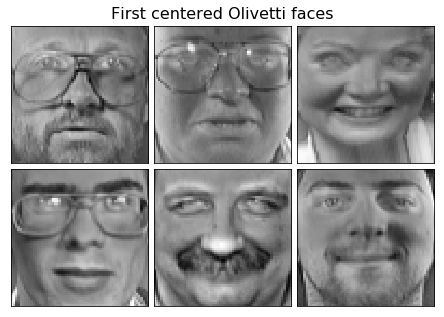

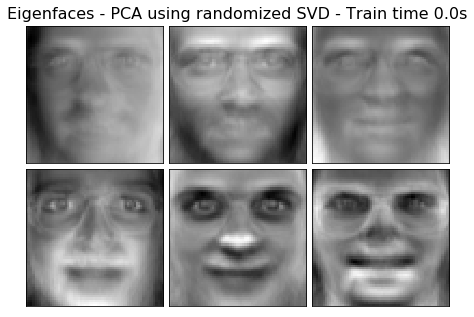

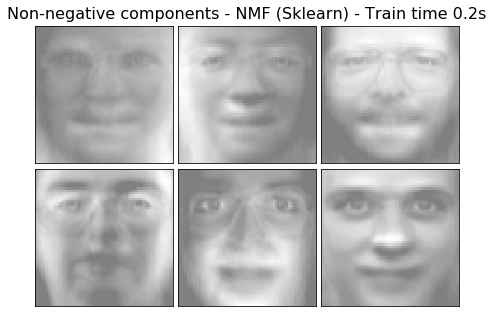

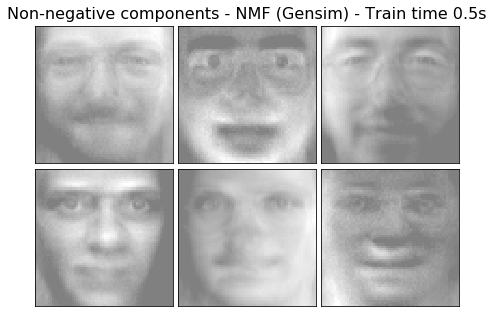

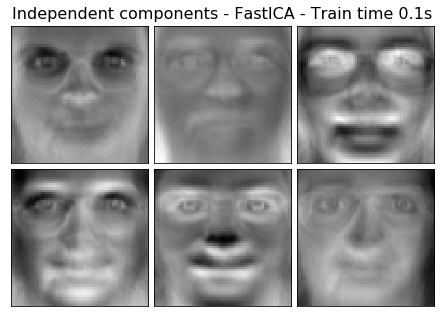

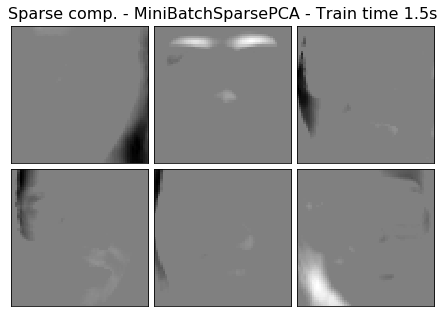

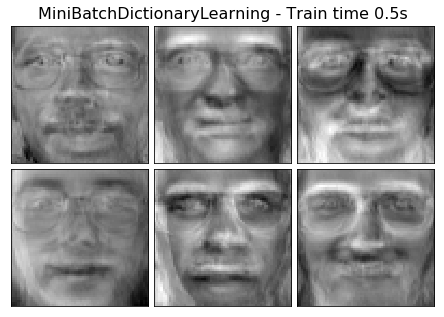

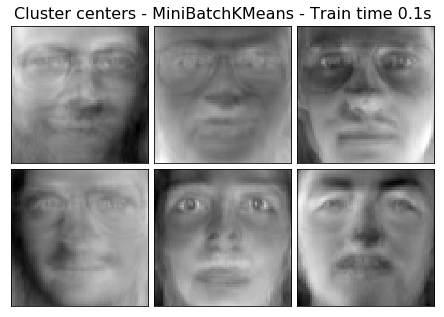

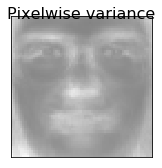

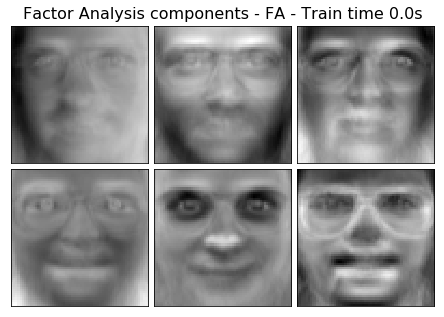

In [45]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=3,
         eval_every=400,
         passes=2,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0,
         random_state=42,
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

As you can see, Gensim's NMF implementation is slower than Sklearn's on **dense** vectors, while achieving comparable quality.

# Conclusion

Gensim NMF is an extremely fast and memory-optimized model. Use it to obtain interpretable topics, as an alternative to SVD / LDA.

---

The NMF implementation in Gensim was created by [Timofey Yefimov](https://github.com/anotherbugmaster/) as a part of his [RARE Technologies Student Incubator](https://rare-technologies.com/incubator/) graduation project.